<a href="https://colab.research.google.com/github/Aditya-y9/ApnaMakaan-Aditya-s-rough-fork/blob/main/Apna_Makaan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
# from test import population as population_final
from input_converter import *
import random
global i1
i1 = 0
from pix_array import floorArray
import time


"""
living room --> 25% skewness --> 1.6
kitchen --> 15% skewness --> 1.6 to 2
bathroom --> 10% skewness --> 1.6 to 2
bedroom --> 20% skewness --> 1.6 to 2
passage --> 15% skewness --> 3
"""
import numpy as np
import random
from pix_array import floorArray

def find_length_breadth_fixed_ratio(area, skewness=1.6):
    breadth = int((area / skewness) ** 0.5)
    length = int(skewness * breadth)
    return length, breadth

def is_rectangle_inside_plot(plot, vertex, length, breadth):
    x, y = vertex
    if x < 0 or y < 0 or x + length > plot.shape[1] or y + breadth > plot.shape[0]:
        return False
    for i in range(y, y + breadth):
        for j in range(x, x + length):
            if plot[i, j] == 0:
                return False
    return True

def mark_room_on_plot(plot, vertex, length, breadth, label):
    x, y = vertex
    for i in range(y, y + breadth):
        for j in range(x, x + length):
            # plot[i, j] = 0
            plot[i, j] = label

def get_boundary_coordinates(vertex, length, breadth):
    x, y = vertex
    left_boundary = [(x - 1, i) for i in range(y, y + breadth)]
    right_boundary = [(x + length, i) for i in range(y, y + breadth)]
    top_boundary = [(j, y - 1) for j in range(x, x + length)]
    bottom_boundary = [(j, y + breadth) for j in range(x, x + length)]
    return left_boundary, top_boundary, right_boundary, bottom_boundary

def find_room_position(plot, length, breadth, inside_coords, max_attempts=1000):
    for attempt in range(max_attempts):
        idx = random.randint(0, len(inside_coords) - 1)
        vertex = tuple(inside_coords[idx])
        if is_rectangle_inside_plot(plot, vertex, length, breadth):
            return vertex
    raise ValueError("Unable to find a valid position for the room within the maximum number of attempts.")

def select_random_boundary_point(boundaries):
    side = random.choice(['left', 'top', 'right', 'bottom'])
    if side == 'left':
        return random.choice(boundaries[0]), 'left'
    elif side == 'top':
        return random.choice(boundaries[1]), 'top'
    elif side == 'right':
        return random.choice(boundaries[2]), 'right'
    else:  # 'bottom'
        return random.choice(boundaries[3]), 'bottom'

def adjust_vertex_for_side(vertex, side, length, breadth):
    x, y = vertex
    if side == 'left':
        return (x - length, y)
    elif side == 'top':
        return (x, y - breadth)
    elif side == 'right':
        return (x + 1, y)
    elif side == 'bottom':
        return (x, y + 1)

def initial_population(path):
    binary_plot = floorArray(path)
    og_floor_array = np.copy(binary_plot)
    plot_area = np.sum(binary_plot)

    # Define room specifications
    rooms = [
        {"name": "living room", "area_percentage": 0.075, "skewness": 1.6, "label": 2},
        {"name": "passage", "area_percentage": 0.035, "skewness": random.uniform(1.6, 2), "label": 3},
        {"name": "kitchen", "area_percentage": 0.035, "skewness": random.uniform(1.6, 2), "label": 4},
        {"name": "bathroom", "area_percentage": 0.015, "skewness": random.uniform(1.6, 2), "label": 5},
        {"name": "bedroom", "area_percentage": 0.05, "skewness": random.uniform(1.6, 2), "label": 6},
        {"name": "bedroom2", "area_percentage": 0.05, "skewness": random.uniform(1.6, 2), "label": 6}
    ]

    room_positions = {}
    inside_coords = np.argwhere(binary_plot == 1)
    boundary_points_passage = None
    boundary_points_living_room = None
    for room in rooms:
        room_area = plot_area * room["area_percentage"]
        length, breadth = find_length_breadth_fixed_ratio(room_area, room["skewness"])
        # print(f"{room['name'].capitalize()} - Length: {length}, Breadth: {breadth}")

        try:
            if room["name"] == "living room":
                vertex = find_room_position(binary_plot, length, breadth, inside_coords)
                mark_room_on_plot(binary_plot, vertex, length, breadth, 2)
                # print(f"Vertex: {vertex}, Length: {length}, Breadth: {breadth}")
                room_positions[room["name"]] = {"vertex": vertex, "length": length, "breadth": breadth}
                left_boundary, top_boundary, right_boundary, bottom_boundary = get_boundary_coordinates(vertex, length, breadth)
                boundary_points_living_room = (left_boundary, top_boundary, right_boundary, bottom_boundary)

            elif room["name"] == "passage":
                if boundary_points_living_room is None:
                    raise ValueError("Boundary points for the living room are not set.")

                for attempt in range(10000):
                    boundary_vertex, side = select_random_boundary_point(boundary_points_living_room)

                    if random.choice([True, False]):
                        new_length, new_breadth = length, breadth
                    else:
                        new_length, new_breadth = breadth, length

                    adjusted_vertex = adjust_vertex_for_side(boundary_vertex, side, new_length, new_breadth)
                    if is_rectangle_inside_plot(binary_plot, adjusted_vertex, new_length, new_breadth):
                        mark_room_on_plot(binary_plot, adjusted_vertex, new_length, new_breadth, 3)
                        # print(f"New Vertex: {adjusted_vertex}, New Length: {new_length}, New Breadth: {new_breadth}")
                        room_positions[room["name"]] = {"vertex": adjusted_vertex, "length": new_length, "breadth": new_breadth}
                        # Update boundary points for the next room
                        left_boundary, top_boundary, right_boundary, bottom_boundary = get_boundary_coordinates(adjusted_vertex, new_length, new_breadth)
                        boundary_points_passage = (left_boundary, top_boundary, right_boundary, bottom_boundary)
                        break
                else:
                    print(f"Unable to place the {room['name']} at any selected boundary vertex within the maximum attempts.")

            else:
                if boundary_points_passage is None:
                    raise ValueError("Boundary points for the passage are not set.")

                for attempt in range(10000):
                    boundary_vertex, side = select_random_boundary_point(boundary_points_passage)

                    if random.choice([True, False]):
                        new_length, new_breadth = length, breadth
                    else:
                        new_length, new_breadth = breadth, length

                    adjusted_vertex = adjust_vertex_for_side(boundary_vertex, side, new_length, new_breadth)
                    if is_rectangle_inside_plot(binary_plot, adjusted_vertex, new_length, new_breadth):
                        mark_room_on_plot(binary_plot, adjusted_vertex, new_length, new_breadth, room["label"])
                        # print(f"New Vertex: {adjusted_vertex}, New Length: {new_length}, New Breadth: {new_breadth}")
                        room_positions[room["name"]] = {"vertex": adjusted_vertex, "length": new_length, "breadth": new_breadth}
                        # Update boundary points for the next room
                        # left_boundary, top_boundary, right_boundary, bottom_boundary = get_boundary_coordinates(adjusted_vertex, new_length, new_breadth)
                        # boundary_points_passage = (left_boundary, top_boundary, right_boundary, bottom_boundary)
                        break
                else:
                    print(f"Unable to place the {room['name']} at any selected boundary vertex within the maximum attempts.")
        except ValueError as e:
            print(e)

    np.savetxt('final_plot.txt', binary_plot, fmt='%d')
    # print(room_positions)

    return room_positions, binary_plot

Elapsed time for initial population generation: 40.88 seconds


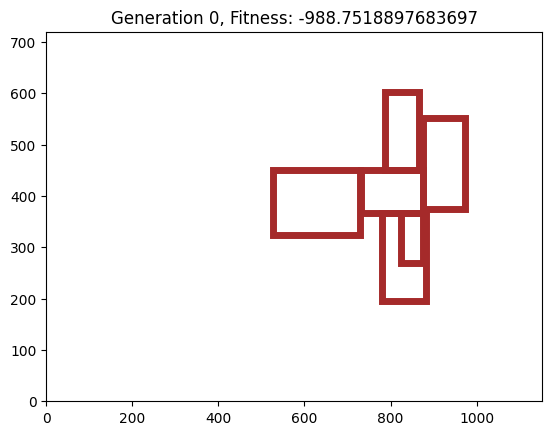

{'rooms': [{'name': 'Living Room', 'position': (527, 324), 'size': (203, 127)}, {'name': 'Passage', 'position': (731, 367), 'size': (144, 83)}, {'name': 'Kitchen', 'position': (788, 451), 'size': (78, 151)}, {'name': 'Washroom', 'position': (824, 270), 'size': (52, 96)}, {'name': 'Bedroom1', 'position': (781, 196), 'size': (101, 170)}, {'name': 'Bedroom2', 'position': (876, 374), 'size': (96, 178)}], 'fitness': -988.7518897683697}


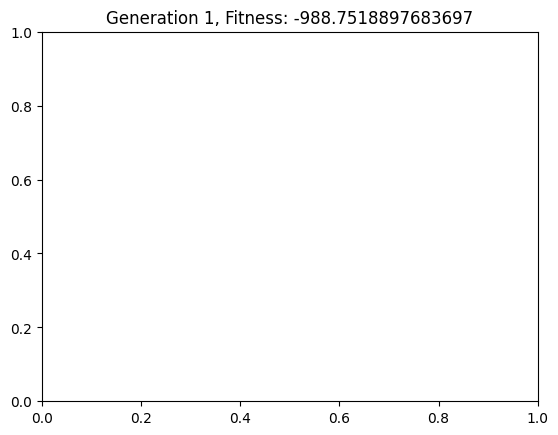

{'rooms': [{'name': 'Living Room', 'position': (527, 324), 'size': (203, 127)}, {'name': 'Passage', 'position': (731, 367), 'size': (144, 83)}, {'name': 'Kitchen', 'position': (788, 451), 'size': (78, 151)}, {'name': 'Washroom', 'position': (824, 270), 'size': (52, 96)}, {'name': 'Bedroom1', 'position': (781, 196), 'size': (101, 170)}, {'name': 'Bedroom2', 'position': (876, 374), 'size': (96, 178)}], 'fitness': -988.7518897683697}


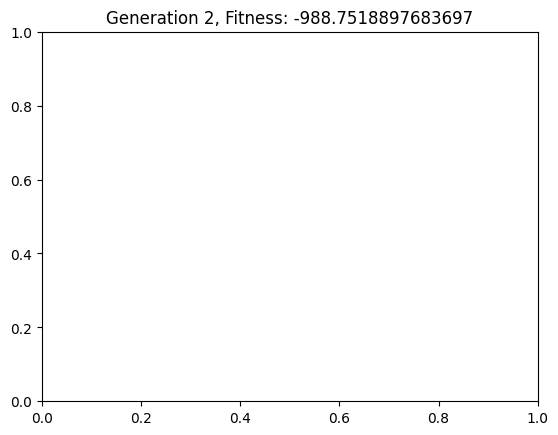

{'rooms': [{'name': 'Living Room', 'position': (527, 324), 'size': (204, 128)}, {'name': 'Passage', 'position': (731, 367), 'size': (144, 83)}, {'name': 'Kitchen', 'position': (788, 451), 'size': (78, 151)}, {'name': 'Washroom', 'position': (824, 270), 'size': (52, 96)}, {'name': 'Bedroom1', 'position': (781, 196), 'size': (102, 171)}, {'name': 'Bedroom2', 'position': (876, 374), 'size': (96, 178)}], 'fitness': -988.7518897683697}


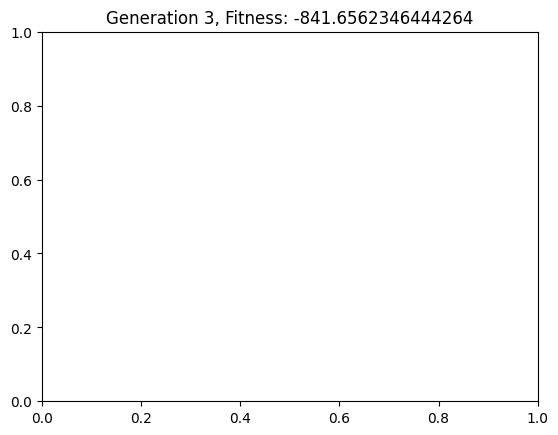

{'rooms': [{'name': 'Living Room', 'position': (527, 324), 'size': (204, 128)}, {'name': 'Bedroom1', 'position': (781, 196), 'size': (102, 171)}, {'name': 'Bedroom2', 'position': (876, 374), 'size': (96, 178)}, {'name': 'Passage', 'position': (731, 367), 'size': (127, 83)}, {'name': 'Kitchen', 'position': (788, 451), 'size': (78, 151)}, {'name': 'Washroom', 'position': (858, 417), 'size': (18, 34)}], 'fitness': -841.6562346444264}


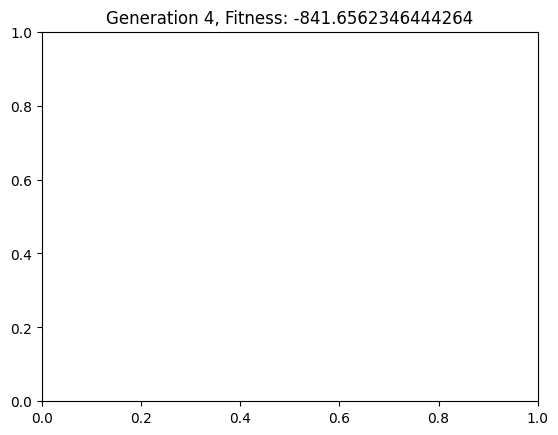

{'rooms': [{'name': 'Living Room', 'position': (526, 324), 'size': (204, 129)}, {'name': 'Bedroom1', 'position': (781, 195), 'size': (103, 171)}, {'name': 'Bedroom2', 'position': (876, 374), 'size': (97, 179)}, {'name': 'Passage', 'position': (731, 367), 'size': (127, 84)}, {'name': 'Kitchen', 'position': (788, 451), 'size': (79, 149)}, {'name': 'Washroom', 'position': (858, 417), 'size': (18, 34)}], 'fitness': -841.6562346444264}


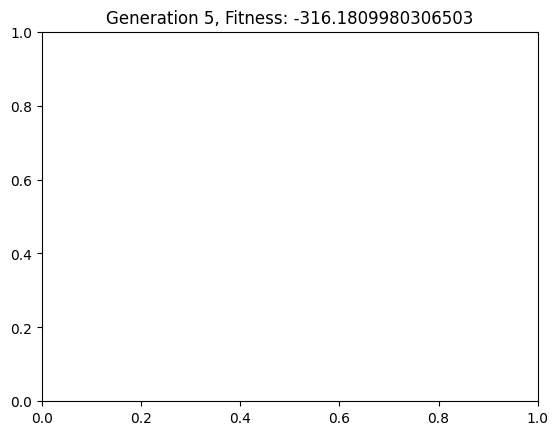

{'rooms': [{'name': 'Living Room', 'position': (525, 324), 'size': (205, 131)}, {'name': 'Bedroom1', 'position': (781, 194), 'size': (105, 172)}, {'name': 'Bedroom2', 'position': (876, 374), 'size': (96, 47)}, {'name': 'Passage', 'position': (731, 367), 'size': (127, 84)}, {'name': 'Kitchen', 'position': (788, 451), 'size': (78, 151)}, {'name': 'Washroom', 'position': (858, 417), 'size': (52, 34)}], 'fitness': -316.1809980306503}


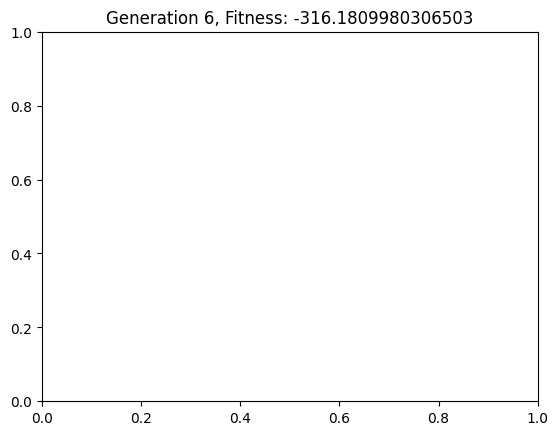

{'rooms': [{'name': 'Living Room', 'position': (525, 324), 'size': (206, 132)}, {'name': 'Bedroom1', 'position': (781, 194), 'size': (106, 173)}, {'name': 'Bedroom2', 'position': (876, 374), 'size': (97, 48)}, {'name': 'Passage', 'position': (731, 367), 'size': (127, 84)}, {'name': 'Kitchen', 'position': (788, 451), 'size': (79, 126)}, {'name': 'Washroom', 'position': (858, 417), 'size': (52, 34)}], 'fitness': -316.1809980306503}


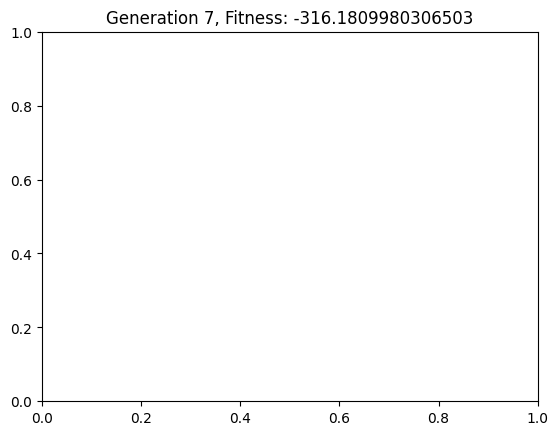

{'rooms': [{'name': 'Living Room', 'position': (523, 324), 'size': (206, 134)}, {'name': 'Bedroom1', 'position': (781, 192), 'size': (108, 173)}, {'name': 'Bedroom2', 'position': (876, 374), 'size': (97, 48)}, {'name': 'Passage', 'position': (730, 366), 'size': (128, 85)}, {'name': 'Kitchen', 'position': (788, 451), 'size': (81, 158)}, {'name': 'Washroom', 'position': (858, 417), 'size': (52, 34)}], 'fitness': -450.778469658468}


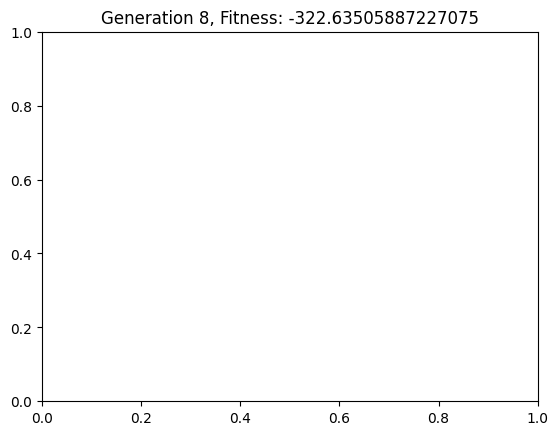

{'rooms': [{'name': 'Living Room', 'position': (521, 324), 'size': (208, 138)}, {'name': 'Bedroom1', 'position': (781, 190), 'size': (112, 175)}, {'name': 'Bedroom2', 'position': (876, 374), 'size': (97, 48)}, {'name': 'Passage', 'position': (729, 365), 'size': (129, 86)}, {'name': 'Kitchen', 'position': (788, 451), 'size': (85, 161)}, {'name': 'Washroom', 'position': (858, 417), 'size': (52, 34)}], 'fitness': -322.63505887227075}


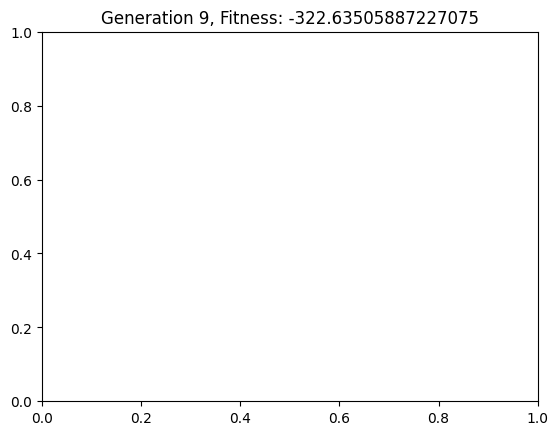

{'rooms': [{'name': 'Living Room', 'position': (519, 324), 'size': (208, 140)}, {'name': 'Bedroom1', 'position': (781, 188), 'size': (114, 175)}, {'name': 'Bedroom2', 'position': (876, 374), 'size': (97, 48)}, {'name': 'Passage', 'position': (728, 364), 'size': (130, 87)}, {'name': 'Kitchen', 'position': (788, 451), 'size': (87, 154)}, {'name': 'Washroom', 'position': (858, 417), 'size': (52, 34)}], 'fitness': -350.7599383817792}


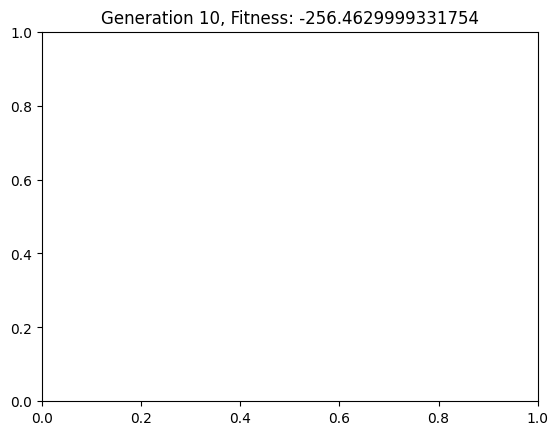

{'rooms': [{'name': 'Living Room', 'position': (500, 324), 'size': (205, 156)}, {'name': 'Bedroom1', 'position': (781, 177), 'size': (130, 180)}, {'name': 'Bedroom2', 'position': (876, 374), 'size': (101, 206)}, {'name': 'Passage', 'position': (705, 357), 'size': (128, 93)}, {'name': 'Kitchen', 'position': (780, 451), 'size': (96, 170)}, {'name': 'Washroom', 'position': (833, 373), 'size': (43, 71)}], 'fitness': -256.4629999331754}


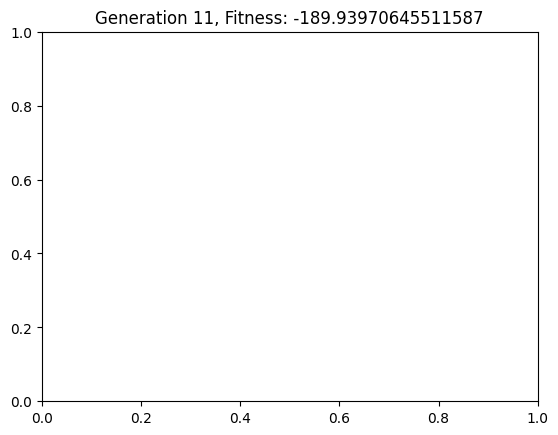

{'rooms': [{'name': 'Living Room', 'position': (493, 324), 'size': (206, 164)}, {'name': 'Bedroom1', 'position': (781, 172), 'size': (138, 183)}, {'name': 'Bedroom2', 'position': (876, 374), 'size': (101, 214)}, {'name': 'Passage', 'position': (699, 355), 'size': (129, 96)}, {'name': 'Kitchen', 'position': (779, 451), 'size': (97, 162)}, {'name': 'Washroom', 'position': (828, 360), 'size': (48, 79)}], 'fitness': -189.93970645511587}


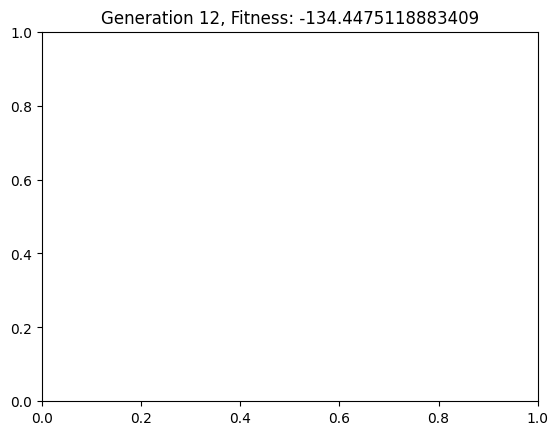

{'rooms': [{'name': 'Living Room', 'position': (486, 324), 'size': (207, 172)}, {'name': 'Bedroom1', 'position': (781, 166), 'size': (146, 185)}, {'name': 'Bedroom2', 'position': (876, 374), 'size': (101, 222)}, {'name': 'Passage', 'position': (694, 352), 'size': (131, 99)}, {'name': 'Kitchen', 'position': (776, 451), 'size': (100, 165)}, {'name': 'Washroom', 'position': (825, 360), 'size': (51, 83)}], 'fitness': -134.4475118883409}


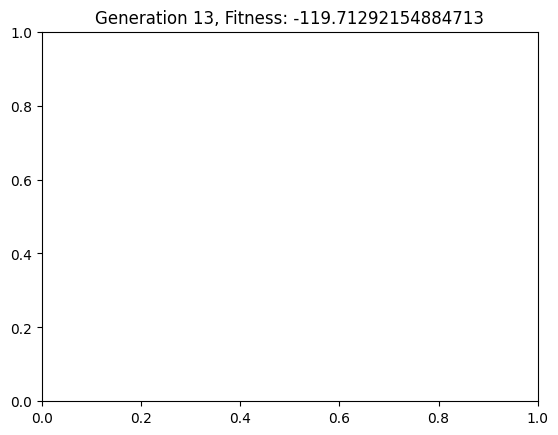

{'rooms': [{'name': 'Living Room', 'position': (480, 324), 'size': (209, 180)}, {'name': 'Bedroom1', 'position': (781, 161), 'size': (154, 188)}, {'name': 'Bedroom2', 'position': (876, 374), 'size': (101, 230)}, {'name': 'Passage', 'position': (690, 349), 'size': (133, 101)}, {'name': 'Kitchen', 'position': (774, 451), 'size': (102, 170)}, {'name': 'Washroom', 'position': (823, 360), 'size': (53, 91)}], 'fitness': -119.71292154884713}


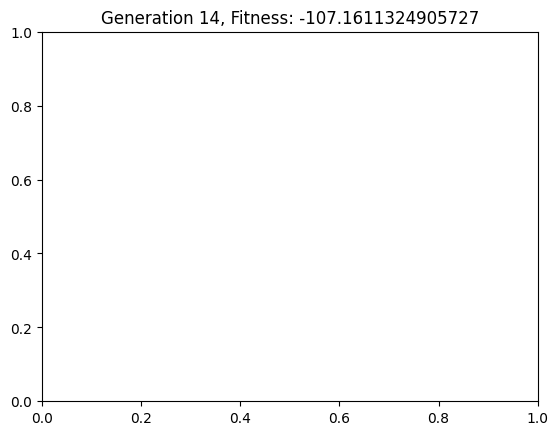

{'rooms': [{'name': 'Living Room', 'position': (475, 322), 'size': (212, 186)}, {'name': 'Bedroom1', 'position': (781, 156), 'size': (162, 191)}, {'name': 'Bedroom2', 'position': (876, 374), 'size': (101, 238)}, {'name': 'Passage', 'position': (687, 347), 'size': (135, 104)}, {'name': 'Kitchen', 'position': (774, 451), 'size': (102, 170)}, {'name': 'Washroom', 'position': (822, 360), 'size': (54, 86)}], 'fitness': -107.1611324905727}


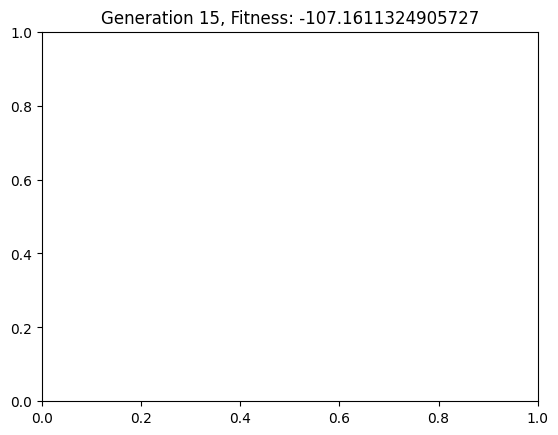

{'rooms': [{'name': 'Living Room', 'position': (468, 318), 'size': (213, 190)}, {'name': 'Bedroom1', 'position': (781, 150), 'size': (170, 193)}, {'name': 'Bedroom2', 'position': (876, 374), 'size': (101, 246)}, {'name': 'Passage', 'position': (682, 344), 'size': (137, 107)}, {'name': 'Kitchen', 'position': (773, 451), 'size': (103, 165)}, {'name': 'Washroom', 'position': (819, 351), 'size': (57, 98)}], 'fitness': -114.68982939472983}


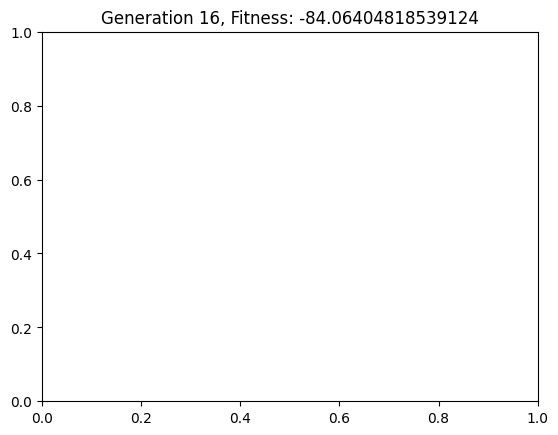

{'rooms': [{'name': 'Living Room', 'position': (462, 314), 'size': (215, 194)}, {'name': 'Bedroom1', 'position': (781, 146), 'size': (178, 197)}, {'name': 'Bedroom2', 'position': (876, 370), 'size': (101, 250)}, {'name': 'Passage', 'position': (677, 343), 'size': (138, 108)}, {'name': 'Kitchen', 'position': (772, 451), 'size': (104, 170)}, {'name': 'Washroom', 'position': (816, 344), 'size': (60, 105)}], 'fitness': -84.06404818539124}


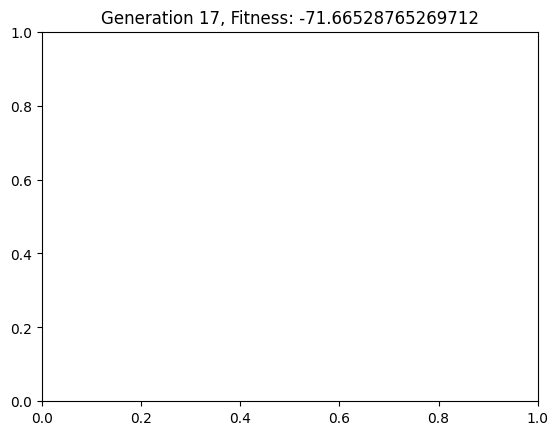

{'rooms': [{'name': 'Living Room', 'position': (456, 310), 'size': (217, 198)}, {'name': 'Bedroom1', 'position': (781, 142), 'size': (186, 201)}, {'name': 'Bedroom2', 'position': (876, 366), 'size': (101, 254)}, {'name': 'Passage', 'position': (673, 343), 'size': (140, 108)}, {'name': 'Kitchen', 'position': (771, 451), 'size': (105, 170)}, {'name': 'Washroom', 'position': (814, 344), 'size': (62, 99)}], 'fitness': -71.66528765269712}


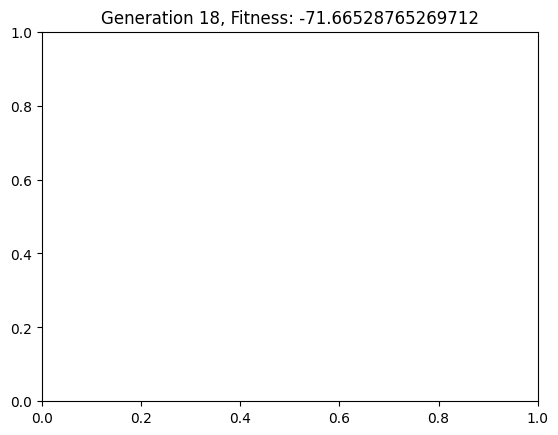

{'rooms': [{'name': 'Living Room', 'position': (451, 306), 'size': (220, 202)}, {'name': 'Bedroom1', 'position': (781, 138), 'size': (194, 205)}, {'name': 'Bedroom2', 'position': (876, 362), 'size': (101, 258)}, {'name': 'Passage', 'position': (671, 343), 'size': (143, 108)}, {'name': 'Kitchen', 'position': (771, 451), 'size': (105, 170)}, {'name': 'Washroom', 'position': (814, 344), 'size': (62, 99)}], 'fitness': -273.2131410527913}


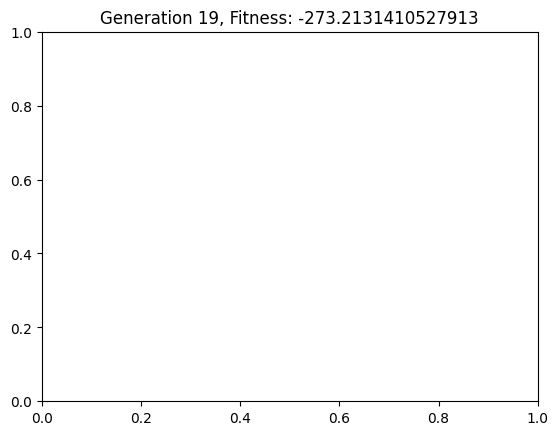

{'rooms': [{'name': 'Living Room', 'position': (445, 302), 'size': (222, 206)}, {'name': 'Bedroom1', 'position': (778, 134), 'size': (199, 209)}, {'name': 'Bedroom2', 'position': (876, 358), 'size': (101, 262)}, {'name': 'Passage', 'position': (668, 343), 'size': (146, 108)}, {'name': 'Kitchen', 'position': (771, 451), 'size': (105, 170)}, {'name': 'Washroom', 'position': (814, 344), 'size': (62, 99)}], 'fitness': -282.88591701204035}


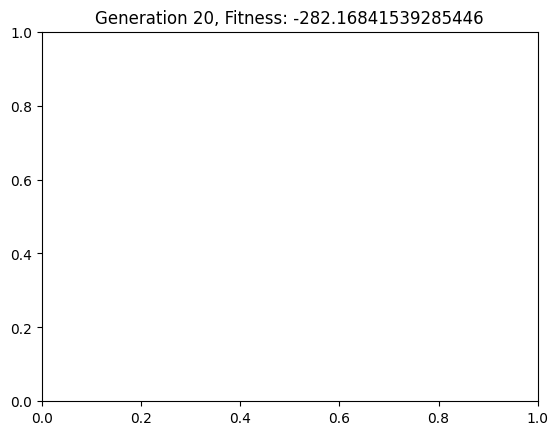

{'rooms': [{'name': 'Living Room', 'position': (440, 298), 'size': (225, 210)}, {'name': 'Bedroom1', 'position': (774, 130), 'size': (203, 213)}, {'name': 'Bedroom2', 'position': (876, 354), 'size': (101, 266)}, {'name': 'Passage', 'position': (665, 343), 'size': (148, 108)}, {'name': 'Kitchen', 'position': (771, 451), 'size': (105, 170)}, {'name': 'Washroom', 'position': (814, 344), 'size': (62, 99)}], 'fitness': -282.16841539285446}


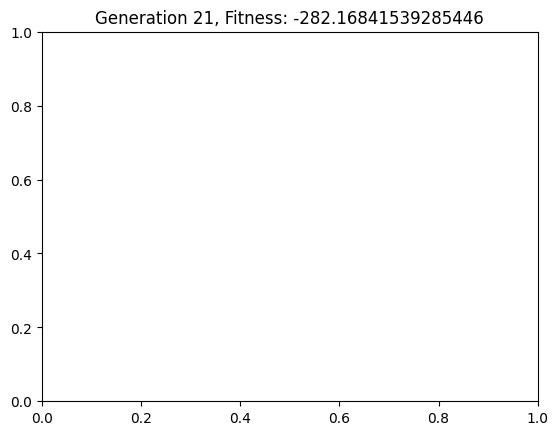

{'rooms': [{'name': 'Living Room', 'position': (434, 294), 'size': (227, 214)}, {'name': 'Bedroom1', 'position': (770, 126), 'size': (207, 217)}, {'name': 'Bedroom2', 'position': (876, 350), 'size': (101, 270)}, {'name': 'Passage', 'position': (662, 343), 'size': (151, 108)}, {'name': 'Kitchen', 'position': (771, 451), 'size': (105, 170)}, {'name': 'Washroom', 'position': (813, 344), 'size': (63, 107)}], 'fitness': -296.86001234910617}


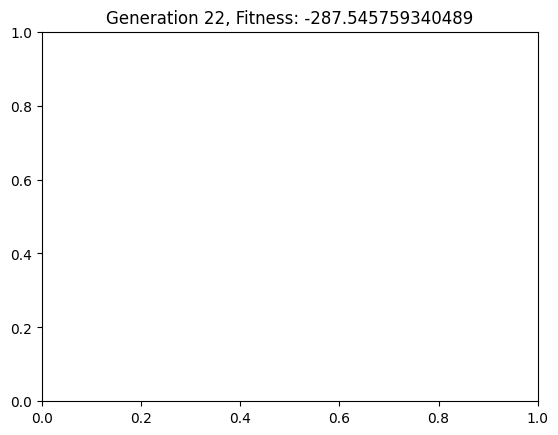

{'rooms': [{'name': 'Living Room', 'position': (429, 290), 'size': (230, 218)}, {'name': 'Bedroom1', 'position': (766, 122), 'size': (211, 221)}, {'name': 'Bedroom2', 'position': (876, 346), 'size': (101, 274)}, {'name': 'Passage', 'position': (659, 343), 'size': (153, 108)}, {'name': 'Kitchen', 'position': (771, 451), 'size': (105, 170)}, {'name': 'Washroom', 'position': (812, 344), 'size': (64, 105)}], 'fitness': -287.545759340489}


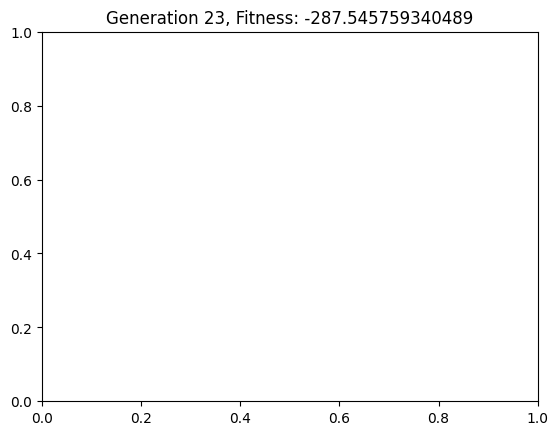

{'rooms': [{'name': 'Living Room', 'position': (423, 286), 'size': (232, 222)}, {'name': 'Bedroom1', 'position': (762, 118), 'size': (215, 225)}, {'name': 'Bedroom2', 'position': (876, 343), 'size': (101, 278)}, {'name': 'Passage', 'position': (655, 343), 'size': (155, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (811, 344), 'size': (65, 107)}], 'fitness': -296.94493939306585}


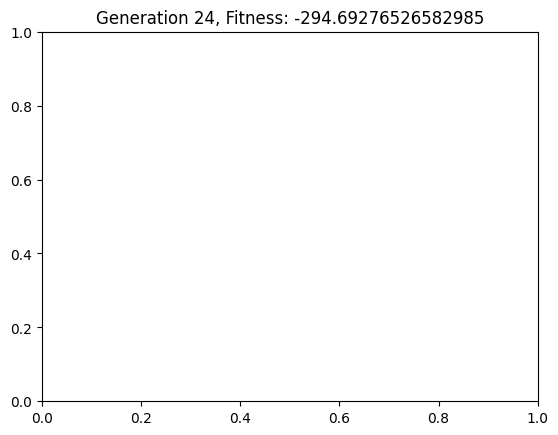

{'rooms': [{'name': 'Living Room', 'position': (417, 282), 'size': (234, 226)}, {'name': 'Bedroom1', 'position': (758, 117), 'size': (219, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (652, 343), 'size': (158, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (810, 344), 'size': (66, 107)}], 'fitness': -294.69276526582985}


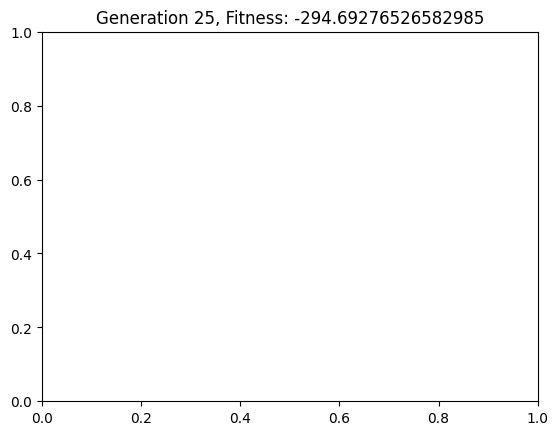

{'rooms': [{'name': 'Living Room', 'position': (412, 278), 'size': (237, 230)}, {'name': 'Bedroom1', 'position': (754, 117), 'size': (223, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (649, 343), 'size': (160, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (810, 344), 'size': (66, 107)}], 'fitness': -299.93226152165505}


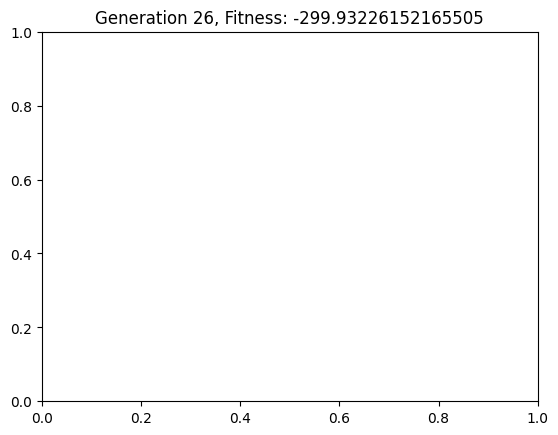

{'rooms': [{'name': 'Living Room', 'position': (407, 274), 'size': (240, 234)}, {'name': 'Bedroom1', 'position': (750, 117), 'size': (227, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (647, 343), 'size': (163, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (810, 344), 'size': (66, 107)}], 'fitness': -307.257819050212}


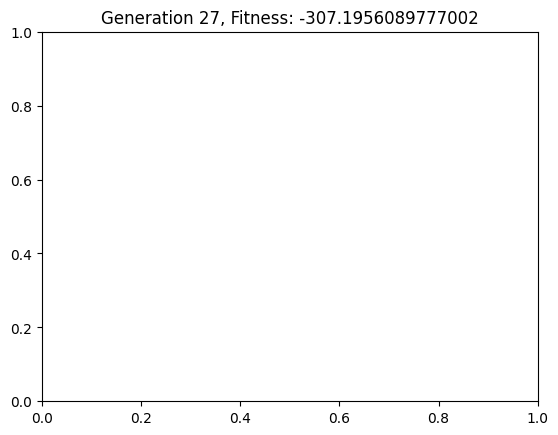

{'rooms': [{'name': 'Living Room', 'position': (401, 270), 'size': (242, 238)}, {'name': 'Bedroom1', 'position': (746, 117), 'size': (231, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (643, 343), 'size': (165, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -307.1956089777002}


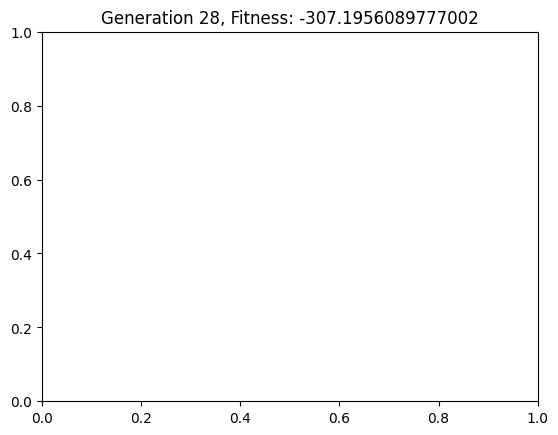

{'rooms': [{'name': 'Living Room', 'position': (396, 266), 'size': (245, 242)}, {'name': 'Bedroom1', 'position': (742, 117), 'size': (235, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (641, 343), 'size': (168, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -315.47421192557084}


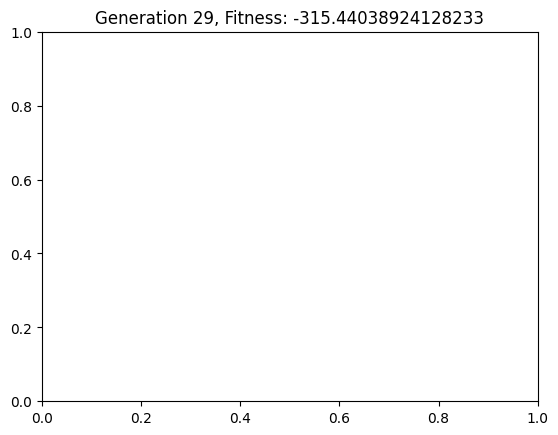

{'rooms': [{'name': 'Living Room', 'position': (390, 262), 'size': (247, 246)}, {'name': 'Bedroom1', 'position': (738, 117), 'size': (239, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (638, 343), 'size': (171, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -315.44038924128233}


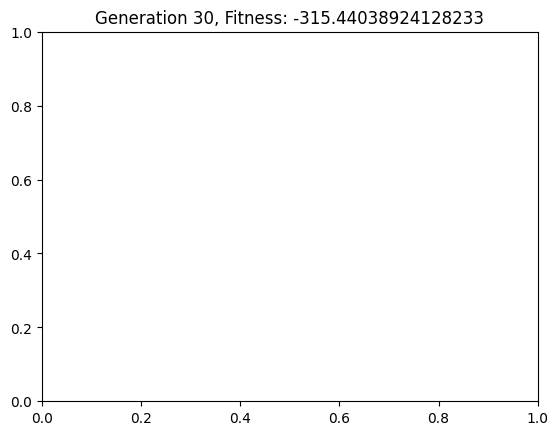

{'rooms': [{'name': 'Living Room', 'position': (386, 258), 'size': (251, 250)}, {'name': 'Bedroom1', 'position': (734, 117), 'size': (243, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -329.0467350005879}


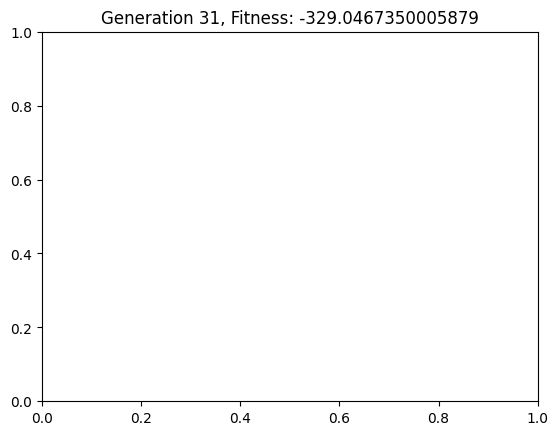

{'rooms': [{'name': 'Living Room', 'position': (382, 254), 'size': (255, 254)}, {'name': 'Bedroom1', 'position': (730, 117), 'size': (247, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -339.03887556344046}


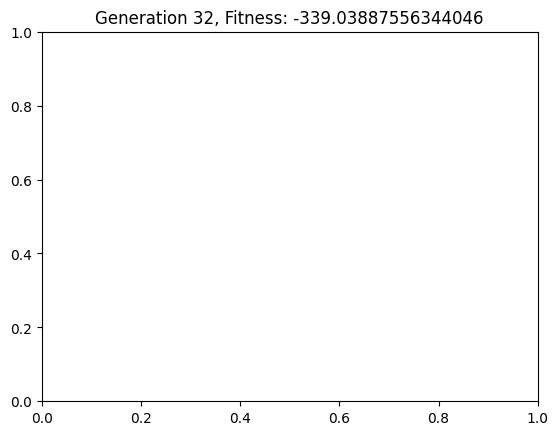

{'rooms': [{'name': 'Living Room', 'position': (378, 250), 'size': (259, 258)}, {'name': 'Bedroom1', 'position': (726, 117), 'size': (251, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -348.2823186641135}


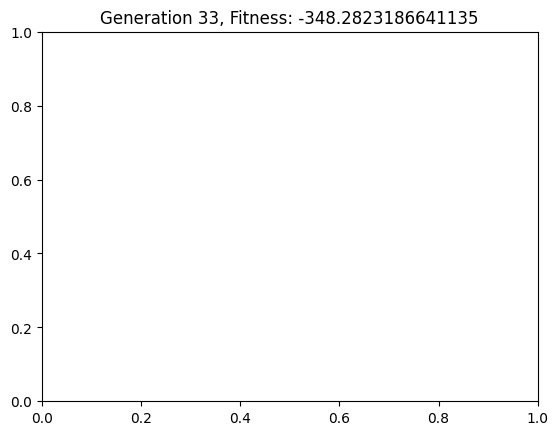

{'rooms': [{'name': 'Living Room', 'position': (374, 246), 'size': (263, 262)}, {'name': 'Bedroom1', 'position': (722, 117), 'size': (255, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -358.7281440818662}


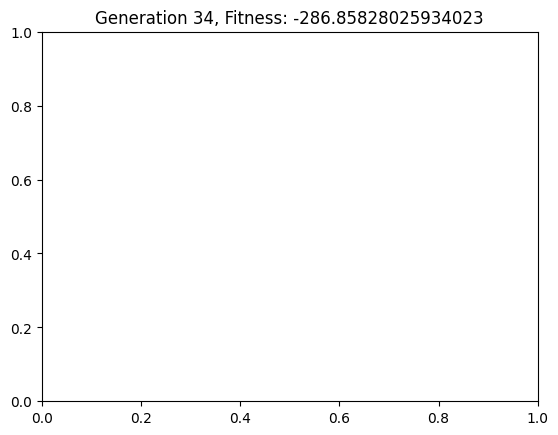

{'rooms': [{'name': 'Living Room', 'position': (370, 242), 'size': (267, 266)}, {'name': 'Bedroom1', 'position': (718, 117), 'size': (259, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -286.85828025934023}


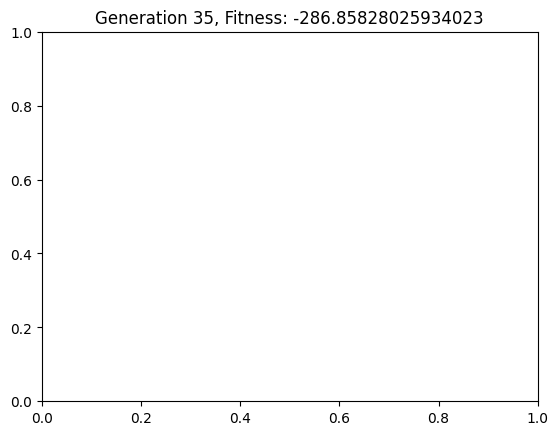

{'rooms': [{'name': 'Living Room', 'position': (366, 238), 'size': (271, 270)}, {'name': 'Bedroom1', 'position': (714, 117), 'size': (263, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -299.2260566417384}


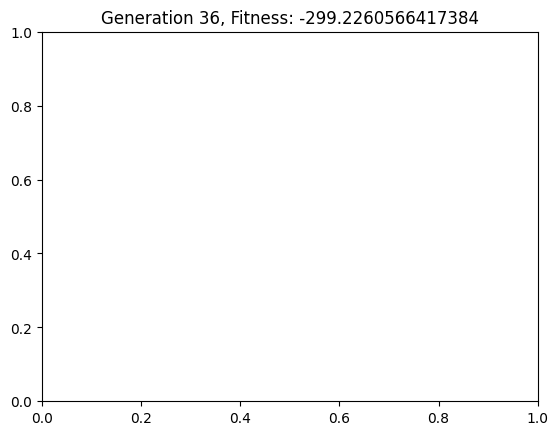

{'rooms': [{'name': 'Living Room', 'position': (362, 234), 'size': (275, 274)}, {'name': 'Bedroom1', 'position': (710, 117), 'size': (267, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -310.27767673750384}


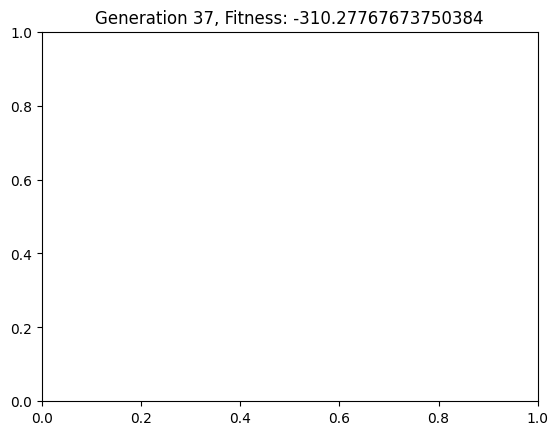

{'rooms': [{'name': 'Living Room', 'position': (358, 230), 'size': (279, 278)}, {'name': 'Bedroom1', 'position': (706, 117), 'size': (271, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -321.530745590205}


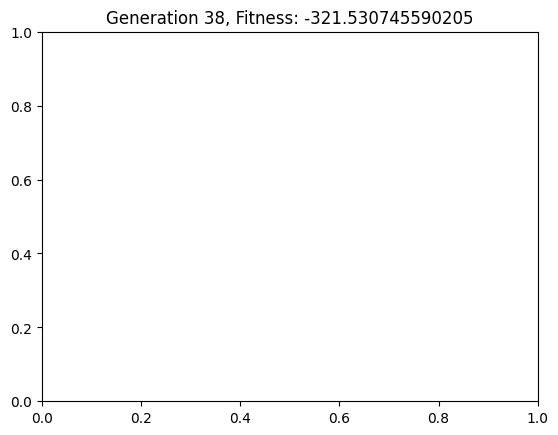

{'rooms': [{'name': 'Living Room', 'position': (354, 230), 'size': (283, 279)}, {'name': 'Bedroom1', 'position': (702, 117), 'size': (275, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -331.9850064457181}


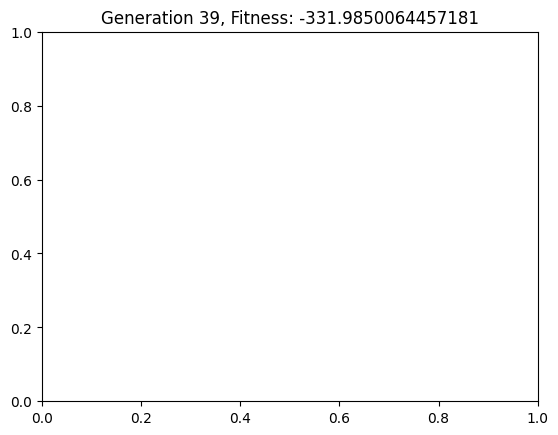

{'rooms': [{'name': 'Living Room', 'position': (350, 230), 'size': (287, 279)}, {'name': 'Bedroom1', 'position': (698, 117), 'size': (279, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -337.7532725814623}


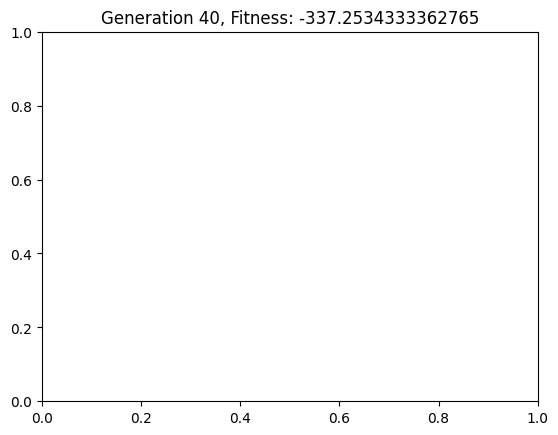

{'rooms': [{'name': 'Living Room', 'position': (346, 230), 'size': (291, 279)}, {'name': 'Bedroom1', 'position': (694, 117), 'size': (283, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -337.2534333362765}


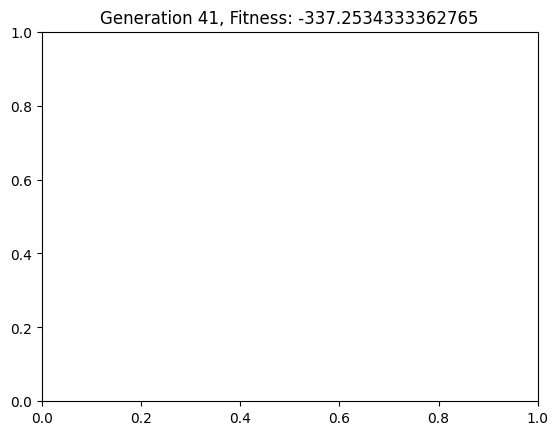

{'rooms': [{'name': 'Living Room', 'position': (342, 230), 'size': (295, 279)}, {'name': 'Bedroom1', 'position': (690, 117), 'size': (287, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -347.7410767917155}


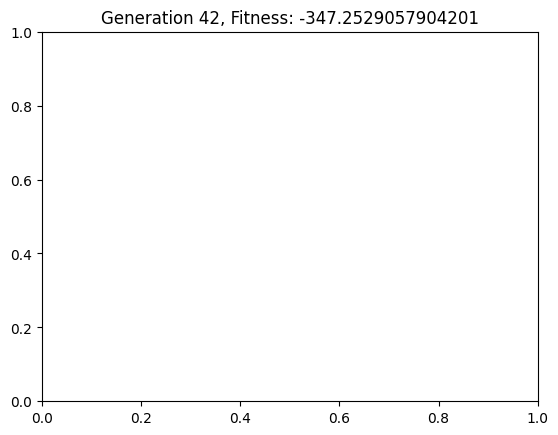

{'rooms': [{'name': 'Living Room', 'position': (338, 230), 'size': (299, 279)}, {'name': 'Bedroom1', 'position': (686, 117), 'size': (291, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -347.2529057904201}


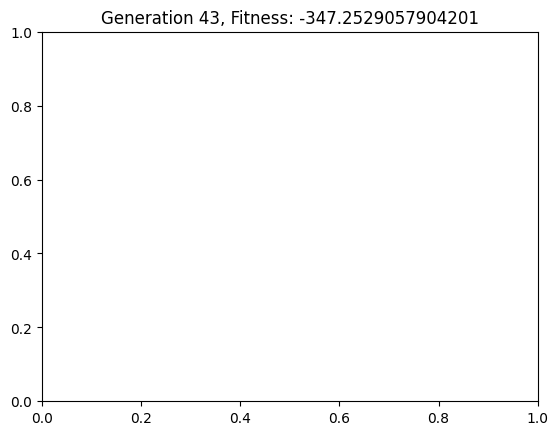

{'rooms': [{'name': 'Living Room', 'position': (334, 230), 'size': (303, 279)}, {'name': 'Bedroom1', 'position': (682, 117), 'size': (295, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -356.7639641646475}


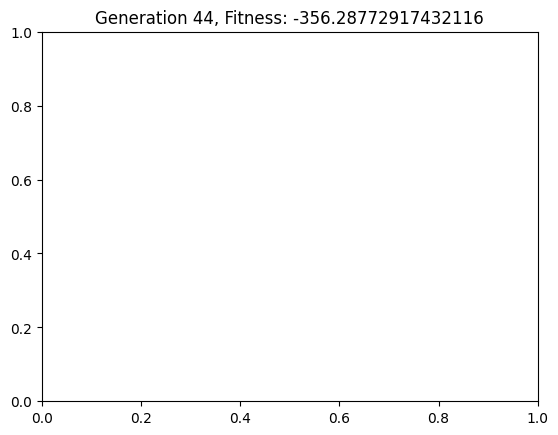

{'rooms': [{'name': 'Living Room', 'position': (330, 230), 'size': (307, 279)}, {'name': 'Bedroom1', 'position': (678, 117), 'size': (299, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -356.28772917432116}


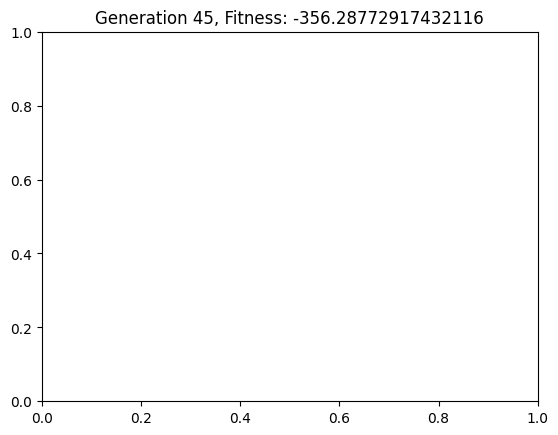

{'rooms': [{'name': 'Living Room', 'position': (326, 230), 'size': (311, 279)}, {'name': 'Bedroom1', 'position': (678, 117), 'size': (299, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -366.82278005216847}


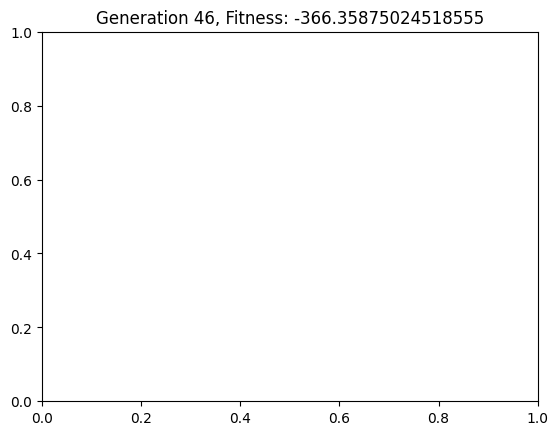

{'rooms': [{'name': 'Living Room', 'position': (322, 230), 'size': (315, 279)}, {'name': 'Bedroom1', 'position': (678, 117), 'size': (299, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -366.35875024518555}


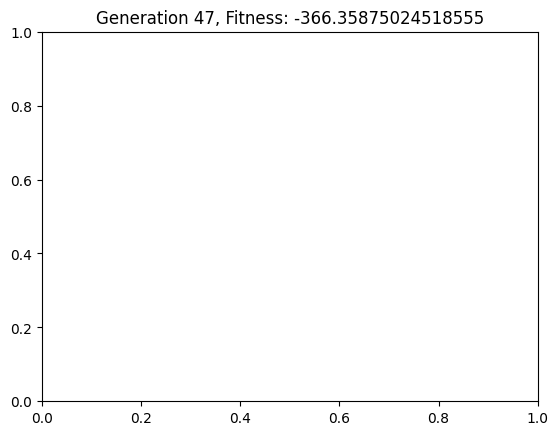

{'rooms': [{'name': 'Living Room', 'position': (318, 230), 'size': (319, 279)}, {'name': 'Bedroom1', 'position': (678, 117), 'size': (299, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -374.7786986456224}


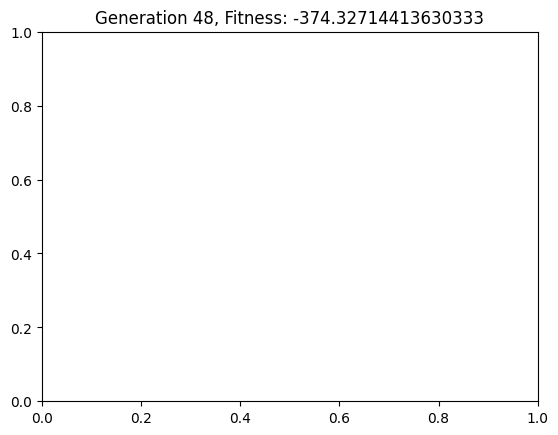

{'rooms': [{'name': 'Living Room', 'position': (314, 230), 'size': (323, 279)}, {'name': 'Bedroom1', 'position': (678, 117), 'size': (299, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -374.32714413630333}


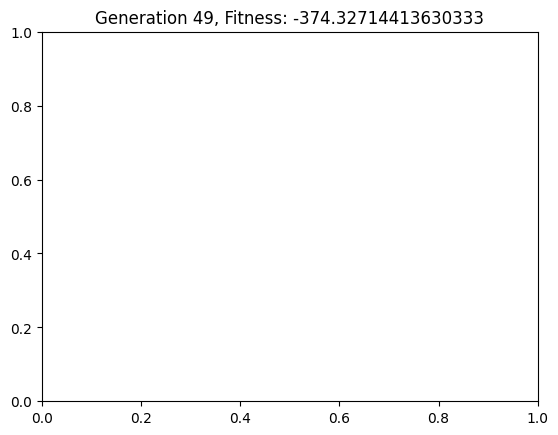

{'rooms': [{'name': 'Living Room', 'position': (310, 230), 'size': (327, 279)}, {'name': 'Bedroom1', 'position': (678, 117), 'size': (299, 225)}, {'name': 'Bedroom2', 'position': (876, 342), 'size': (101, 279)}, {'name': 'Passage', 'position': (637, 343), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (770, 451), 'size': (106, 169)}, {'name': 'Washroom', 'position': (809, 343), 'size': (67, 108)}], 'fitness': -382.78127819482984}
Elapsed time: 970.68 seconds


<Figure size 640x480 with 0 Axes>

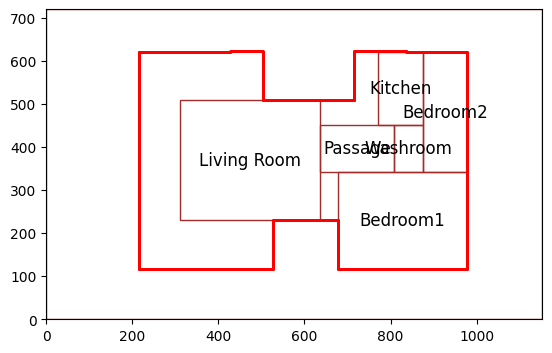

Elapsed time for initial population generation: 40.89 seconds


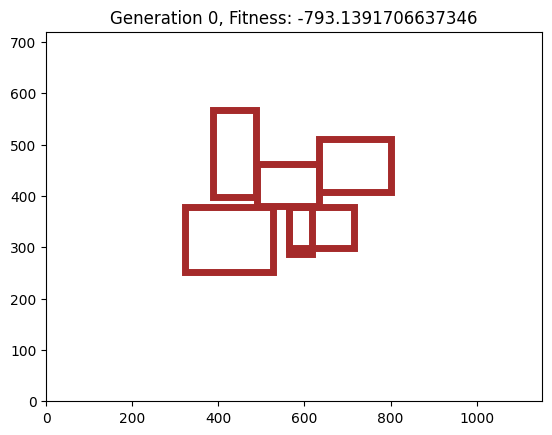

{'rooms': [{'name': 'Living Room', 'position': (323, 252), 'size': (203, 127)}, {'name': 'Passage', 'position': (489, 380), 'size': (144, 82)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}, {'name': 'Bedroom1', 'position': (388, 397), 'size': (100, 171)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}], 'fitness': -793.1391706637346}


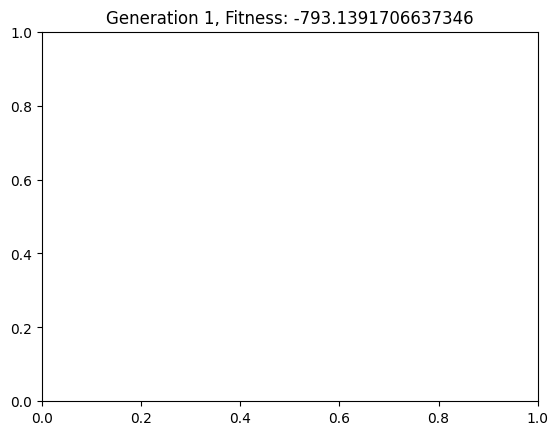

{'rooms': [{'name': 'Living Room', 'position': (323, 251), 'size': (205, 128)}, {'name': 'Passage', 'position': (488, 380), 'size': (145, 84)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}, {'name': 'Bedroom1', 'position': (387, 397), 'size': (101, 173)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}], 'fitness': -793.1391706637346}


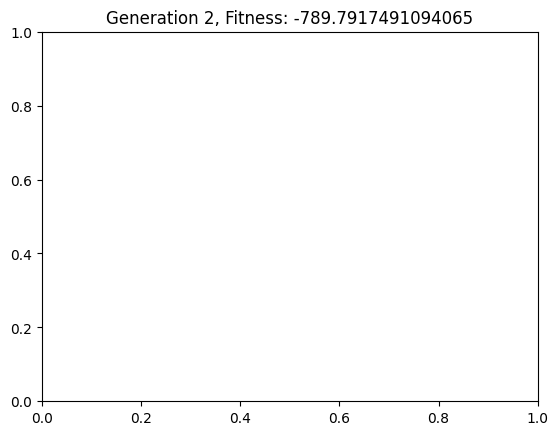

{'rooms': [{'name': 'Living Room', 'position': (323, 249), 'size': (209, 130)}, {'name': 'Bedroom1', 'position': (384, 397), 'size': (102, 177)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (487, 380), 'size': (147, 88)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -789.7917491094065}


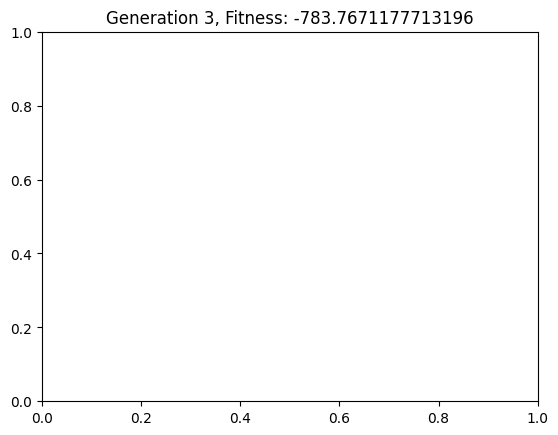

{'rooms': [{'name': 'Living Room', 'position': (323, 245), 'size': (217, 134)}, {'name': 'Bedroom1', 'position': (379, 397), 'size': (105, 185)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (484, 380), 'size': (149, 96)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -783.7671177713196}


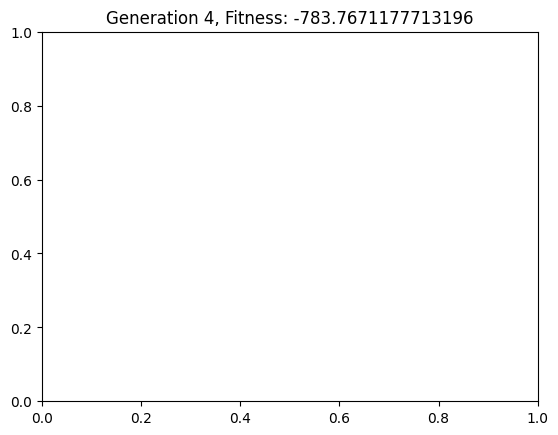

{'rooms': [{'name': 'Living Room', 'position': (323, 241), 'size': (225, 138)}, {'name': 'Bedroom1', 'position': (374, 397), 'size': (108, 193)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (482, 380), 'size': (152, 104)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1008.9791624283656}


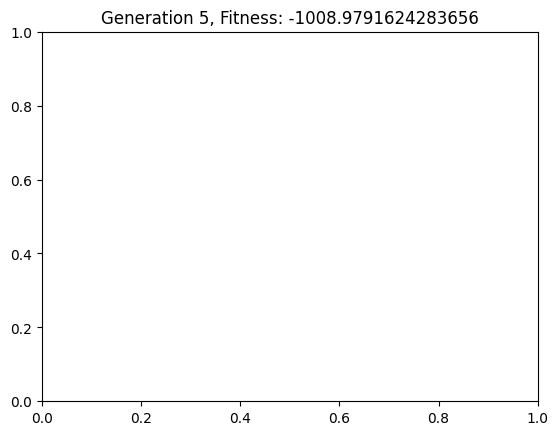

{'rooms': [{'name': 'Living Room', 'position': (323, 237), 'size': (233, 142)}, {'name': 'Bedroom1', 'position': (368, 397), 'size': (110, 201)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (479, 380), 'size': (155, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1026.9931959681394}


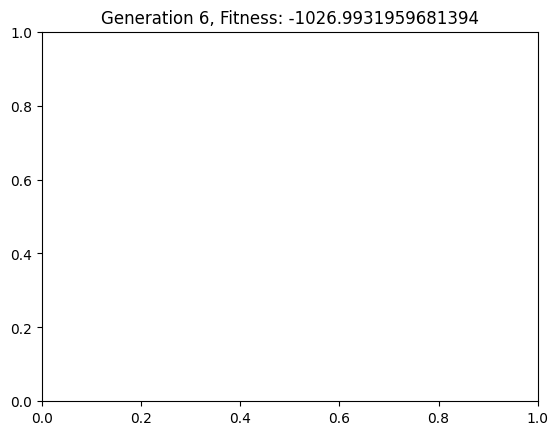

{'rooms': [{'name': 'Living Room', 'position': (322, 233), 'size': (240, 146)}, {'name': 'Bedroom1', 'position': (363, 397), 'size': (113, 209)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (476, 380), 'size': (157, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1045.1789330868555}


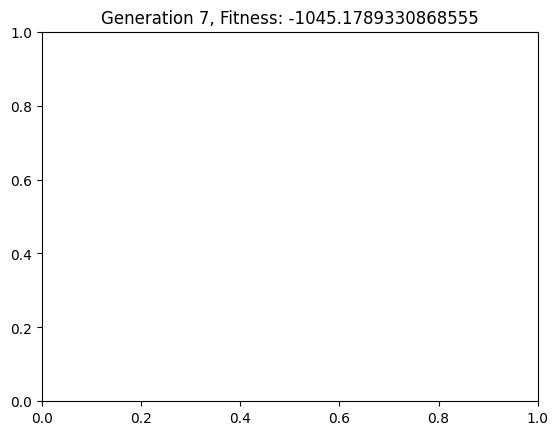

{'rooms': [{'name': 'Living Room', 'position': (318, 230), 'size': (244, 150)}, {'name': 'Bedroom1', 'position': (358, 397), 'size': (116, 217)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (474, 380), 'size': (160, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1063.6620451384842}


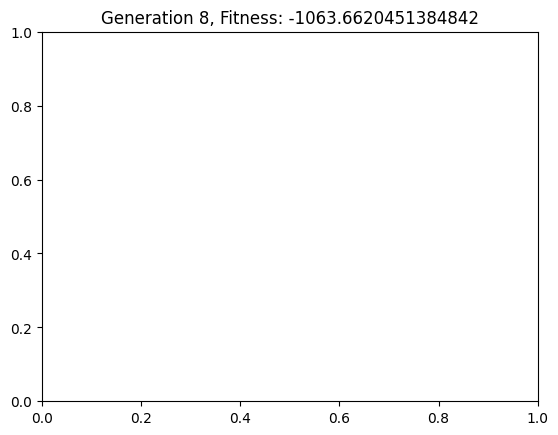

{'rooms': [{'name': 'Living Room', 'position': (314, 230), 'size': (248, 150)}, {'name': 'Bedroom1', 'position': (352, 396), 'size': (118, 224)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (471, 380), 'size': (163, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1077.4030279426586}


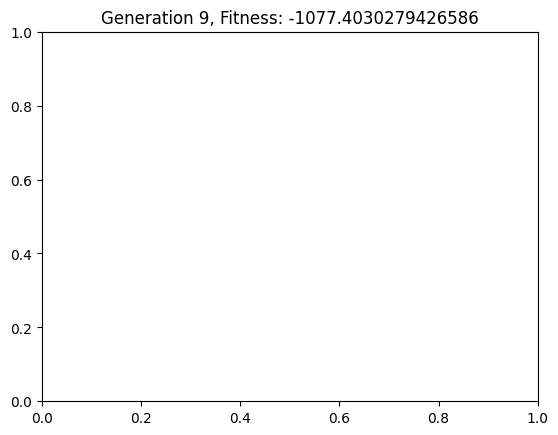

{'rooms': [{'name': 'Living Room', 'position': (310, 230), 'size': (252, 150)}, {'name': 'Bedroom1', 'position': (347, 392), 'size': (121, 228)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (468, 380), 'size': (165, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1084.6141382207163}


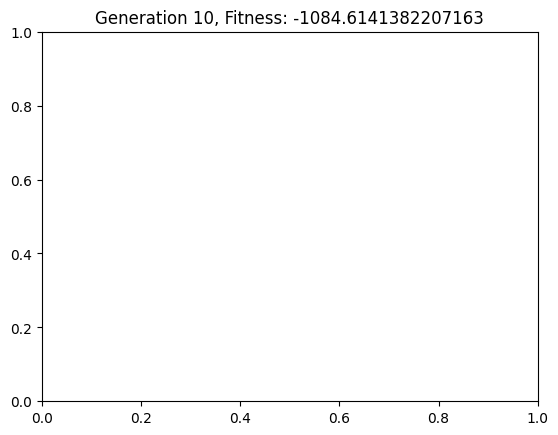

{'rooms': [{'name': 'Living Room', 'position': (306, 230), 'size': (256, 150)}, {'name': 'Bedroom1', 'position': (342, 388), 'size': (124, 232)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (466, 380), 'size': (168, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1090.9131354475678}


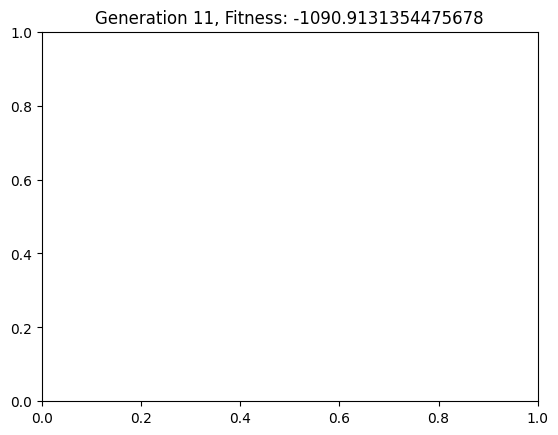

{'rooms': [{'name': 'Living Room', 'position': (302, 230), 'size': (260, 150)}, {'name': 'Bedroom1', 'position': (336, 384), 'size': (126, 236)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (463, 380), 'size': (171, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1097.42003683215}


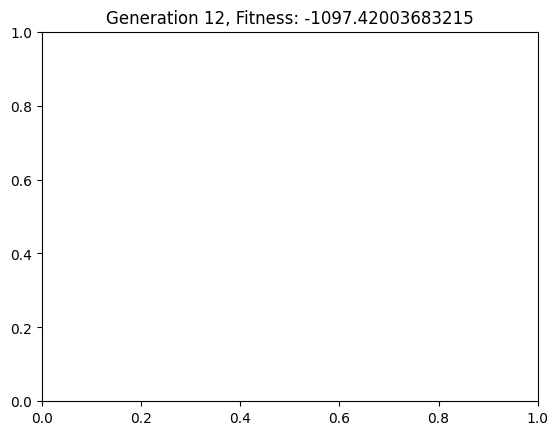

{'rooms': [{'name': 'Living Room', 'position': (298, 230), 'size': (264, 150)}, {'name': 'Bedroom1', 'position': (332, 380), 'size': (130, 240)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1102.3076001495892}


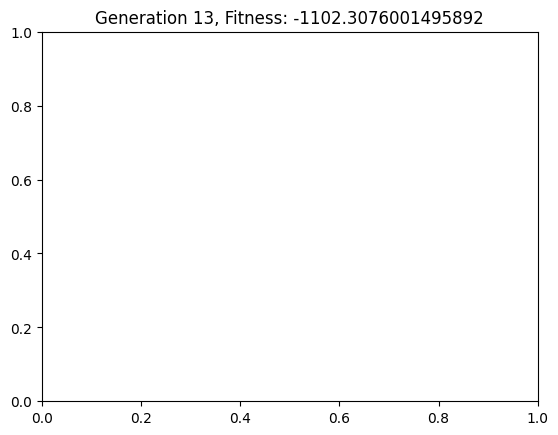

{'rooms': [{'name': 'Living Room', 'position': (294, 230), 'size': (268, 150)}, {'name': 'Bedroom1', 'position': (328, 380), 'size': (134, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1109.5064793042416}


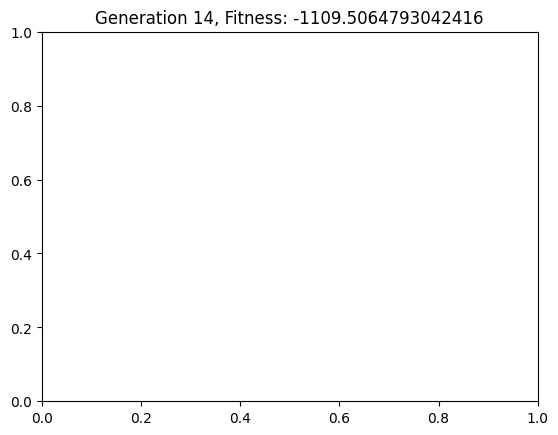

{'rooms': [{'name': 'Living Room', 'position': (290, 230), 'size': (272, 150)}, {'name': 'Bedroom1', 'position': (324, 380), 'size': (138, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1115.9722475758667}


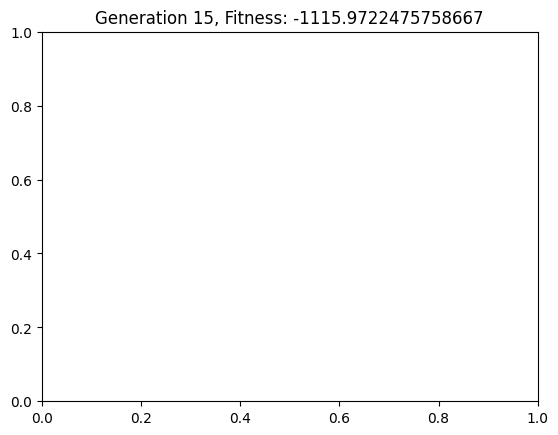

{'rooms': [{'name': 'Living Room', 'position': (286, 230), 'size': (276, 150)}, {'name': 'Bedroom1', 'position': (320, 380), 'size': (142, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1122.0153948735456}


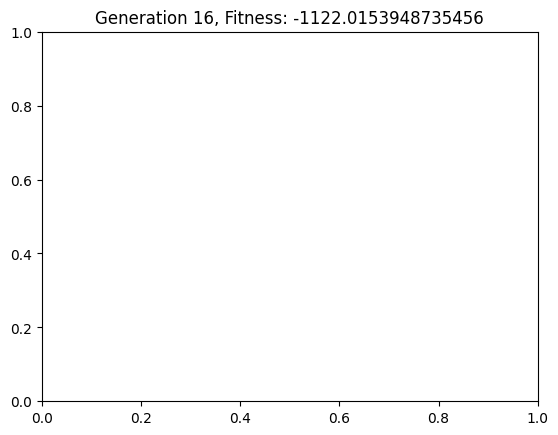

{'rooms': [{'name': 'Living Room', 'position': (282, 230), 'size': (280, 150)}, {'name': 'Bedroom1', 'position': (316, 380), 'size': (146, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1127.9442370495422}


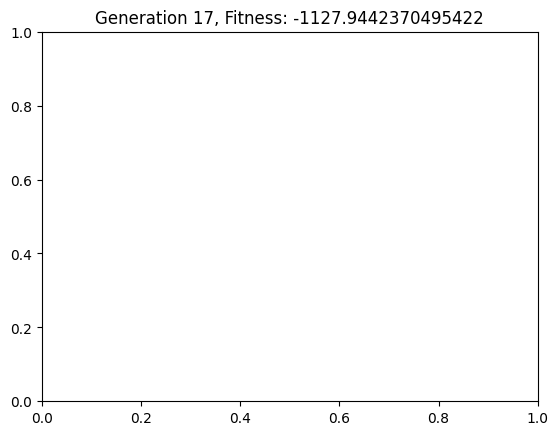

{'rooms': [{'name': 'Living Room', 'position': (278, 230), 'size': (284, 150)}, {'name': 'Bedroom1', 'position': (312, 380), 'size': (150, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1212.7749276003133}


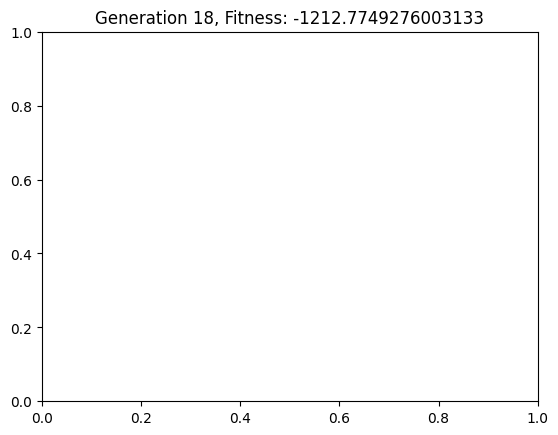

{'rooms': [{'name': 'Living Room', 'position': (274, 230), 'size': (288, 150)}, {'name': 'Bedroom1', 'position': (308, 380), 'size': (154, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1218.520544753216}


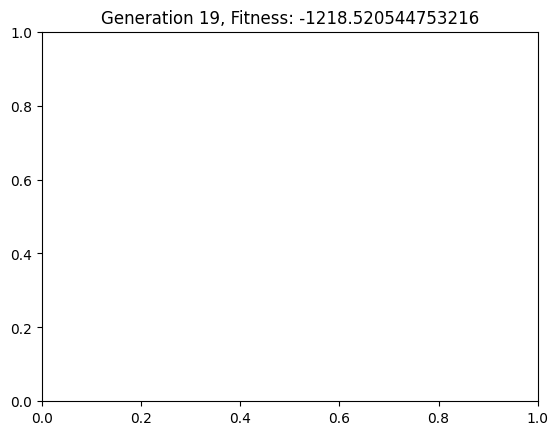

{'rooms': [{'name': 'Living Room', 'position': (270, 230), 'size': (292, 150)}, {'name': 'Bedroom1', 'position': (304, 380), 'size': (158, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1224.1918718005697}


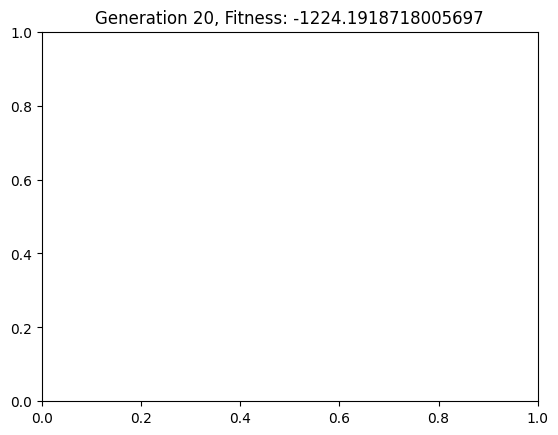

{'rooms': [{'name': 'Living Room', 'position': (266, 230), 'size': (296, 150)}, {'name': 'Bedroom1', 'position': (300, 380), 'size': (162, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1229.7979376317344}


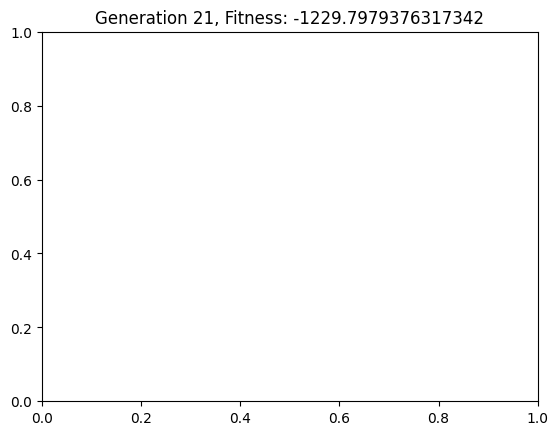

{'rooms': [{'name': 'Living Room', 'position': (262, 230), 'size': (300, 150)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}, {'name': 'Bedroom1', 'position': (296, 380), 'size': (166, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}], 'fitness': -1229.7979376317342}


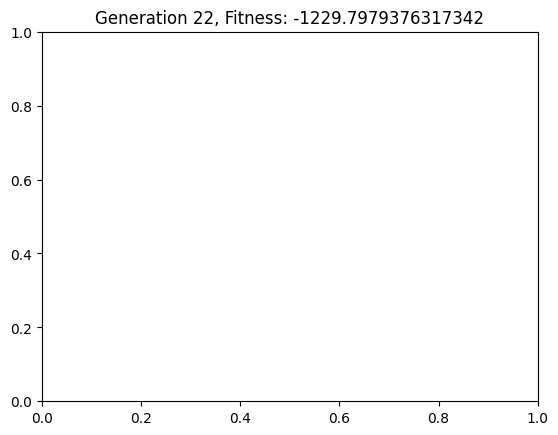

{'rooms': [{'name': 'Living Room', 'position': (258, 230), 'size': (304, 150)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}, {'name': 'Bedroom1', 'position': (292, 380), 'size': (170, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}], 'fitness': -1240.8438341912465}


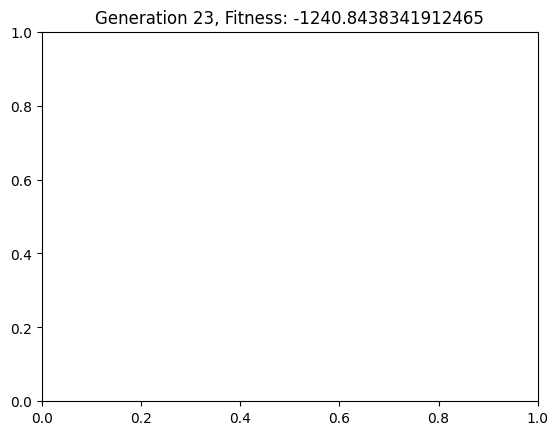

{'rooms': [{'name': 'Living Room', 'position': (254, 230), 'size': (308, 150)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}, {'name': 'Bedroom1', 'position': (288, 380), 'size': (174, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}], 'fitness': -1246.2959264643432}


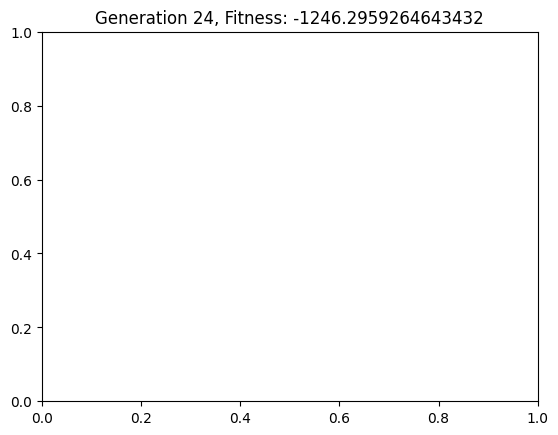

{'rooms': [{'name': 'Living Room', 'position': (250, 230), 'size': (312, 150)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}, {'name': 'Bedroom1', 'position': (284, 380), 'size': (178, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}], 'fitness': -1250.707648925328}


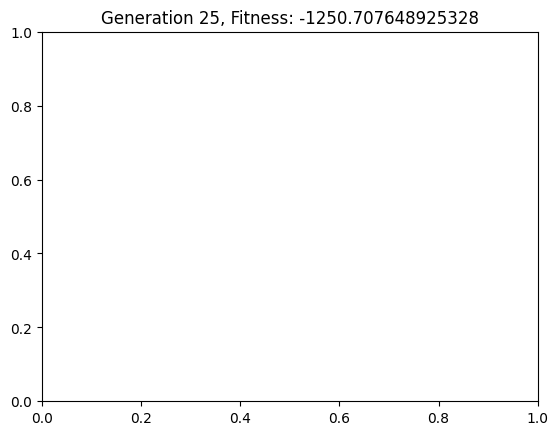

{'rooms': [{'name': 'Living Room', 'position': (246, 230), 'size': (316, 150)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}, {'name': 'Bedroom1', 'position': (280, 380), 'size': (182, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}], 'fitness': -1256.0833745615712}


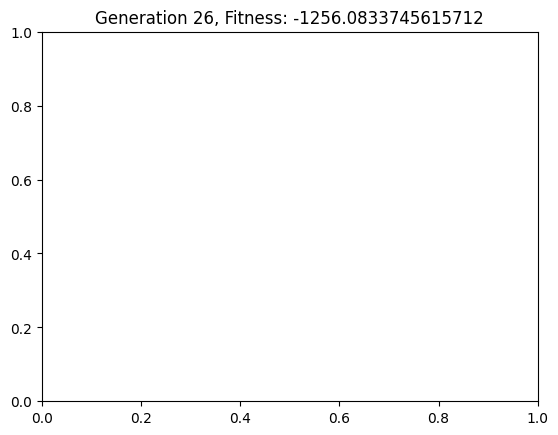

{'rooms': [{'name': 'Living Room', 'position': (242, 230), 'size': (320, 150)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}, {'name': 'Bedroom1', 'position': (276, 380), 'size': (186, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}], 'fitness': -1261.426975360826}


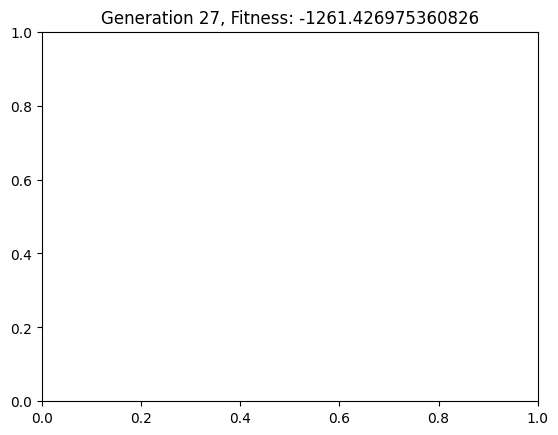

{'rooms': [{'name': 'Living Room', 'position': (238, 230), 'size': (324, 150)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}, {'name': 'Bedroom1', 'position': (272, 380), 'size': (190, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}], 'fitness': -1266.741899161727}


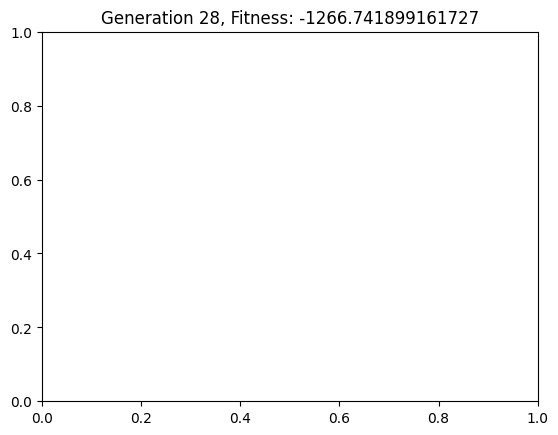

{'rooms': [{'name': 'Living Room', 'position': (234, 230), 'size': (328, 150)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}, {'name': 'Bedroom1', 'position': (268, 380), 'size': (194, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}], 'fitness': -1272.0312316008371}


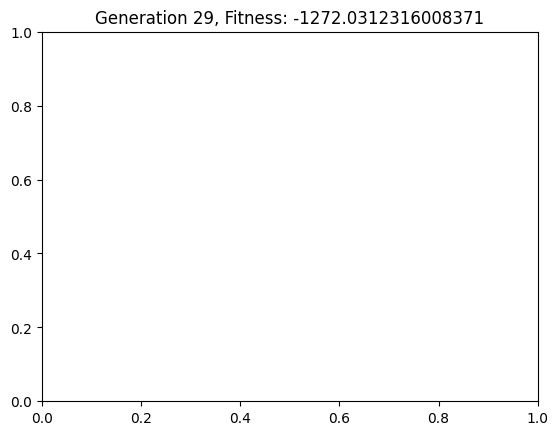

{'rooms': [{'name': 'Living Room', 'position': (230, 230), 'size': (332, 150)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}, {'name': 'Bedroom1', 'position': (264, 380), 'size': (198, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}], 'fitness': -1277.2977466107293}


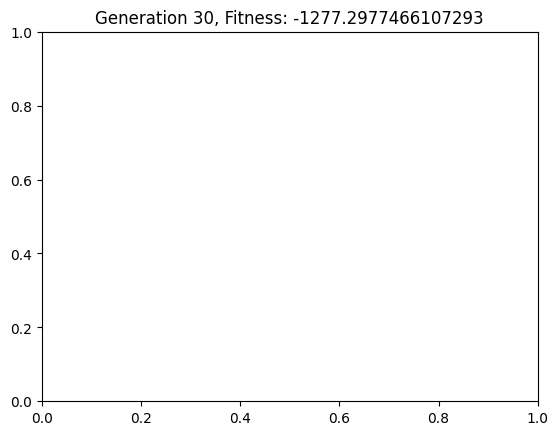

{'rooms': [{'name': 'Living Room', 'position': (226, 230), 'size': (336, 150)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}, {'name': 'Bedroom1', 'position': (260, 380), 'size': (202, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}], 'fitness': -1281.5439480051677}


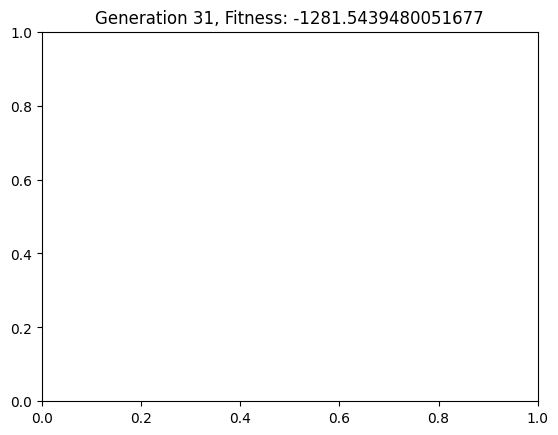

{'rooms': [{'name': 'Living Room', 'position': (222, 230), 'size': (340, 150)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}, {'name': 'Bedroom1', 'position': (256, 380), 'size': (206, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}], 'fitness': -1286.772104040818}


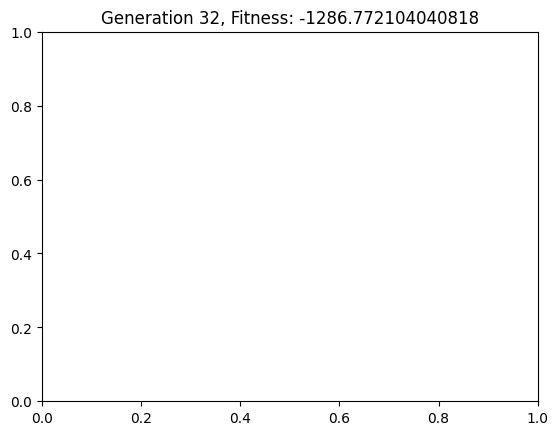

{'rooms': [{'name': 'Living Room', 'position': (218, 230), 'size': (344, 150)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}, {'name': 'Bedroom1', 'position': (252, 380), 'size': (210, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}], 'fitness': -1291.984276382399}


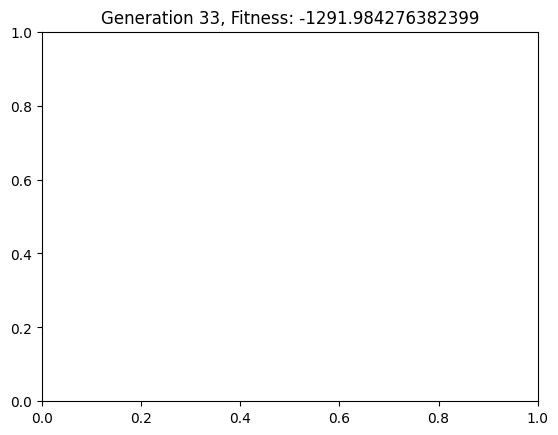

{'rooms': [{'name': 'Living Room', 'position': (215, 230), 'size': (348, 150)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}, {'name': 'Bedroom1', 'position': (248, 380), 'size': (214, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}], 'fitness': -1297.1823445625132}


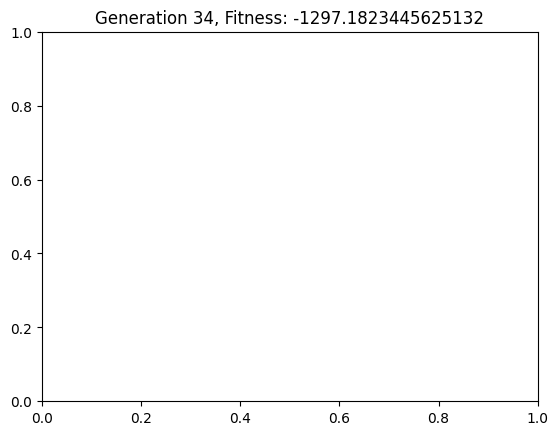

{'rooms': [{'name': 'Living Room', 'position': (215, 230), 'size': (348, 150)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}, {'name': 'Bedroom1', 'position': (244, 380), 'size': (218, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}], 'fitness': -1302.4489381066555}


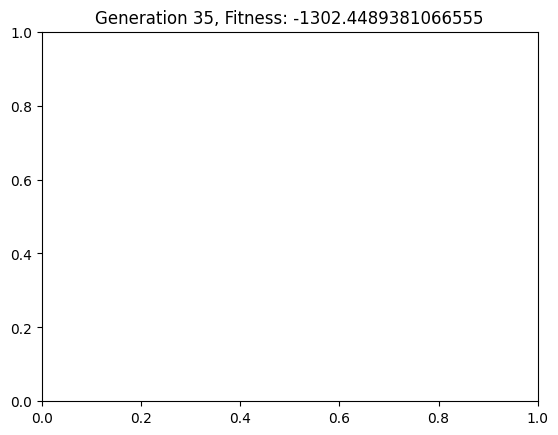

{'rooms': [{'name': 'Living Room', 'position': (215, 230), 'size': (348, 150)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}, {'name': 'Bedroom1', 'position': (240, 380), 'size': (222, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}], 'fitness': -1303.7438087273385}


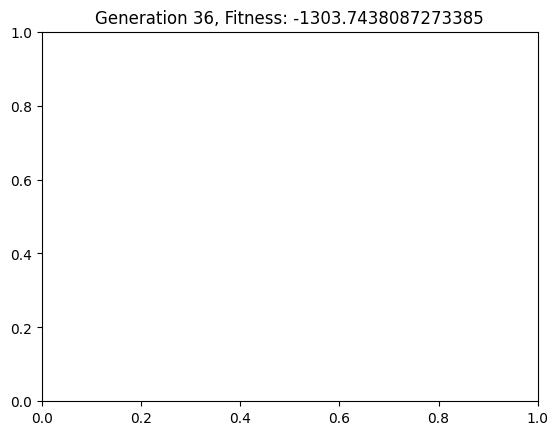

{'rooms': [{'name': 'Living Room', 'position': (215, 230), 'size': (348, 150)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}, {'name': 'Bedroom1', 'position': (236, 380), 'size': (226, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}], 'fitness': -1304.9907635932375}


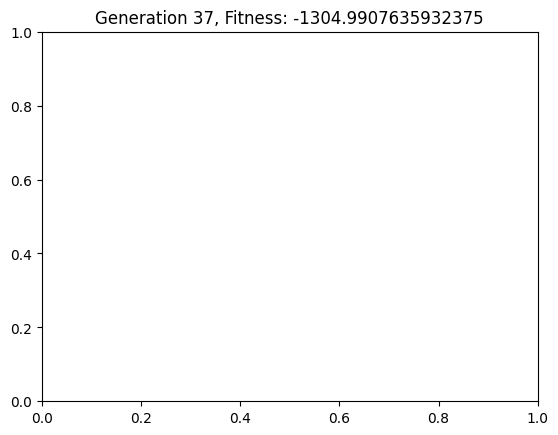

{'rooms': [{'name': 'Living Room', 'position': (215, 230), 'size': (348, 150)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}, {'name': 'Bedroom1', 'position': (232, 380), 'size': (230, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}], 'fitness': -1306.192451232727}


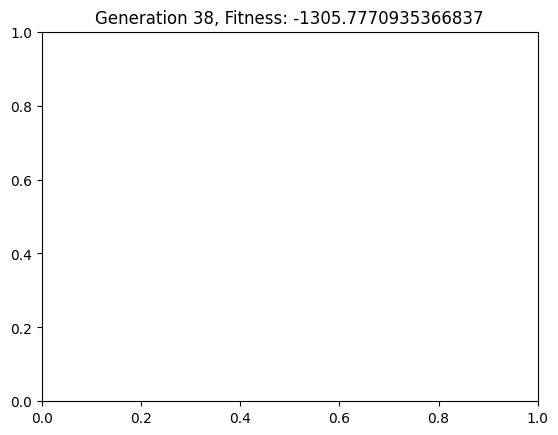

{'rooms': [{'name': 'Living Room', 'position': (215, 230), 'size': (348, 150)}, {'name': 'Bedroom1', 'position': (228, 380), 'size': (234, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1305.7770935366837}


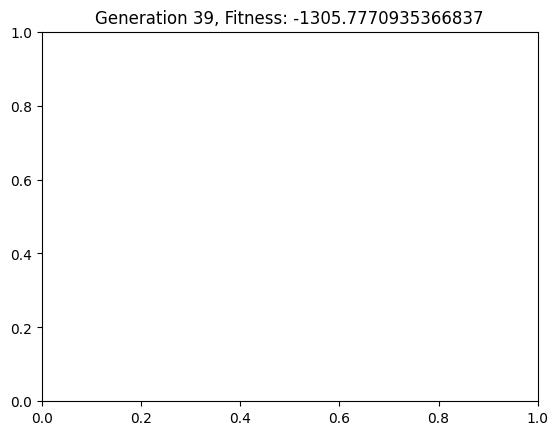

{'rooms': [{'name': 'Living Room', 'position': (215, 230), 'size': (348, 150)}, {'name': 'Bedroom1', 'position': (224, 380), 'size': (238, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1307.469659602454}


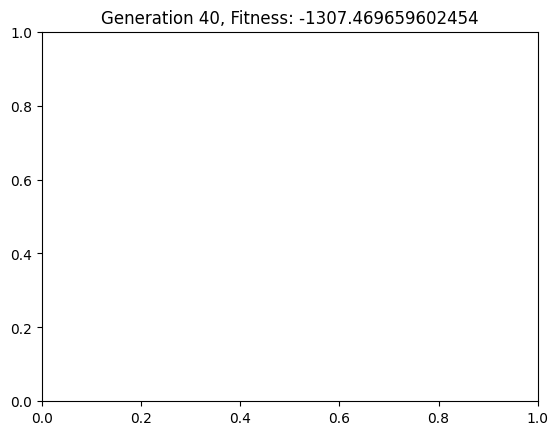

{'rooms': [{'name': 'Living Room', 'position': (215, 230), 'size': (348, 150)}, {'name': 'Bedroom1', 'position': (220, 380), 'size': (242, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1308.549570552077}


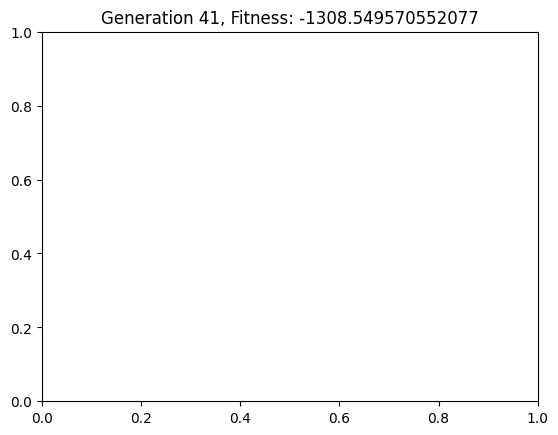

{'rooms': [{'name': 'Living Room', 'position': (215, 230), 'size': (348, 150)}, {'name': 'Bedroom1', 'position': (216, 380), 'size': (246, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1309.5730187230251}


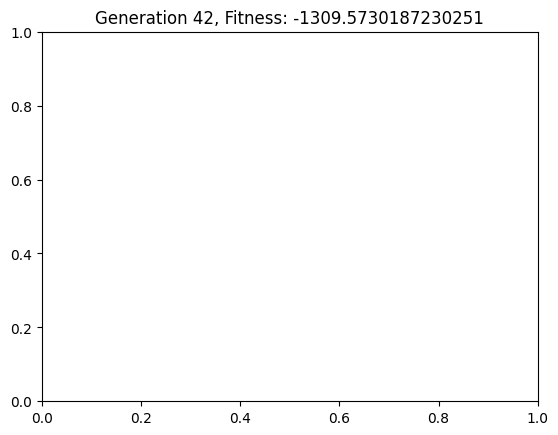

{'rooms': [{'name': 'Living Room', 'position': (215, 230), 'size': (348, 150)}, {'name': 'Bedroom1', 'position': (215, 380), 'size': (247, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1310.5026031377402}


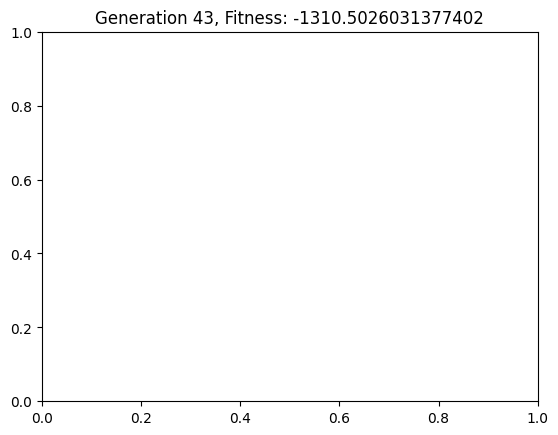

{'rooms': [{'name': 'Living Room', 'position': (215, 230), 'size': (348, 150)}, {'name': 'Bedroom1', 'position': (215, 380), 'size': (247, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1310.729974174175}


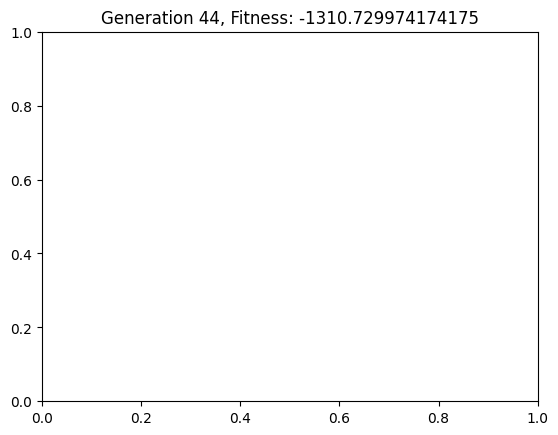

{'rooms': [{'name': 'Living Room', 'position': (215, 230), 'size': (348, 150)}, {'name': 'Bedroom1', 'position': (215, 380), 'size': (247, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1310.729974174175}


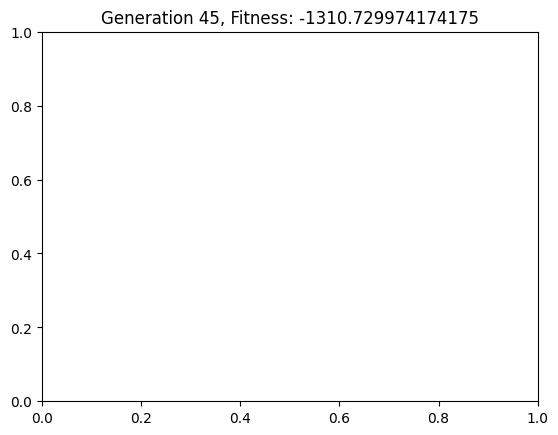

{'rooms': [{'name': 'Living Room', 'position': (215, 230), 'size': (348, 150)}, {'name': 'Bedroom1', 'position': (215, 380), 'size': (247, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1310.729974174175}


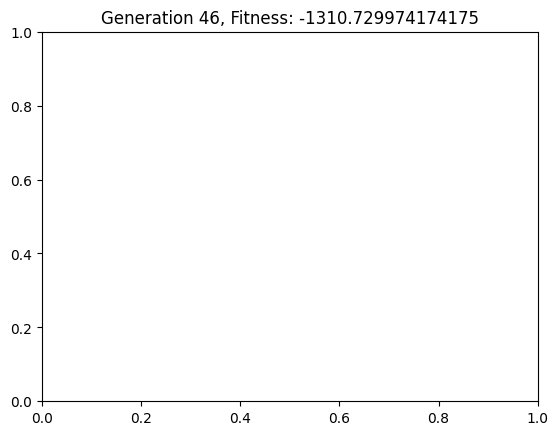

{'rooms': [{'name': 'Living Room', 'position': (215, 230), 'size': (348, 150)}, {'name': 'Bedroom1', 'position': (215, 380), 'size': (247, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1310.729974174175}


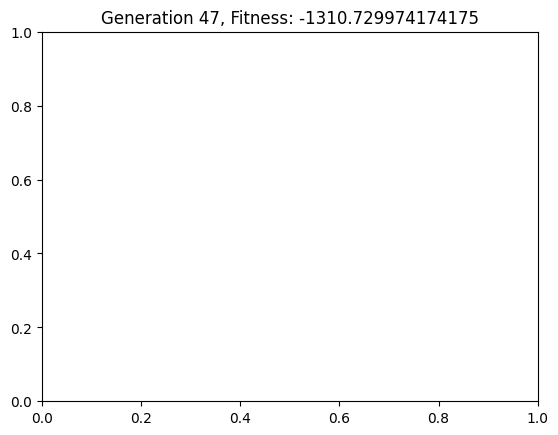

{'rooms': [{'name': 'Living Room', 'position': (215, 230), 'size': (348, 150)}, {'name': 'Bedroom1', 'position': (215, 380), 'size': (247, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1310.729974174175}


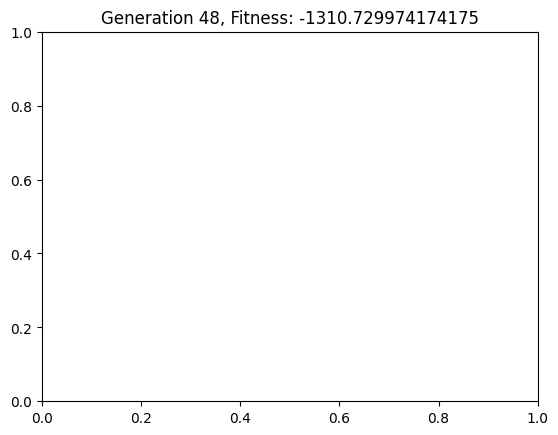

{'rooms': [{'name': 'Living Room', 'position': (215, 230), 'size': (348, 150)}, {'name': 'Bedroom1', 'position': (215, 380), 'size': (247, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1310.729974174175}


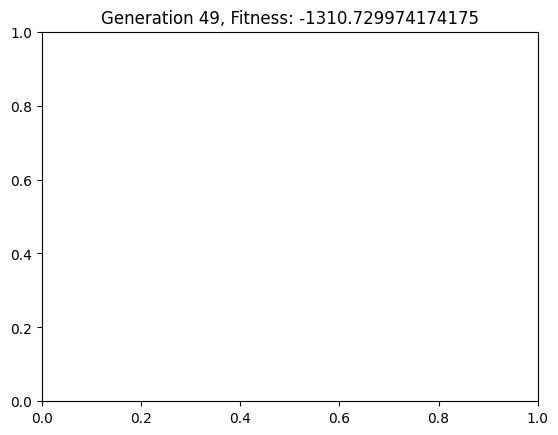

{'rooms': [{'name': 'Living Room', 'position': (215, 230), 'size': (348, 150)}, {'name': 'Bedroom1', 'position': (215, 380), 'size': (247, 241)}, {'name': 'Bedroom2', 'position': (634, 408), 'size': (168, 102)}, {'name': 'Passage', 'position': (462, 380), 'size': (172, 108)}, {'name': 'Kitchen', 'position': (565, 299), 'size': (151, 80)}, {'name': 'Washroom', 'position': (563, 286), 'size': (55, 93)}], 'fitness': -1310.729974174175}
Elapsed time: 812.06 seconds


<Figure size 640x480 with 0 Axes>

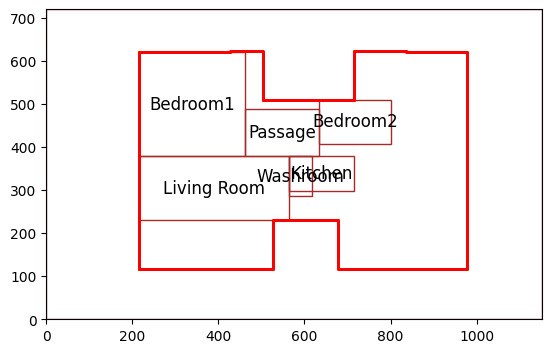

Elapsed time for initial population generation: 40.62 seconds


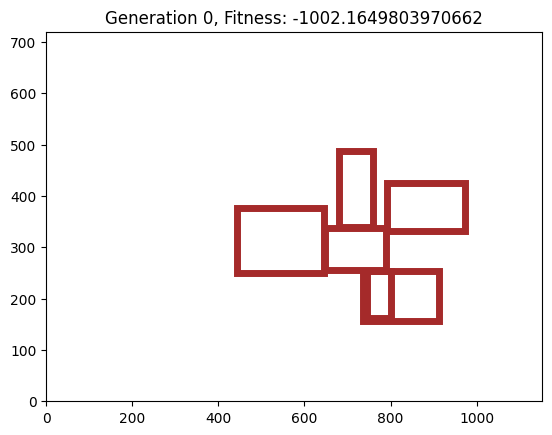

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


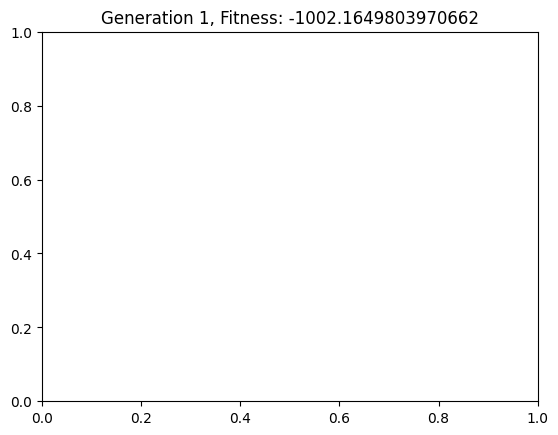

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


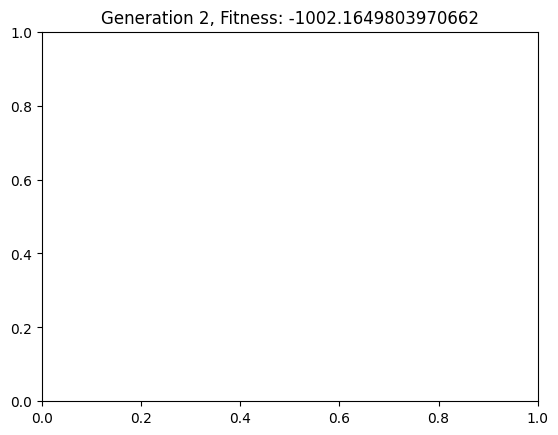

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


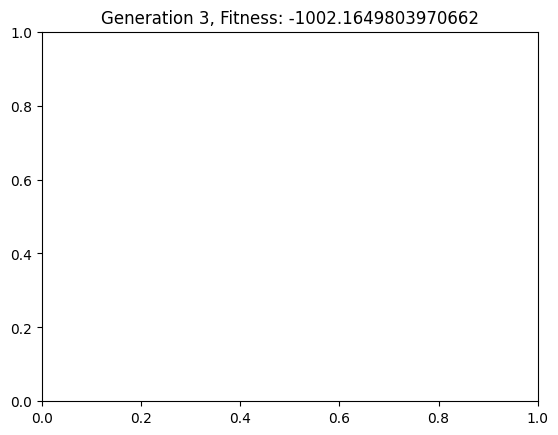

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


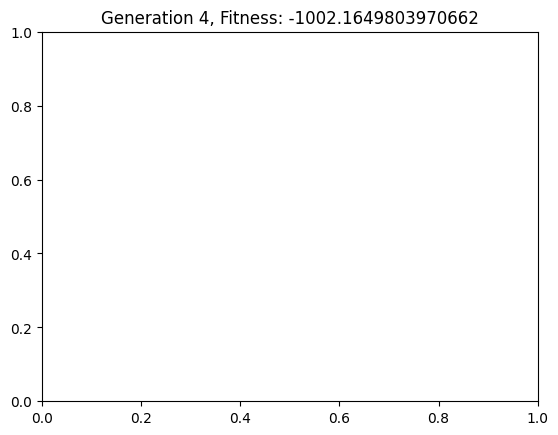

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


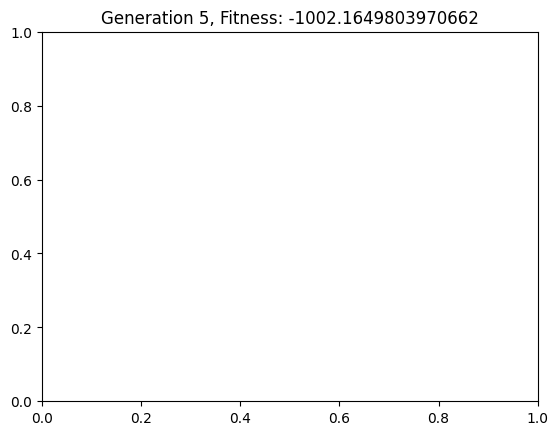

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


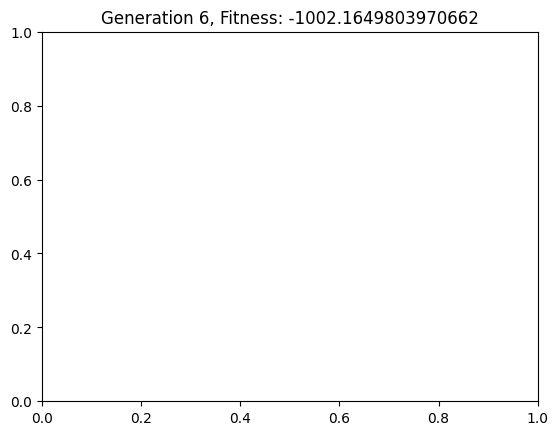

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


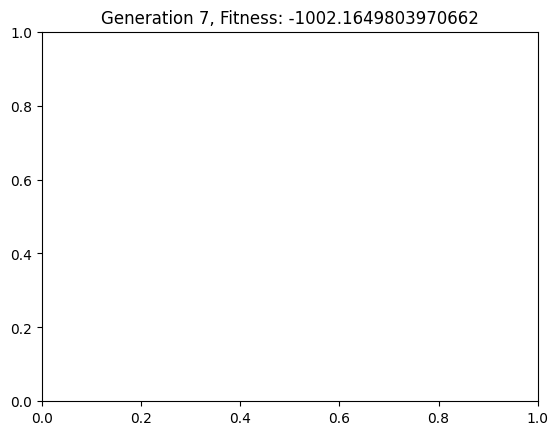

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


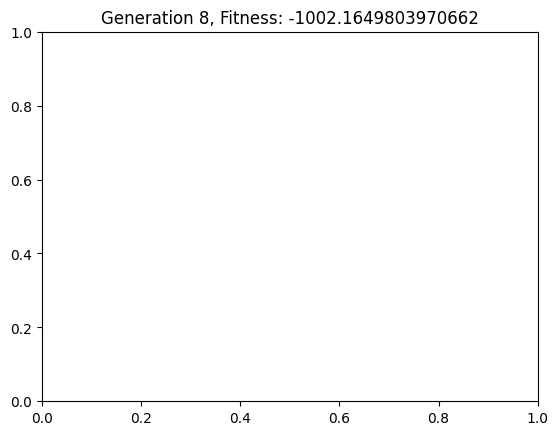

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


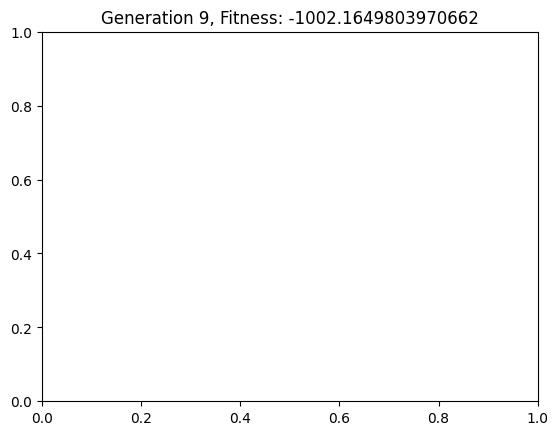

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


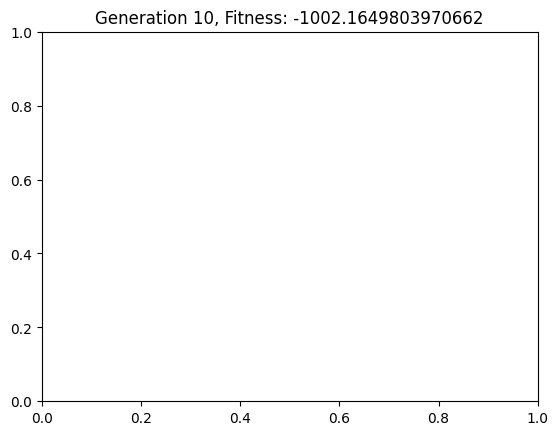

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


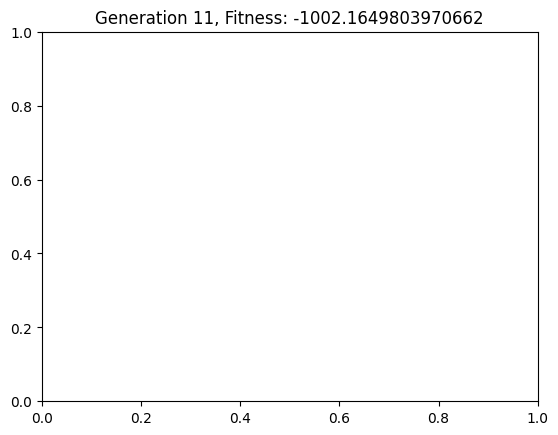

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


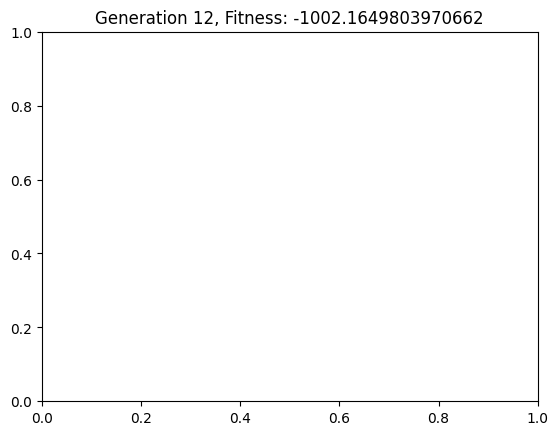

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


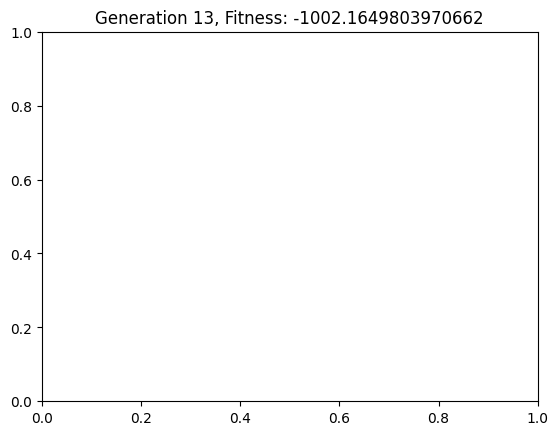

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


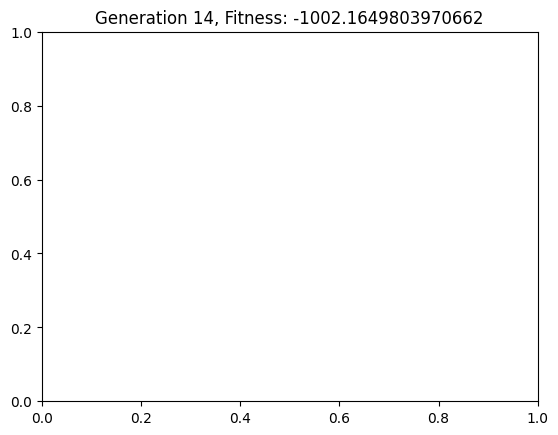

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


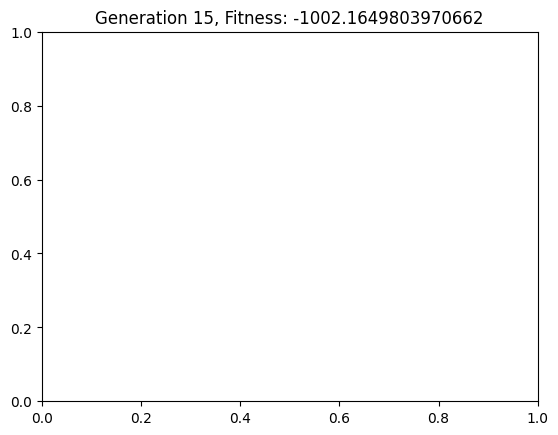

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


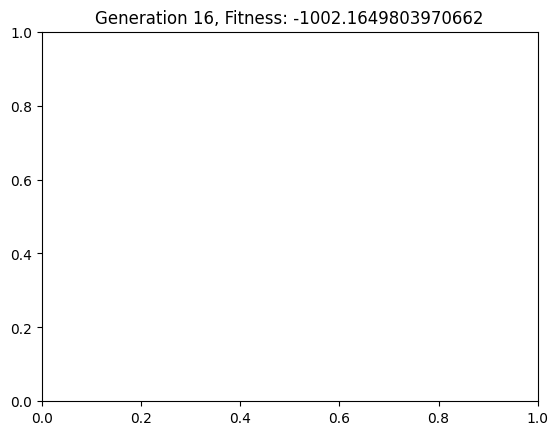

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


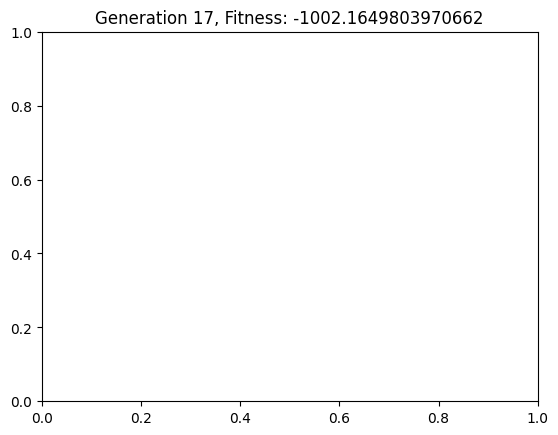

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


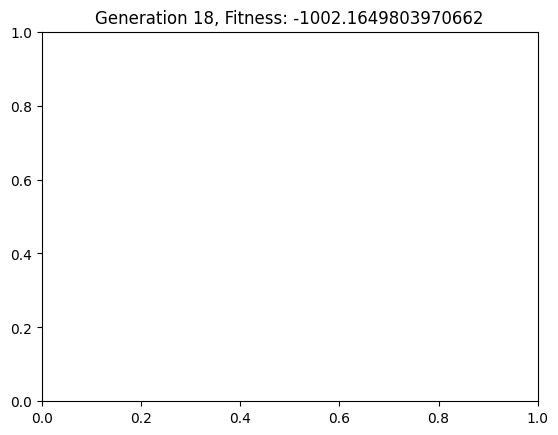

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


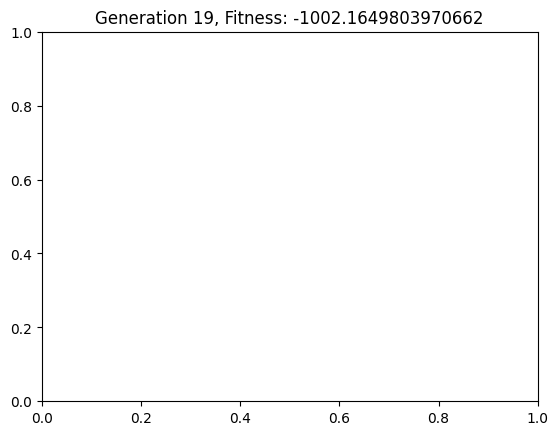

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


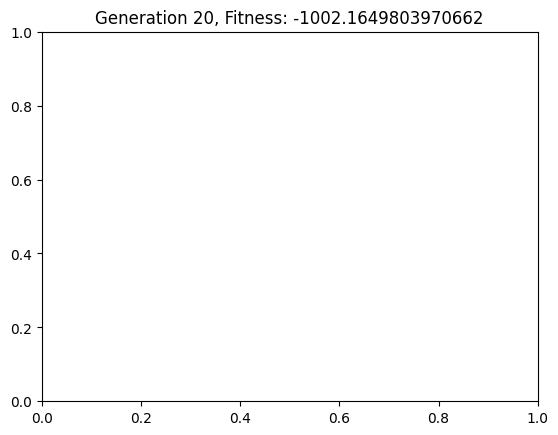

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


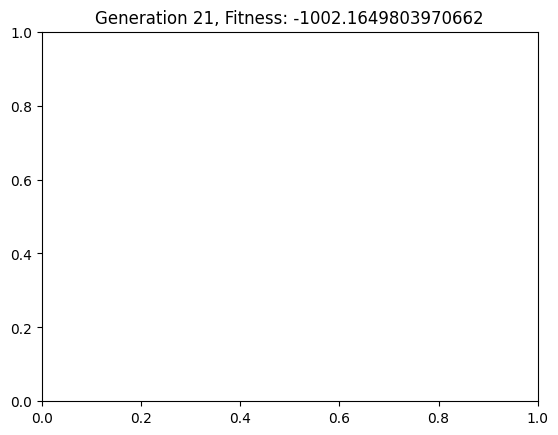

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


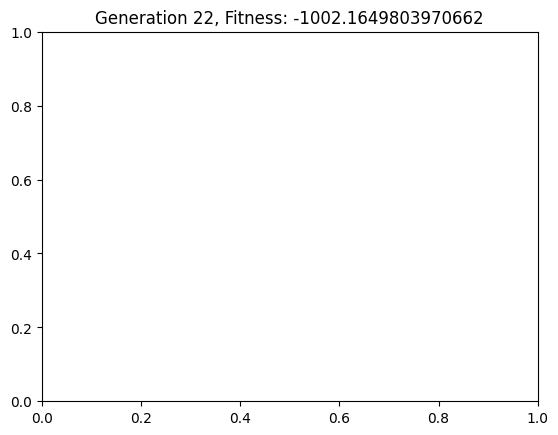

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


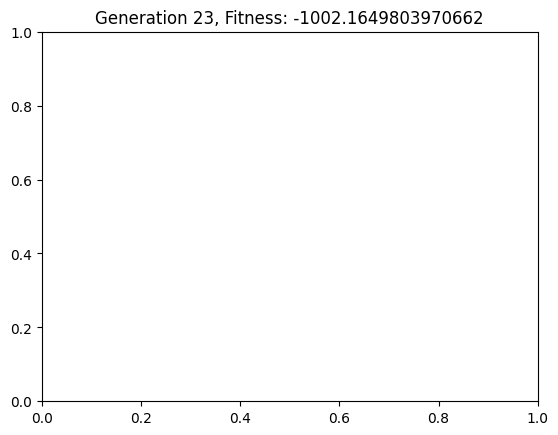

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


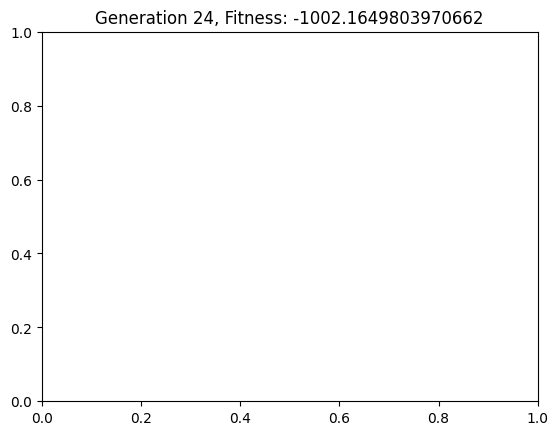

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


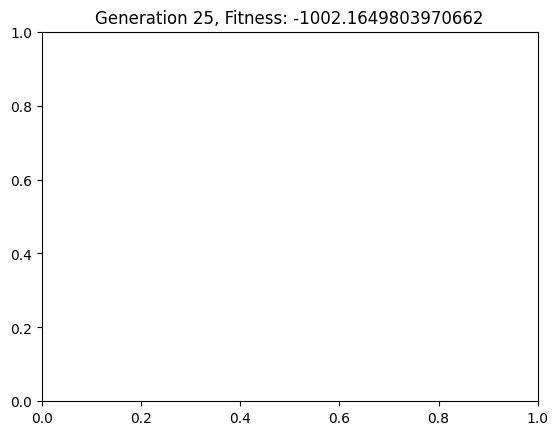

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


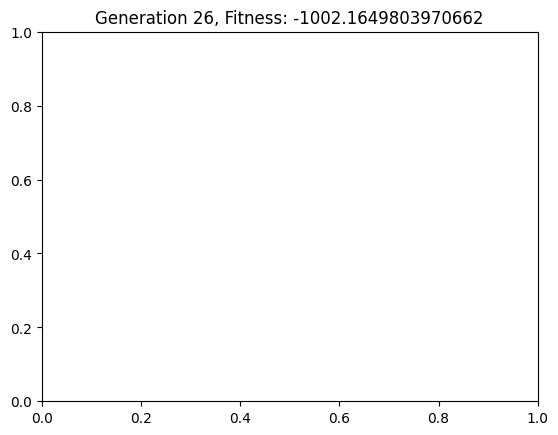

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


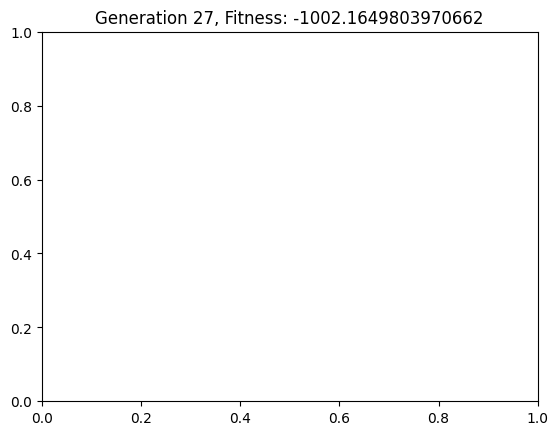

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


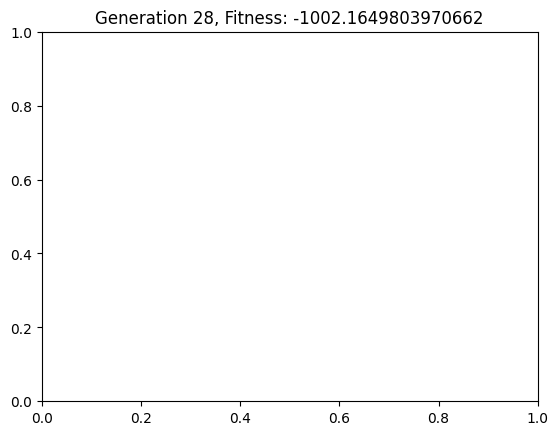

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


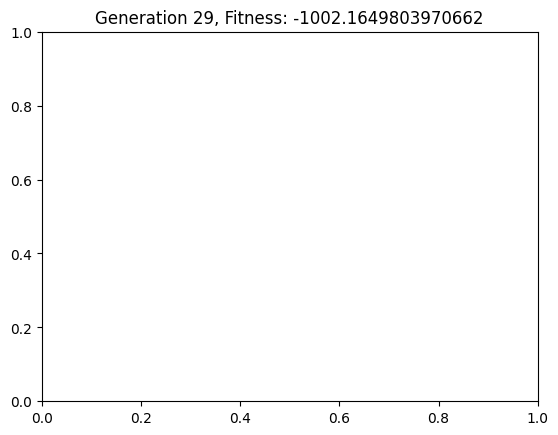

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


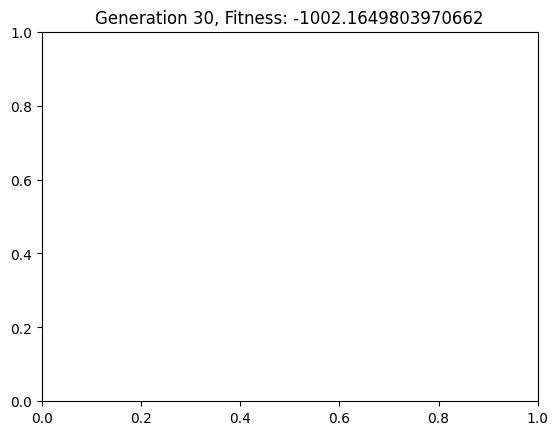

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


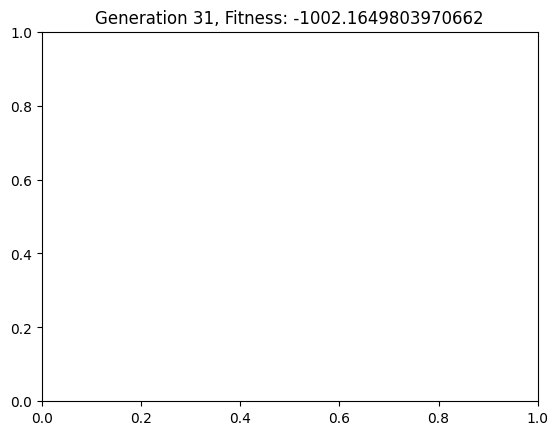

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


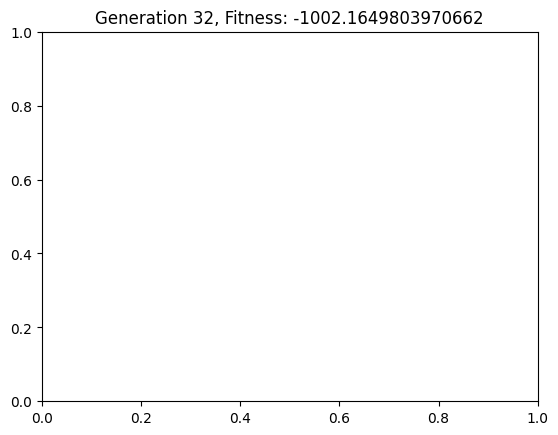

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


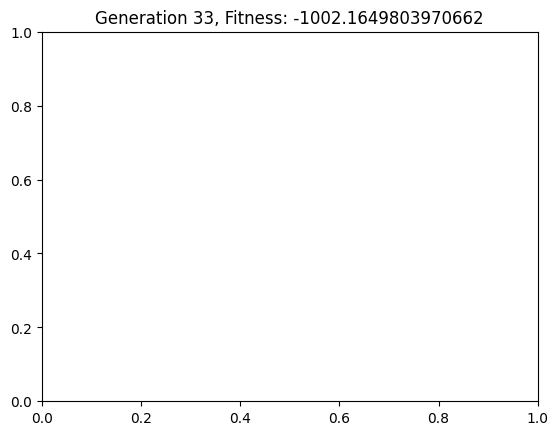

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


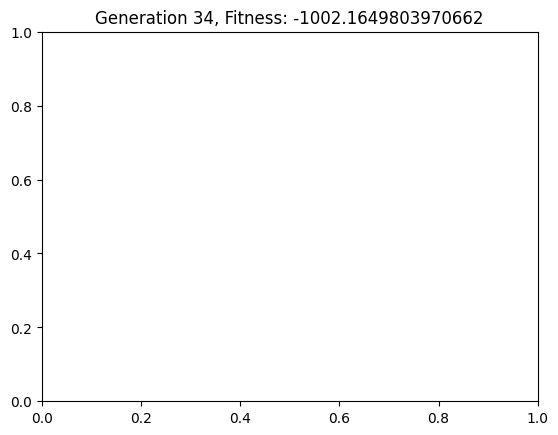

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


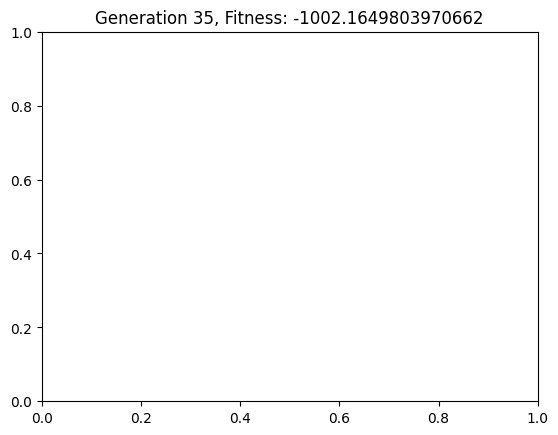

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


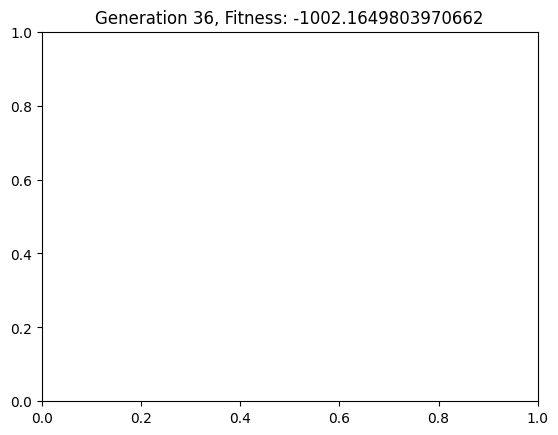

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


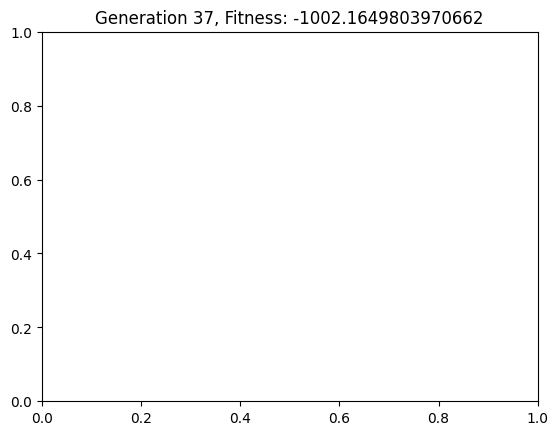

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


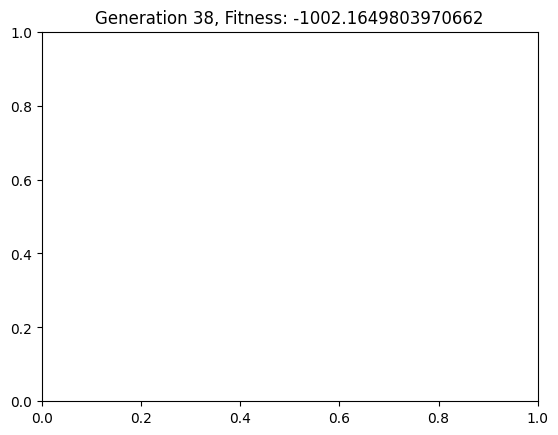

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


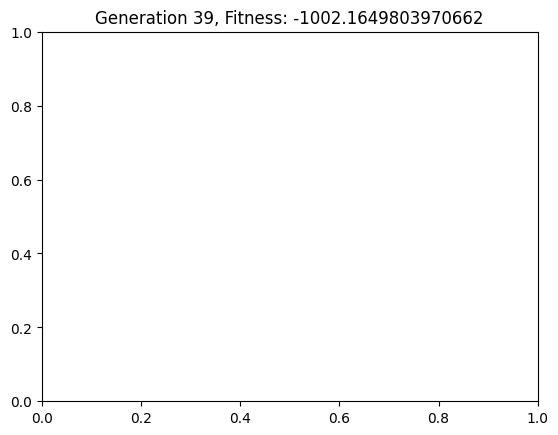

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


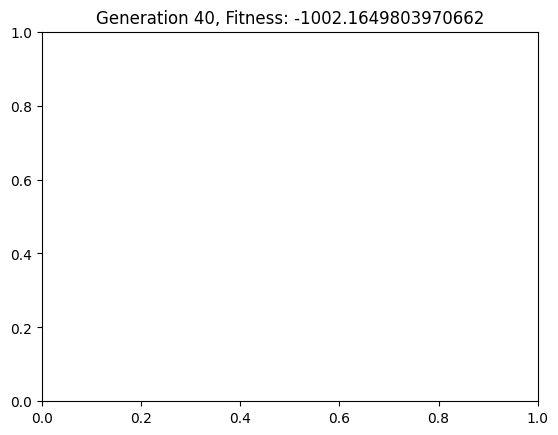

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


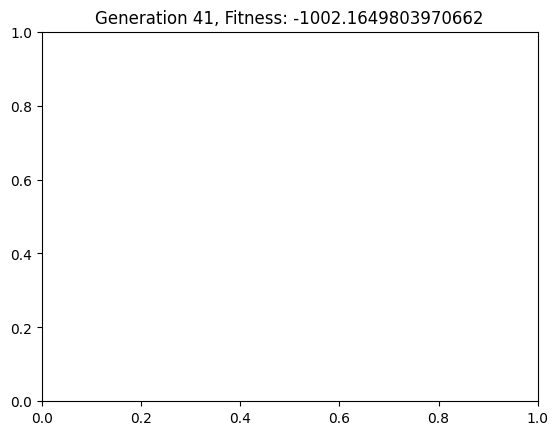

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


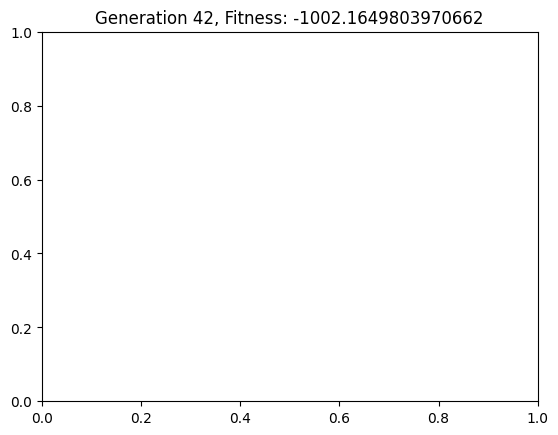

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


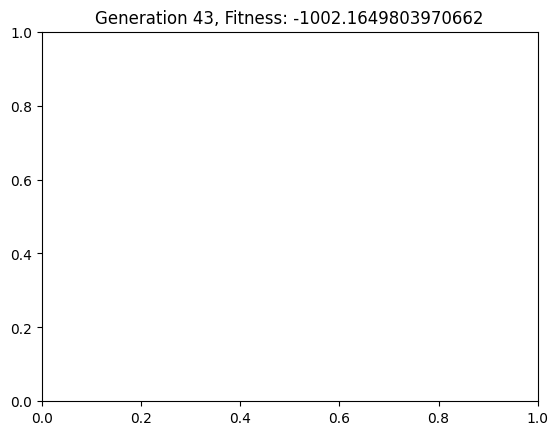

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


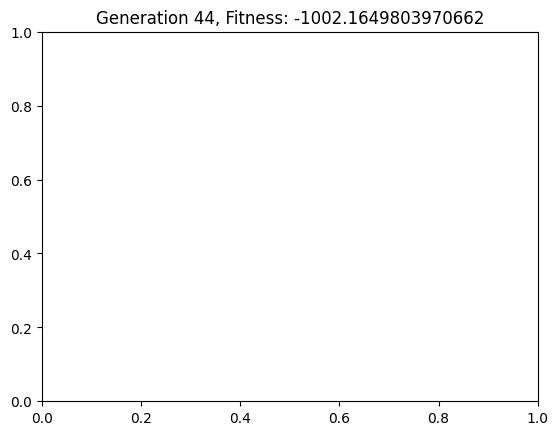

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


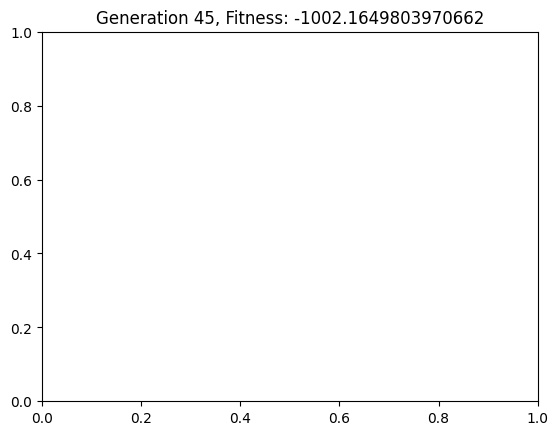

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


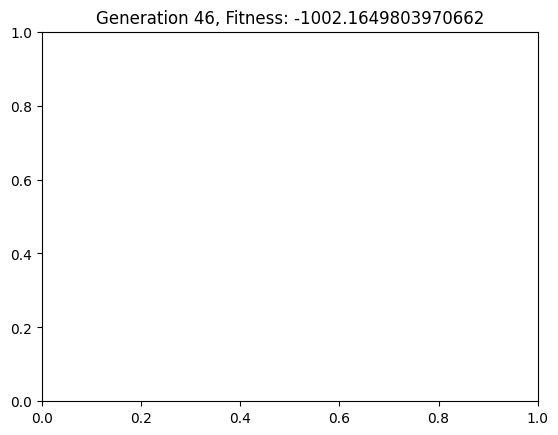

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


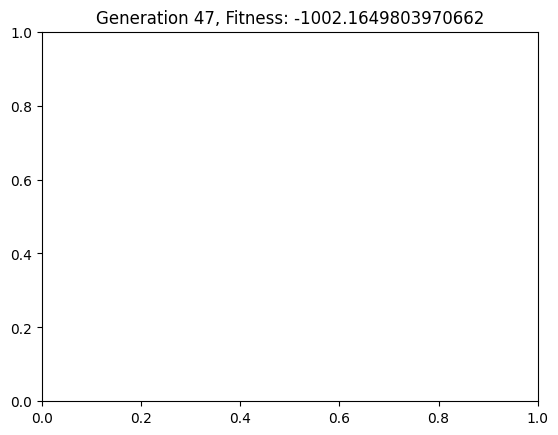

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


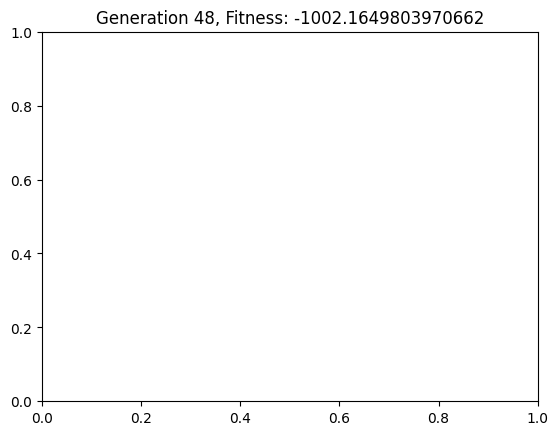

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}


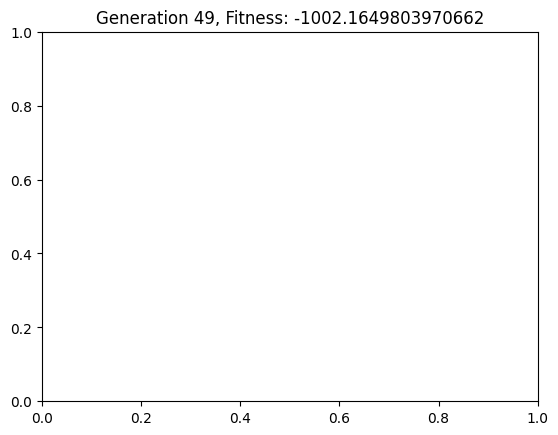

{'rooms': [{'name': 'Living Room', 'position': (443, 249), 'size': (203, 127)}, {'name': 'Passage', 'position': (647, 255), 'size': (143, 83)}, {'name': 'Kitchen', 'position': (680, 339), 'size': (79, 149)}, {'name': 'Washroom', 'position': (745, 162), 'size': (55, 92)}, {'name': 'Bedroom1', 'position': (736, 157), 'size': (177, 97)}, {'name': 'Bedroom2', 'position': (791, 332), 'size': (182, 94)}], 'fitness': -1002.1649803970662}
Elapsed time: 752.48 seconds


<Figure size 640x480 with 0 Axes>

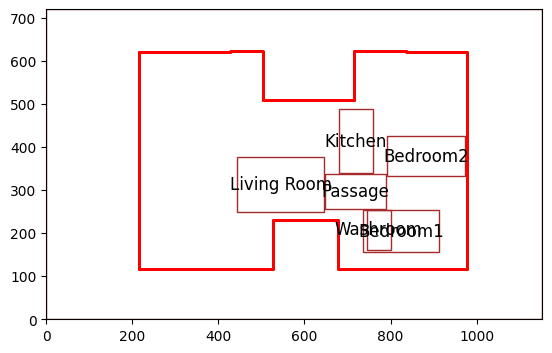

Elapsed time for initial population generation: 39.79 seconds


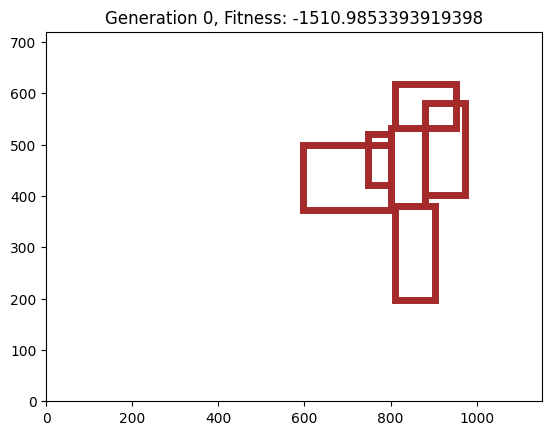

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Passage', 'position': (801, 381), 'size': (79, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (810, 198), 'size': (94, 182)}], 'fitness': -1510.9853393919398}


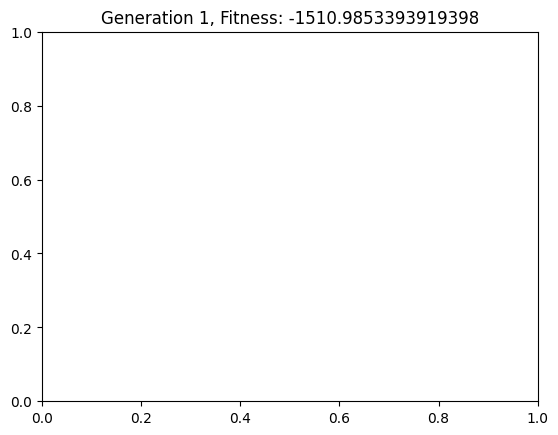

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Passage', 'position': (800, 381), 'size': (80, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (810, 197), 'size': (96, 183)}], 'fitness': -1510.9853393919398}


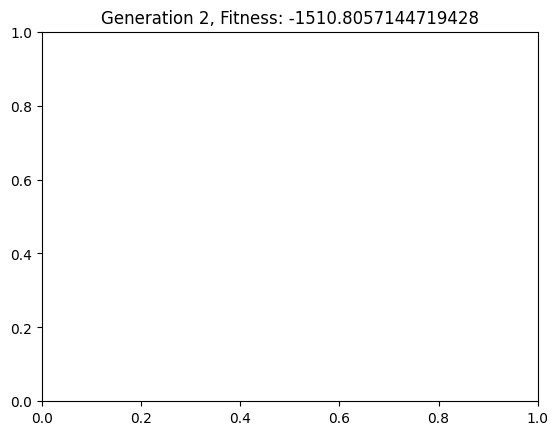

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (810, 195), 'size': (100, 185)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1510.8057144719428}


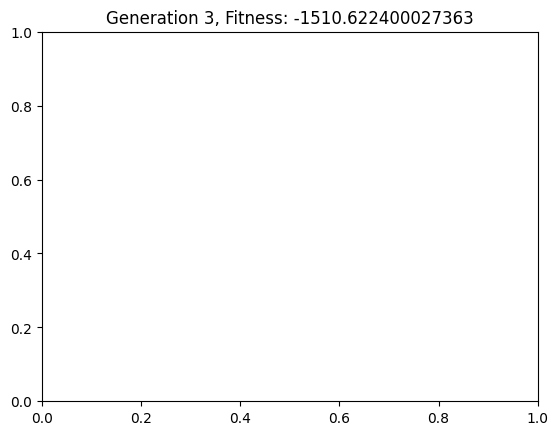

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (810, 191), 'size': (108, 189)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1510.622400027363}


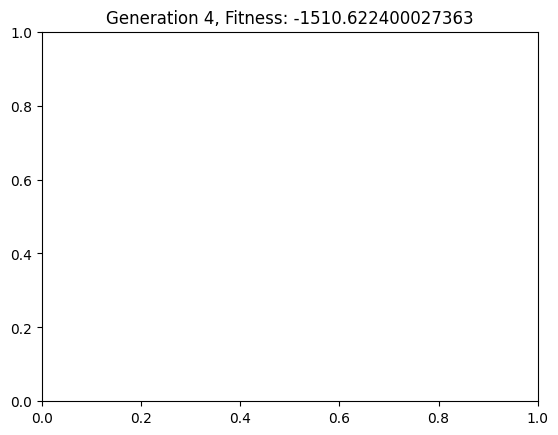

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (810, 187), 'size': (116, 193)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1510.622400027363}


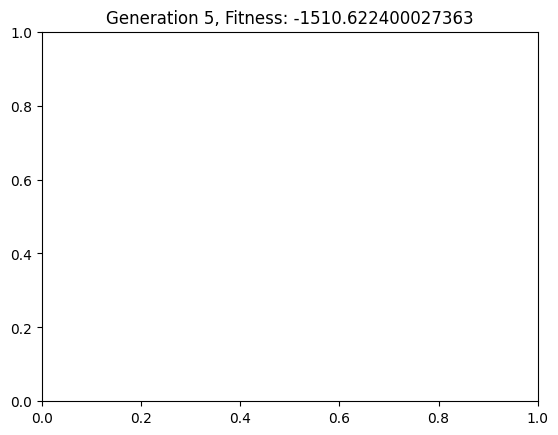

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (810, 183), 'size': (124, 197)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1510.622400027363}


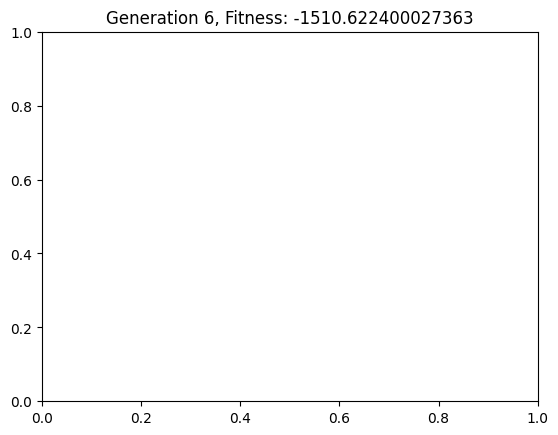

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (810, 179), 'size': (132, 201)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1510.622400027363}


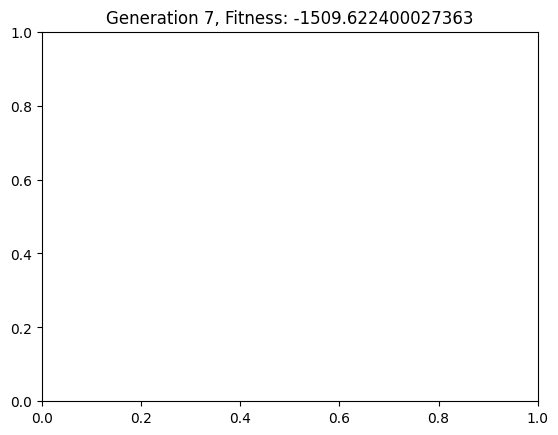

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (810, 175), 'size': (140, 205)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1509.622400027363}


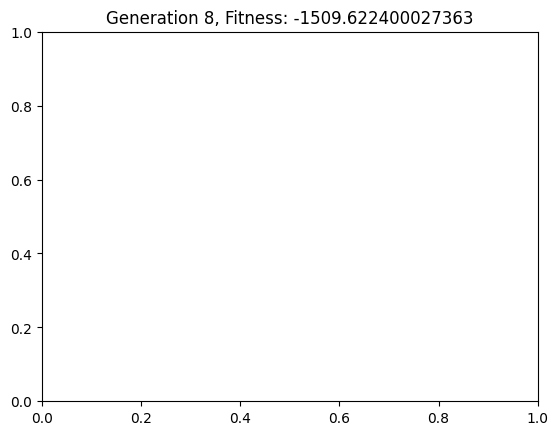

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (810, 171), 'size': (148, 209)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1509.622400027363}


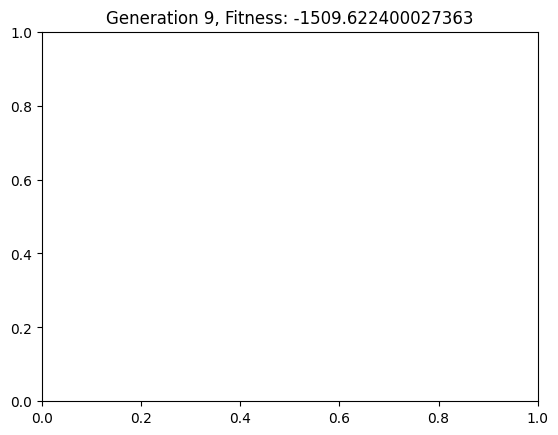

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (810, 167), 'size': (156, 213)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1509.622400027363}


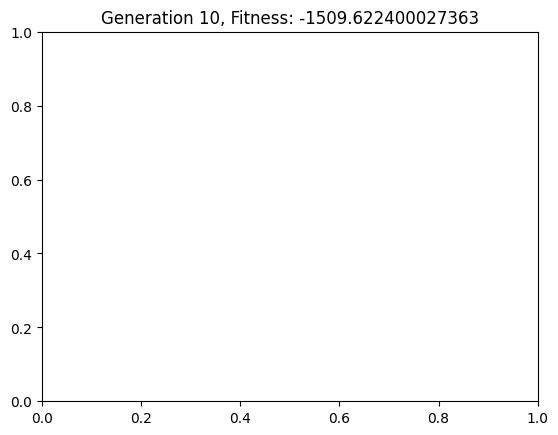

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (810, 163), 'size': (164, 217)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1509.622400027363}


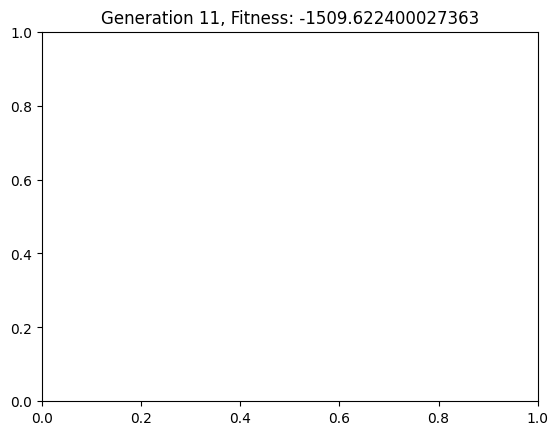

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (807, 159), 'size': (169, 221)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1509.622400027363}


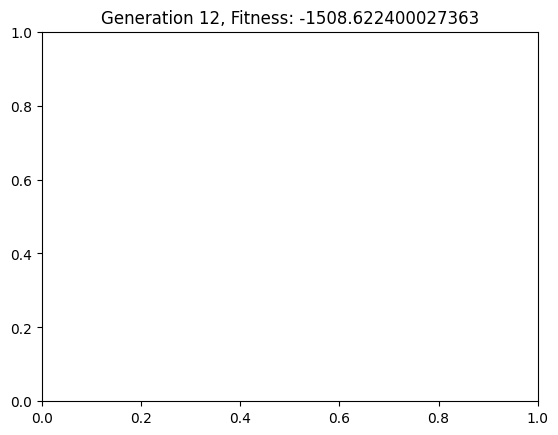

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (803, 155), 'size': (173, 225)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1508.622400027363}


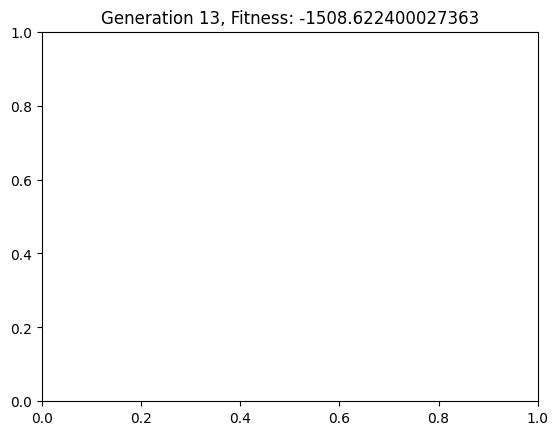

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 151), 'size': (177, 229)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1508.622400027363}


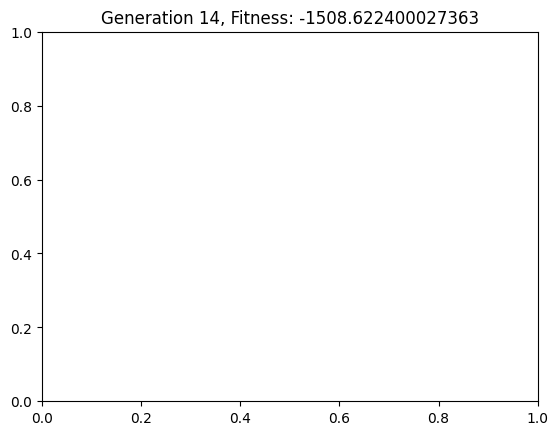

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 147), 'size': (177, 233)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1508.622400027363}


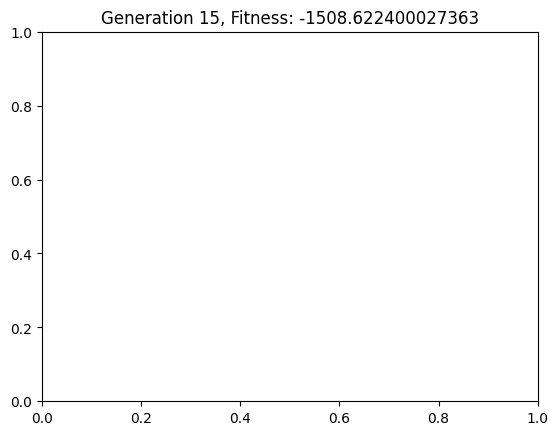

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 143), 'size': (177, 237)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1508.622400027363}


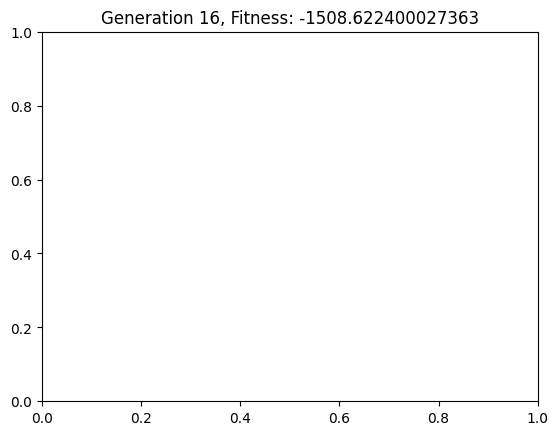

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 139), 'size': (177, 241)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1508.622400027363}


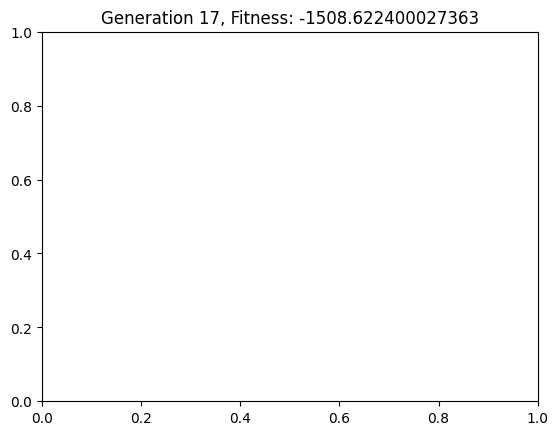

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 135), 'size': (177, 245)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1508.622400027363}


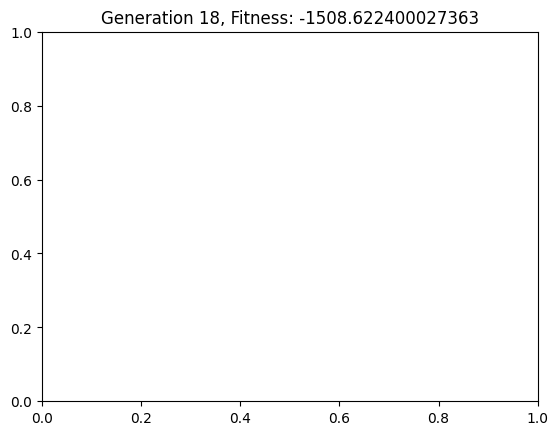

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 131), 'size': (177, 249)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1508.622400027363}


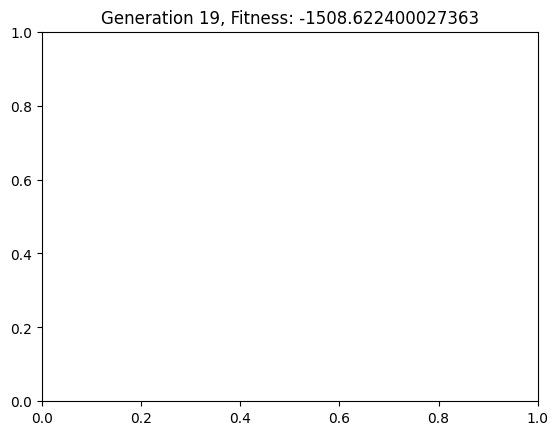

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 127), 'size': (177, 253)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1508.622400027363}


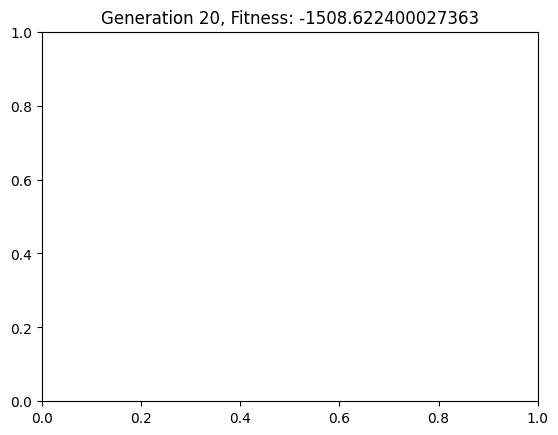

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 123), 'size': (177, 257)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1508.622400027363}


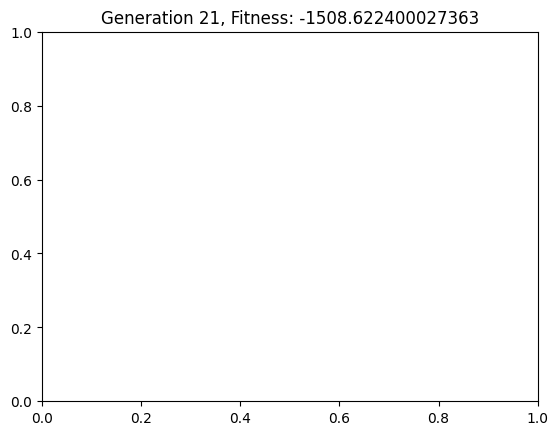

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 119), 'size': (177, 261)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1508.622400027363}


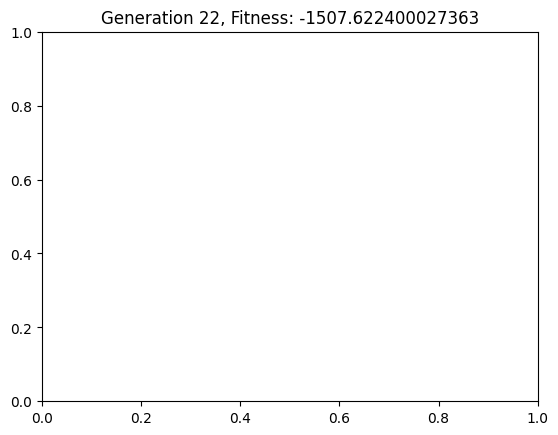

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


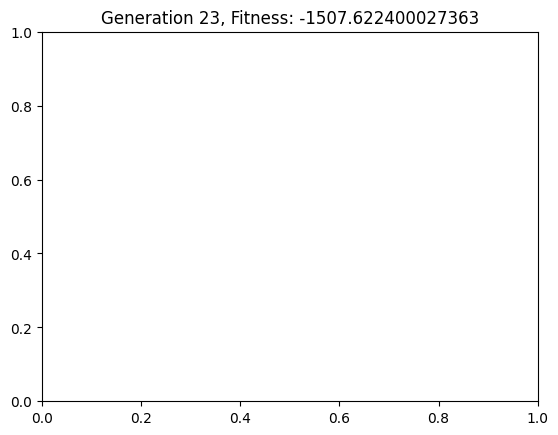

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


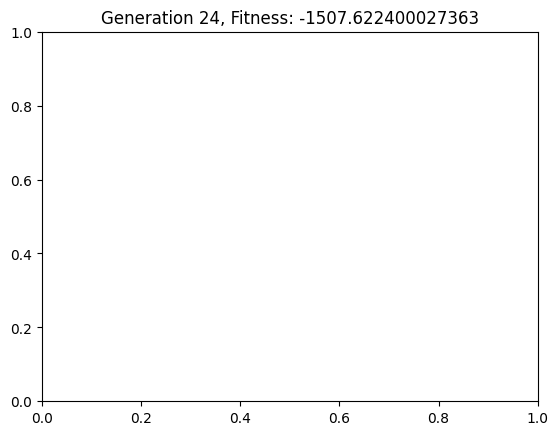

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


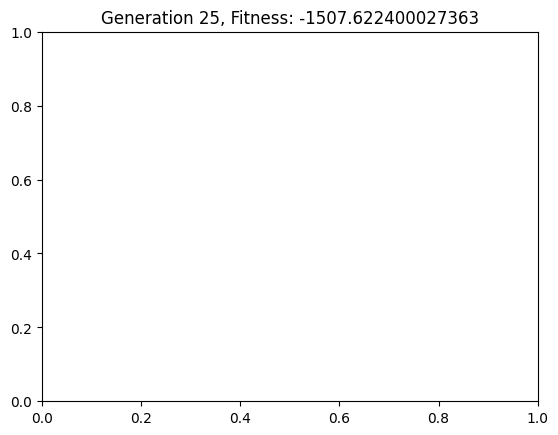

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


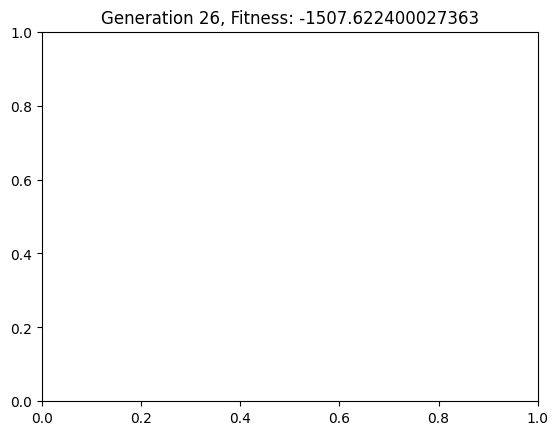

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


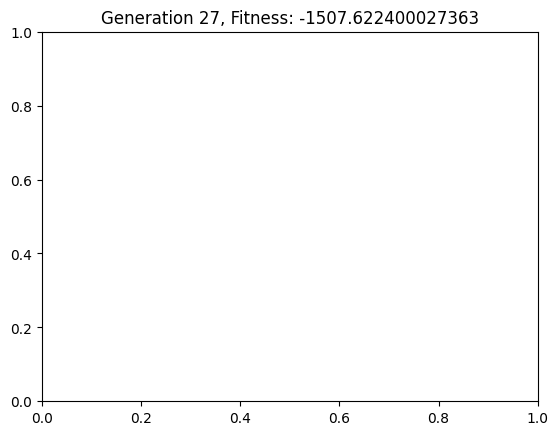

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


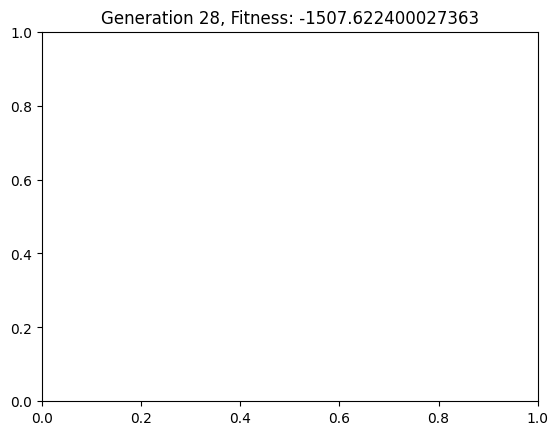

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


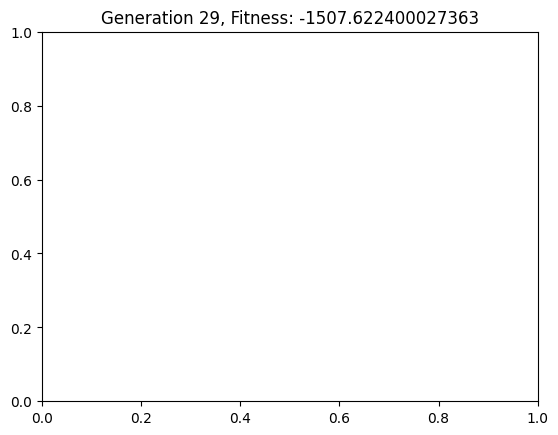

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


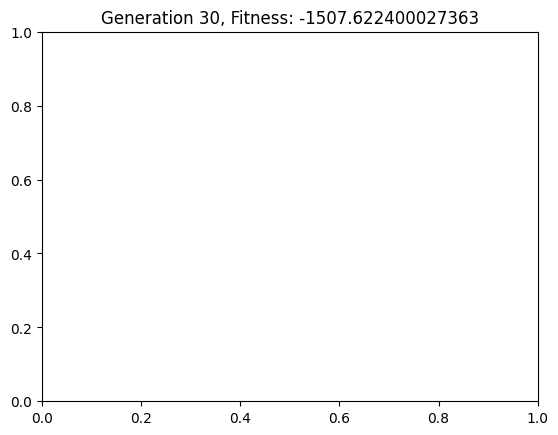

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


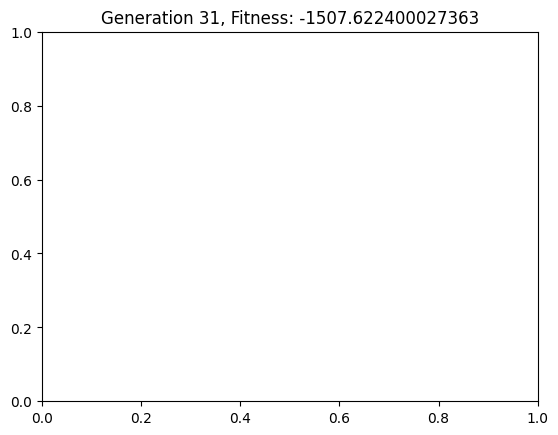

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


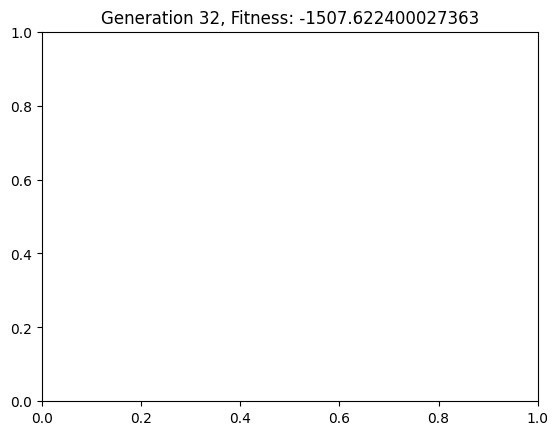

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


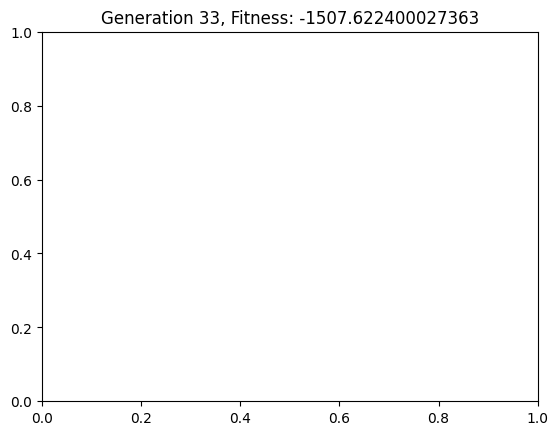

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


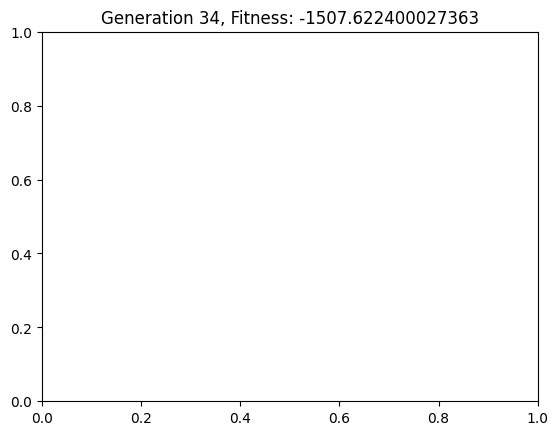

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


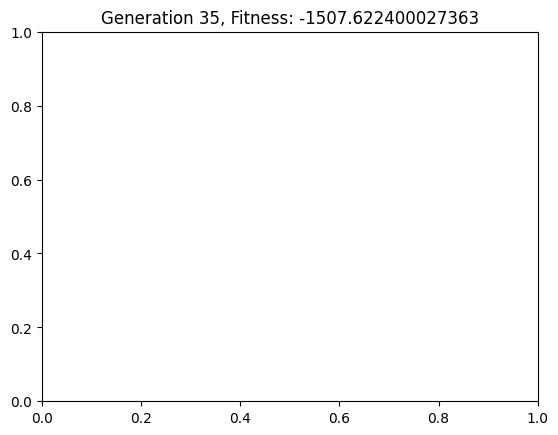

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


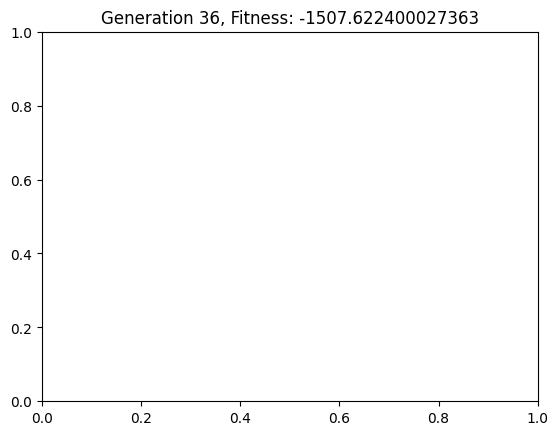

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


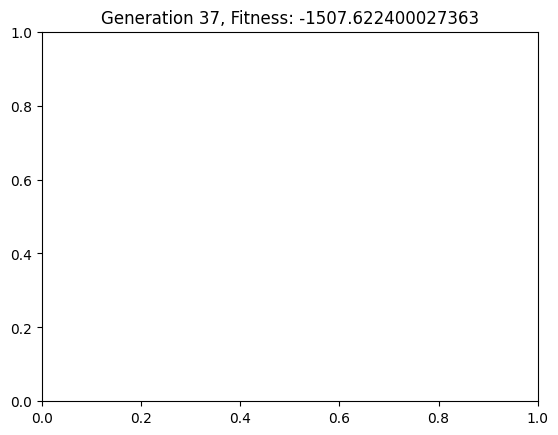

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


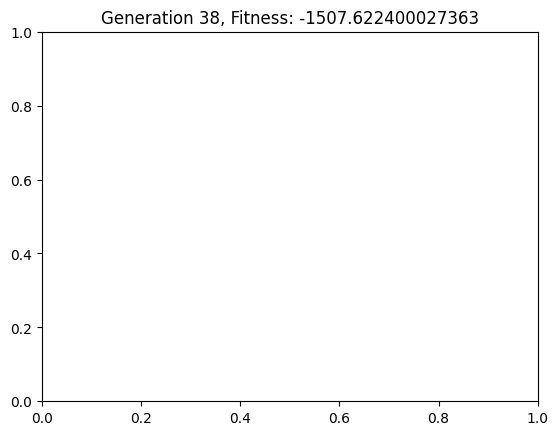

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


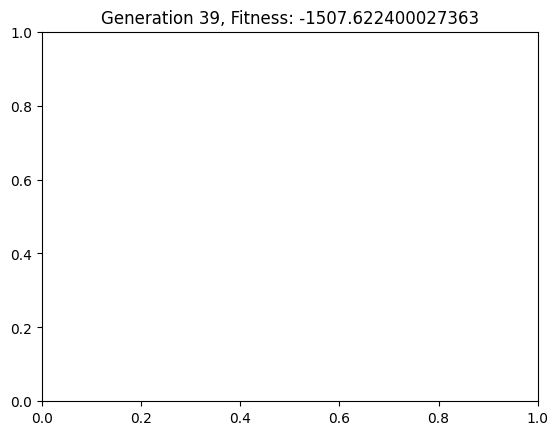

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


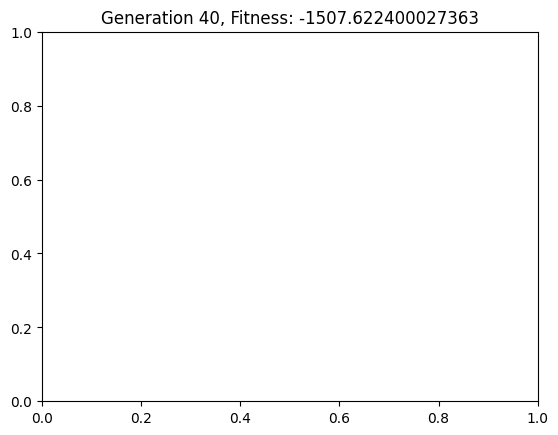

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


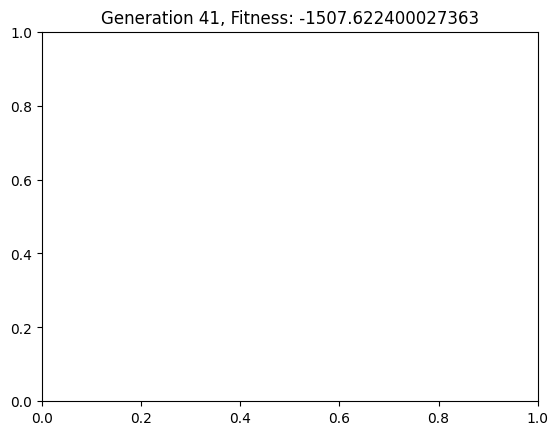

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


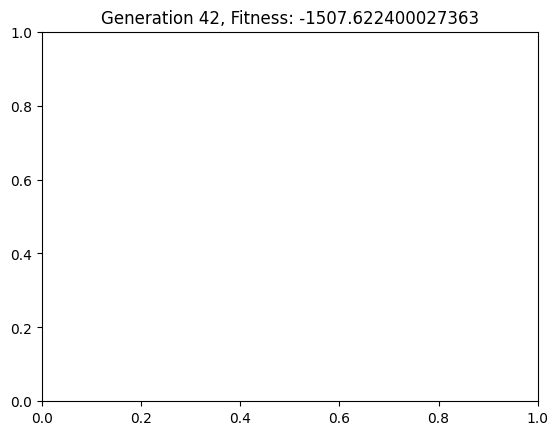

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


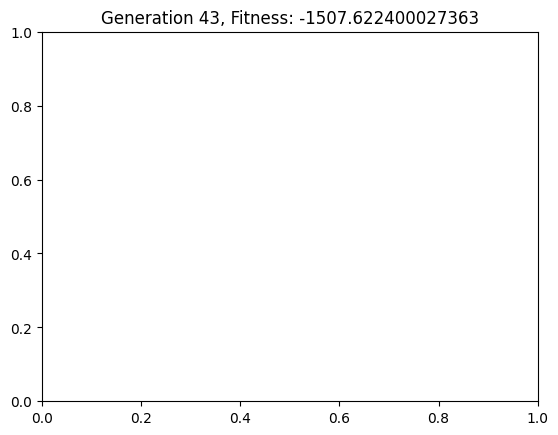

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


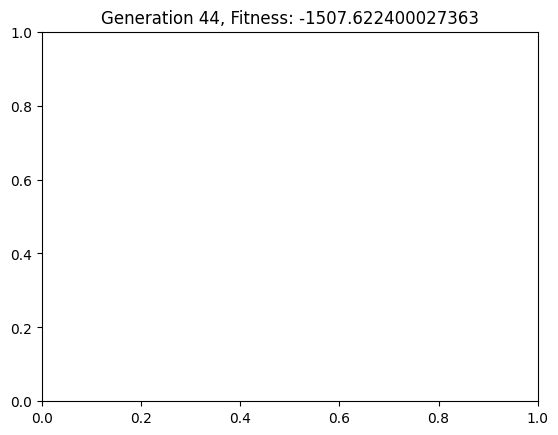

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


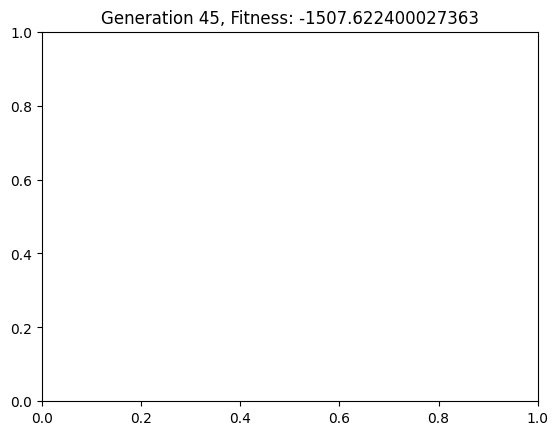

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


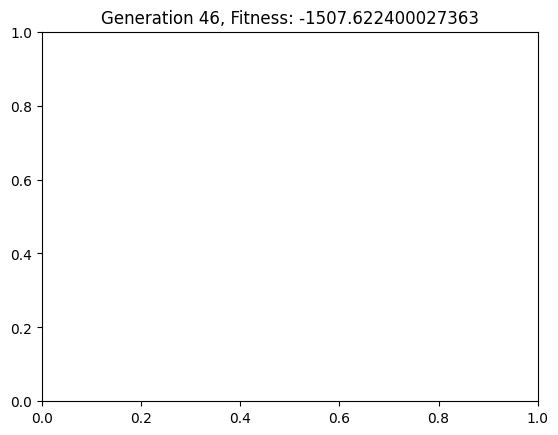

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


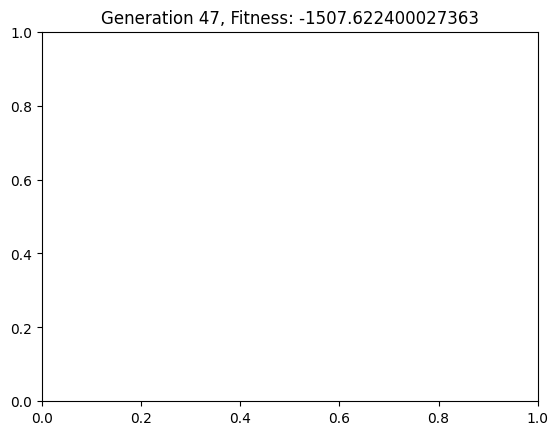

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


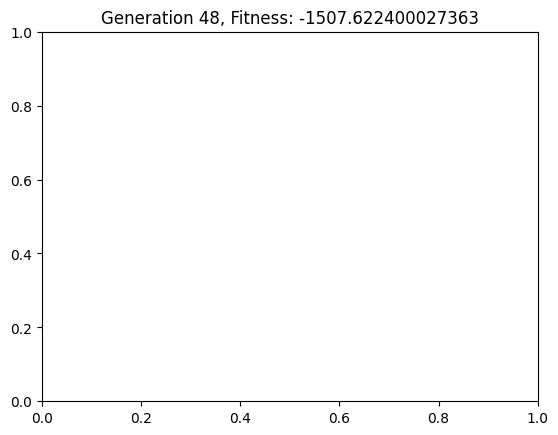

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}


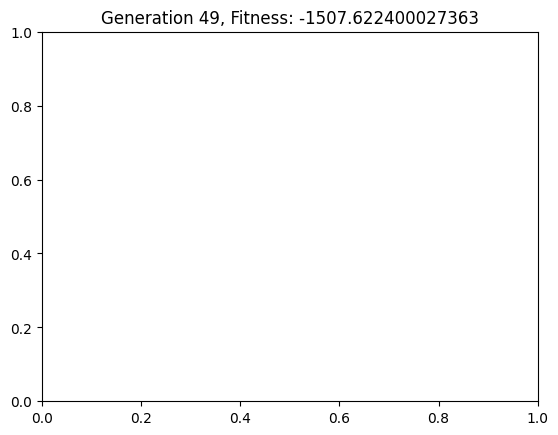

{'rooms': [{'name': 'Living Room', 'position': (597, 372), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (881, 401), 'size': (93, 181)}, {'name': 'Bedroom2', 'position': (800, 116), 'size': (177, 265)}, {'name': 'Passage', 'position': (800, 381), 'size': (81, 151)}, {'name': 'Kitchen', 'position': (811, 533), 'size': (140, 85)}, {'name': 'Washroom', 'position': (748, 422), 'size': (52, 99)}], 'fitness': -1507.622400027363}
Elapsed time: 847.93 seconds


<Figure size 640x480 with 0 Axes>

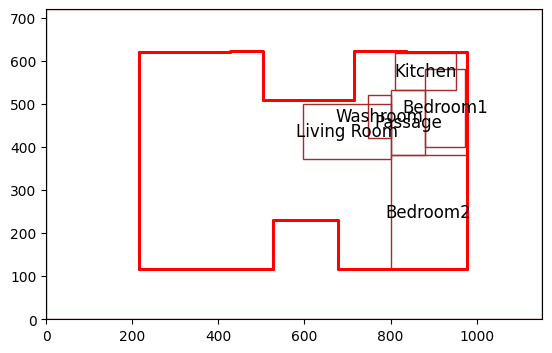

Elapsed time for initial population generation: 40.57 seconds


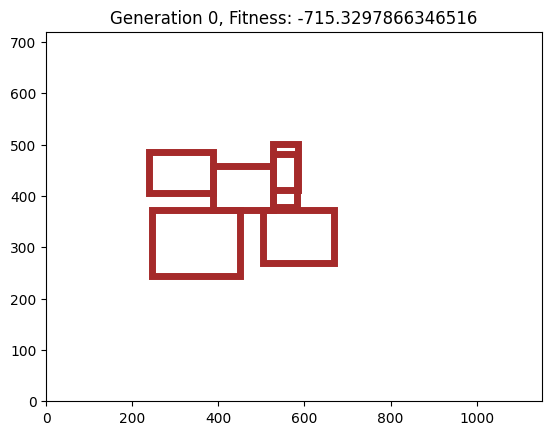

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 91)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -715.3297866346516}


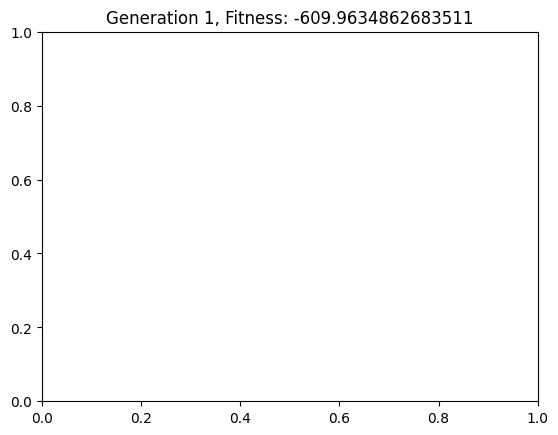

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


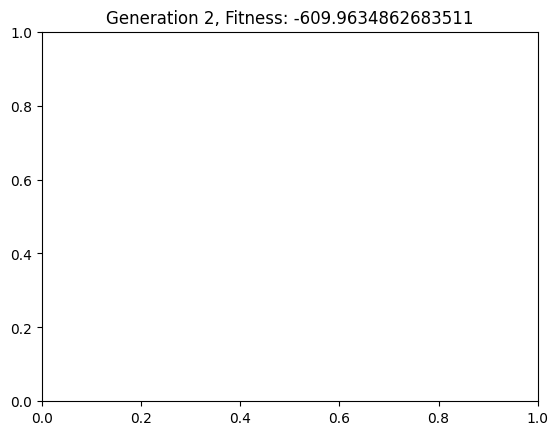

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


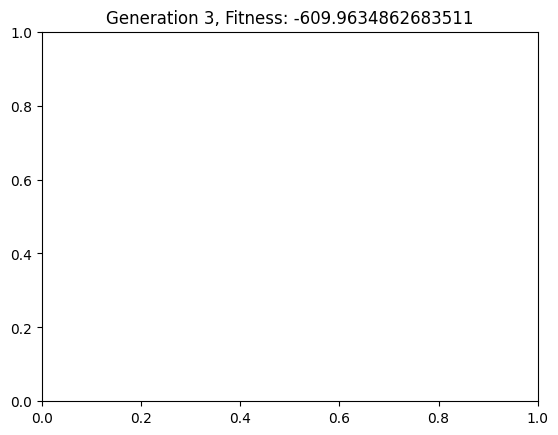

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


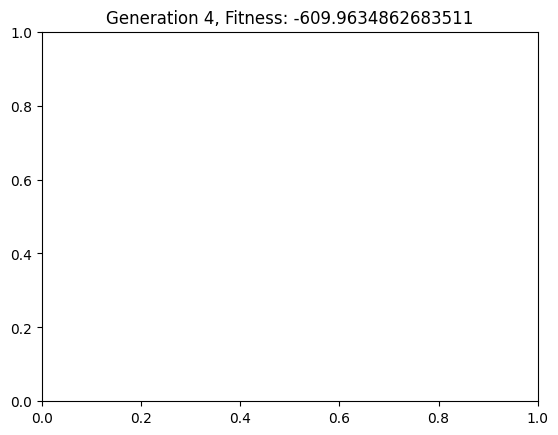

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


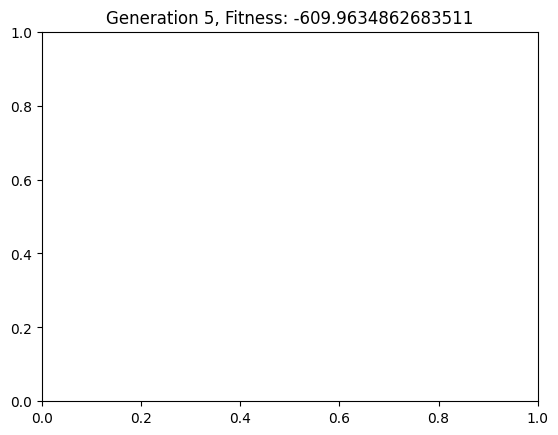

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


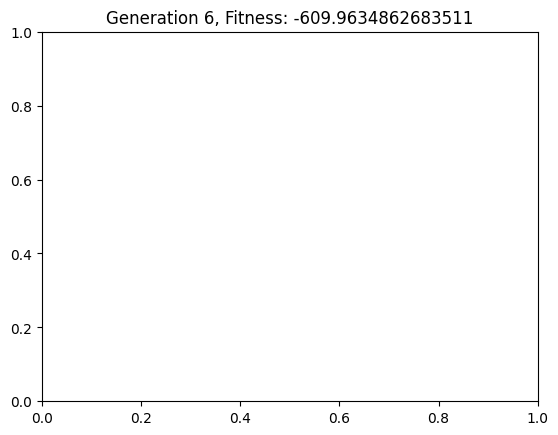

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


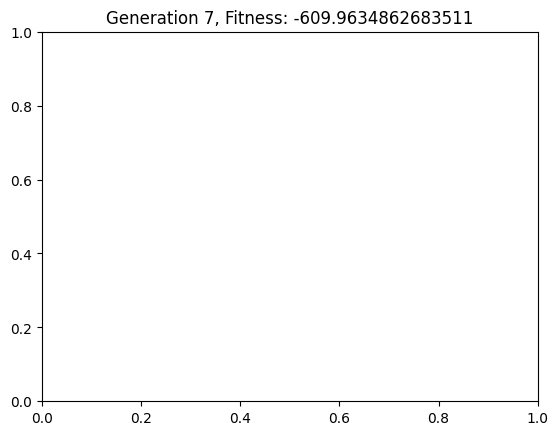

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


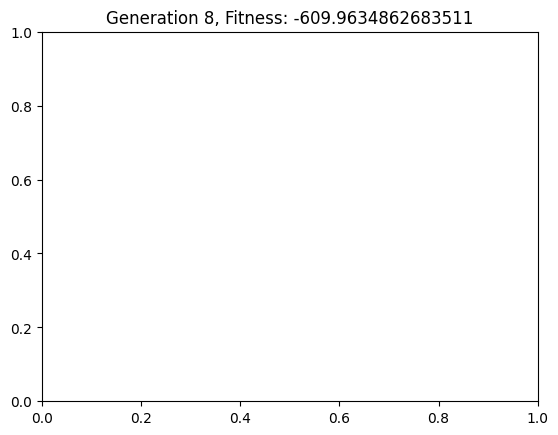

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


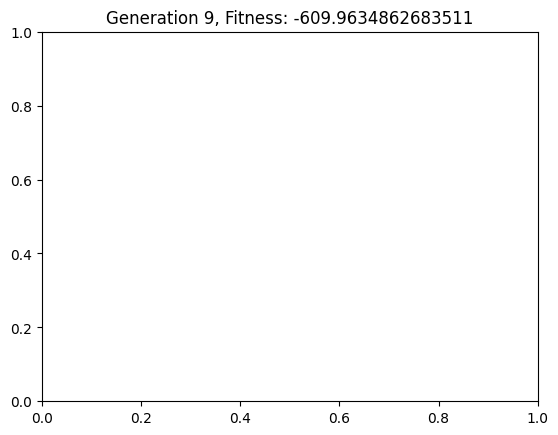

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


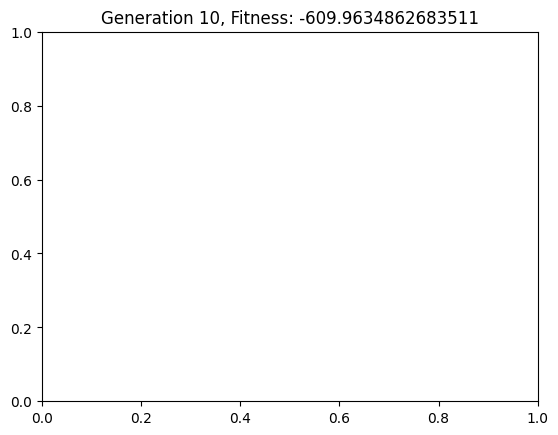

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


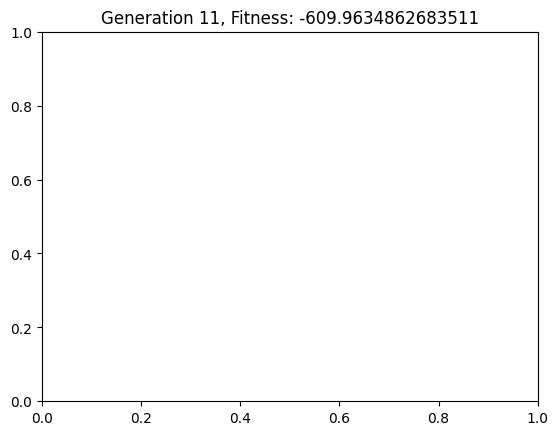

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


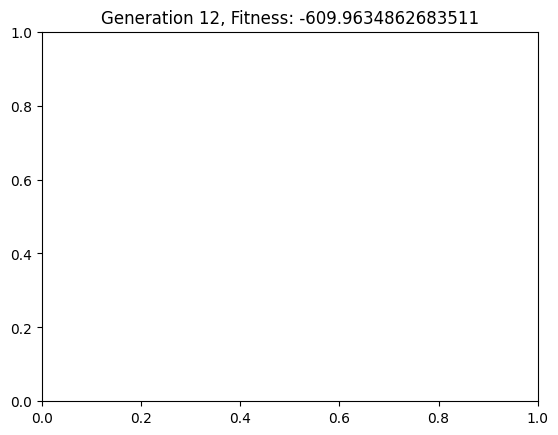

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


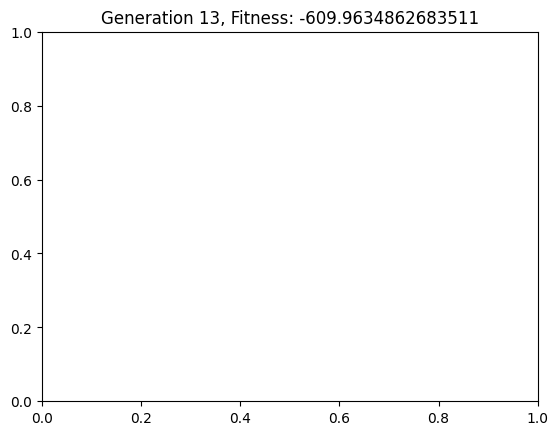

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


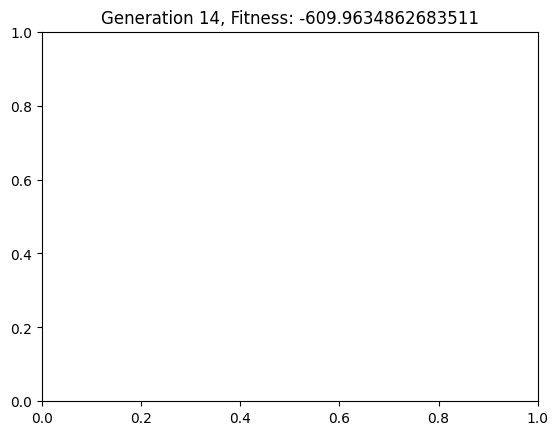

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


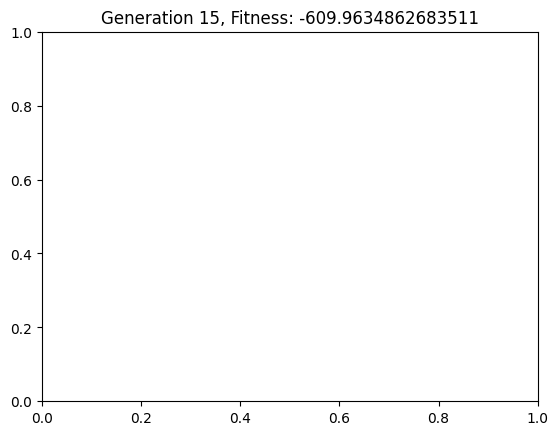

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


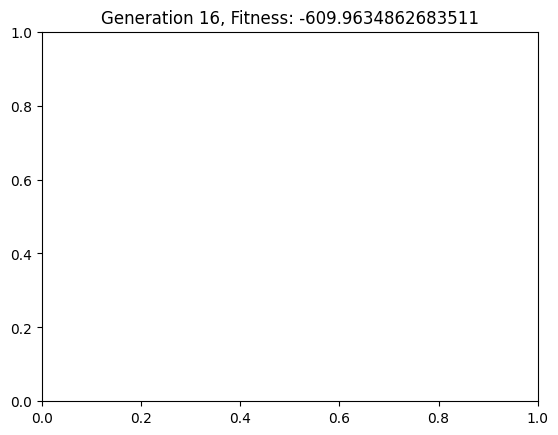

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


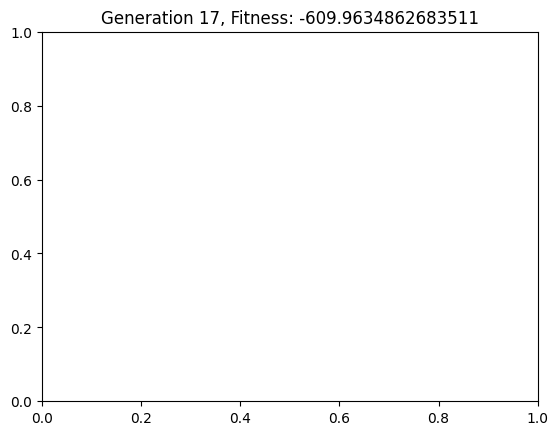

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


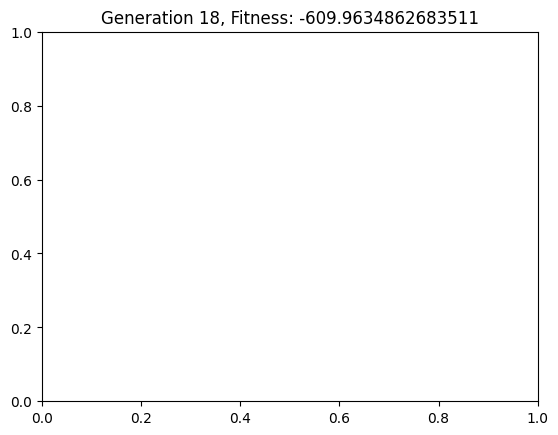

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


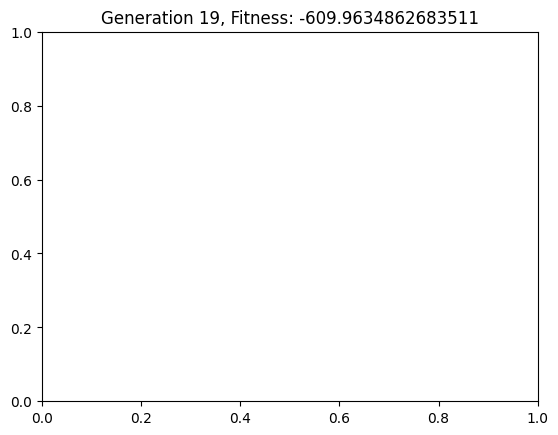

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


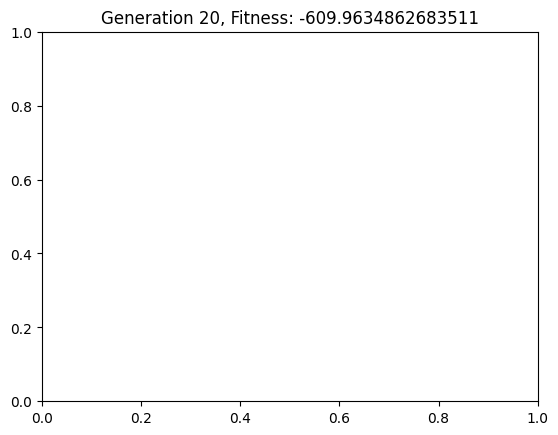

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


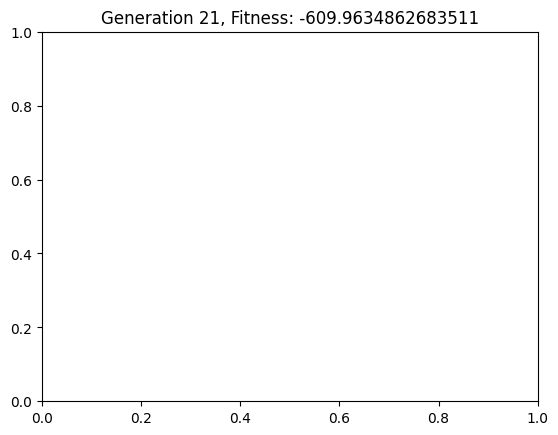

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


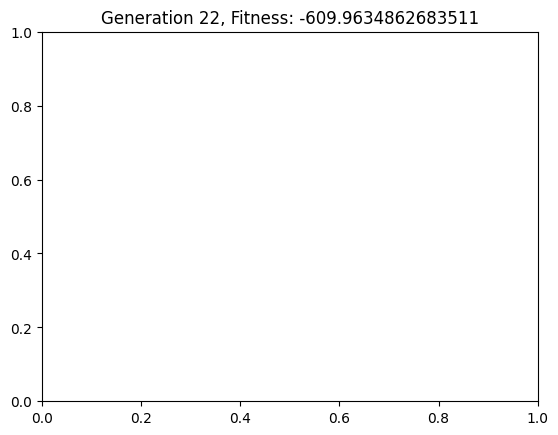

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


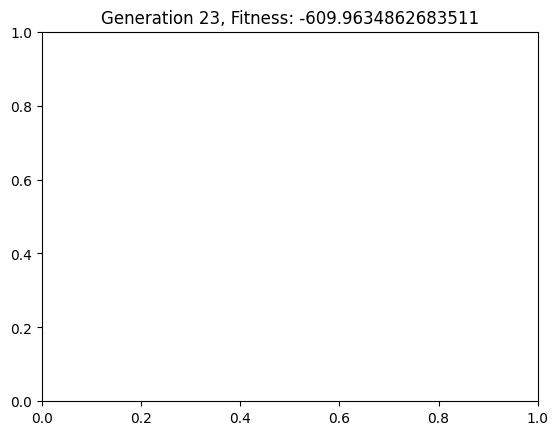

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


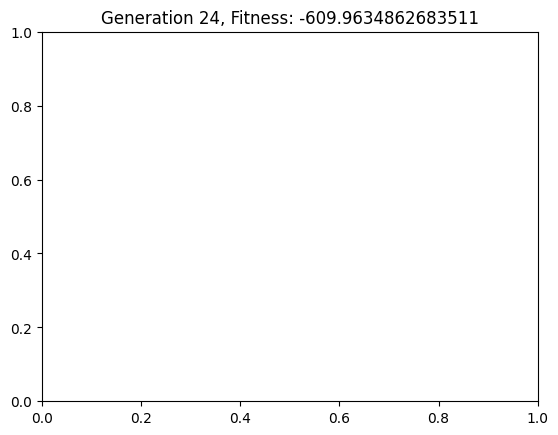

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


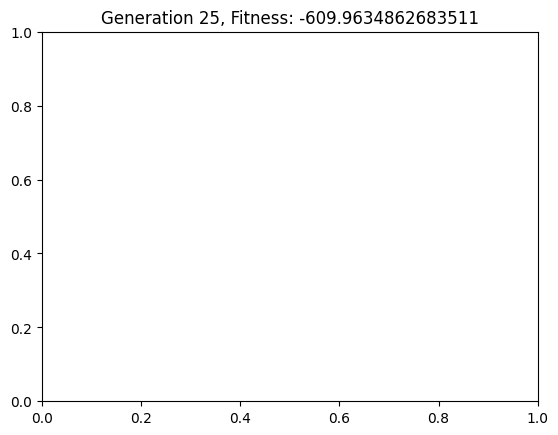

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


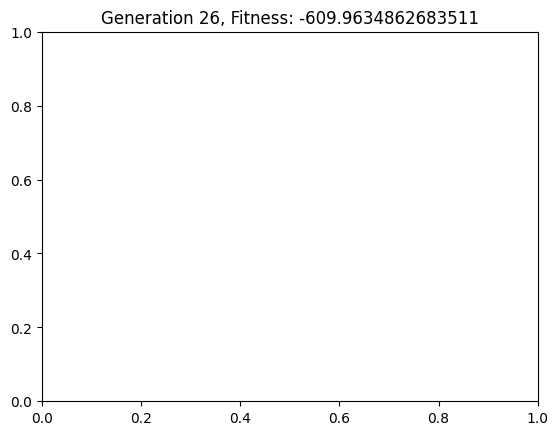

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


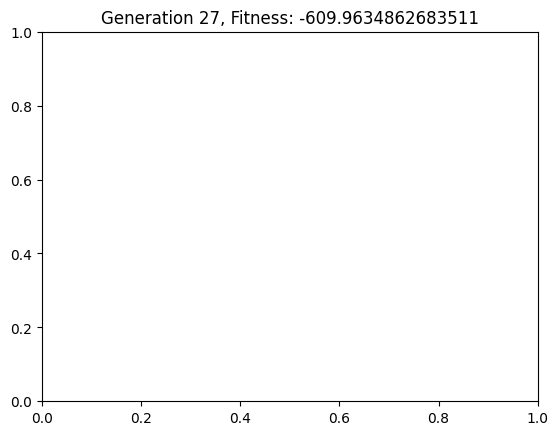

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


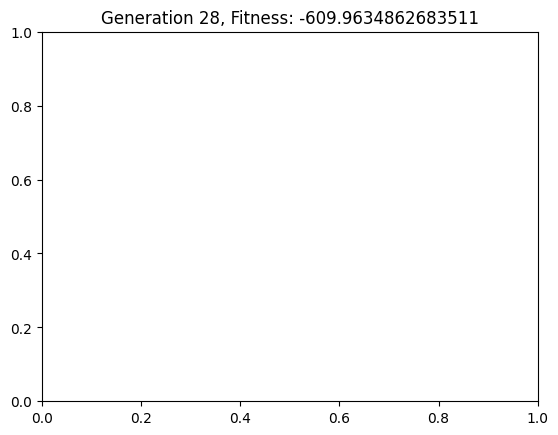

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


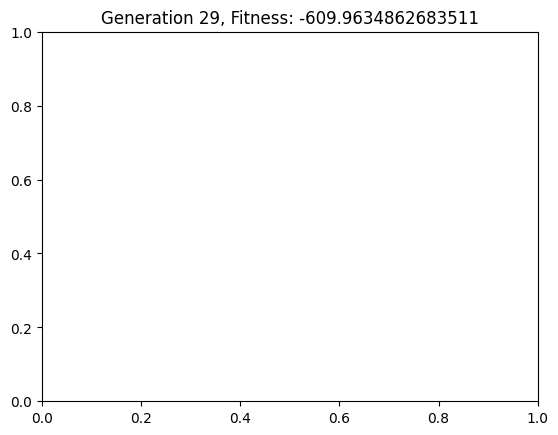

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


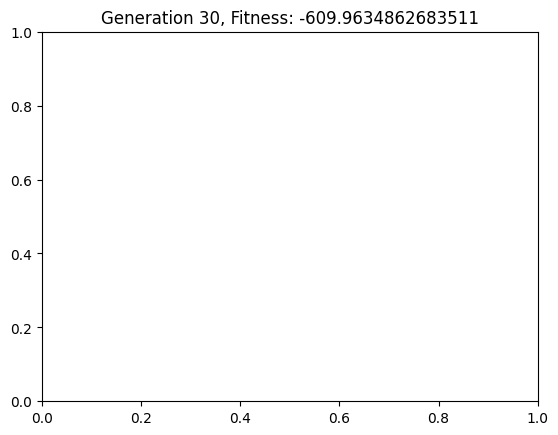

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


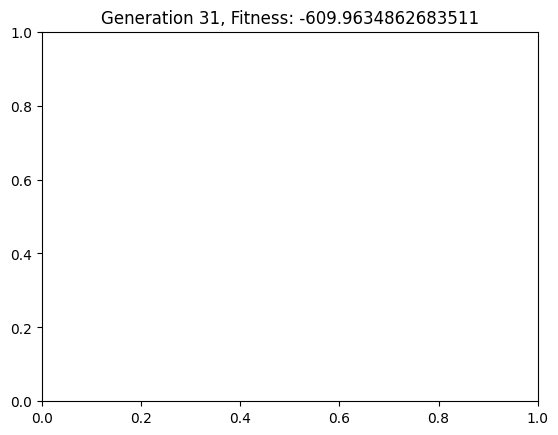

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


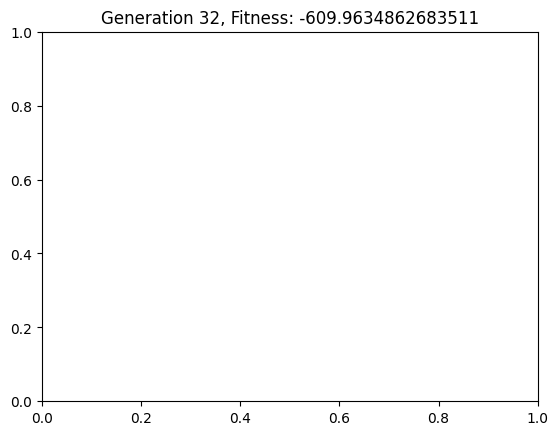

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


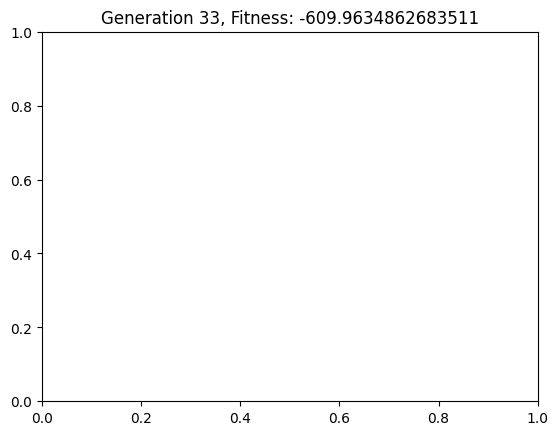

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


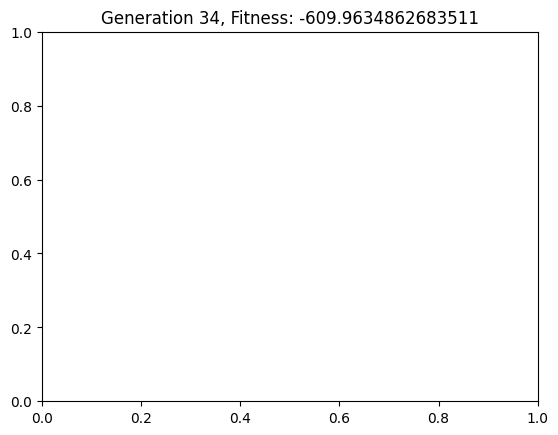

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


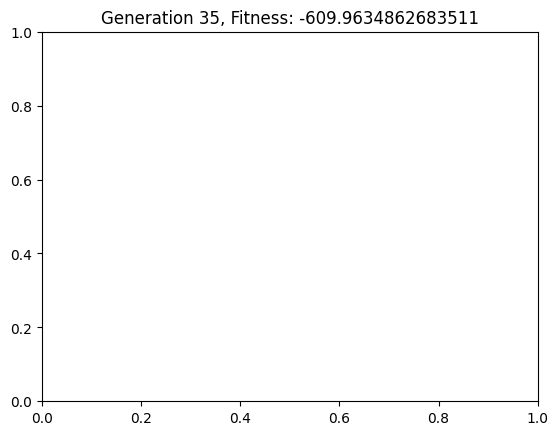

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


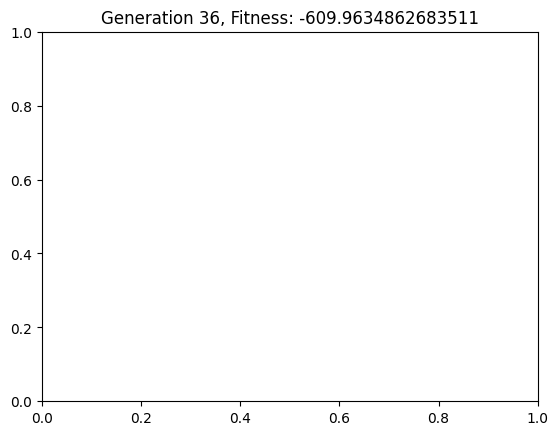

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


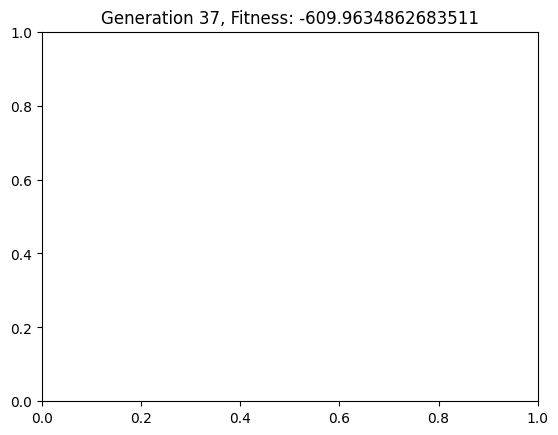

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


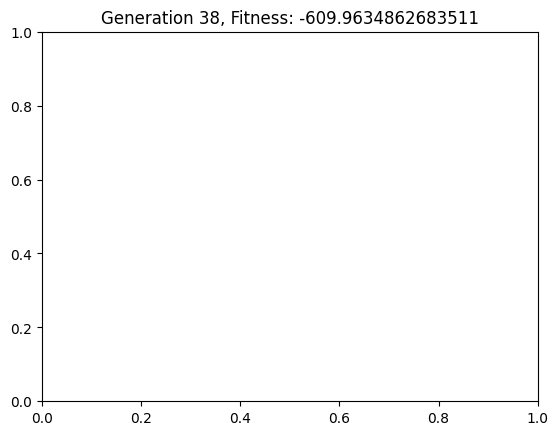

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


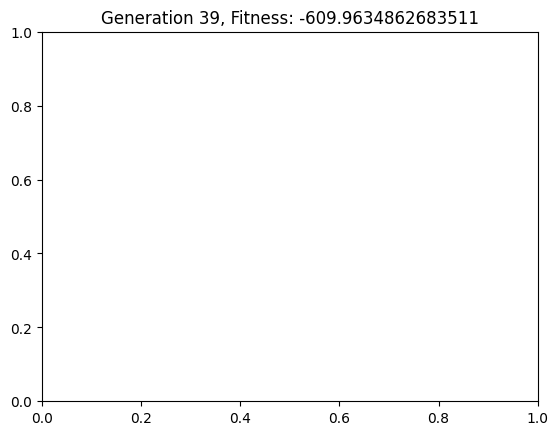

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


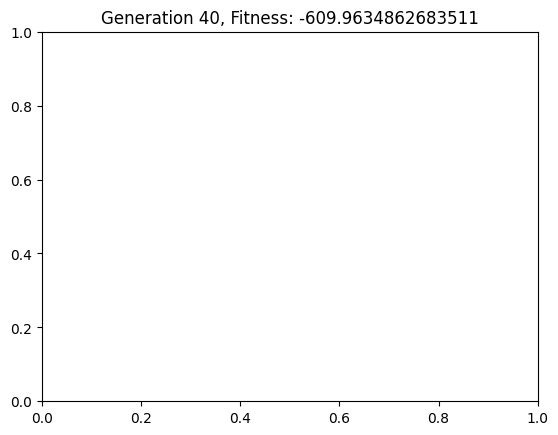

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


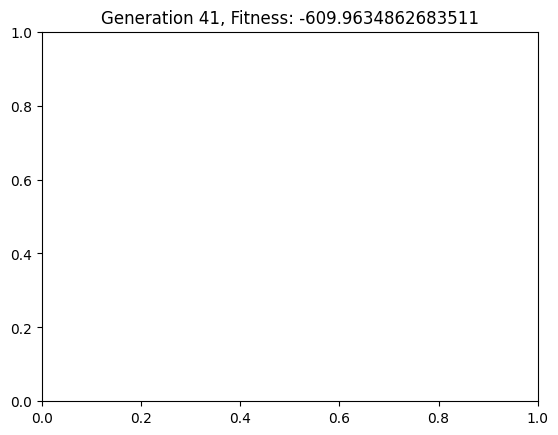

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


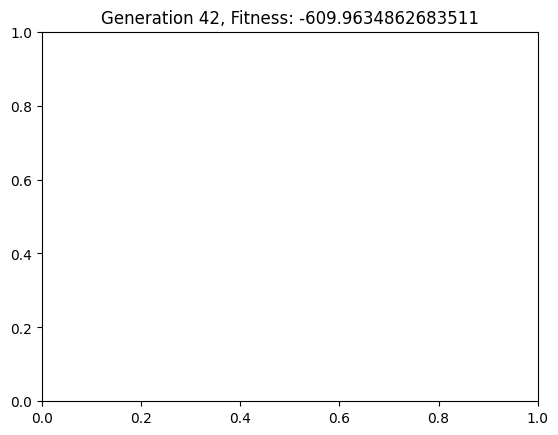

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


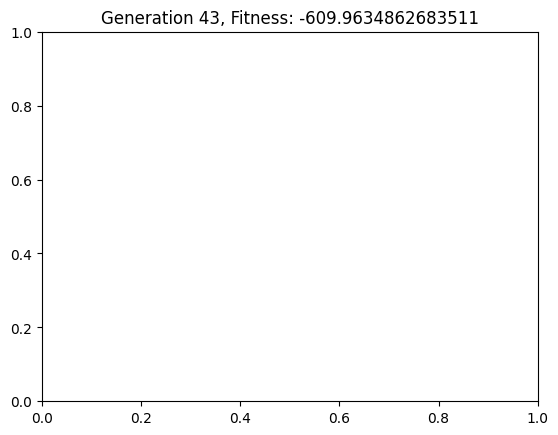

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


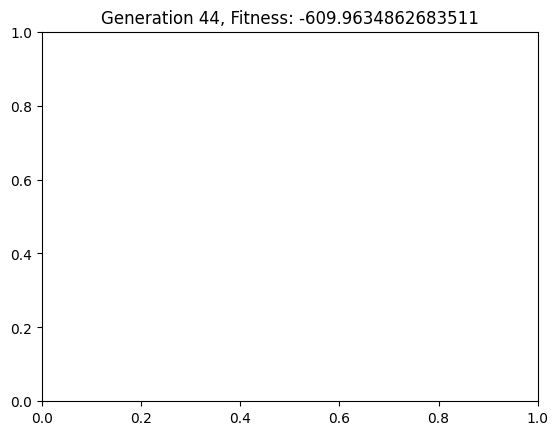

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


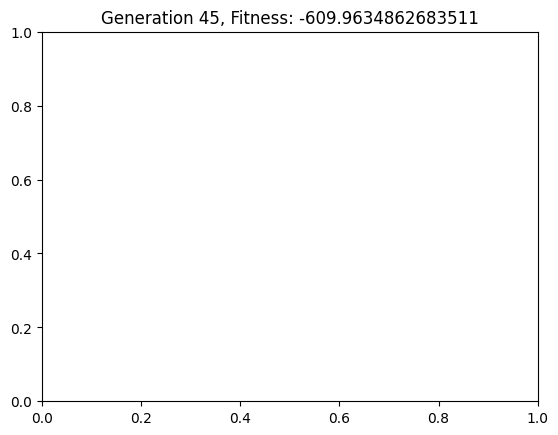

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


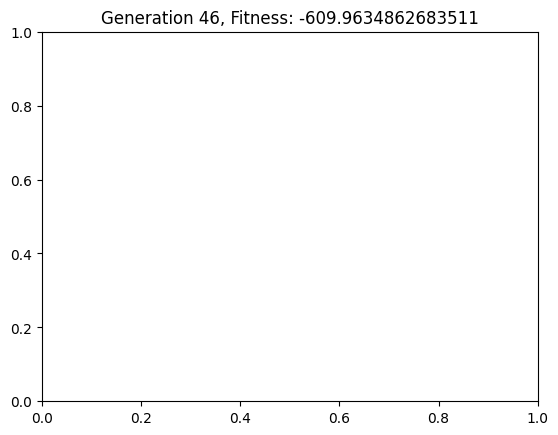

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


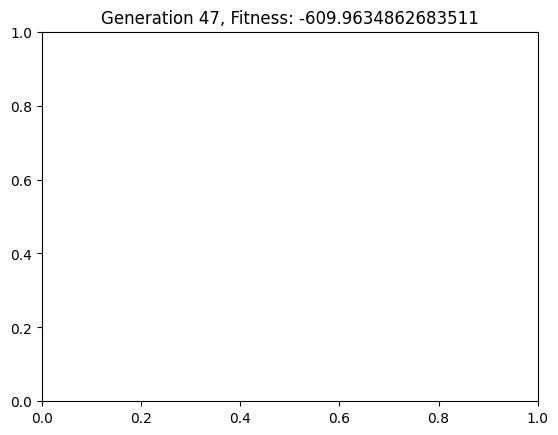

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


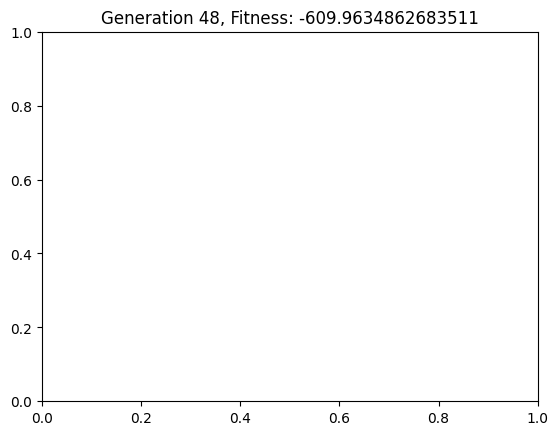

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}


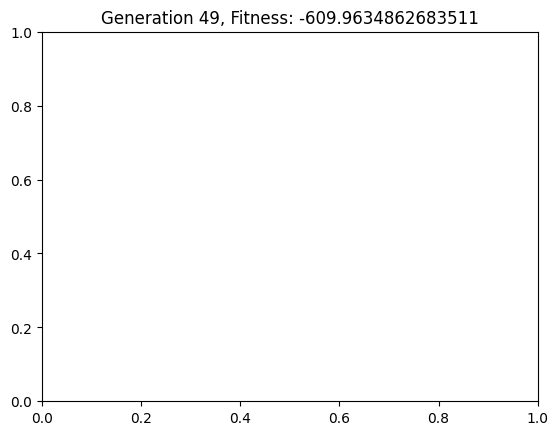

{'rooms': [{'name': 'Living Room', 'position': (247, 245), 'size': (203, 127)}, {'name': 'Passage', 'position': (388, 373), 'size': (139, 86)}, {'name': 'Kitchen', 'position': (240, 406), 'size': (147, 80)}, {'name': 'Washroom', 'position': (528, 411), 'size': (56, 21)}, {'name': 'Bedroom1', 'position': (503, 269), 'size': (166, 103)}, {'name': 'Bedroom2', 'position': (528, 379), 'size': (55, 102)}], 'fitness': -609.9634862683511}
Elapsed time: 740.40 seconds


<Figure size 640x480 with 0 Axes>

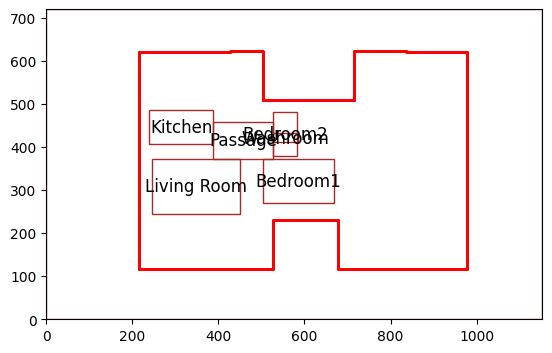

Elapsed time for initial population generation: 40.72 seconds


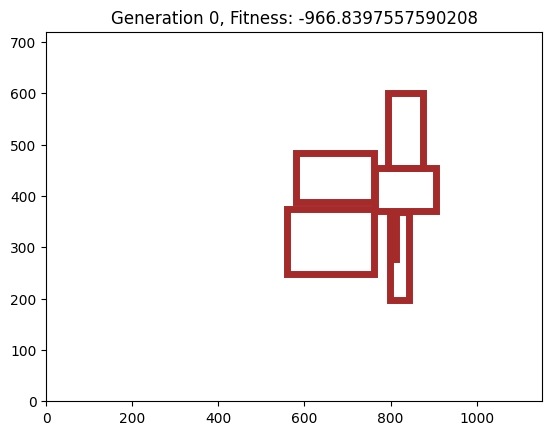

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (203, 127)}, {'name': 'Passage', 'position': (763, 370), 'size': (143, 84)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (83, 145)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (181, 95)}], 'fitness': -966.8397557590208}


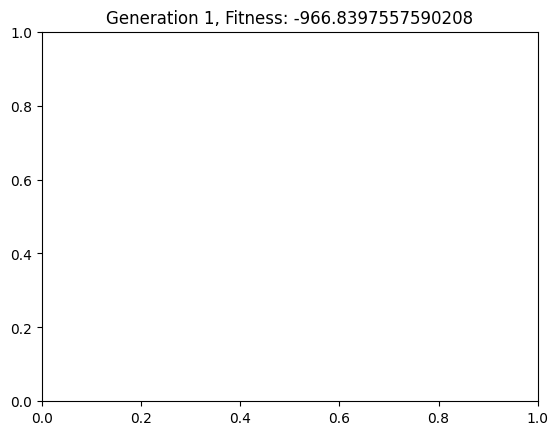

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (203, 127)}, {'name': 'Passage', 'position': (763, 370), 'size': (143, 84)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (83, 145)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (181, 95)}], 'fitness': -966.8397557590208}


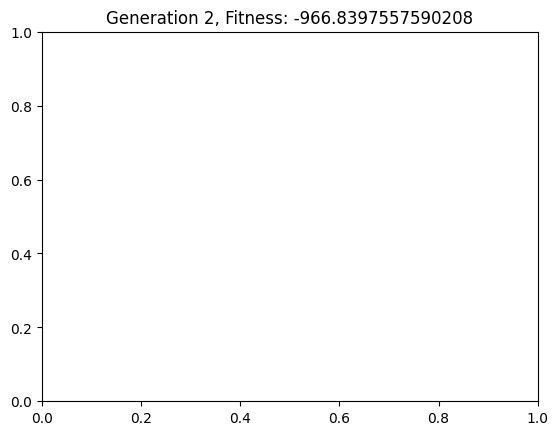

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (203, 127)}, {'name': 'Passage', 'position': (763, 370), 'size': (143, 84)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (83, 145)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (181, 95)}], 'fitness': -966.8397557590208}


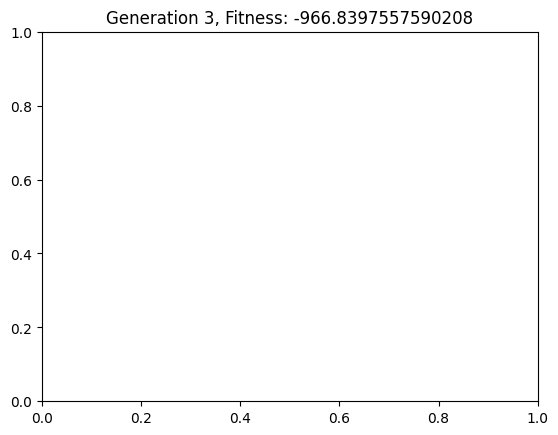

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (203, 127)}, {'name': 'Passage', 'position': (763, 370), 'size': (143, 84)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (83, 145)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (181, 95)}], 'fitness': -966.8397557590208}


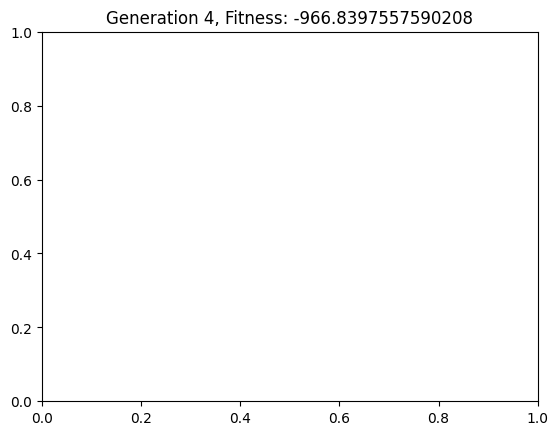

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (203, 127)}, {'name': 'Passage', 'position': (763, 370), 'size': (143, 84)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (83, 145)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (181, 95)}], 'fitness': -966.8397557590208}


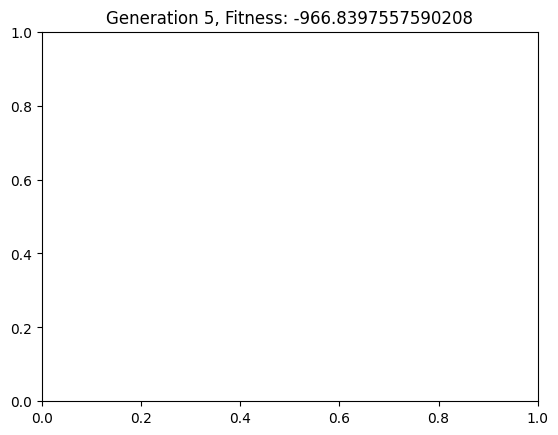

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (203, 127)}, {'name': 'Passage', 'position': (763, 370), 'size': (143, 84)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (83, 145)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (181, 95)}], 'fitness': -966.8397557590208}


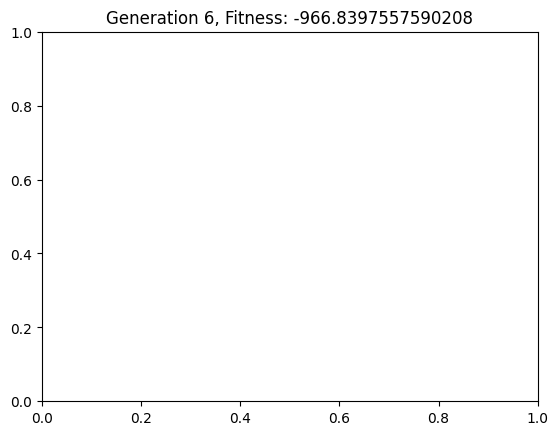

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (203, 127)}, {'name': 'Passage', 'position': (763, 370), 'size': (143, 84)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (83, 145)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (181, 95)}], 'fitness': -966.8397557590208}


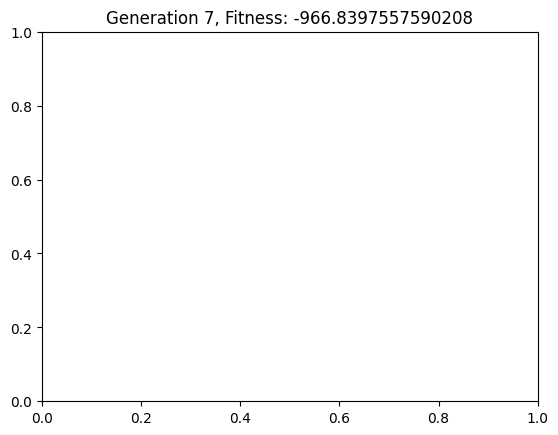

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -966.8397557590208}


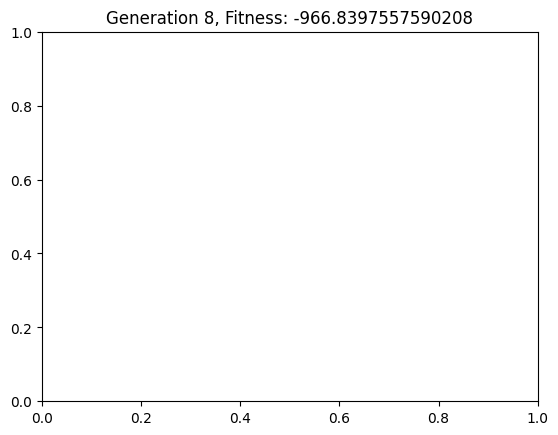

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


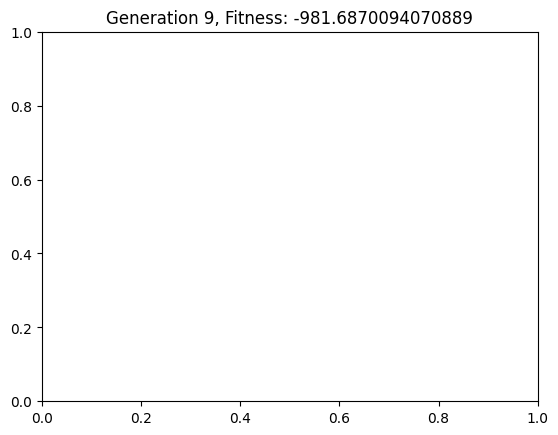

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


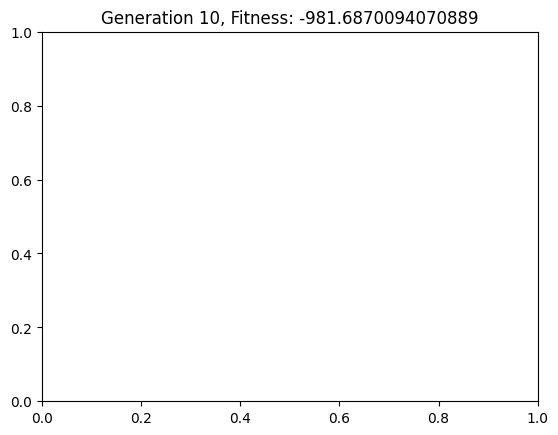

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


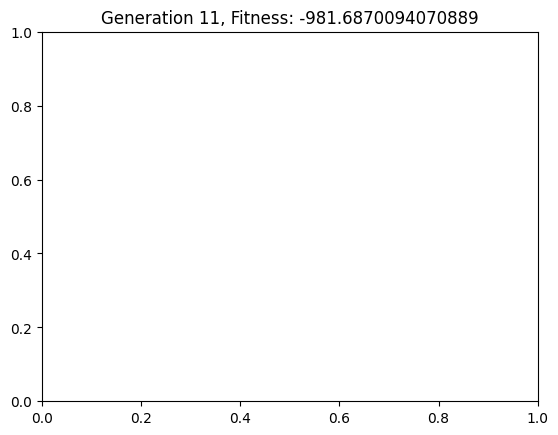

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


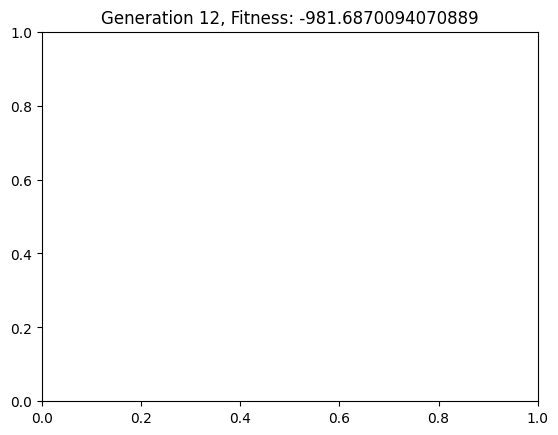

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


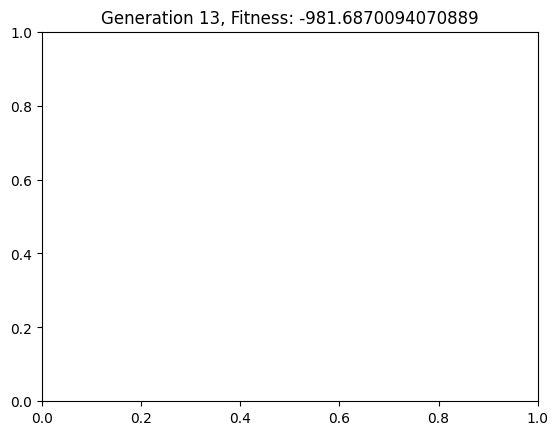

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


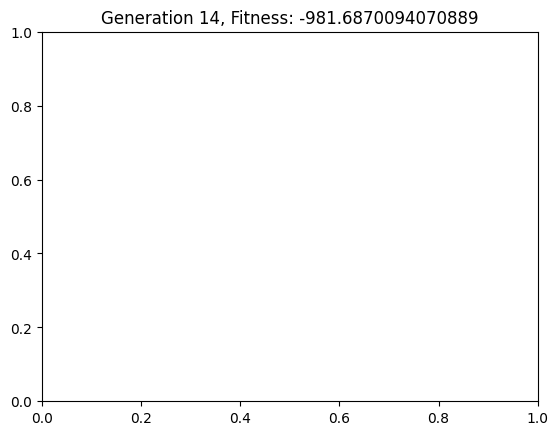

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


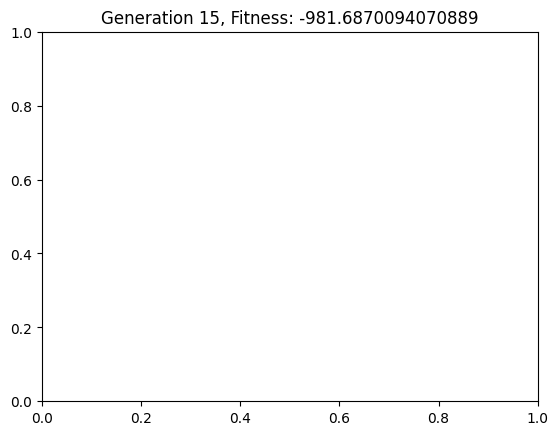

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


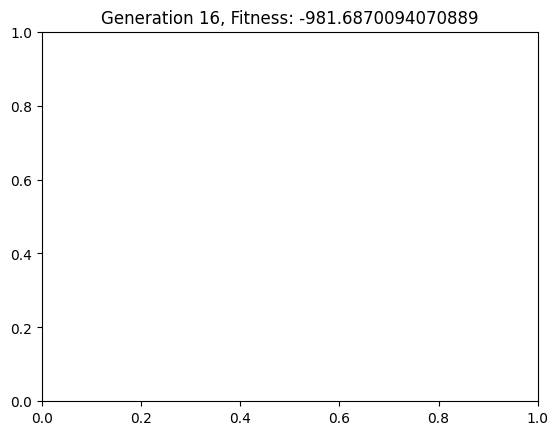

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


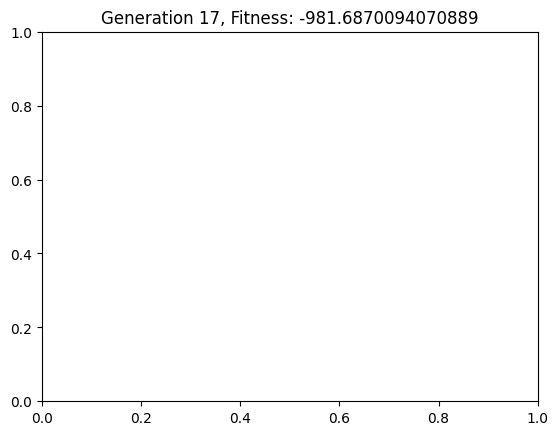

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


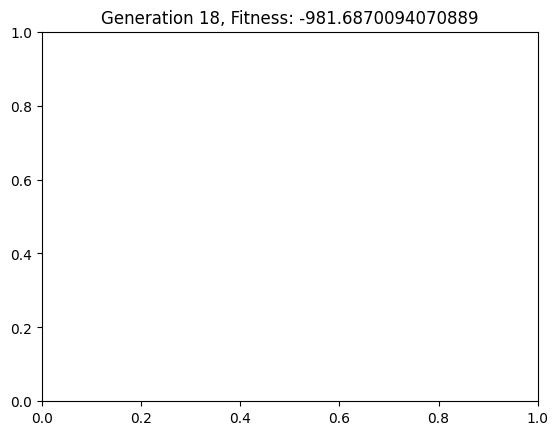

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


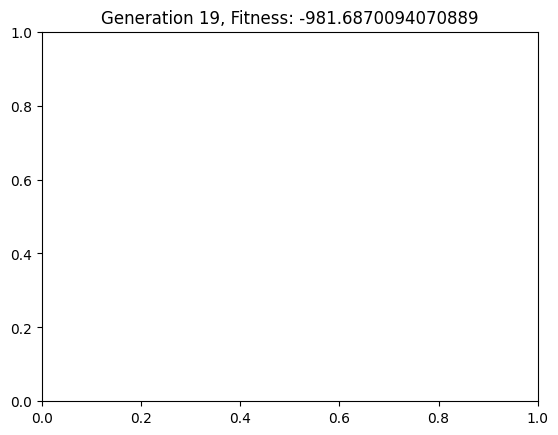

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


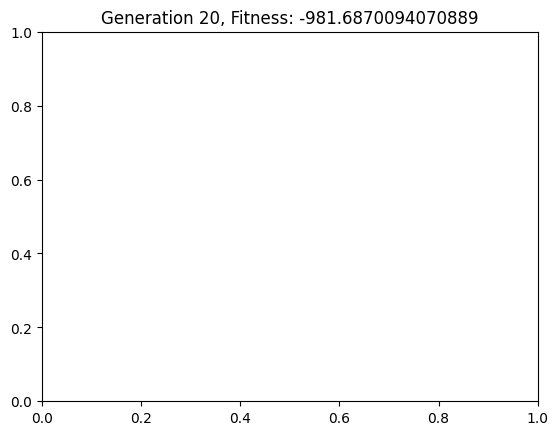

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


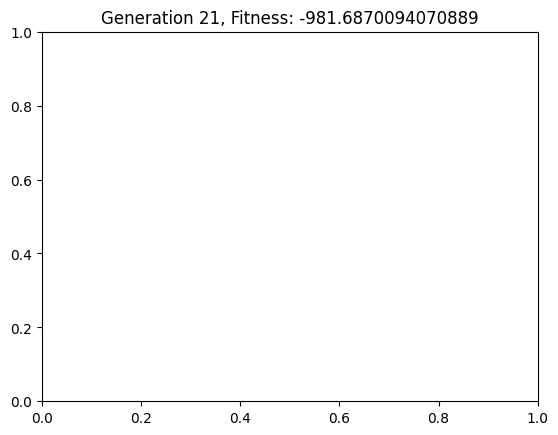

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


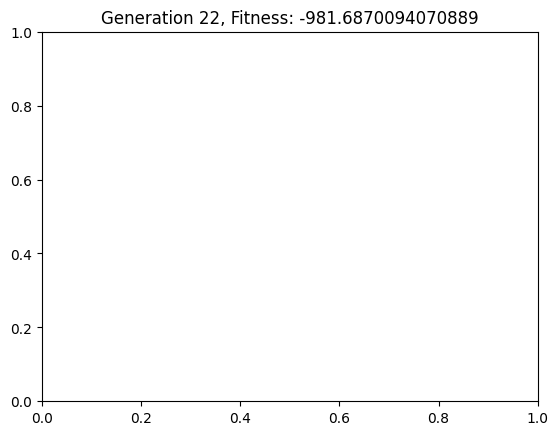

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


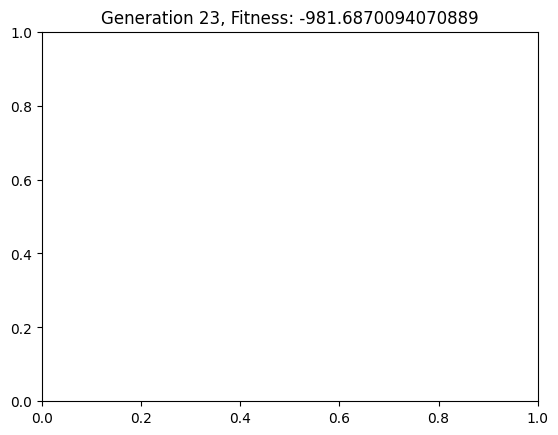

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


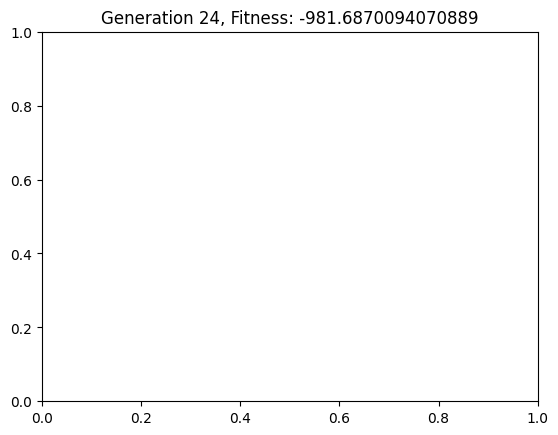

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


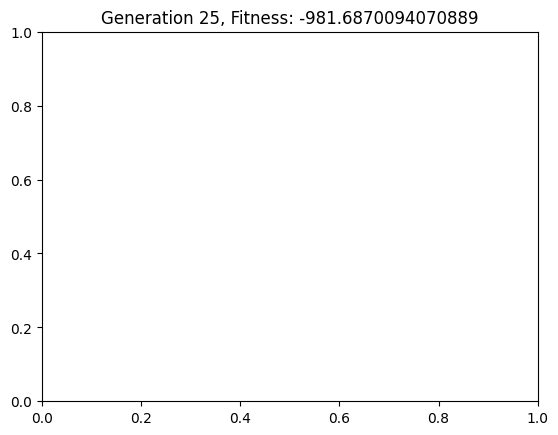

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


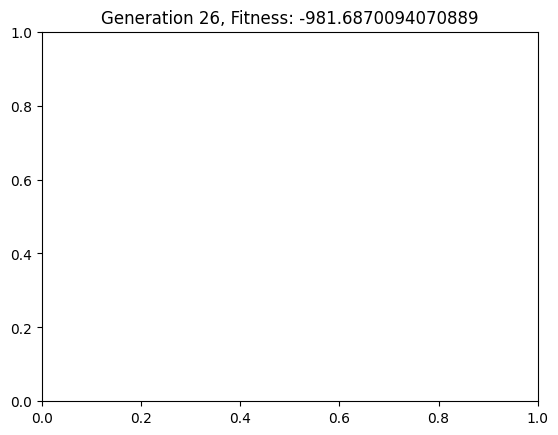

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


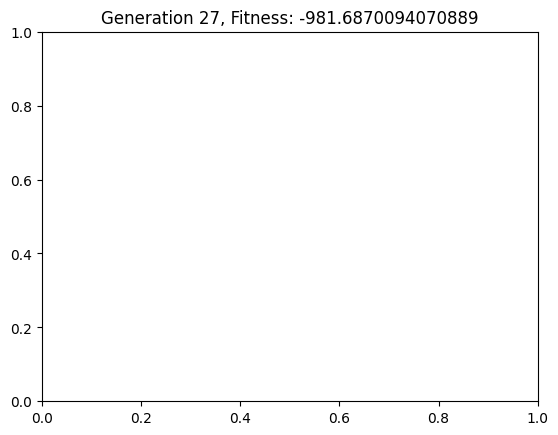

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


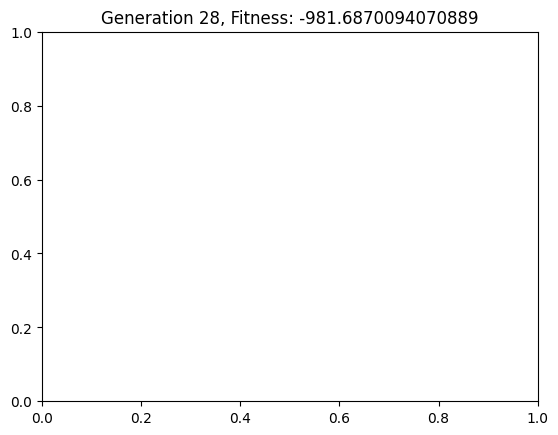

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


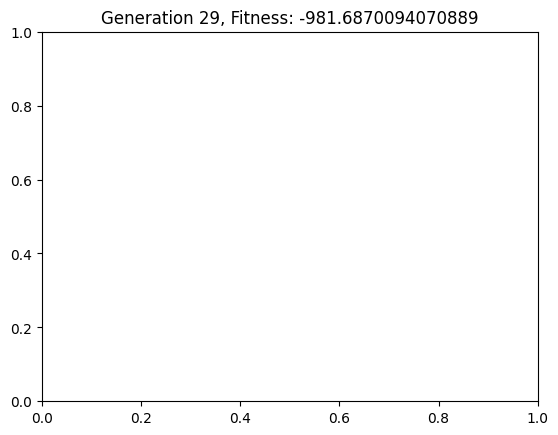

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


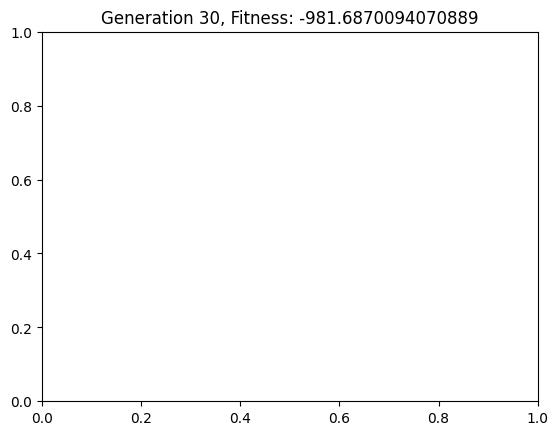

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


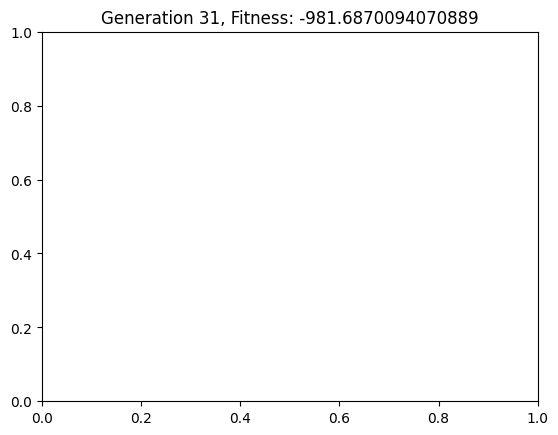

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


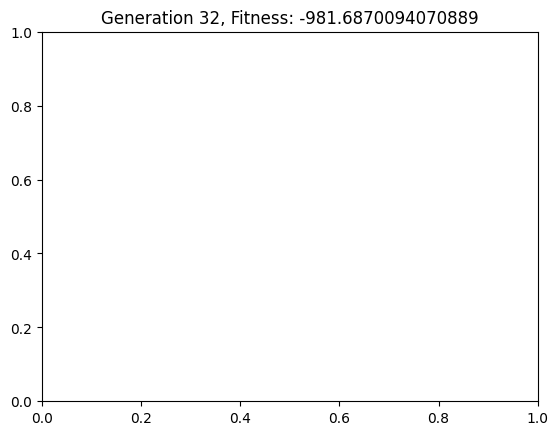

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


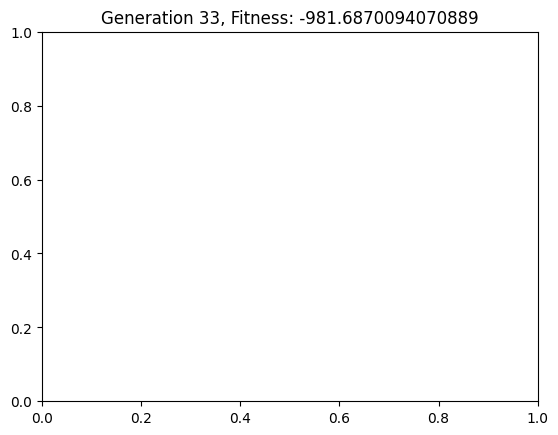

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


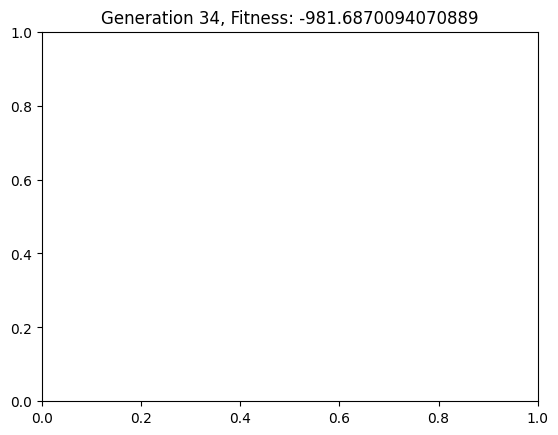

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


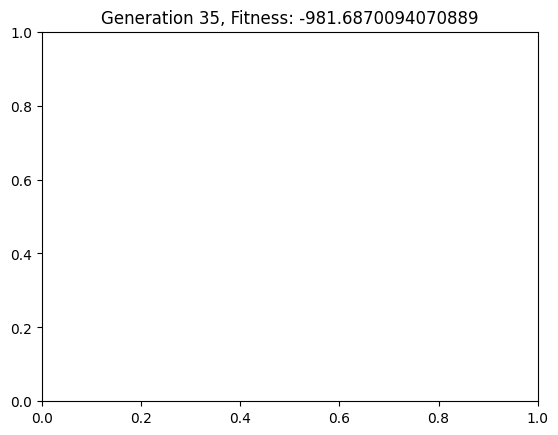

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


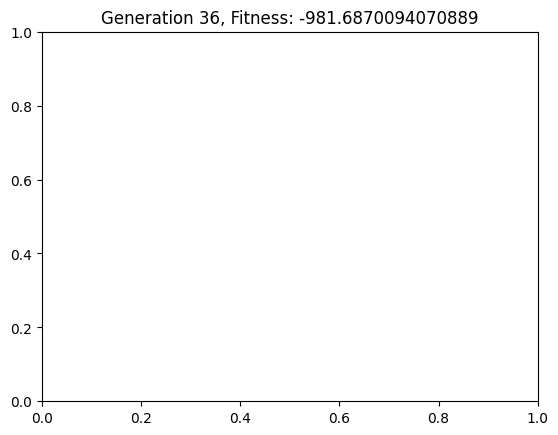

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


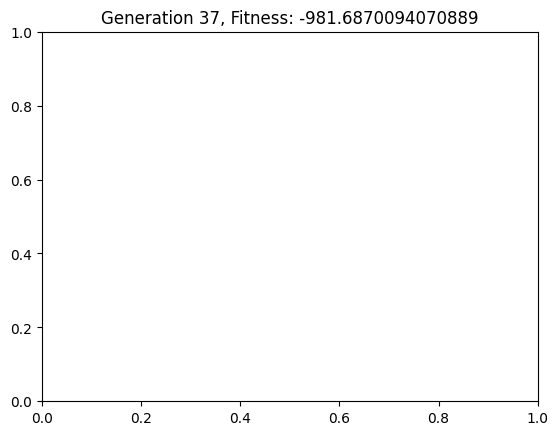

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


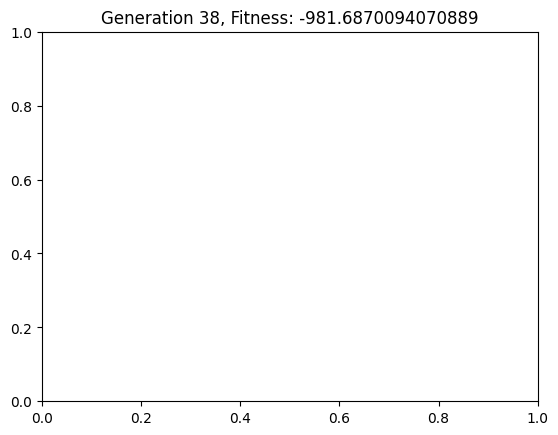

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


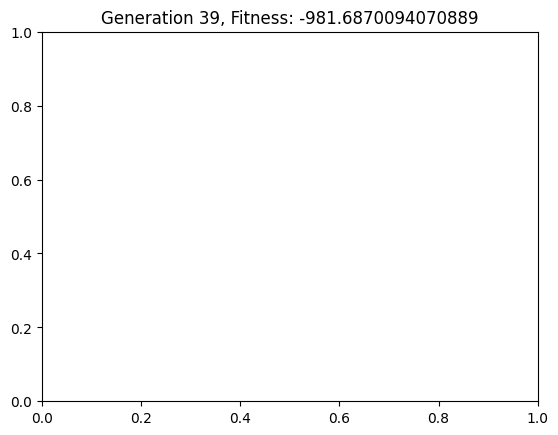

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


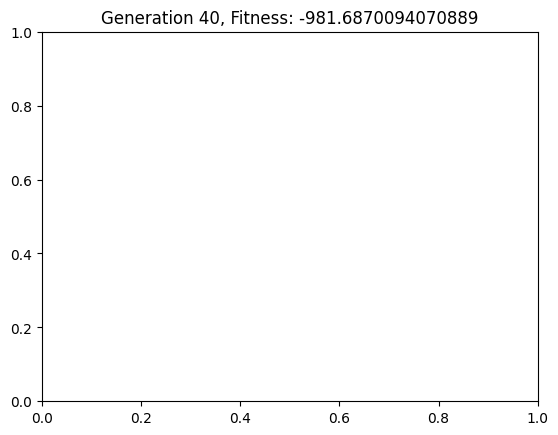

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


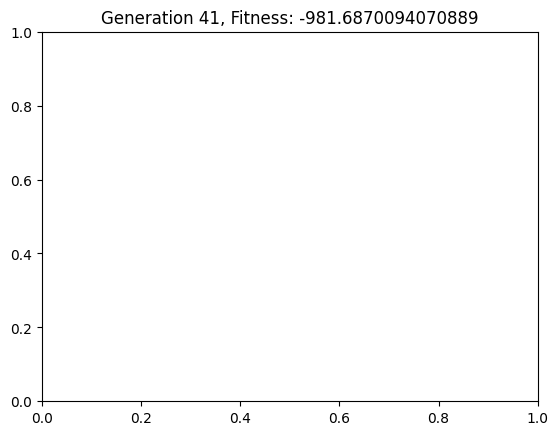

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


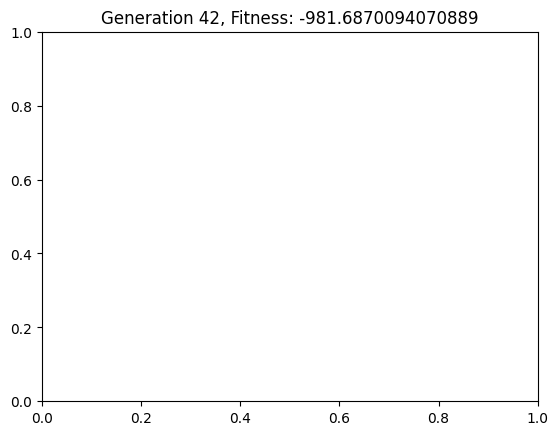

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


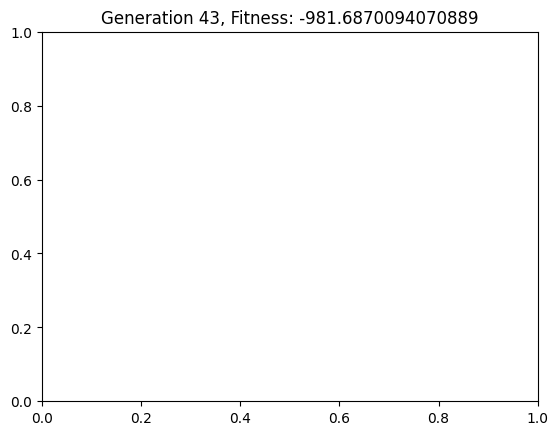

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


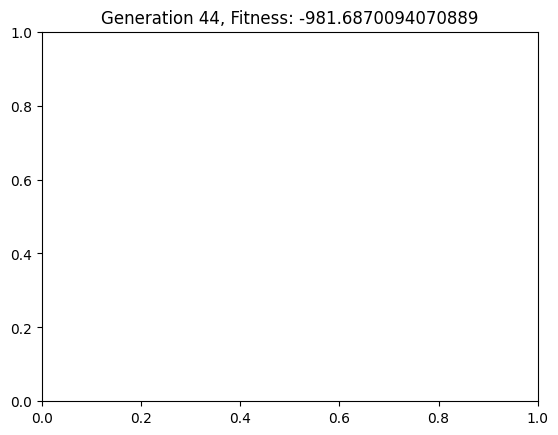

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


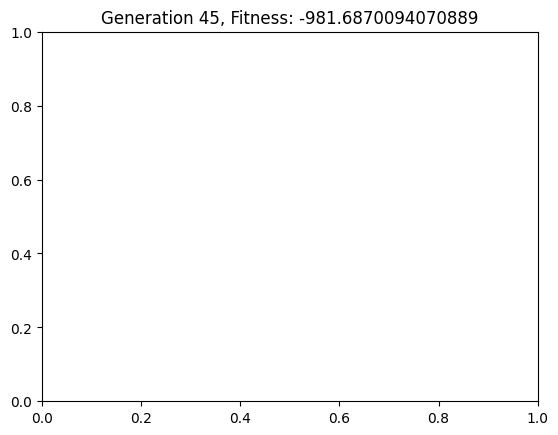

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


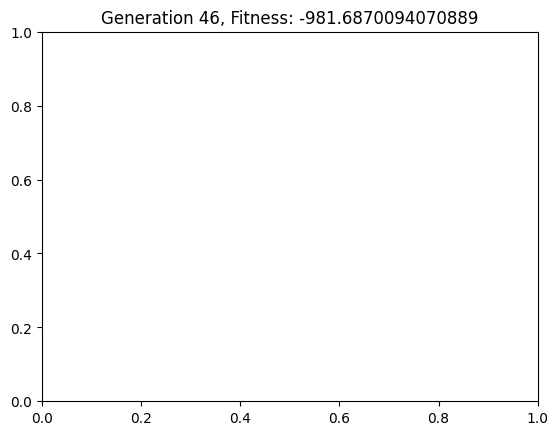

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


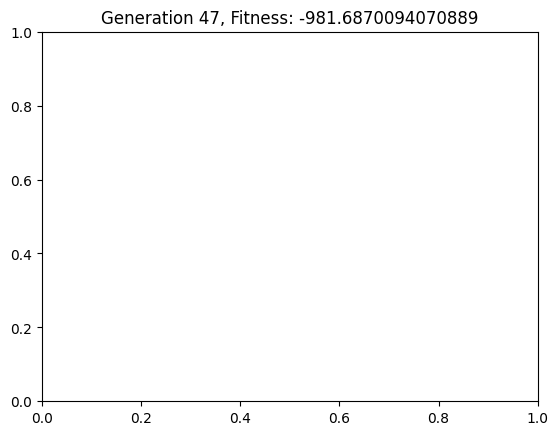

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


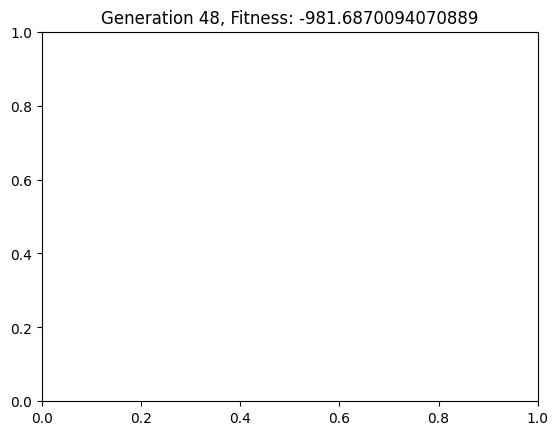

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}


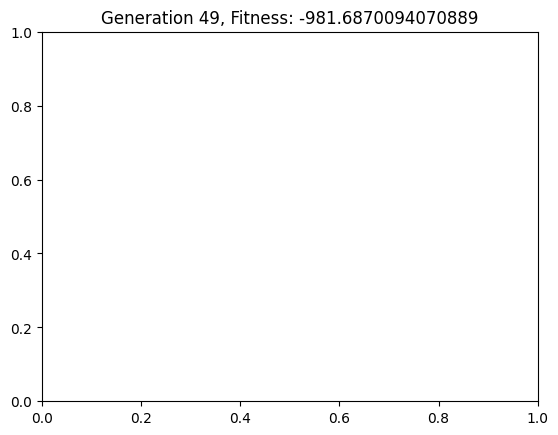

{'rooms': [{'name': 'Living Room', 'position': (559, 247), 'size': (204, 128)}, {'name': 'Passage', 'position': (763, 370), 'size': (144, 85)}, {'name': 'Kitchen', 'position': (793, 455), 'size': (84, 153)}, {'name': 'Washroom', 'position': (800, 278), 'size': (12, 91)}, {'name': 'Bedroom1', 'position': (799, 197), 'size': (44, 172)}, {'name': 'Bedroom2', 'position': (581, 389), 'size': (182, 96)}], 'fitness': -981.6870094070889}
Elapsed time: 708.24 seconds


<Figure size 640x480 with 0 Axes>

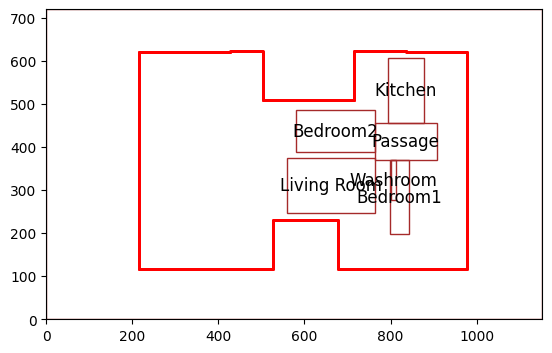

Elapsed time for initial population generation: 39.41 seconds


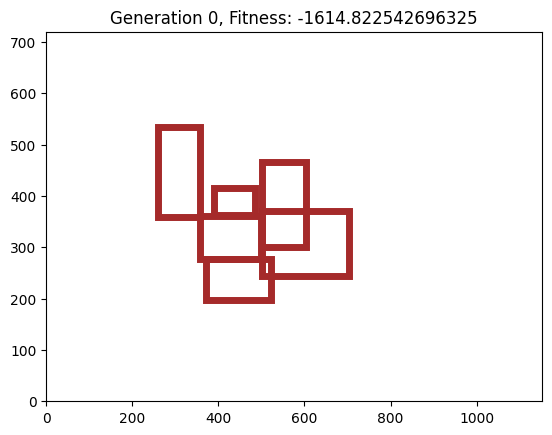

{'rooms': [{'name': 'Living Room', 'position': (501, 244), 'size': (203, 127)}, {'name': 'Passage', 'position': (358, 278), 'size': (142, 83)}, {'name': 'Kitchen', 'position': (372, 198), 'size': (150, 79)}, {'name': 'Washroom', 'position': (391, 362), 'size': (94, 53)}, {'name': 'Bedroom1', 'position': (259, 359), 'size': (98, 175)}, {'name': 'Bedroom2', 'position': (501, 300), 'size': (102, 167)}], 'fitness': -1614.822542696325}


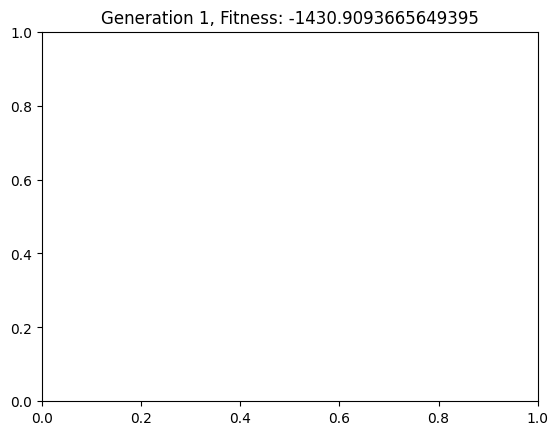

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 395), 'size': (177, 100)}, {'name': 'Bedroom2', 'position': (356, 389), 'size': (98, 178)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1430.9093665649395}


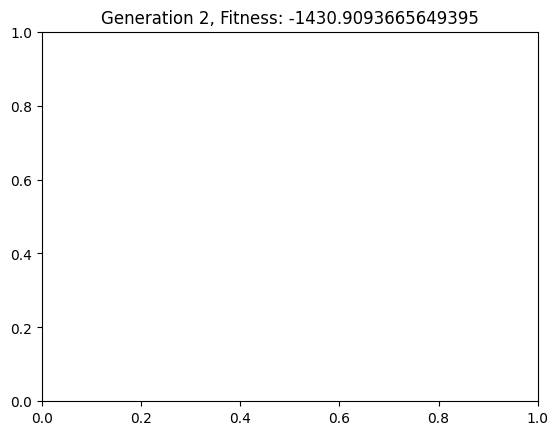

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 395), 'size': (179, 102)}, {'name': 'Bedroom2', 'position': (355, 389), 'size': (99, 180)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1432.502727116256}


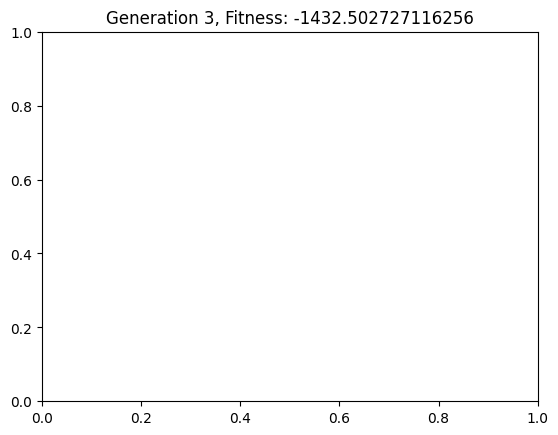

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 395), 'size': (185, 108)}, {'name': 'Bedroom2', 'position': (352, 389), 'size': (102, 186)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1435.575365927403}


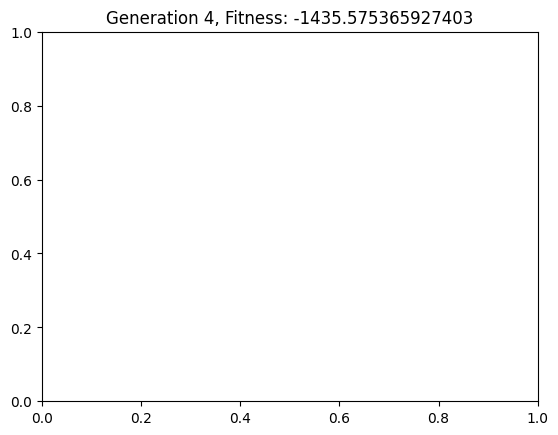

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 394), 'size': (193, 115)}, {'name': 'Bedroom2', 'position': (348, 389), 'size': (106, 194)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1443.9656162159727}


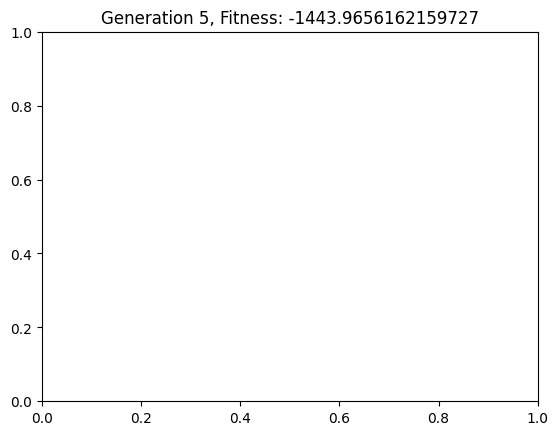

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 390), 'size': (201, 119)}, {'name': 'Bedroom2', 'position': (344, 389), 'size': (110, 202)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1532.7647746724579}


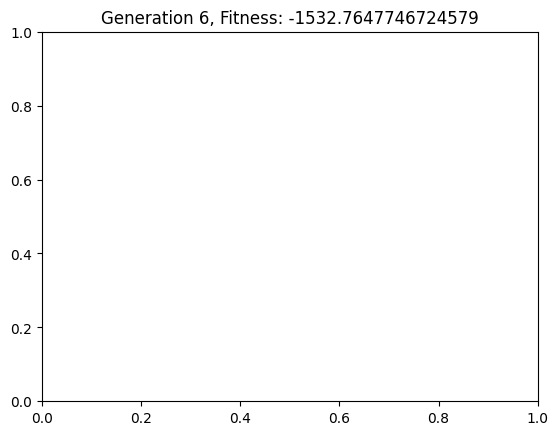

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 386), 'size': (209, 123)}, {'name': 'Bedroom2', 'position': (340, 389), 'size': (114, 210)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1537.2808023966172}


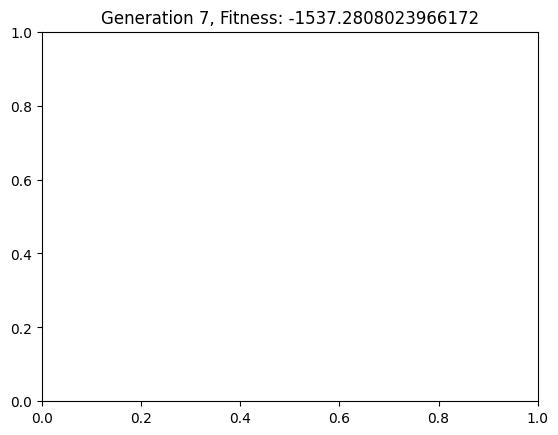

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 382), 'size': (217, 127)}, {'name': 'Bedroom2', 'position': (336, 389), 'size': (118, 218)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1542.2163545772619}


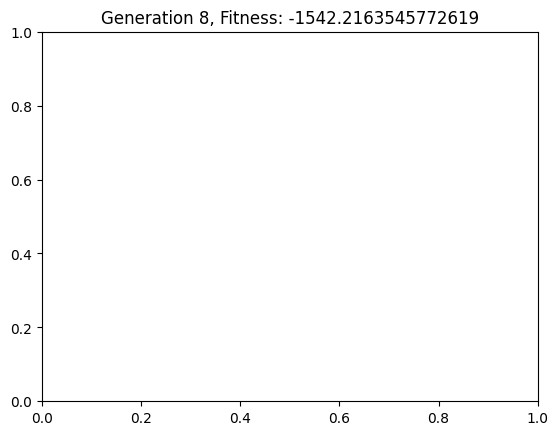

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 378), 'size': (225, 131)}, {'name': 'Bedroom2', 'position': (332, 389), 'size': (122, 226)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1546.6499849509628}


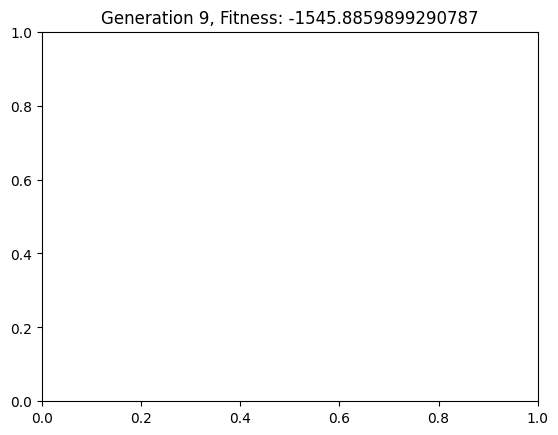

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 374), 'size': (233, 135)}, {'name': 'Bedroom2', 'position': (328, 388), 'size': (126, 233)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1545.8859899290787}


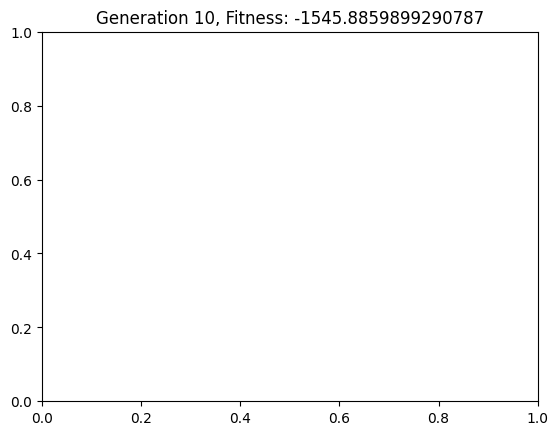

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 370), 'size': (241, 139)}, {'name': 'Bedroom2', 'position': (324, 385), 'size': (130, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1553.2638478353954}


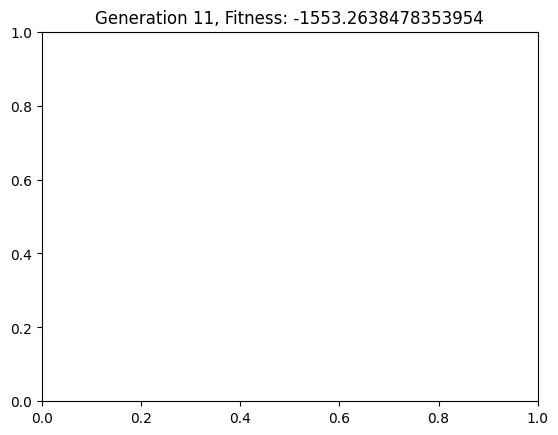

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 366), 'size': (249, 143)}, {'name': 'Bedroom2', 'position': (320, 385), 'size': (134, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1555.546158247372}


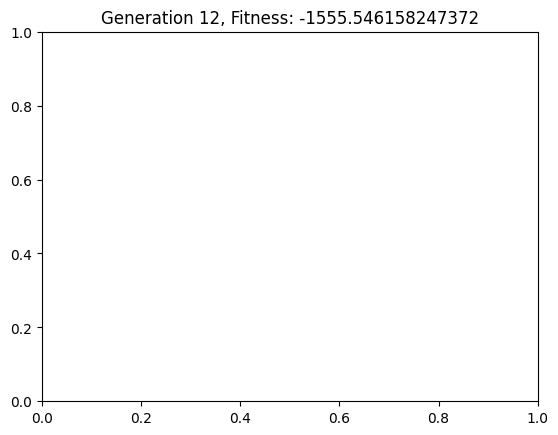

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 362), 'size': (257, 147)}, {'name': 'Bedroom2', 'position': (316, 385), 'size': (138, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1558.5341425215456}


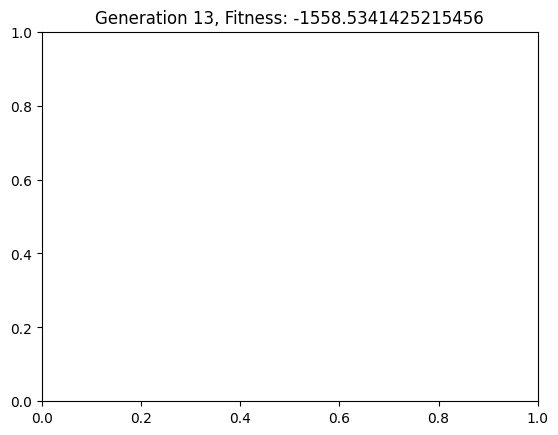

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 358), 'size': (265, 151)}, {'name': 'Bedroom2', 'position': (312, 385), 'size': (142, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1561.261864005958}


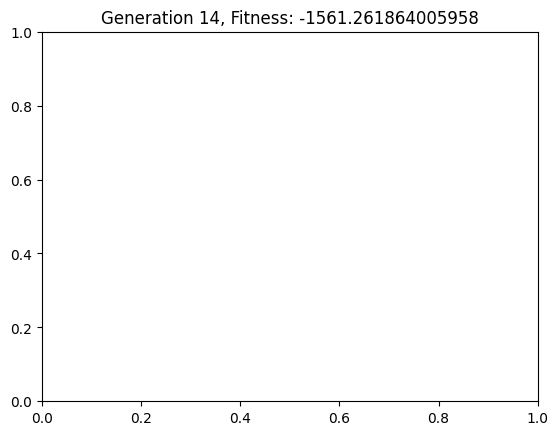

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 355), 'size': (273, 154)}, {'name': 'Bedroom2', 'position': (308, 385), 'size': (146, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1562.7585983478264}


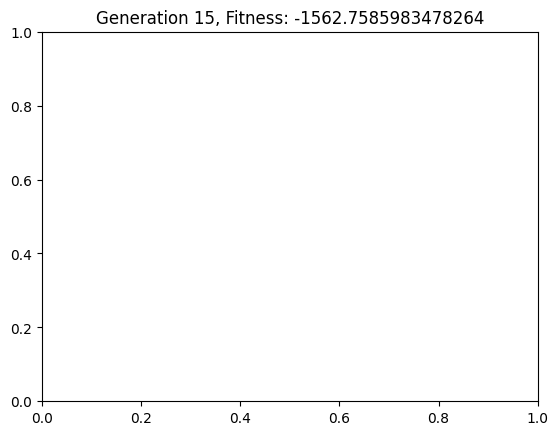

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 355), 'size': (281, 154)}, {'name': 'Bedroom2', 'position': (304, 385), 'size': (150, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1564.7056922307565}


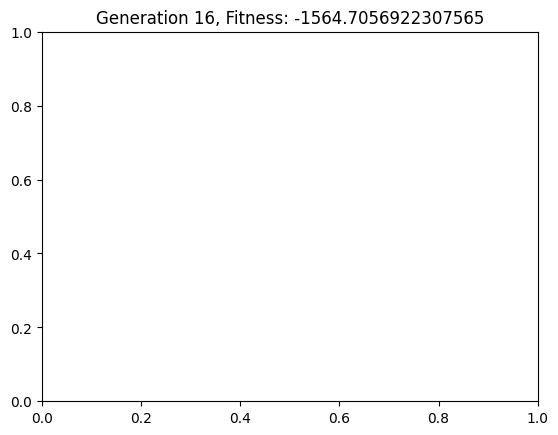

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 355), 'size': (289, 154)}, {'name': 'Bedroom2', 'position': (300, 385), 'size': (154, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1565.4830487125425}


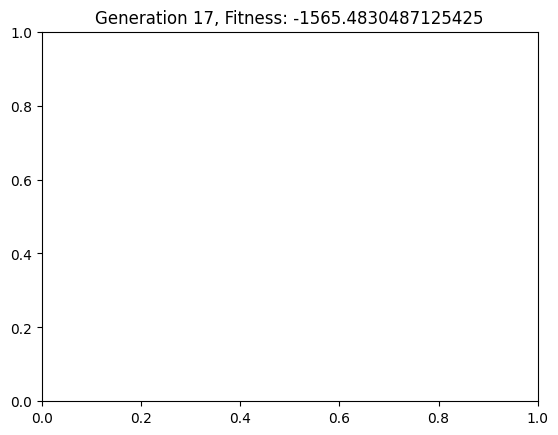

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 355), 'size': (297, 154)}, {'name': 'Bedroom2', 'position': (296, 385), 'size': (158, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1566.4770105802108}


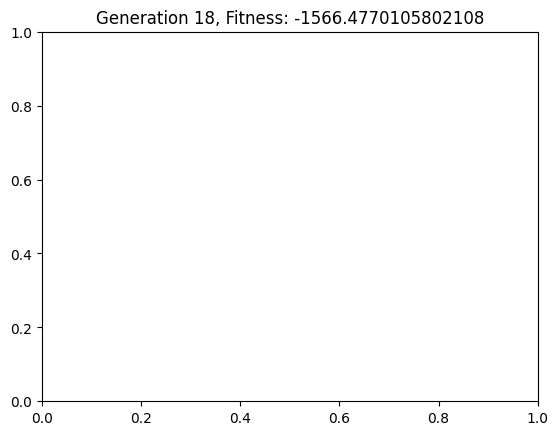

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 355), 'size': (305, 154)}, {'name': 'Bedroom2', 'position': (292, 385), 'size': (162, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1567.9136740173533}


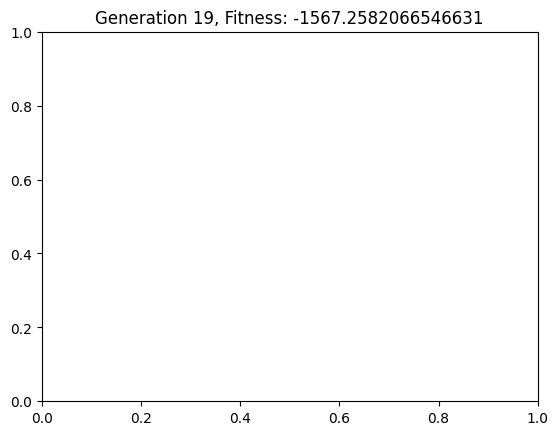

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 355), 'size': (313, 154)}, {'name': 'Bedroom2', 'position': (288, 385), 'size': (166, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1567.2582066546631}


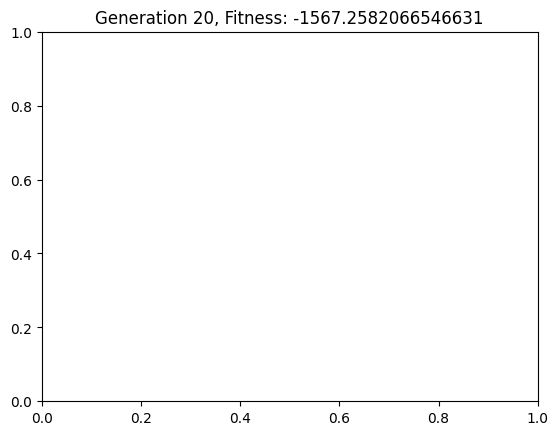

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 355), 'size': (321, 154)}, {'name': 'Bedroom2', 'position': (284, 385), 'size': (170, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1569.5223286485475}


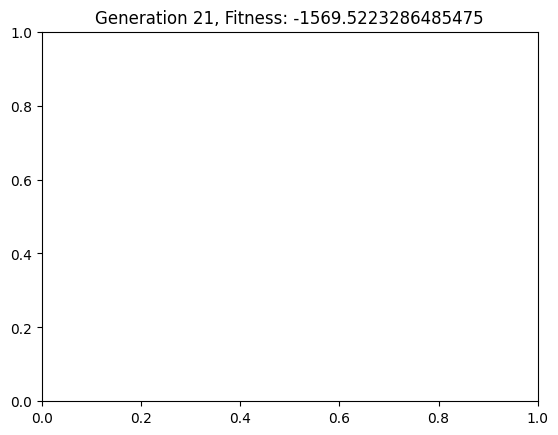

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 355), 'size': (329, 154)}, {'name': 'Bedroom2', 'position': (280, 385), 'size': (174, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1570.7111739261454}


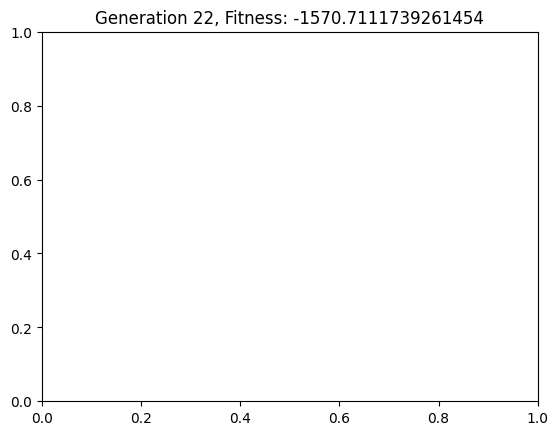

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 355), 'size': (337, 154)}, {'name': 'Bedroom2', 'position': (276, 385), 'size': (178, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1571.832417475977}


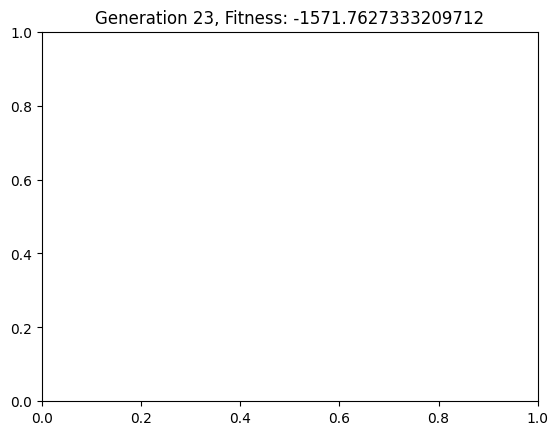

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 355), 'size': (345, 154)}, {'name': 'Bedroom2', 'position': (272, 385), 'size': (182, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1571.7627333209712}


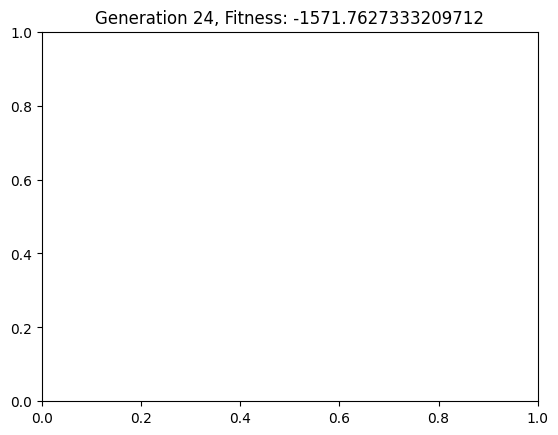

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 355), 'size': (353, 154)}, {'name': 'Bedroom2', 'position': (268, 385), 'size': (186, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1572.8951166660297}


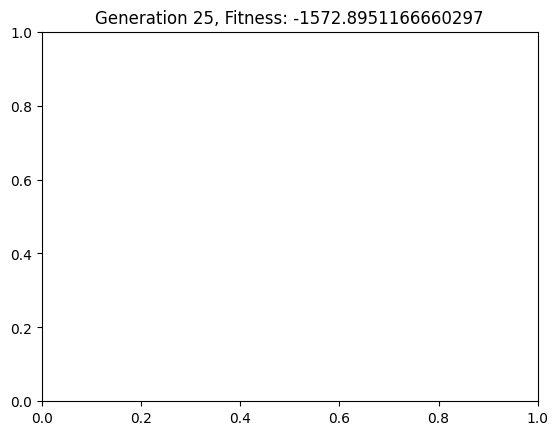

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 355), 'size': (361, 154)}, {'name': 'Bedroom2', 'position': (264, 385), 'size': (190, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1573.8464047657362}


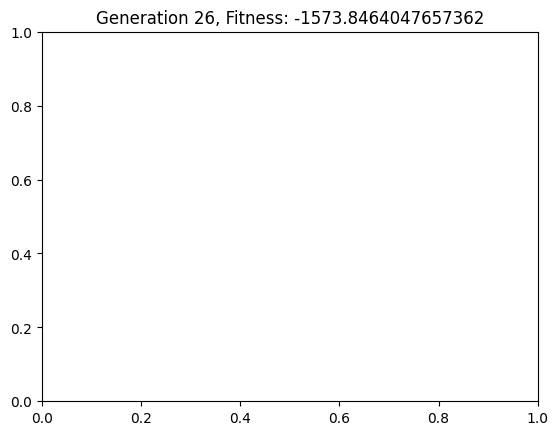

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (607, 355), 'size': (369, 154)}, {'name': 'Bedroom2', 'position': (260, 385), 'size': (194, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1574.7499554850615}


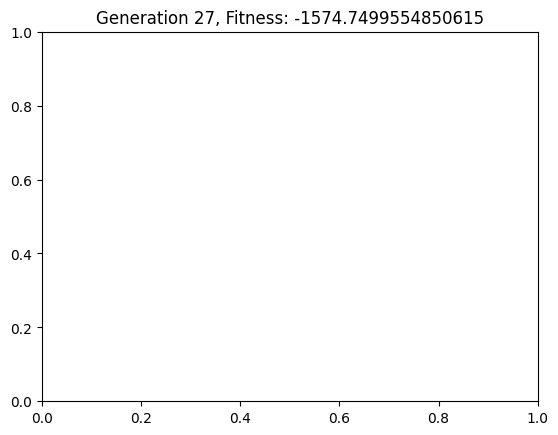

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (256, 385), 'size': (198, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1575.6094260745817}


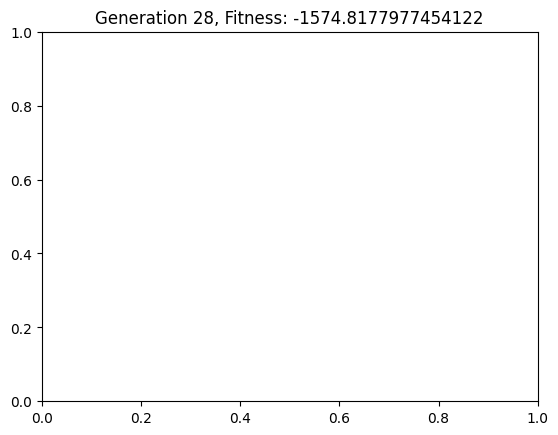

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (252, 385), 'size': (202, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1574.8177977454122}


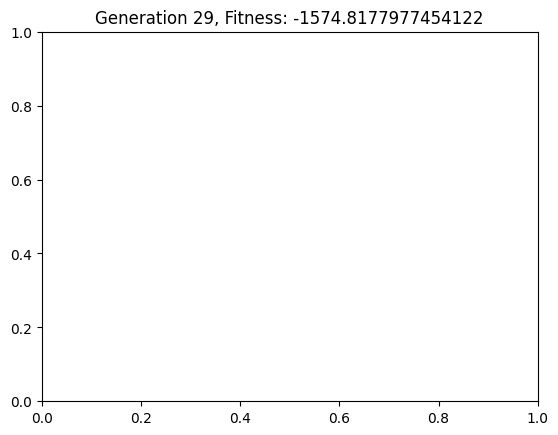

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (248, 385), 'size': (206, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1574.8177977454122}


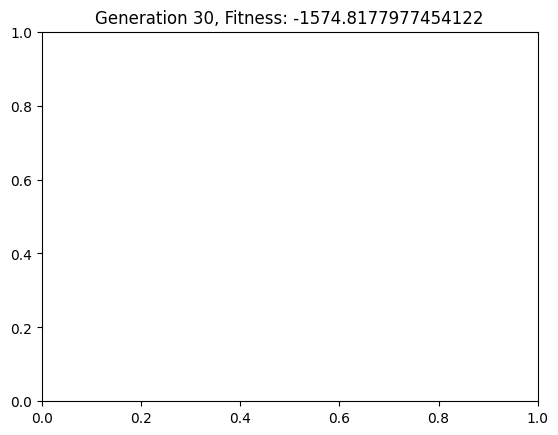

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (244, 385), 'size': (210, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1574.8177977454122}


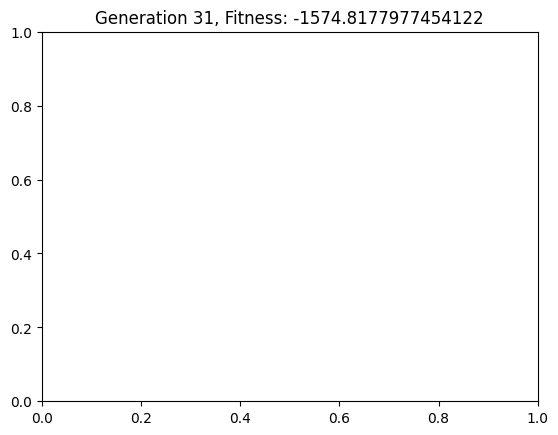

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (240, 385), 'size': (214, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1574.8177977454122}


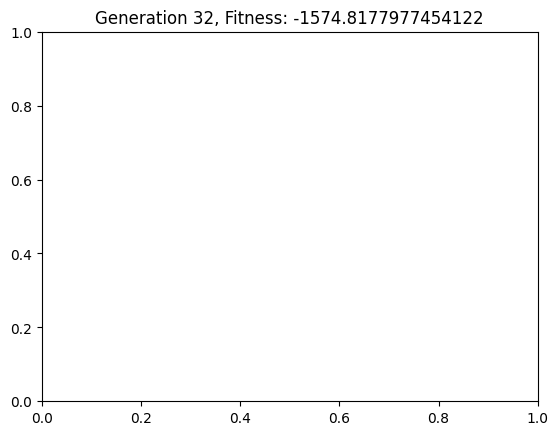

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (236, 385), 'size': (218, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1574.8177977454122}


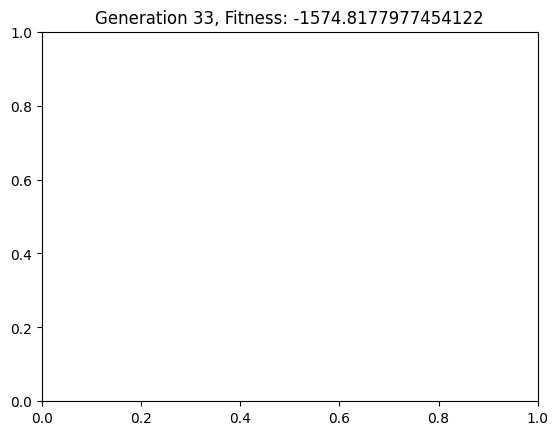

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (232, 385), 'size': (222, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1574.8177977454122}


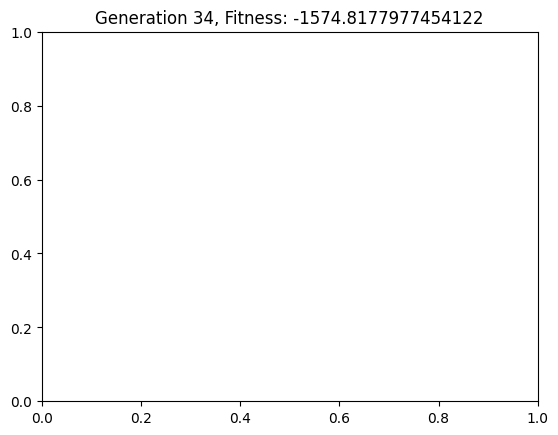

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (228, 385), 'size': (226, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1574.8177977454122}


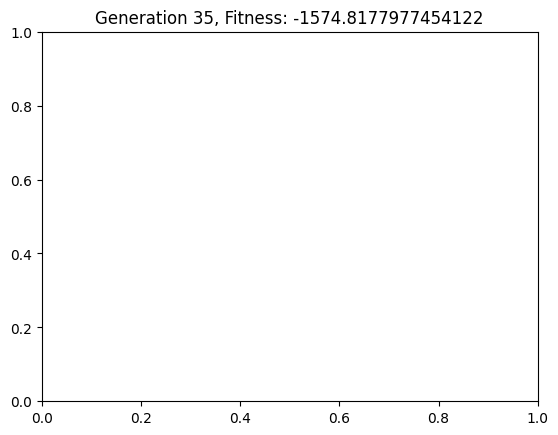

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (224, 385), 'size': (230, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1574.8177977454122}


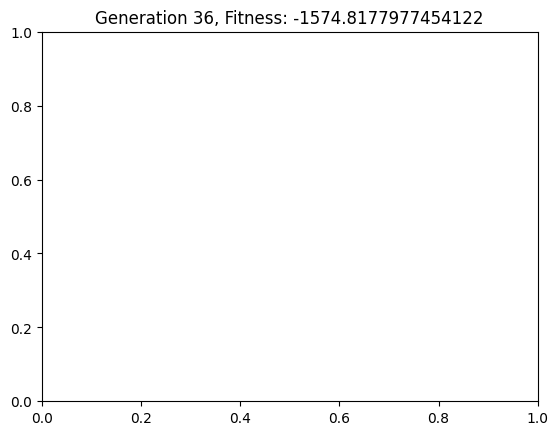

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (220, 385), 'size': (234, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1574.8177977454122}


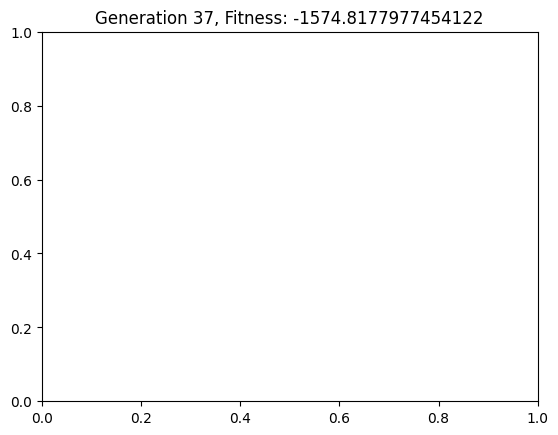

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (216, 385), 'size': (238, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1574.8177977454122}


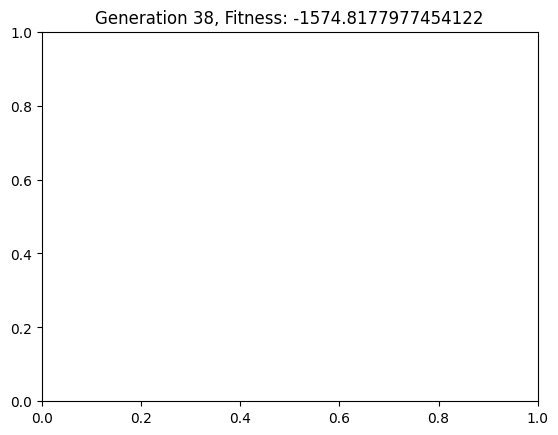

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (215, 385), 'size': (240, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1574.8177977454122}


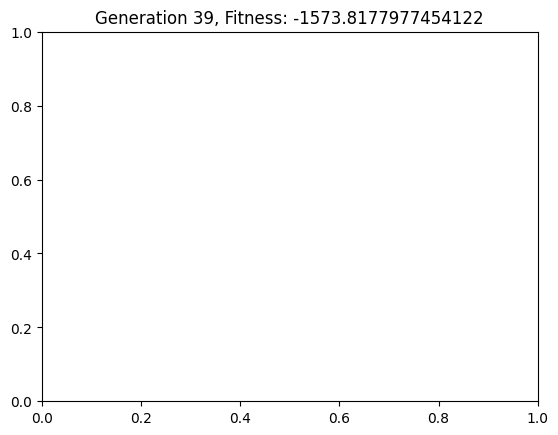

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (215, 385), 'size': (240, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1573.8177977454122}


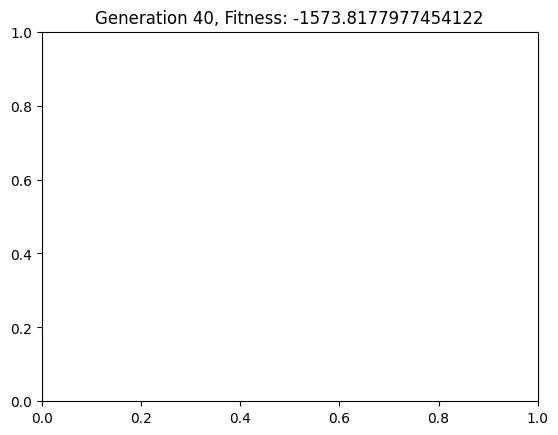

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (215, 385), 'size': (240, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1573.8177977454122}


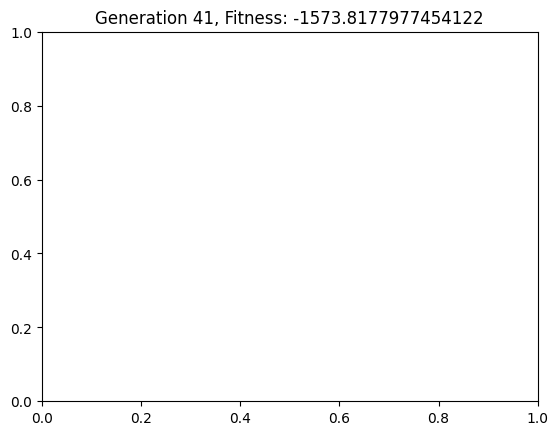

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (215, 385), 'size': (240, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1573.8177977454122}


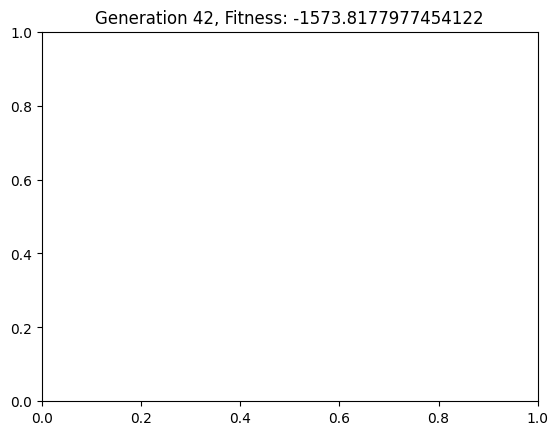

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (215, 385), 'size': (240, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1573.8177977454122}


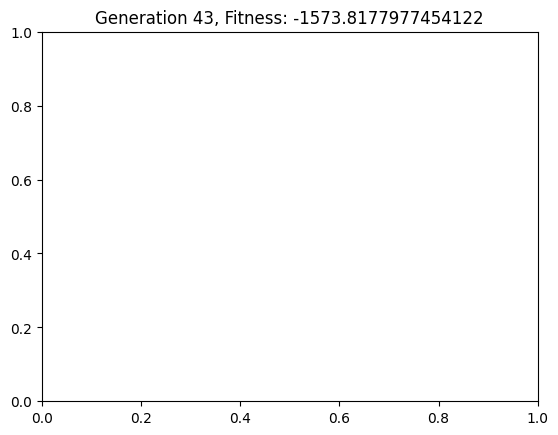

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (215, 385), 'size': (240, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1573.8177977454122}


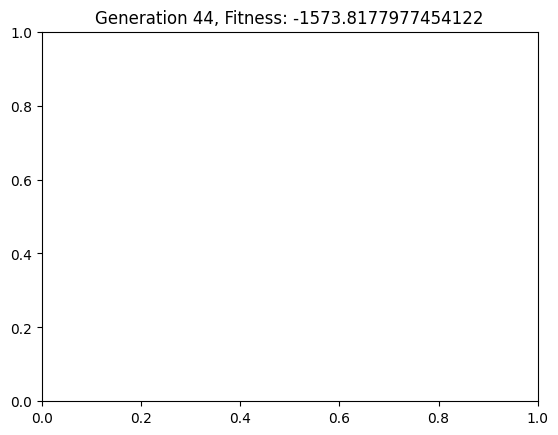

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (215, 385), 'size': (240, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1573.8177977454122}


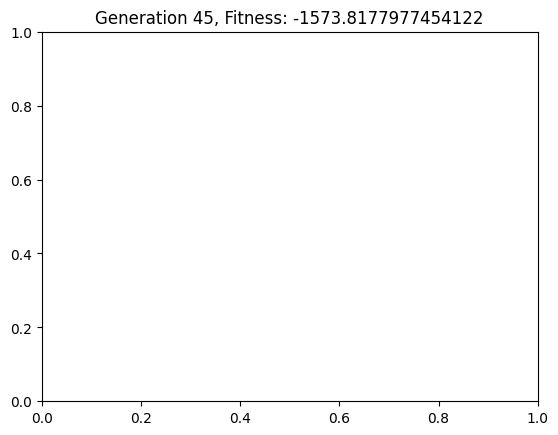

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (215, 385), 'size': (240, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1573.8177977454122}


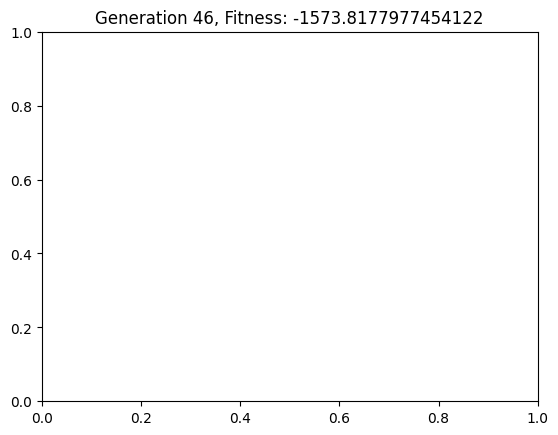

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (215, 385), 'size': (240, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1573.8177977454122}


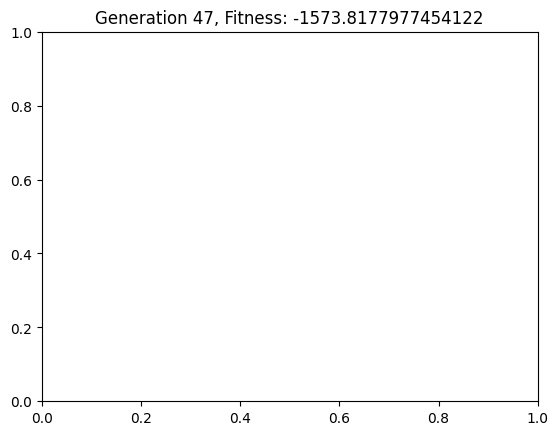

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (215, 385), 'size': (240, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1573.8177977454122}


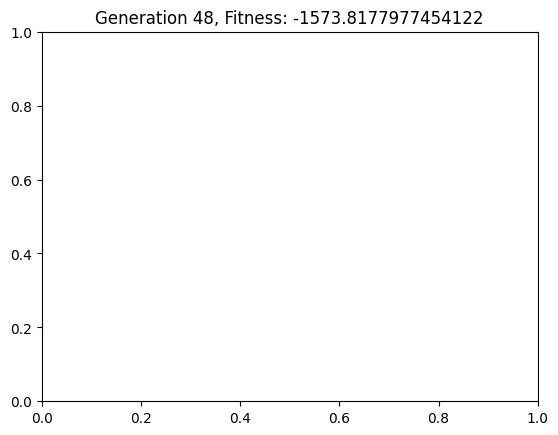

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (215, 385), 'size': (240, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1573.8177977454122}


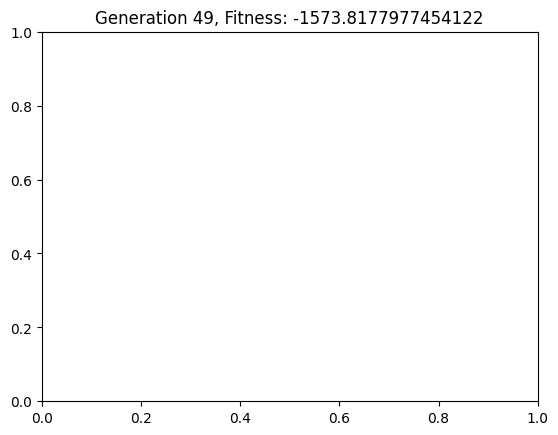

{'rooms': [{'name': 'Living Room', 'position': (251, 258), 'size': (203, 127)}, {'name': 'Bedroom1', 'position': (606, 355), 'size': (371, 154)}, {'name': 'Bedroom2', 'position': (215, 385), 'size': (240, 236)}, {'name': 'Passage', 'position': (455, 356), 'size': (151, 79)}, {'name': 'Kitchen', 'position': (372, 296), 'size': (153, 77)}, {'name': 'Washroom', 'position': (589, 303), 'size': (97, 52)}], 'fitness': -1573.8177977454122}
Elapsed time: 913.08 seconds


<Figure size 640x480 with 0 Axes>

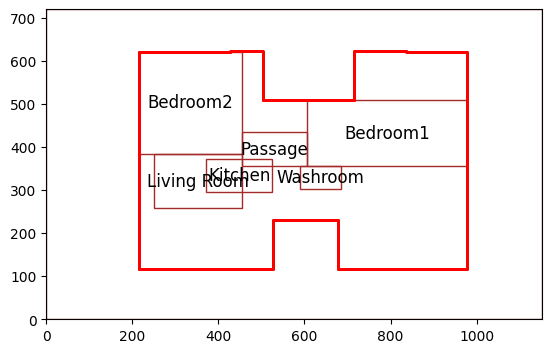

Elapsed time for initial population generation: 39.95 seconds


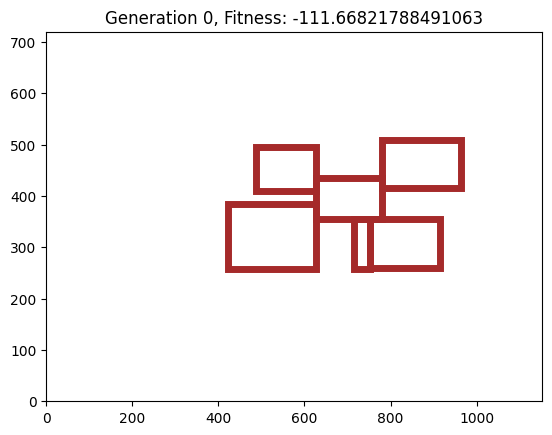

{'rooms': [{'name': 'Living Room', 'position': (423, 257), 'size': (203, 127)}, {'name': 'Passage', 'position': (627, 356), 'size': (153, 78)}, {'name': 'Kitchen', 'position': (487, 409), 'size': (139, 86)}, {'name': 'Washroom', 'position': (715, 257), 'size': (37, 98)}, {'name': 'Bedroom1', 'position': (781, 415), 'size': (182, 94)}, {'name': 'Bedroom2', 'position': (752, 259), 'size': (164, 96)}], 'fitness': -111.66821788491063}


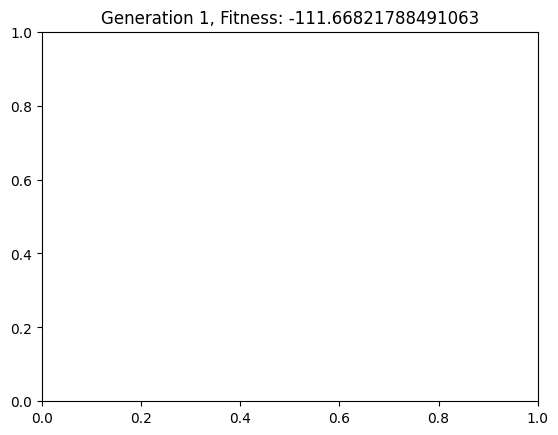

{'rooms': [{'name': 'Living Room', 'position': (423, 257), 'size': (204, 128)}, {'name': 'Passage', 'position': (627, 356), 'size': (154, 79)}, {'name': 'Kitchen', 'position': (487, 409), 'size': (139, 86)}, {'name': 'Washroom', 'position': (714, 287), 'size': (38, 68)}, {'name': 'Bedroom1', 'position': (781, 415), 'size': (183, 95)}, {'name': 'Bedroom2', 'position': (752, 259), 'size': (164, 96)}], 'fitness': -111.66821788491063}


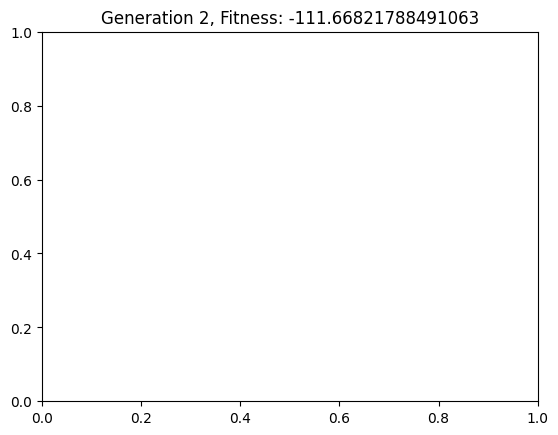

{'rooms': [{'name': 'Living Room', 'position': (421, 257), 'size': (205, 131)}, {'name': 'Passage', 'position': (626, 356), 'size': (155, 81)}, {'name': 'Kitchen', 'position': (487, 409), 'size': (139, 86)}, {'name': 'Washroom', 'position': (711, 279), 'size': (41, 76)}, {'name': 'Bedroom1', 'position': (781, 415), 'size': (185, 97)}, {'name': 'Bedroom2', 'position': (752, 258), 'size': (166, 97)}], 'fitness': -170.2846891407378}


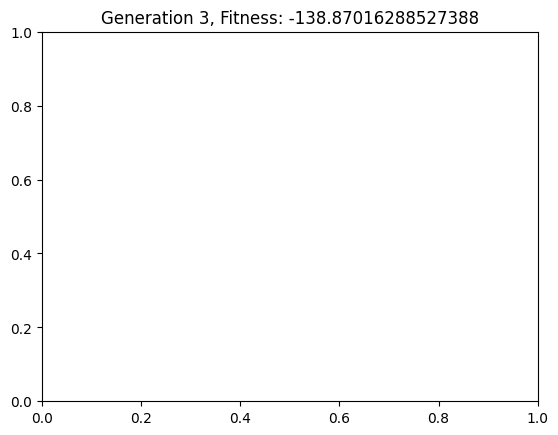

{'rooms': [{'name': 'Living Room', 'position': (421, 256), 'size': (204, 129)}, {'name': 'Bedroom1', 'position': (781, 415), 'size': (190, 102)}, {'name': 'Bedroom2', 'position': (752, 256), 'size': (170, 99)}, {'name': 'Passage', 'position': (626, 356), 'size': (155, 86)}, {'name': 'Kitchen', 'position': (487, 409), 'size': (139, 86)}, {'name': 'Washroom', 'position': (704, 280), 'size': (48, 76)}], 'fitness': -138.87016288527388}


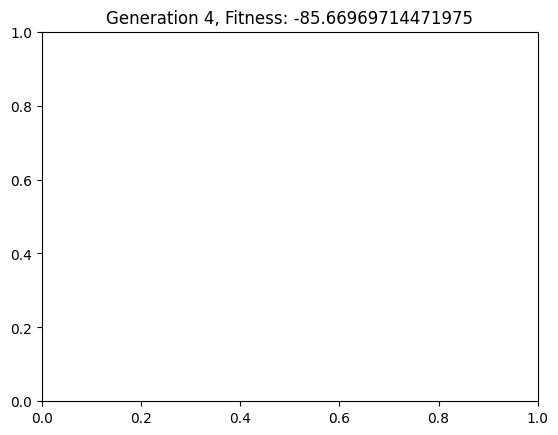

{'rooms': [{'name': 'Living Room', 'position': (414, 257), 'size': (211, 144)}, {'name': 'Bedroom1', 'position': (781, 415), 'size': (193, 105)}, {'name': 'Bedroom2', 'position': (752, 254), 'size': (189, 101)}, {'name': 'Passage', 'position': (626, 356), 'size': (155, 91)}, {'name': 'Kitchen', 'position': (487, 409), 'size': (139, 86)}, {'name': 'Washroom', 'position': (696, 256), 'size': (56, 99)}], 'fitness': -85.66969714471975}


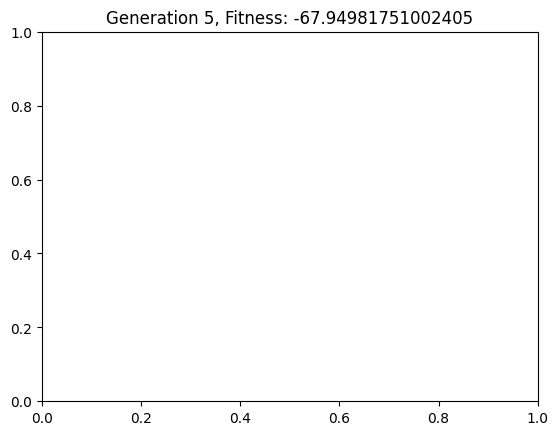

{'rooms': [{'name': 'Living Room', 'position': (412, 257), 'size': (213, 148)}, {'name': 'Bedroom1', 'position': (781, 415), 'size': (196, 109)}, {'name': 'Bedroom2', 'position': (752, 252), 'size': (193, 103)}, {'name': 'Passage', 'position': (626, 356), 'size': (155, 95)}, {'name': 'Kitchen', 'position': (487, 409), 'size': (139, 86)}, {'name': 'Washroom', 'position': (688, 230), 'size': (64, 125)}], 'fitness': -67.94981751002405}


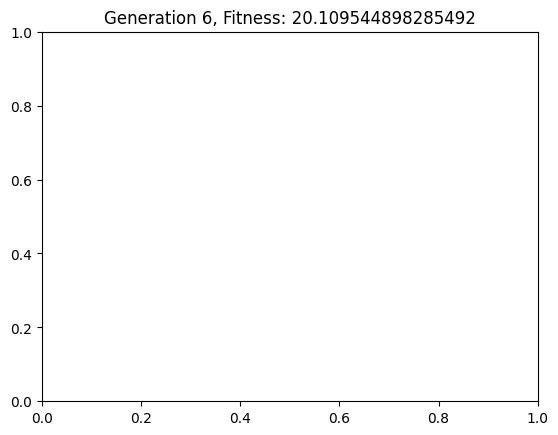

{'rooms': [{'name': 'Living Room', 'position': (414, 256), 'size': (211, 143)}, {'name': 'Bedroom1', 'position': (781, 415), 'size': (196, 117)}, {'name': 'Bedroom2', 'position': (752, 249), 'size': (185, 107)}, {'name': 'Passage', 'position': (626, 356), 'size': (155, 103)}, {'name': 'Kitchen', 'position': (487, 409), 'size': (139, 86)}, {'name': 'Washroom', 'position': (680, 237), 'size': (72, 119)}], 'fitness': 20.109544898285492}


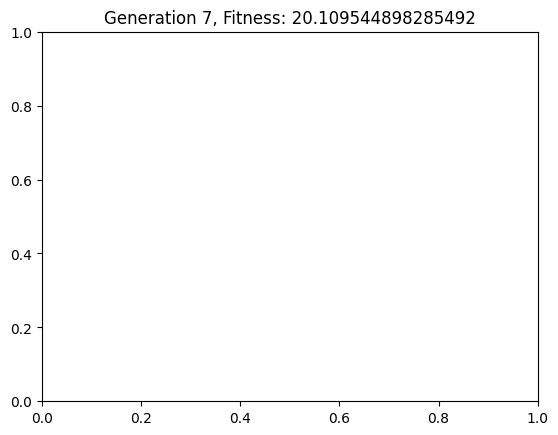

{'rooms': [{'name': 'Living Room', 'position': (410, 256), 'size': (215, 151)}, {'name': 'Bedroom1', 'position': (781, 415), 'size': (196, 125)}, {'name': 'Bedroom2', 'position': (752, 245), 'size': (193, 111)}, {'name': 'Passage', 'position': (626, 356), 'size': (155, 108)}, {'name': 'Kitchen', 'position': (487, 409), 'size': (139, 86)}, {'name': 'Washroom', 'position': (677, 232), 'size': (75, 124)}], 'fitness': -212.5449250919357}


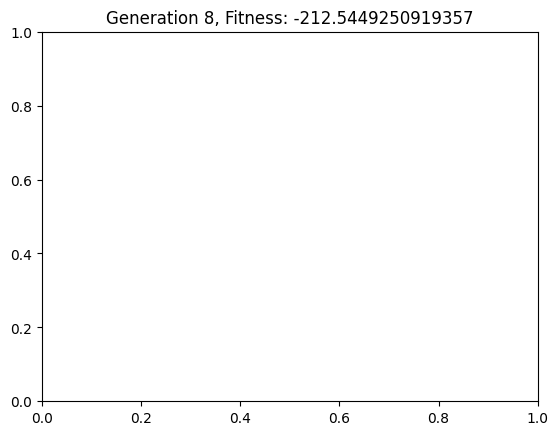

{'rooms': [{'name': 'Living Room', 'position': (406, 253), 'size': (219, 156)}, {'name': 'Bedroom1', 'position': (781, 415), 'size': (196, 133)}, {'name': 'Bedroom2', 'position': (752, 241), 'size': (201, 115)}, {'name': 'Passage', 'position': (626, 356), 'size': (155, 108)}, {'name': 'Kitchen', 'position': (487, 409), 'size': (139, 86)}, {'name': 'Washroom', 'position': (676, 230), 'size': (76, 126)}], 'fitness': -217.3787731370607}


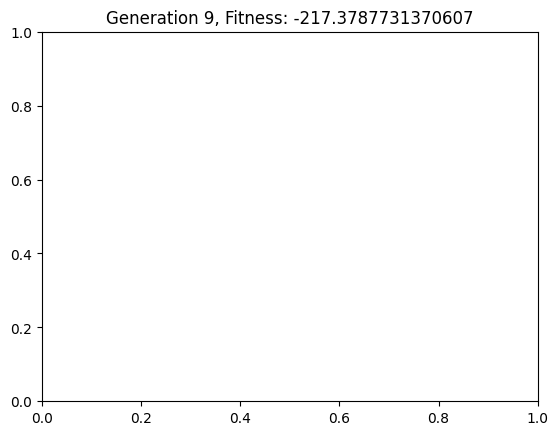

{'rooms': [{'name': 'Living Room', 'position': (402, 249), 'size': (223, 160)}, {'name': 'Bedroom1', 'position': (781, 415), 'size': (196, 141)}, {'name': 'Bedroom2', 'position': (752, 237), 'size': (209, 119)}, {'name': 'Passage', 'position': (626, 356), 'size': (155, 108)}, {'name': 'Kitchen', 'position': (487, 409), 'size': (139, 86)}, {'name': 'Washroom', 'position': (675, 230), 'size': (77, 126)}], 'fitness': -222.5597457439772}


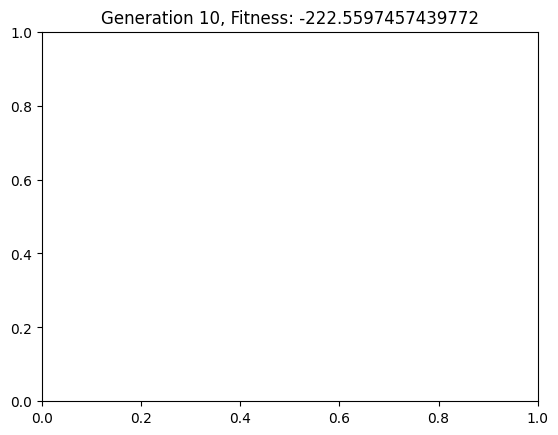

{'rooms': [{'name': 'Living Room', 'position': (398, 245), 'size': (227, 164)}, {'name': 'Bedroom1', 'position': (781, 415), 'size': (196, 149)}, {'name': 'Bedroom2', 'position': (752, 233), 'size': (217, 123)}, {'name': 'Passage', 'position': (626, 356), 'size': (155, 108)}, {'name': 'Kitchen', 'position': (487, 409), 'size': (139, 86)}, {'name': 'Washroom', 'position': (675, 230), 'size': (77, 126)}], 'fitness': -228.85280669152664}


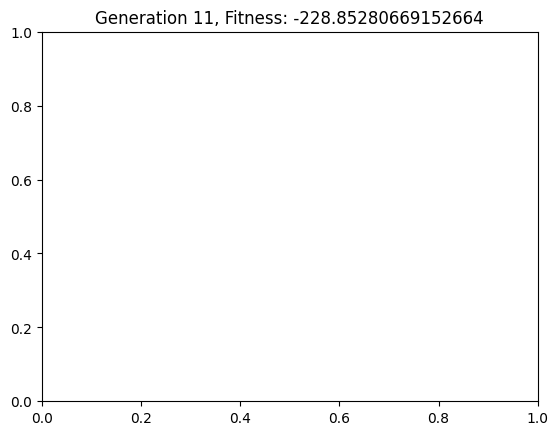

{'rooms': [{'name': 'Living Room', 'position': (394, 241), 'size': (231, 168)}, {'name': 'Bedroom1', 'position': (781, 415), 'size': (196, 157)}, {'name': 'Bedroom2', 'position': (752, 229), 'size': (225, 127)}, {'name': 'Passage', 'position': (626, 356), 'size': (155, 108)}, {'name': 'Kitchen', 'position': (487, 409), 'size': (139, 86)}, {'name': 'Washroom', 'position': (674, 230), 'size': (78, 125)}], 'fitness': -233.0208468843934}


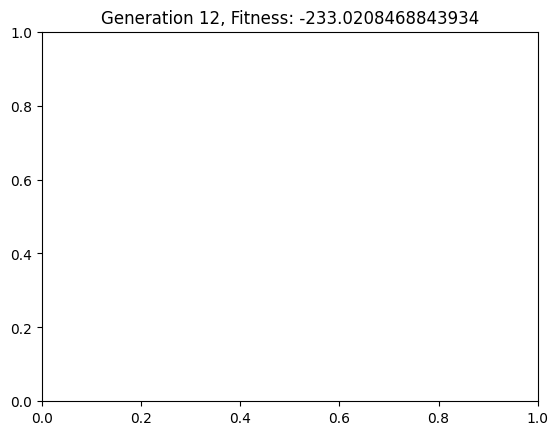

{'rooms': [{'name': 'Living Room', 'position': (390, 237), 'size': (235, 172)}, {'name': 'Bedroom1', 'position': (781, 415), 'size': (196, 165)}, {'name': 'Bedroom2', 'position': (752, 225), 'size': (225, 131)}, {'name': 'Passage', 'position': (626, 356), 'size': (155, 108)}, {'name': 'Kitchen', 'position': (487, 409), 'size': (139, 86)}, {'name': 'Washroom', 'position': (674, 230), 'size': (78, 125)}], 'fitness': -238.43554047778102}


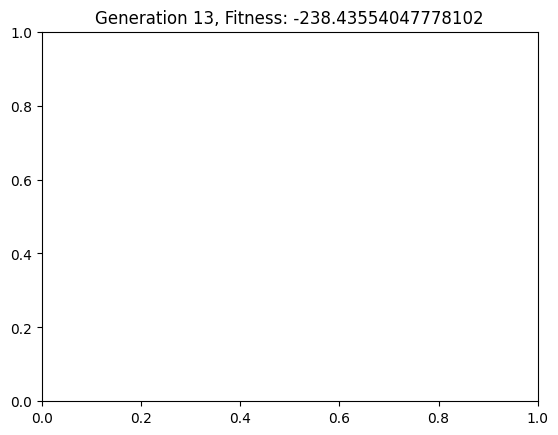

{'rooms': [{'name': 'Living Room', 'position': (386, 233), 'size': (239, 176)}, {'name': 'Bedroom1', 'position': (781, 415), 'size': (196, 173)}, {'name': 'Bedroom2', 'position': (752, 221), 'size': (225, 135)}, {'name': 'Passage', 'position': (626, 356), 'size': (155, 108)}, {'name': 'Kitchen', 'position': (487, 409), 'size': (139, 86)}, {'name': 'Washroom', 'position': (674, 230), 'size': (78, 125)}], 'fitness': -242.36421681963236}


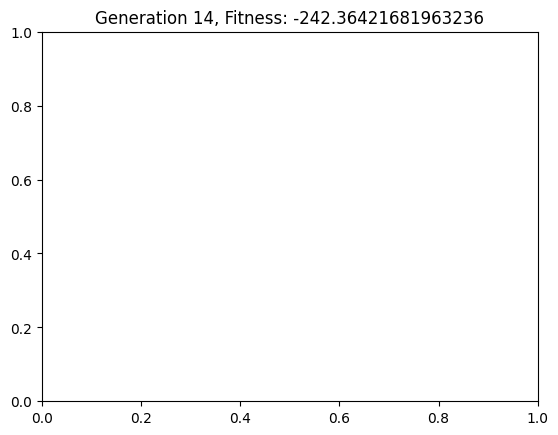

{'rooms': [{'name': 'Living Room', 'position': (382, 230), 'size': (243, 179)}, {'name': 'Bedroom1', 'position': (781, 415), 'size': (196, 181)}, {'name': 'Bedroom2', 'position': (752, 217), 'size': (225, 139)}, {'name': 'Passage', 'position': (626, 356), 'size': (155, 108)}, {'name': 'Kitchen', 'position': (487, 409), 'size': (139, 86)}, {'name': 'Washroom', 'position': (673, 230), 'size': (79, 126)}], 'fitness': -247.21467199910256}


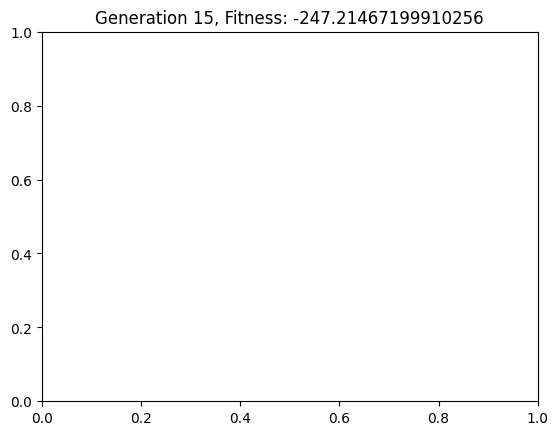

{'rooms': [{'name': 'Living Room', 'position': (378, 230), 'size': (247, 179)}, {'name': 'Bedroom1', 'position': (781, 415), 'size': (196, 189)}, {'name': 'Bedroom2', 'position': (752, 213), 'size': (225, 143)}, {'name': 'Passage', 'position': (626, 356), 'size': (155, 108)}, {'name': 'Kitchen', 'position': (487, 409), 'size': (139, 86)}, {'name': 'Washroom', 'position': (673, 230), 'size': (79, 126)}], 'fitness': -253.34409844795405}


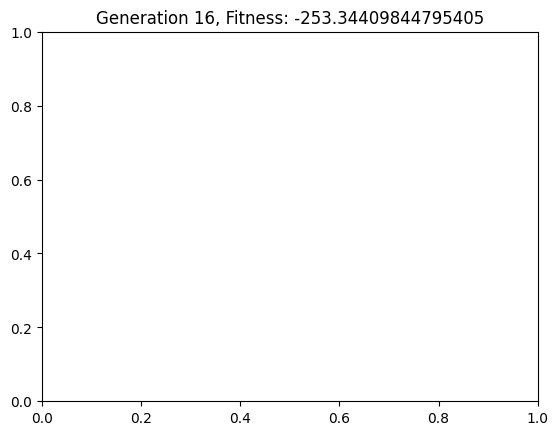

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from shapely.geometry import Polygon
# from test import population as population_final
from input_converter import *
import random
from skimage import measure
global i1
i1 = 0
from pix_array import floorArray
import time
import sys
from numba import jit
import copy


def find_closest_point_brute_force(void_x, void_y,floor_plan,target_rooms=["Kitchen", "Washroom", "Bedroom1"]):
  """
  This function finds the closest point to a given point using a brute force approach.

  Args:
      point: A tuple representing the reference point (x1, y1).
      points: A list of tuples representing points (x2, y2).

  Returns:
      A tuple representing the closest point (x2, y2) and its distance to the reference point.
  """
  closest_point = None
  min_distance = float('inf')  # Initialize with positive infinity
  rooms= floor_plan["rooms"]
  for room in rooms:
    if room["name"] in target_rooms:
    # Calculate distance using distance formula

        distance = ((room['position'][0] - void_x)**2 + (room['position'][1] - void_y)**2)**0.5
        if distance < min_distance:
            min_distance = distance
            closest_point = room["position"]
            room_name = room["name"]

  return closest_point, room_name


class RoomPlanner(object):
    def __init__(self, PLOT_SIZE=(80, 120), MIN_ROOM_SIZE=(10, 10), NUM_BEDROOMS=3,
                 POPULATION_SIZE=80, NUM_GENERATIONS=50, MUTATION_RATE=2,
                 MAX_MUTATION_PERCENTAGE=0.1, SIZE_INCREASE_FACTOR=1,
                 COLLISION_RESOLUTION_STEPS=10, MIN_NUM_ROOMS=2,
                 GRID_SIZE=(10, 10), MIN_AREA=10, path=r"/content/test_plot.png"):
        self.PLOT_SIZE = PLOT_SIZE
        self.MIN_ROOM_SIZE = MIN_ROOM_SIZE
        self.NUM_BEDROOMS = NUM_BEDROOMS
        self.POPULATION_SIZE = POPULATION_SIZE
        self.NUM_GENERATIONS = NUM_GENERATIONS
        self.MUTATION_RATE = MUTATION_RATE
        self.MAX_MUTATION_PERCENTAGE = MAX_MUTATION_PERCENTAGE
        self.SIZE_INCREASE_FACTOR = SIZE_INCREASE_FACTOR
        self.COLLISION_RESOLUTION_STEPS = COLLISION_RESOLUTION_STEPS
        self.MIN_NUM_ROOMS = MIN_NUM_ROOMS
        self.GRID_SIZE = GRID_SIZE
        self.MIN_AREA = MIN_AREA
        self.BEDROOM_SIZE = (10, 10)
        self.MIN_KITCHEN_SIZE = (15,15*1.5)
        self.APPROXIMATION_FACTOR = 0.5
        self.MAX_XY_RATIO = 1.8
        self.MIN_XY_RATIO = 1.5
        self.MIN_LIVING_ROOM_SIZE = (20, 20)
        self.BEDROOM_FACTOR = 0.35
        self.KITCHEN_FACTOR = 0.10
        self.LIVING_ROOM_FACTOR = 0.4
        self.MIN_LIVING_ROOM_SIZE = (45,45)
        # pri_useless_t("gen change")
        # path= "test_plot.png"
        self.floor_plan_array = floorArray(path)
        self.floor_plan_set = set()
        self.PLOT_SIZE = (self.floor_plan_array.shape[1], self.floor_plan_array.shape[0])
        self.path = path
        self.self_neighbours = [[], [], []] # [lr_neig, passage_neig, kitchen_neig, br1_neig, ... , bri_neig]


    def check_overlap(self, position1, size1, position2, size2):
        return (position1[0] < position2[0] + size2[0] and position1[0] + size1[0] > position2[0] and position1[1] < position2[1] + size2[1] and position1[1] + size1[1] > position2[1])

    def generate_initial_population(self, ax, generation, stime):
        population = [] # 1st to last
        array_population = []
        # fit_score = -sys.maxsize - 1
        for _ in range(self.POPULATION_SIZE):
            fp, array_fp = self.generate_random_rooms(ax, generation)
            population.append(fp)
            array_population.append(array_fp)
            # if(fp['fitness']>fit_score):
        mtime = time.time()

        elapsed_time = mtime - stime
        print(f"Elapsed time for initial population generation: {elapsed_time:.2f} seconds")
        return population, array_population





    def generate_random_rooms(self, ax, generation):
        rooms = {'rooms': [], 'fitness': 0}
        room_positions, array_fp = initial_population(self.path)
        try:
            living_room = {'name': 'Living Room', 'position': room_positions['living room']['vertex'], 'size': (room_positions['living room']['length'], room_positions['living room']['breadth'])}
            rooms['rooms'].append(living_room)
        except:
           print("No Living room")
        try:
            passage = {'name': 'Passage', 'position': room_positions['passage']['vertex'], 'size': (room_positions['passage']['length'], room_positions['passage']['breadth'])}
            rooms['rooms'].append(passage)
        except:
           print("No passage")
        try:
            kitchen = {'name': 'Kitchen', 'position': room_positions['kitchen']['vertex'], 'size': (room_positions['kitchen']['length'], room_positions['kitchen']['breadth'])}
            rooms['rooms'].append(kitchen)
        except:
           print("No Kitchen")
        try:
            wc = {'name': 'Washroom', 'position': room_positions['bathroom']['vertex'], 'size': (room_positions['bathroom']['length'], room_positions['bathroom']['breadth'])}
            rooms['rooms'].append(wc)
        except:
           print("No Washroom")
        try:
            bedroom = {'name': 'Bedroom' + str(1), 'position': room_positions['bedroom']['vertex'], 'size': (room_positions['bedroom']['length'], room_positions['bedroom']['breadth'])}
            rooms['rooms'].append(bedroom)
            bedroom = {'name': 'Bedroom' + str(2), 'position': room_positions['bedroom2']['vertex'], 'size': (room_positions['bedroom2']['length'], room_positions['bedroom2']['breadth'])}
            rooms['rooms'].append(bedroom)
        except:
           print("No Bedroom")

        rooms['fitness'] = self.calculate_fitness(rooms['rooms'],ax)
        return rooms, array_fp

    #************************************************************************************************************************************************************************************

    import numpy as np
    from shapely.geometry import Polygon
    import random

    # TODO: VERIFIED
    def get_centroid(self,room):
        x1 = room['position'][0]
        y1 = room['position'][1]
        x2 = room['position'][0] + room['size'][0]
        y2 = room['position'][1]
        x3 = room['position'][0] + room['size'][0]
        y3 = room['position'][1] + room['size'][1]
        x4 = room['position'][0]
        y4 = room['position'][1] + room['size'][1]
        vertices = [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
        n = len(vertices)
        A = 0
        Cx = 0
        Cy = 0

        for i in range(n):
            x_i, y_i = vertices[i]
            x_ip1, y_ip1 = vertices[(i + 1) % n]
            cross_product = (x_i * y_ip1) - (x_ip1 * y_i)
            A += cross_product
            Cx += (x_i + x_ip1) * cross_product
            Cy += (y_i + y_ip1) * cross_product

        A *= 0.5
        Cx /= (6 * A)
        Cy /= (6 * A)

        return (Cx, Cy)

#************************************************************************************************************************************************************************************

    # TODO: VERIFIED
    def get_total_plot_area(self):
        plot = self.load_plot(r"/content/final_plot.txt")
        plot_vertices = self.find_plot_vertices(plot)
        plot_polygon = Polygon(plot_vertices)
        return plot_polygon.area

    def get_area_fitness(self, room_list):
        """
        # input like [{'name': 'By_laws', 'position": (60.8,
            # 108.8), 'size': (19.2, 11.2)), {'name': 'Living Room', 'position': (12,
            # 71), 'size': (68, 49)}, {'name': 'Passage', 'position': (0, 25), 'size': (12, 81)}, (name: Kitchen, position: (0, 51), size: (12, 25)), {'name': 'Bedroom1', 'position': (12, 12), 'size': (30, 30)}, ('name':
            # 'Washroom', 'position': (32, 32), 'size': (7.5, 7)}]
        """
        area = 0
        for room in room_list:
            # input : {'name': 'Living Room', 'position': (12, 71), 'size': (68, 49)}
            x1 = room['position'][0]
            y1 = room['position'][1]
            x2 = room['position'][0] + room['size'][0]
            y2 = room['position'][1] + room['size'][1]
            coordinates = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
            polygon = Polygon(coordinates)
            area = area + polygon.area
        return area / self.get_total_plot_area()

    #************************************************************************************************************************************************************************************

    def get_vertices(self,room):
        x1 = room['position'][0]
        y1 = room['position'][1]
        x2 = room['position'][0] + room['size'][0]
        y2 = room['position'][1]
        x3 = room['position'][0] + room['size'][0]
        y3 = room['position'][1] + room['size'][1]
        x4 = room['position'][0]
        y4 = room['position'][1] + room['size'][1]
        vertices = [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
        return vertices

    #************************************************************************************************************************************************************************************

    def get_irregularity_for_each_room(self,room_list):

        '''
        input:
        room_list: list of dictionaries containing details of all rooms
        plot_vertices: list of vertices of the plot

        output:
        irregularity: float value representing the irregularity of the room
        '''

        irregularity = 0
        for room in room_list:
            room_centroid = self.get_centroid(room)
            room_vertices = self.get_vertices(room)
            irregularity += self.get_irregularity(room_centroid, room_vertices)
            # bound between 0 and 1
            bounded_irregularity = irregularity / len(room_list)
        return bounded_irregularity


    def get_irregularity(self,room_centroid, room_vertices):

        '''
        input:
        room_centroid: tuple of centroid of the room
        plot_vertices: list of vertices of the plot

        output:
        irregularity: float value representing the irregularity of the room
        '''

        absolute_distances = []
        for vertex in room_vertices:
            distance = np.sqrt((room_centroid[0] - vertex[0])**2 + (room_centroid[1] - vertex[1])**2)
            absolute_distances.append(distance)

        mean_distance = np.mean(absolute_distances)

        irregularity = 0
        for distance in absolute_distances:
            irregularity += np.abs(distance - mean_distance)
        return irregularity

    #************************************************************************************************************************************************************************************

    # TODO : Choose the best way to calculate distance
    def calculate_distance_fitness(self,plot_centroid, figure_centroid):

        distance = np.sqrt((plot_centroid[0] - figure_centroid[0])**2 + (plot_centroid[1] - figure_centroid[1])**2)



        distance_bonus = distance


        # distance_fitness = distance / (plot_x + plot_y)

        # plot_width = self.PLOT_SIZE[0]
        # plot_height = self.PLOT_SIZE[1]
        # corner_preference = 1.0


        # min_x_distance_to_corner = min(figure_x, plot_width - figure_x)
        # min_y_distance_to_corner = min(figure_y, plot_height - figure_y)

        # corner_penalty = 1.0 - (min_x_distance_to_corner + min_y_distance_to_corner) / (plot_width + plot_height)


        # fitness = (1 - corner_preference) * (1 - distance_penalty) + corner_preference * (1 - corner_penalty)

        return distance_bonus



    def calculate_fitness_gradient(distance):
        '''
        Simple linear gradient function to calculate fitness based on distance

        Higher the distance, higher the fitness
        '''
        max_distance = 20


        if distance <= max_distance:
            fitness = distance / max_distance
        else:
            fitness = 0

        return fitness

     #************************************************************************************************************************************************************************************

    def calculate_area(vertices):
        # Calculate area of polygon using shoelace formula
        n = len(vertices)
        area = 0.0
        for i in range(n):
            x1, y1 = vertices[i]
            x2, y2 = vertices[(i + 1) % n]
            area += x1 * y2 - y1 * x2
        return abs(area) / 2.0




    def load_plot(file_path):
        return np.loadtxt(file_path, dtype=int)


    # TODO : VERIFIED
    def find_plot_vertices(self,plot):
        contours = measure.find_contours(plot, level=0.5)
        vertices = []

        # Ensure that the contours are sorted by size in descending order and select the largest contour
        contours = sorted(contours, key=lambda x: len(x), reverse=True)
        largest_contour = contours[0]

        # Convert the contour coordinates to integer and remove duplicates
        for coord in largest_contour:
            x, y = int(coord[1]), int(coord[0])
            if (x, y) not in vertices:
                vertices.append((x, y))

        return vertices

    def get_all_boundary_overlap_penalty(self,room_list, plot_vertices):
        penalty = 0
        for room in room_list:

            room_vertices = self.get_vertices(room)
            penalty += self.get_boundary_overlap_penalty(room_vertices, plot_vertices)
        normalized_penalty = penalty / len(room_list)
        # subtract from 1 to get the fitness
        return 1 - normalized_penalty



    def get_boundary_overlap_penalty(self,room_vertices, plot_vertices):

        '''
        input:
        room_vertices: list of vertices of the room
        plot_vertices: list of vertices of the plot

        output:
        boundary_overlap_penalty: float value representing the boundary overlap penalty
        '''
        # transfrom room vertices to polygon

        boundary_overlap_penalty = 0

        room_polygon = Polygon(room_vertices)
        plot_polygon = Polygon(plot_vertices)

        room_area = room_polygon.area
        plot_area = plot_polygon.area


        intersection_area = room_polygon.intersection(plot_polygon).area


        if room_area == intersection_area:
            boundary_overlap_penalty = 0.0
        else:

            area_outside_plot = room_area - intersection_area


            boundary_overlap_penalty = area_outside_plot / room_area

        return boundary_overlap_penalty

    #************************************************************************************************************************************************************************************

    def check_every_connection(self,room_list,reference_connection_matrix):

            '''
            input:
            room_list: list of dictionaries containing details of all rooms

            output:
            connection: boolean value representing whether all rooms are connected
            '''

            fitness = 100

            for i in range(len(room_list)):
                for j in range(i + 1, len(room_list)):
                    if not self.check_connection(room_list[i], room_list[j], reference_connection_matrix):
                        fitness -= 1

            return fitness / 100

    def check_connection(self, room1, room2, reference_connection_matrix):
        '''
        input:
        room1: dictionary containing details of room1
        room2: dictionary containing details of room2
        reference_connection_matrix: the connection matrix indicating connections between rooms
        rooms: list of room names

        output:
        connection: boolean value representing whether room1 and room2 are connected
        '''

        room1_name = room1["name"]
        room2_name = room2["name"]

        if room1_name == room2_name:
            return True

        try:
            room1_index = rooms.index(room1_name)
            room2_index = rooms.index(room2_name)
        except:
            return False

        # Check connection in both ways: room1 to room2 and room2 to room1
        if reference_connection_matrix[room1_index][room2_index] == 1 or reference_connection_matrix[room2_index][room1_index] == 1:
            return True

        return False

    #************************************************************************************************************************************************************************************

        # Perfect aspect ratios for each room type
    perfect_aspect_ratios = {
        "living room": random.uniform(1.4,1.8),
        "passage": random.uniform(1.6,2),
        "kitchen": random.uniform(1.6,2),
        "bathroom":random.uniform(1.6,2),
        "bedroom1": random.uniform(1.6,2)
    }

    def calculate_aspect_ratio(self,length, breadth):
        if length == 0 or breadth == 0:
            return 0
        return max(length / breadth, breadth / length)


    def get_skewness(self,room_list):
        fitness = 0
        for room in room_list:
            room_name = room["name"].lower()
            length, breadth = room["size"]
            aspect_ratio = self.calculate_aspect_ratio(length, breadth)

            if room_name in self.perfect_aspect_ratios:
                perfect_ratio = self.perfect_aspect_ratios[room_name]
                deviation = abs(aspect_ratio - perfect_ratio)
                fitness += 1 / (1 + deviation)

        return fitness / len(room_list)

    #************************************************************************************************************************************************************************************

    def calculate_room_center(self,position, size):
        x, y = position
        length, breadth = size
        center_x = x + length / 2
        center_y = y + breadth / 2
        return center_x, center_y

    # @jit(nopython=True)
    def calculate_distance(self,point1, point2):
        return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

    def fitness_function_distribution(self,room_list, plot_centroid):
        distances = []
        for room in room_list:
            room_center = self.calculate_room_center(room["position"], room["size"])
            distance = self.calculate_distance(room_center, plot_centroid)
            distances.append(distance)

        # Calculate the standard deviation of distances
        std_distance = np.std(distances)

        # more distributed the rooms, higher the fitness
        # more dispersed the rooms, higher the fitness
        fitness = 1 / (1 + std_distance)



    #************************************************************************************************************************************************************************************

    def get_slopes(self,room1,room2,room_list):
        # room = {"name": "Living Room", "position": (0, 0), "size": (0, 1)}
        # room_list = [{"name": "Living Room", "position": (0, 0), "size": (0, 1)}, {"name": "Bedroom1", "position": (0, 0), "size": (0, 1)}]
        room1_x = room1['position'][0]
        room1_y = room1['position'][1]
        room1_width = room1['size'][0]
        room1_height = room1['size'][1]

        coords1 = [(room1_x, room1_y), (room1_x + room1_width, room1_y), (room1_x + room1_width, room1_y + room1_height), (room1_x, room1_y + room1_height)]

        if room2 == room1:
            return [0, 0, 0, 0]




        room_slopes1 = [(coords1[1][1] - coords1[0][1]) / (coords1[1][0] - coords1[0][0]), (coords1[2][1] - coords1[1][1]) / (coords1[2][0] - coords1[1][0]), (coords1[3][1] - coords1[2][1]) / (coords1[3][0] - coords1[2][0]), (coords1[0][1] - coords1[3][1]) / (coords1[0][0] - coords1[3][0])]

        return room_slopes1


    def slant_fitness(self,room_list):
        irregularity = 0
        for room in room_list:
            room_slopes = self.get_slopes(room,room,room_list)
            for i in range(4):
                if room_slopes[i] != 1 or room_slopes[i] != -1 or room_slopes[i] != 0:
                    irregularity += 1
        return 4*len(room_list) - irregularity

    #************************************************************************************************************************************************************************************'

    def load_plot(self,file_path):
        return np.loadtxt(file_path)

    def find_plot_centroid(self,plot):
        non_zero_coords = np.argwhere(plot > 0)
        centroid = np.mean(non_zero_coords, axis=0)
        return centroid

    #************************************************************************************************************************************************************************************

    def calculate_room_area(self,size):
        """Calculate the area of a room given its size (width, height)."""
        return size[0] * size[1]

    def fitness_function_size_comparison(self,room_list):
        """
        Calculate a fitness score based on the sizes of rooms.

        Args:
            room_list (list of dicts): Each dict contains 'name', 'position', and 'size' of a room.

        Returns:
            float: Fitness score.
        """
        # Initialize room areas
        room_areas = {}
        for room in room_list:
            room_name = room["name"]
            room_area = self.calculate_room_area(room["size"])
            room_areas[room_name] = room_area

        # Assign weights to size relationships
        living_room_weight = 1.5
        bedroom_weight = 1.4
        kitchen_weight = 1.0
        passage_weight = 1.0
        wc_weight = 0.3

        # Calculate size relationships
        fitness = 0.0
        # lr/bed = 1.2-1.8
        # lr/kitchen = 1.8-2.4
        # lr/bath= 4.7-5.3
        lr_bed = room_areas["Living Room"]/room_areas["Bedroom1"]
        lr_kitchen= room_areas["Living Room"]/room_areas["Kitchen"]
        lr_bathroom= room_areas["Living Room"]/room_areas["Washroom"]
        if((lr_bed>1.2) and (lr_bed<1.8)):
            fitness+= lr_bed/1.5
        elif(lr_bed<1.2):
            fitness += (lr_bed-1.2)/1.5
        else:
            fitness+= (1.8-lr_bed)/1.5

        if((lr_kitchen>1.8) and (lr_kitchen<2.4)):
            fitness+= lr_kitchen/2.1
        elif(lr_kitchen<1.8):
            fitness += (lr_kitchen-1.8)/2.1
        else:
            fitness+= (2.4-lr_kitchen)/2.1

        if((lr_bathroom>4.7) and (lr_bathroom<5.3)):
            fitness+= lr_bathroom/5.0
        elif(lr_bathroom<4.7):
            fitness += (lr_bathroom-4.7)/5.0
        else:
            fitness+= (5.3-lr_bathroom)/5.0


        # if room_areas["Living Room"] > room_areas["Passage"]:
        #     fitness += living_room_weight
        # if room_areas["Living Room"] > room_areas["Washroom"]:
        #     fitness += living_room_weight
        # if room_areas["Bedroom1"] > room_areas["Passage"]:
        #     fitness += bedroom_weight
        # if room_areas["Bedroom1"] > room_areas["Washroom"]:
        #     fitness += bedroom_weight
        # if room_areas["Kitchen"] > room_areas["Passage"] and room_areas["Kitchen"] < room_areas["Living Room"]:
        #     fitness += kitchen_weight
        # if room_areas["Kitchen"] > room_areas["Washroom"] and room_areas["Kitchen"] < room_areas["Bedroom1"]:
        #     fitness += kitchen_weight

        # Normalize fitness score (optional)
        # max_fitness = 2 * (living_room_weight + bedroom_weight + kitchen_weight)
        # fitness_normalized = fitness / max_fitness

        return fitness

    #************************************************************************************************************************************************************************************

    def calculate_fitness(self, room_list,ax=0):


        plot_path = r"/content/final_plot.txt"


        plot = self.load_plot(plot_path)

        plot_centroid = self.find_plot_centroid(plot)

        # # Calculate the fitness of the room distribution
        # distribution_fitness = self.fitness_function_distribution(room_list, plot_centroid)

        # Calculate the fitness of the room aspect ratios
        skewness_fitness = self.get_skewness(room_list)

        # Calculate the fitness of the room irregularity
        # slant_fitness = self.slant_fitness(room_list)

        # plot_vertices = self.find_plot_vertices(plot)

        # Calculate the fitness of the room boundary overlap
        # boundary_overlap_penalty = self.get_all_boundary_overlap_penalty(room_list, plot_vertices)

        size_comparison_fitness = self.fitness_function_size_comparison(room_list)

        # Calculate the fitness of the room connection

#         reference_connection_matrix = np.array([[0, 1, 1, 1, 1],
# [1, 0, 0, 0, 0],
# [1, 0, 0, 0, 0],
# [1, 0, 0, 0, 0],
# [1, 0, 0, 0, 0]]
# )
        # connection_fitness = self.check_every_connection(room_list,reference_connection_matrix)

        # Calculate the fitness of the room area

        area_fitness = self.calculate_area_fitness(room_list,ax,0)

        # Calculate the fitness of the room irregularity
        # irregularity_fitness = self.get_irregularity_for_each_room(room_list)

        # Calculate the fitness of the room distance from the plot centroid
        distance_fitness = self.calculate_distance_fitness(plot_centroid, self.get_centroid(room_list[0]))



        # print("skewness_fitness",50*skewness_fitness)
        # print("area_fitness",area_fitness//100000)
        # print("distance_fitness",distance_fitness)
        # print("size_comparison_fitness",100*size_comparison_fitness)

        master_fitness = 50*skewness_fitness + area_fitness//10000 - distance_fitness + 100*size_comparison_fitness

        return master_fitness

    #************************************************************************************************************************************************************************************
    # @jit(nopython=True)
    def room_array_label(self, name):
        # pri_useless_t(name)
        if(name[0:7]=="Living "):
            return 2
        elif(name[0:7]=="Bedroom"):
            return 6
        elif(name[0:7]=="Kitchen"):
            return 4
        elif name[0:7]=="Passage":
            return 3
        elif(name[0:7]=="Washroo"):
            return 5

    # @jit(nopython=True)
    def mark_in_room(self, population):
        for room in population['rooms']:
            pos = room['position']
            end_pos = (pos[0]+room['size'][0], pos[1]+room['size'][1])
            label = self.room_array_label(room['name'])
            self.mark_occupy(pos, end_pos, label)

    #@jit(nopython=True)
    def mark_occupy(self, position, end, label):
        for i in range(int(position[0]), int(end[0]+1)):
            for j in range(int(position[1]), int(end[1]+1)):
                self.floor_plan_array[i][j] = label
                if (i, j) in self.floor_plan_set:
                    self.floor_plan_set.remove((i, j))

    def get_index_for_neighbours(self, name):
        if name=="living_room":
            return 0
        if name=="passage":
            return 1
        if name=="kitchen":
            return 2
        # for i in range(1, NUM_BEDROOMS+1):
        if name[0:7]=="bedroom":
            return 2+int(name[7])
        else:
           #print_proxy("Room impossible")
            assert 0

    def check_side(self, side, neighbor_position, neighbor_size, kitchen_size):
        if side == 'left'  :
            return neighbor_position[0] - kitchen_size[0] >= 0
        elif side == 'right':
            return neighbor_position[0] + neighbor_size[0] + kitchen_size[0] <= self.PLOT_SIZE[0]
        elif side == 'top':
            return neighbor_position[1] + neighbor_size[1] + kitchen_size[1] <= self.PLOT_SIZE[1]
        elif side == 'bottom':
            return neighbor_position[1] - kitchen_size[1] >= 0
        return False

    def get_indexing(self, floor_plan):
        # pri_useless_t(floor_plan)
        if floor_plan['name']=='Living Room':
            return 1
        elif floor_plan['name']=='Bedroom1':
            return 3
        # elif floor_plan['name']=='Bedroom2':
        #     return 4
        elif floor_plan['name']=='Passage':
            return 0
        elif floor_plan['name']=='Kitchen':
            return 2
        elif floor_plan['name']=='Washroom':
            return 4
        # elif floor_plan['name']=='Washroom2':
        #     return 6
        else:
            # pri_useless_t(floor_plan['name'])
            return 7

    def position_to_index(self, floor_plan, i, j):
        for room in floor_plan:
            if room:
                x, y= room['position']
                w, h = room['size']
                if x<=i<=x+w and y<=j<=y+h:
                    return self.get_indexing(room)
        return 7
        # pri_useless_t(i)
        # pri_useless_t(j)
    #@jit(nopython=True)
    def convert_to_grid(self, floor_plan):
        grid = [[8] * (self.PLOT_SIZE[0]+1) for _ in range(self.PLOT_SIZE[1]+1)]
        # pri_useless_t()
        # pri_useless_t(len(grid))
        # pri_useless_t()
        for room in floor_plan:
            if room:
                x, y= room['position']
                x=int(x)
                y=int(y)
                w, h = room['size']
                w=int(w)
                h=int(h)
                # pri_useless_t(room["name"])
                # pri_useless_t(x)
                # pri_useless_t(x+w)
                for i in range(x, x+w):
                    # pri_useless_t(room['name'])
                    # pri_useless_t(y)
                    # pri_useless_t(y+h)
                    for j in range(y, y+h):
                        # pri_useless_t(i)
                        # pri_useless_t(j)
                        if j<=self.PLOT_SIZE[1] and i<=self.PLOT_SIZE[0]:
                            grid[j][i]=self.get_indexing(room)
        # pri_useless_t(grid)
        return grid

    # @jit(nopython=True)
    def grid_to_graph(self, floor_plan):
        map = [[0] * 5 for _ in range(5)]
        for room in floor_plan:
            if room:
                x, y= room['position']
                w, h = room['size']
                x=x-1
                if x>=0:
                    for j in range(int(y), int(y+h+1)):
                        if j<=y+h and self.get_indexing(room)<5 and j<=self.PLOT_SIZE[1] and x<=self.PLOT_SIZE[0] and self.position_to_index(floor_plan, x, j)<5:
                            map[self.get_indexing(room)][self.position_to_index(floor_plan, x, j)]=1
                x, y= room['position']
                y=y-1
                if y>=0:
                    for i in range(int(x), int(x+w+1)):
                        if i<=x+w and self.get_indexing(room)<5 and y<=self.PLOT_SIZE[1] and i<=self.PLOT_SIZE[0] and self.position_to_index(floor_plan, i, y)<5:
                            map[self.get_indexing(room)][self.position_to_index(floor_plan, i, y)]=1
                w=w+1
                h=h
                x=room['position'][0]
                y=room['position'][1]
                if x+w<=self.PLOT_SIZE[0]:
                    for j in range(int(y),int(y+h+1)):
                        # pri_useless_t(j)
                        # pri_useless_t(self.get_indexing(room))
                        # pri_useless_t(grid[j][x])
                        # pri_useless_t("aaaaaaaaaa")
                        if j<=y+h and self.get_indexing(room)<5 and j<=self.PLOT_SIZE[1] and x+w<=self.PLOT_SIZE[0] and self.position_to_index(floor_plan, x+w, j)<5:
                            map[self.get_indexing(room)][self.position_to_index(floor_plan, x+w, j)]=1
                w, h = room['size']
                h=h+1
                x=room['position'][0]
                y=room['position'][1]
                if y+h<=self.PLOT_SIZE[1]:
                    for i in range(int(x),int(x+w+1)):
                        # pri_useless_t(i)
                        # pri_useless_t("aaaaaaabbb")
                        if i<=x+w and self.get_indexing(room)<5 and y+h<=self.PLOT_SIZE[1] and i<=self.PLOT_SIZE[0] and self.position_to_index(floor_plan, i, y+h)<5:
                            map[self.get_indexing(room)][self.position_to_index(floor_plan, i, y+h)]=1
        return map

    #@jit(nopython=True)
    def check_within_shape(self, start_x, start_y, end_x, end_y):
        for x in range(int(start_x), int(end_x+1)):
            for y in range(int(start_y), int(end_y+1)):
                if self.floor_plan_array[y][x]==0:
                    return False
        return True


    #@jit(nopython=True)
    def calculate_area_fitness(self, floor_plan, ax, generation):
        # total_fitness = 0
        # pri_useless_t("a")
        # pri_useless_t(floor_plan)
        if type(floor_plan)==dict:
            i=floor_plan['fitness']
            floor_plan=floor_plan['rooms']
        # # Check if all rectangles fit within the plot

        # Check for overlapping rectangles
        overlap_area=0
        for i, rect1 in enumerate(floor_plan):
            for j, rect2 in enumerate(floor_plan):
                if i != j and rect1 and rect2:
                    # x1, y1, w1, h1 = rect1
                    # pri_useless_t("aaa")
                    x1, y1= rect1['position']
                    w1, h1 = rect1['size']
                    # x2, y2, w2, h2 = rect2
                   #print_proxy(floor_plan)
                    x2, y2= rect2['position']
                    w2, h2 = rect2['size']
                    # if not (x1 + w1 <= x2 or x2 + w2 <= x1 or y1 + h1 <= y2 or y2 + h2 <= y1):
                    #     # Penalize if rectangles overlap
                    #     return -1e6  # Return a very low fitness value
                    x_dist = (min(x1+w1, x2+w2) -max(x1,x2))
                    y_dist = (min(y1+h1, y2+h2) -max(y1, y2))
                    if x_dist<=0 or y_dist<=0:
                        continue
                    ar=x_dist*y_dist
                    # if ar==w1*h1:
                    #     return -100
                    # if ar==w2*h2:
                    #     return -100
                    overlap_area+=ar
        # if overlap_area>0:
        #     return -overlap_area


        # Calculate total area covered by rectangles
        total_area_covered=0
        # pri_useless_t("kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk")
        # pri_useless_t(overlap_area)
        # pri_useless_t()
        for rect in floor_plan:
            if rect:
                x, y= rect['position']
                w, h = rect['size']
                total_area_covered += w * h
        # Calculate total area of the plot
        plot_area = self.PLOT_SIZE[0] * self.PLOT_SIZE[1]

        # Reward solutions that cover the entire plot without overlap
        total_area = 1*total_area_covered - 1000*overlap_area

        for rect in floor_plan:
            if rect:
                x, y= rect['position']
                width, height = rect['size']
                if x < 0 or y < 0 or x + width > self.PLOT_SIZE[0] or y + height > self.PLOT_SIZE[1]:
                    # Penalize if any rectangle is outside the plot
                    total_area -=10000  # Return a very low fitness value

        # return total_fitness

        # grid = [[0] * (self.PLOT_SIZE[0]+1) for _ in range(self.PLOT_SIZE[1]+1)]

        # # Iterate through each rectangle and mark the grid cells covered by it
        # # pri_useless_t(type(floor_plan))
        # if type(floor_plan)==dict:
        #     floor_plan=floor_plan['rooms']
        # for rect in floor_plan:
        #     # x, y, width, height = rect
        #     # pri_useless_t(rect)
        #     x, y= rect['position']
        #     width, height = rect['size']
        #     for i in range(x, x + width):
        #         for j in range(y, y + height):
        #             # Check if the grid cell is within the plot boundaries
        #             if 0 <= i <= self.PLOT_SIZE[0] and 0 <= j <= self.PLOT_SIZE[1]:
        #                 grid[j][i] += 1  # Increment the count of rectangles covering this grid cell

        # # Calculate the total area occupied by rectangles, considering intersections
        # total_area = 0
        # for row in grid:
        #     for cell in row:
        #         # If a grid cell is covered by more than one rectangle, count it only once
        #         if cell > 0:
        #             total_area += 1
        #         if cell >1:
        #             # pri_useless_t("aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaallllllllllllllllllllllllllllll")
        #             total_area-=1000
        # pri_useless_t()
        # pri_useless_t(grid)
        # pri_useless_t()

        # grid=self.convert_to_grid(floor_plan)
        map = self.grid_to_graph(floor_plan)
        # pri_useless_t(map)
        # pri_useless_t(matrix1)
        # assert 0

        for i in range(0, len(matrix1[0])):
            if matrix1[0][i]==1:
                if map[0][i]==1:
                    # return 0
                    are=self.get_room_area(i, floor_plan)
                    # if are==self.PLOT_SIZE[0]*self.PLOT_SIZE[1]:
                    #    total_area-=10000*self.get_room_area(i, floor_plan)
                    # else:
                    #     total_area+=1*are
            # if matrix[0][i]==1:
                else:
                    # return 0
                    # pri_useless_t(i)
                    are=self.get_room_area(i, floor_plan)
                    total_area-=10000*are
        # if map[3][4]!=1:
        #     total_area-=10000*self.get_room_area(5, floor_plan)
            # else:
            #     if map[0][i]==0:
            #         # return 0
            #         total_area+=1*self.get_room_area(i, floor_plan)
            # # if matrix[0][i]==1:
            #     else:
            #         # return 0
            #        #print_proxy(i)
            #         total_area-=1000*self.get_room_area(i, floor_plan)
        # for room in floor_plan:
        #     if room['name']=='Kitchen':
        #         if room['size'][1]/room['size'][0]!=1.5:
        #             total_area-=10000

        # pri_useless_t("llllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll")
        # pri_useless_t()
        # pri_useless_t(total_area)
        # pri_useless_t()
        # try:
        #     self.update_plot1(floor_plan, total_area, ax, 69999999999)
        #     plt.pause(0.1)
        #     plt.draw()
        # except:
        #     self.update_plot1(floor_plan, total_area, ax, generation)
        #     plt.pause(0.1)
        #     plt.draw()
        # for room in floor_plan:
        #     if not self.check_within_shape(room['position'][0], room['position'][1], room['position'][0]+room['size'][0], room['position'][1]+room['size'][1]):
        #         are=room['size'][0]*room['size'][1]
        #         total_area-=1000*are

        return total_area

    #@jit(nopython=True)
    def get_room_area(self, i, floor_plan):
        if i==0:
            name='Passage'
        elif i==1:
            name='Living Room'
        elif i==2:
            name='Kitchen'
        elif i==3:
            name='Bedroom1'
        elif i==4:
            name='Bedroom2'
        elif i==5:
            name='Washroom'
        elif i==6:
            name='Washroom2'
        else:
            name='door'
        # pri_useless_t(name)
        # pri_useless_t(floor_plan)
        for room in floor_plan:
            if room and room['name']==name:
                return room['size'][0]*room['size'][1]
        return self.PLOT_SIZE[0]*self.PLOT_SIZE[1]

    def overlap_area(self, room1, room2):
        x_overlap = max(0, min(room1['position'][0] + room1['size'][0], room2['position'][0] + room2['size'][0]) - max(room1['position'][0], room2['position'][0]))
        y_overlap = max(0, min(room1['position'][1] + room1['size'][1], room2['position'][1] + room2['size'][1]) - max(room1['position'][1], room2['position'][1]))
        return x_overlap * y_overlap

    #@jit(nopython=True)
    def calculate_area_fitness_for_crossover(self, floor_plan):
        total_area = 0
        # floor_plan  = {'rooms': [{'name': 'Living Room', 'position': (5, 61), 'size': (45, 39)}, {'name': 'Passage', 'position': (0, 61), 'size': (5, 33)}, {'name': 'door', 'position': (50, 100), 'size': (-5, -5)}], 'fitness': 1945}
        # pri_useless_t("This FP" + str(floor_plan))
        # pri_useless_t("This FP" + str(floor_plan['rooms']))

        for room in floor_plan['rooms']:
            # pri_useless_t("This room" + str(room))
            if room:
                total_area += room['size'][0] * room['size'][1]

        # pri_useless_t("This total area" + str(total_area))
        return total_area


    #@jit(nopython=True)
    def crossover(self, parenti, parentj, ax, generation):
        # # change the logic
        # parent1 = []
        # parent1.append(paren1)
        # parent2 = []
        # parent2.append(paren2)
        # pri_useless_t("This parent1" + str(parent1))
        parent1=parenti.copy()
        parent2=parentj.copy()
        offspring1 = {'rooms': [], 'fitness': self.calculate_fitness(parent1['rooms'],ax)}
        offspring2 = {'rooms': [], 'fitness': self.calculate_fitness(parent2['rooms'],ax)}
        # for room in parent1['rooms']:
        #     if np.random.rand() < 0.5:
        #         offspring1['rooms'].append(room)
        #         offspring1['fitness'] = self.calculate_area_fitness(offspring1['rooms'])
        #     else:
        #         offspring2['rooms'].append(room)
        #         offspring2['fitness'] = self.calculate_area_fitness(offspring2['rooms'])
        # for room in parent2['rooms']:
        #     if np.random.rand() > 0.5:
        #         offspring1['rooms'].append(room)
        #         offspring1['fitness'] = self.calculate_area_fitness(offspring1['rooms'])
        #     else:
        #         offspring2['rooms'].append(room)
        #         offspring2['fitness'] = self.calculate_area_fitness(offspring2['rooms'])
        all_rooms=['Living room', 'Bedroom', 'Passage', 'Kitchen', 'Washroom', 'door']
        # for room in parent1['rooms']:
        #     if np.random.rand() < 0.5:
        #         block=0
        #         for room_child in offspring1['rooms']:
        #             if room_child['name']==room['name']:
        #                 block=1
        #         if block==0:
        #             offspring1['rooms'].append(room)
        #     else:
        #         block=0
        #         for room_child in offspring2['rooms']:
        #             if room_child['name']==room['name']:
        #                 block=1
        #         if block==0:
        #             offspring2['rooms'].append(room)
        # for room in parent2['rooms']:
        #     if np.random.rand() > 0.5:
        #         block=0
        #         for room_child in offspring1['rooms']:
        #             if room_child['name']==room['name']:
        #                 block=1
        #         if block==0:
        #             offspring1['rooms'].append(room)
        #     else:
        #         block=0
        #         for room_child in offspring2['rooms']:
        #             if room_child['name']==room['name']:
        #                 block=1
        #         if block==0:
        #             offspring2['rooms'].append(room)
        for room_name in all_rooms:
            # if np.random.rand() < 0.5:
            if np.random.uniform(0, 5)>=2.5:
                for room in parent1['rooms']:
                    if room is None:
                        continue
                    if(room['name'][0:7]==room_name[0:7]):
                        offspring1['rooms'].append(room)
                for room in parent2['rooms']:
                    if room is None:
                        continue
                    if(room['name'][0:7]==room_name[0:7]):
                        offspring2['rooms'].append(room)
            else:
                for room in parent2['rooms']:
                    if room is None:
                        continue
                    if(room['name'][0:7]==room_name[0:7]):
                        offspring1['rooms'].append(room)
                for room in parent1['rooms']:
                    if room is None:
                        continue
                    if(room['name'][0:7]==room_name[0:7]):

                        offspring2['rooms'].append(room)
        # for room_name in all_rooms:
        #     if np.random.rand() < 0.5:
        #         for room in parent1['rooms']:
        #             if room is None:
        #                 continue
        #             if(room['name'][0:7]==room_name[0:7]):

        #                 offspring2['rooms'].append(room)
        #     else:
        #         for room in parent2['rooms']:
        #             if room is None:
        #                 continue
        #             if(room['name'][0:7]==room_name[0:7]):
        #                 offspring2['rooms'].append(room)
        # if len(offspring1['rooms']) != len(parent1['rooms']) or len(offspring2['rooms']) != len(parent2['rooms']):
        #     self.crossover(parent1, parent2, ax)
        offspring1['fitness']=self.calculate_fitness(offspring1['rooms'])
        offspring2['fitness']=self.calculate_fitness(offspring2['rooms'])

        # self.update_plot(offspring2, ax, 699999999)
        # plt.pause(0.1)
        # plt.draw()


        return offspring1, offspring2

    #@jit(nopython=True)
    def get_factor(self, name):
        if(name[0:7]=="Living "):
            return 1
        elif(name[0:7]=="Bedroom"):
            return 0.5
        elif(name[0:7]=="Kitchen"):
            return 0.4
        elif name[0:7]=="Passage":
            return 0.15
        elif(name[0:7]=="Washroo"):
            return 0.1

    def resolv(self, room1, room2):
        x_diff = min(room1['position'][0]+room1['size'][0], room2['position'][0]+room2['size'][0])-max(room1['position'][0], room2['position'][0])
        y_diff = min(room1['position'][1]+room1['size'][1], room2['position'][1]+room2['size'][1])-max(room1['position'][1], room2['position'][1])
        if room2['position'][0]<room1['position'][0]:
            room2['size']=(room2['size'][0]-x_diff, room2['size'][1])
        elif room2['position'][0]>room1['position'][0]:
            room1['size']=(room1['size'][0]-x_diff, room1['size'][1])
        if room2['position'][1]<room1['position'][1]:
            room2['size']=(room2['size'][0], room2['size'][1]-y_diff)
        elif room2['position'][1]>room1['position'][1]:
            room1['size']=(room1['size'][0], room1['size'][1]-y_diff)
        return room1, room2

    def resolving(self, roomi, roomj):
        room1=roomi.copy()
        room2=roomj.copy()
        if room1['name']=='door' or room2['name']=='door':
            return room1, room2
        x_diff = min(room1['position'][0]+room1['size'][0], room2['position'][0]+room2['size'][0])-max(room1['position'][0], room2['position'][0])
        y_diff = min(room1['position'][1]+room1['size'][1], room2['position'][1]+room2['size'][1])-max(room1['position'][1], room2['position'][1])
       #print_proxy(room1)
       #print_proxy(x_diff)
       #print_proxy(y_diff)
       #print_proxy(room2)

        # if x_diff==room1['size'][0]:
        #     room1['position']= (np.random.randint(0, self.PLOT_SIZE[0]-room1['size'][0]), room1['position'][1])
        #     return room1, room2
        # elif x_diff==room2['size'][0]:
        #     room2['position'] = (np.random.randint(0, self.PLOT_SIZE[0]-room2['size'][0]), room2['position'][1])
        #     return room1, room2
        # if y_diff==room1['size'][1]:
        #     room1['position']= (room1['position'][0], np.random.randint(0, self.PLOT_SIZE[0]-room1['size'][1]))
        #     return room1, room2
        # elif x_diff==room2['size'][1]:
        #     room2['position'] = (room2['position'][0],np.random.randint(0, self.PLOT_SIZE[0]-room2['size'][1]))
        #     return room1, room2

        # if room2['position'][0]<room1['position'][0]:
        #     room2['size']=(room2['size'][0]-x_diff, room2['size'][1])
        # elif room2['position'][0]>room1['position'][0]:
        #     room1['size']=(room1['size'][0]-x_diff, room1['size'][1])
        # elif room2['position'][1]<room1['position'][1]:
        #     room2['size']=(room2['size'][0], room2['size'][1]-y_diff)
        # elif room2['position'][1]>room1['position'][1]:
        #     room1['size']=(room1['size'][0], room1['size'][1]-y_diff)
        if np.random.randint(0, 3)>1:
            if room2['size'][0]-x_diff>=self.MIN_ROOM_SIZE[0]:
                room2['size']=(room2['size'][0]-x_diff, room2['size'][1])
            elif room1['size'][0]-x_diff>=self.MIN_ROOM_SIZE[0]:
                room1['size']=(room1['size'][0]-x_diff, room1['size'][1])
        else:
            if room2['size'][1]-y_diff>=self.MIN_ROOM_SIZE[1]:
                room2['size']=(room2['size'][0], room2['size'][1]-y_diff)
            elif room1['size'][1]-y_diff>=self.MIN_ROOM_SIZE[1]:
                room1['size']=(room1['size'][0], room1['size'][1]-y_diff)

        # if np.random.randint(0, 3)<2:
        #     while x_diff>0:
        #         # pri_useless_t("a")
        #         # pri_useless_t(room1)
        #         # pri_useless_t(room2)
        #         if room2['position'][0]<room1['position'][0] and room2['size'][0]-1>=self.MIN_ROOM_SIZE[0]:
        #             room2['size']=(room2['size'][0]-1, room2['size'][1])
        #             x_diff=x_diff-1
        #             if x_diff and room1['position'][0]+1<self.PLOT_SIZE[0] and room1['size'][0]-1>=self.MIN_ROOM_SIZE[0]:
        #                 room1['position']=(room1['position'][0]+1, room1['position'][1])
        #                 room1['size'] = (room1['size'][0]-1, room1['size'][1])
        #                 x_diff=x_diff-1
        #         elif room2['position'][0]>=room1['position'][0] and room1['size'][0]-1>=self.MIN_ROOM_SIZE[0]:
        #             room1['size']=(room1['size'][0]-1, room1['size'][1])
        #             x_diff=x_diff-1
        #             if x_diff and room2['position'][0]+1<self.PLOT_SIZE[0] and room2['size'][0]-1>=self.MIN_ROOM_SIZE[0]:
        #                 room2['position']=(room2['position'][0]+1, room2['position'][1])
        #                 room2['size'] = (room2['size'][0]-1, room2['size'][1])
        #                 x_diff=x_diff-1
        # else:
        #     while y_diff>0:
        #         # pri_useless_t("b")
        #         # pri_useless_t(room1)
        #         # pri_useless_t(room2)
        #         if room2['position'][1]<room1['position'][1] and room1['size'][1]-1>=self.MIN_ROOM_SIZE[1]:
        #             room2['size']=(room2['size'][0], room2['size'][1]-1)
        #             y_diff=y_diff-1
        #             if y_diff and room1['position'][1]+1<self.PLOT_SIZE[1] and room1['size'][1]-1>=self.MIN_ROOM_SIZE[1]:
        #                 room1['position']=(room1['position'][1],room1['position'][1]+1)
        #                 room1['size'] = (room1['size'][0], room1['size'][1]-1)
        #                 y_diff=y_diff-1
        #         elif room2['position'][1]>=room1['position'][1] and room1['size'][1]-1>=self.MIN_ROOM_SIZE[1]:
        #             room1['size']=( room1['size'][0], room1['size'][1]-1)
        #             y_diff=y_diff-1
        #             if y_diff and room2['position'][1]+1<self.PLOT_SIZE[1] and room1['size'][1]-1>=self.MIN_ROOM_SIZE[1]:
        #                 room2['position']=(room2['position'][1], room2['position'][1]+1)
        #                 room2['size'] = (room2['size'][0], room2['size'][1]-1)
        #                 y_diff=y_diff-1
        #     # else:
        #     # y_diff=y_diff-1

        # first_room_x_overlap = x_diff/room1['size'][0]
        # second_room_x_overlap = x_diff/room2['size'][0]
        # first_room_y_overlap = y_diff/room1['size'][1]
        # second_room_y_overlap = y_diff/room2['size'][1]
        # if second_room_x_overlap<first_room_x_overlap:
        #     room2['size']=(room2['size'][0]-x_diff, room2['size'][1])
        # elif second_room_x_overlap>=first_room_x_overlap:
        #     room1['size']=(room1['size'][0]-x_diff, room1['size'][1])
        # if second_room_y_overlap<first_room_y_overlap:
        #     room2['size']=(room2['size'][0], room2['size'][1]-y_diff)
        # elif second_room_y_overlap>=first_room_y_overlap:
        #     room1['size']=(room1['size'][0], room1['size'][1]-y_diff)

        # if room2['position'][0]<room1['position'][0]:
        #     if (room2['size'][0]-x_diff)/room2['size'][1]<=1.5 and room2['size'][0]-x_diff>self.MIN_ROOM_SIZE[0]:
        #         room2['size']=(room2['size'][0]-x_diff, room2['size'][1])
        #     elif room1['size'][0]-x_diff>self.MIN_ROOM_SIZE[0]:
        #         room1['size']=(room1['size'][0]-x_diff, room1['size'][1])
        # elif room2['position'][0]>room1['position'][0]:
        #     if (room1['size'][0]-x_diff)/room1['size'][1]<=1.5 and room1['size'][0]-x_diff>self.MIN_ROOM_SIZE[0]:
        #         room1['size']=(room1['size'][0]-x_diff, room1['size'][1])
        #     elif room2['size'][0]-x_diff>self.MIN_ROOM_SIZE[0]:
        #         room2['size']=(room2['size'][0]-x_diff, room2['size'][1])
        # if room2['position'][1]<room1['position'][1]:
        #     if room2['size'][0]/(room2['size'][1]-y_diff)<=1.5 and room2['size'][1]-y_diff>self.MIN_ROOM_SIZE[1]:
        #         room2['size']=(room2['size'][0], room2['size'][1]-y_diff)
        #     elif room1['size'][1]-y_diff>self.MIN_ROOM_SIZE[1]:
        #         room1['size']=(room1['size'][0], room1['size'][1]-y_diff)
        # elif room2['position'][1]>room1['position'][1]:
        #     if room1['size'][0]/(room1['size'][1]-y_diff)<=1.5 and room1['size'][1]-y_diff>self.MIN_ROOM_SIZE[1]:
        #         room1['size']=(room1['size'][0], room1['size'][1]-y_diff)
        #     elif room2['size'][1]-y_diff>self.MIN_ROOM_SIZE[1]:
        #         room2['size']=(room2['size'][0], room2['size'][1]-y_diff)

        # if room2['position'][0]<room1['position'][0]:
        #     room2['size']=(room2['size'][0]-(x_diff/2), room2['size'][1])
        #     room1['position']=(room1['position'][0]+(x_diff/2), room1['position'][1])
        #     room1['size']=(room1['size'][0]-(x_diff/2), room1['size'][1])
        # elif room2['position'][0]>room1['position'][0]:
        #     room1['size']=(room1['size'][0]-(x_diff/2), room1['size'][1])
        #     room2['position']=(room2['position'][0]+(x_diff/2), room2['position'][1])
        #     room2['size']=(room2['size'][0]-(x_diff/2), room2['size'][1])
        # if room2['position'][1]<room1['position'][1]:
        #     room2['size']=(room2['size'][0], room2['size'][1]-(y_diff/2))
        #     room1['position']=(room1['position'][0], room1['position'][1]+(y_diff/2))
        #     room1['size']=(room1['size'][0], room1['position'][1]-(y_diff/2))
        # elif room2['position'][1]>room1['position'][1]:
        #     room1['size']=(room1['size'][0], room1['size'][1]-(y_diff/2))
        #     room2['position']=(room2['position'][0], room2['position'][1]+(y_diff/2))
        #     room2['size']=(room2['size'][0], room2['position'][1]-(y_diff/2))

        return room1, room2

    # def mutate(self, floor_plan):
    #     mutated_plan = floor_plan.copy()
    #     # for room in mutated_plan['rooms']:

    #     #     # control if room has to be mutated
    #     #     if np.random.rand() < self.MUTATION_RATE:

    #     #         # if yes,
    #     #         # then by how much it has to be mutated
    #     #         # room cannot be mutated to a size less than the minimum room size and more than the plot size
    #     #         room['size'] = (min(room['size'][0] + self.SIZE_INCREASE_FACTOR, self.PLOT_SIZE[0]),
    #     #                         min(room['size'][1] + self.SIZE_INCREASE_FACTOR, self.PLOT_SIZE[1]))

    #     for room in mutated_plan['rooms']:
    #         if room and room['name'] != 'door':
    #             # control if room has to be mutated
    #             if np.random.rand() < self.MUTATION_RATE:
    #                 # pri_useless_t("a")
    #                 # pri_useless_t(room)
    #                 f = self.get_factor(room['name'])
    #                 # pri_useless_t(f)
    #                 x_factor = min(room['size'][0] + self.SIZE_INCREASE_FACTOR, f*self.PLOT_SIZE[0])
    #                 y_factor = min(room['size'][1] + self.SIZE_INCREASE_FACTOR, f*self.PLOT_SIZE[1])
    #                 store_size=room['size']
    #                 store_fit=mutated_plan['fitness']
    #                 # mutated_plan_store = mutated_plan.copy()
    #                 if room['position'][0]+x_factor<=self.PLOT_SIZE[0] and room['position'][1]+room['size'][1]<=self.PLOT_SIZE[1]:
    #                     room['size'] = (x_factor,room['size'][1])

    #                 col=self.find_colliding_rooms(room, mutated_plan['rooms'])
    #                 for i in range(0, len(col)):
    #                     room1, room2=self.resolving(room, col[i])
    #                     mutated_plan['rooms'][mutated_plan['rooms'].index(room)]=room1
    #                     mutated_plan['rooms'][mutated_plan['rooms'].index(col[i])]=room2

    #                 # fit1=self.calculate_area_fitness(mutated_plan['rooms'])
    #                 # if fit1<store_fit:
    #                 #     mutated_plan=mutated_plan_store

    #                 # first_mutation = mutated_plan.copy()
    #                 if room['position'][0]+room['size'][0]<=self.PLOT_SIZE[0] and room['position'][1]+y_factor<=self.PLOT_SIZE[1]:
    #                     room['size'] = (room['size'][0], y_factor)
    #                 col=self.find_colliding_rooms(room, mutated_plan['rooms'])
    #                 for i in range(0, len(col)):
    #                     # self.update_plot(mutated_plan, 699999999, ax)
    #                     # plt.pause(0.1)
    #                     # plt.draw()
    #                     room1, room2=self.resolving(room, col[i])
    #                     mutated_plan['rooms'][mutated_plan['rooms'].index(room)]=room1
    #                     mutated_plan['rooms'][mutated_plan['rooms'].index(col[i])]=room2

    #                     # self.update_plot(mutated_plan, 70000000, ax)
    #                     # plt.pause(0.1)
    #                     # plt.draw()
    #                 # fit2=self.calculate_area_fitness(mutated_plan['rooms'])
    #                 # if fit2<fit1:
    #                 #     mutated_plan=first_mutation

    #                 # second_mutation = mutated_plan.copy()
    #                 if room['position'][0]+room['size'][0]-x_factor>=0:
    #                     room['position']=(room['position'][0]+room['size'][0]-x_factor, room['position'][1])
    #                 col=self.find_colliding_rooms(room, mutated_plan['rooms'])
    #                 for i in range(0, len(col)):
    #                     room1, room2=self.resolving(room, col[i])
    #                     mutated_plan['rooms'][mutated_plan['rooms'].index(room)]=room1
    #                     mutated_plan['rooms'][mutated_plan['rooms'].index(col[i])]=room2
    #                 # fit3=self.calculate_area_fitness(mutated_plan['rooms'])
    #                 # if fit3<fit2:
    #                 #     mutated_plan=second_mutation

    #                 # third_mutation = mutated_plan.copy()
    #                 if room['position'][1]+room['size'][1]-y_factor>=0:
    #                     room['position']=(room['position'][0], room['position'][1]+room['size'][1]-y_factor)
    #                 col=self.find_colliding_rooms(room, mutated_plan['rooms'])
    #                 for i in range(0, len(col)):
    #                     room1, room2=self.resolving(room, col[i])
    #                     mutated_plan['rooms'][mutated_plan['rooms'].index(room)]=room1
    #                     mutated_plan['rooms'][mutated_plan['rooms'].index(col[i])]=room2


    #     mutated_plan['fitness']=self.calculate_area_fitness(mutated_plan['rooms'])
    #     return mutated_plan

    def get_ratio_factor(self, room_name):
        # if (room_name=='Kitchen'):
        #     return np.random.uniform(1.3, 1.6)
        # if (room_name[0:7]=='Bedroom'):
        #     return np.random.uniform(1, 1.3)
        # if (room_name[0:7]=='Washroo'):
        #     return np.random.uniform(1.3, 1.7)
        if (room_name=='Kitchen'):
            return np.random.uniform(1.6, 2.0)
        # if (room_name[0:7]=='Bedroom'):
        #     return np.random.uniform(1.6, 2.0)
        if (room_name[0:7]=='Washroo'):
            return np.random.uniform(1.6, 2.0)

    #@jit(nopython=True)
    def mutate(self, floor_plan, ax, generation):
        # import copy
        # mutated_plan = copy.deepcopy(floor_plan)
        mutated_plan = floor_plan.copy()

        # pri_useless_t(mutated_plan)
        # pri_useless_t():
        # mutated_plan['fitness']=self.calculate_area_fitness(mutated_plan['rooms'], ax, generation)
        # mutated_plan['fitness']=-69999999999999999999
        # for room in mutated_plan['rooms']:

        #     # control if room has to be mutated
        #     if np.random.rand() < self.MUTATION_RATE:

        #         # if yes,
        #         # then by how much it has to be mutated
        #         # room cannot be mutated to a size less than the minimum room size and more than the plot size
        #         room['size'] = (min(room['size'][0] + self.SIZE_INCREASE_FACTOR, self.PLOT_SIZE[0]),
        #                         min(room['size'][1] + self.SIZE_INCREASE_FACTOR, self.PLOT_SIZE[1]))

        for room in mutated_plan['rooms']:
            # if room and room['name'] != 'door' and room['name'] != 'Passage':
            if room and room['name'] != 'door' and room['name'] != 'By_laws':
                # control if room has to be mutated
                # # if np.random.rand() < self.MUTATION_RATE:
                #     # pri_useless_t("a")
                #     # pri_useless_t(room)
                f = self.get_factor(room['name'])
                if room['name']!="Kitchen" and room['name'][0:7]!="Washroo":
                # if room['name']!="Kitchen" and room['name'][0:7]!="Washroo":
                    x_factor = min(int(room['size'][0] + self.SIZE_INCREASE_FACTOR), int(f*self.PLOT_SIZE[0]))
                    y_factor = min(int(room['size'][1] + self.SIZE_INCREASE_FACTOR), int(f*self.PLOT_SIZE[1]))
                    store_room = room.copy()
                    store_size=()
                    # pri_useless_t(room['size'])
                    store_size=room['size']
                    # store_fit=mutated_plan['fitness'].copy()

                    if room['position'][0]+x_factor<=self.PLOT_SIZE[0] and room['position'][1]+room['size'][1]<=self.PLOT_SIZE[1] and self.check_within_shape(room['position'][0], room['position'][1], room['position'][0]+x_factor, room['position'][1]+room['size'][1]):
                    # if room['position'][0]+x_factor<=self.PLOT_SIZE[0] and room['position'][1]+room['size'][1]<=self.PLOT_SIZE[1]:
                        room['size'] = (x_factor,room['size'][1])

                    col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])
                    if col:
                        room['size'] = store_size
                        col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])

                    map = self.grid_to_graph(mutated_plan['rooms'])
                    for i in range(0, len(matrix1[0])):
                        if matrix1[0][i]==1:
                            if map[0][i]==0:
                                room['size'] = store_size
                                break
                    # if map[3][4]!=1:
                    #     room['size'] = store_size

                    store_size=room['size']
                    if room['position'][0]+room['size'][0]<=self.PLOT_SIZE[0] and room['position'][1]+y_factor<=self.PLOT_SIZE[1] and self.check_within_shape(room['position'][0], room['position'][1], room['position'][0]+room['size'][0], room['position'][1]+y_factor):
                    # if room['position'][0]+room['size'][0]<=self.PLOT_SIZE[0] and room['position'][1]+y_factor<=self.PLOT_SIZE[1]:
                        room['size'] = (room['size'][0], y_factor)
                    col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])
                    if col:
                        room['size'] = store_size
                        col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])
                    map = self.grid_to_graph(mutated_plan['rooms'])
                    for i in range(0, len(matrix1[0])):
                        if matrix1[0][i]==1:
                            if map[0][i]==0:
                                room['size'] = store_size
                                break
                    # if map[3][4]!=1:
                    #     room['size'] = store_size

                    store_position=room['position']
                    if room['position'][0]+room['size'][0]-x_factor>=0 and self.check_within_shape(room['position'][0]+room['size'][0]-x_factor, room['position'][1], room['position'][0]+room['size'][0], room['position'][1]+room['size'][1]):
                    # if room['position'][0]+room['size'][0]-x_factor>=0:
                        room['position']=(room['position'][0]+room['size'][0]-x_factor, room['position'][1])
                    col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])
                    if col:
                        room['position'] = store_position
                        col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])
                    map = self.grid_to_graph(mutated_plan['rooms'])
                    for i in range(0, len(matrix1[0])):
                        if matrix1[0][i]==1:
                            if map[0][i]==0:
                                room['position'] = store_position
                                break
                    # if map[3][4]!=1:
                    #     room['size'] = store_size

                    store_position=room['position']
                    if room['position'][1]+room['size'][1]-y_factor>=0 and self.check_within_shape(room['position'][0], room['position'][1]+room['size'][1]-y_factor, room['position'][0]+room['size'][0], room['position'][1]+room['size'][1]):
                    # if room['position'][1]+room['size'][1]-y_factor>=0:
                        room['position']=(room['position'][0], room['position'][1]+room['size'][1]-y_factor)
                    col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])
                    if col:
                        room['position'] = store_position
                        col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])
                    map = self.grid_to_graph(mutated_plan['rooms'])
                    for i in range(0, len(matrix1[0])):
                        if matrix1[0][i]==1:
                            if map[0][i]==0:
                                room['position'] = store_position
                                break
                    # if map[3][4]!=1:
                    #     room['size'] = store_size

                    # mutated_plan['rooms'][mutated_plan['rooms'].index(store_room)] = room
                    mutated_plan['fitness']=self.calculate_fitness(mutated_plan['rooms'], ax)
                else:
                    x_factor = min(int(room['size'][0] + self.SIZE_INCREASE_FACTOR), int(f*self.PLOT_SIZE[0]))
                    rate = self.get_ratio_factor(room['name'])
                    y_factor = int(rate*x_factor)
                    # y_factor = 1.5*x_factor
                    store_room = room.copy()
                    store_size=()
                    # pri_useless_t(room['size'])
                    store_size=room['size']+()
                    # store_fit=mutated_plan['fitness'].copy()
                    work=0
                    if room['position'][0]+x_factor<=self.PLOT_SIZE[0] and room['position'][1]+y_factor<=self.PLOT_SIZE[1] and self.check_within_shape(room['position'][0], room['position'][1], room['position'][0]+x_factor, room['position'][1]+y_factor):
                        room['size'] = (x_factor,y_factor)
                        work=1

                    col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])
                    if col:
                        room['size'] = store_size
                        work=0
                        col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])

                    map = self.grid_to_graph(mutated_plan['rooms'])
                    for i in range(0, len(matrix1[0])):
                        if matrix1[0][i]==1:
                            if map[0][i]==0:
                                room['size'] = store_size
                                work=0
                                break
                    # if map[3][4]!=1:
                    #     room['size'] = store_size

                    # if work==1:
                    store_size=room['size']+()
                    store_position=room['position']+()
                    if room['position'][0]+x_factor<=self.PLOT_SIZE[0] and 0<=room['position'][1]+room['size'][1]-y_factor<=self.PLOT_SIZE[1] and self.check_within_shape(room['position'][0], room['position'][1]+room['size'][1]-y_factor, room['position'][0]+x_factor, room['position'][1]+room['size'][1]):
                        room['position']=(room['position'][0], room['position'][1]+room['size'][1]-y_factor)
                        room['size'] = (x_factor,y_factor)
                    col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])
                    if col:
                        room['size'] = store_size
                        room['position'] = store_position
                        work=0
                        col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])

                    map = self.grid_to_graph(mutated_plan['rooms'])
                    for i in range(0, len(matrix1[0])):
                        if matrix1[0][i]==1:
                            if map[0][i]==0:
                                room['size'] = store_size
                                room['position'] = store_position
                                work=0
                                break
                    # if map[3][4]!=1:
                    #     room['size'] = store_size
                    #     room['position'] = store_position

                    work1=0
                    store_position=room['position']+()
                    store_size=room['size']+()
                    if room['position'][0]+room['size'][0]-x_factor>=0 and room['position'][1]+y_factor<=self.PLOT_SIZE[1] and self.check_within_shape(room['position'][0]+room['size'][0]-x_factor, room['position'][1], room['position'][0]+room['size'][0], room['position'][1]+y_factor):
                        room['position']=(room['position'][0]+room['size'][0]-x_factor, room['position'][1])
                        room['size']=(x_factor, y_factor)
                        work1=1
                    col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])
                    if col:
                        room['position'] = store_position
                        room['size']=store_size
                        work1=0
                        col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])
                    map = self.grid_to_graph(mutated_plan['rooms'])
                    for i in range(0, len(matrix1[0])):
                        if matrix1[0][i]==1:
                            if map[0][i]==0:
                                room['position'] = store_position
                                room['size'] = store_size
                                work1=0
                                break
                    # if map[3][4]!=1:
                    #     room['size'] = store_size
                    #     room['position'] = store_position

                    # if work1==1:
                    store_size=room['size']+()
                    store_position=room['position']+()
                    if room['position'][0]+room['size'][0]-x_factor>=0 and 0<=room['position'][1]+room['size'][1]-y_factor<=self.PLOT_SIZE[1] and self.check_within_shape(room['position'][0]+room['size'][0]-x_factor, room['position'][1]+room['size'][1]-y_factor, room['position'][0]+room['size'][0], room['position'][1]+room['size'][1]):
                        room['position']=(room['position'][0]+room['size'][0]-x_factor, room['position'][1]+room['size'][1]-y_factor)
                        room['size'] = (x_factor, y_factor)
                    col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])
                    if col:
                        room['size'] = store_size
                        room['position'] = store_position
                        work=0
                        col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])

                    map = self.grid_to_graph(mutated_plan['rooms'])
                    for i in range(0, len(matrix1[0])):
                        if matrix1[0][i]==1:
                            if map[0][i]==0:
                                room['size'] = store_size
                                room['position'] = store_position
                                work=0
                                break
                    # if map[3][4]!=1:
                    #     room['size'] = store_size
                    #     room['position'] = store_position

                    mutated_plan['fitness']=self.calculate_fitness(mutated_plan['rooms'],ax)

                # x_factor = min(room['size'][0] + self.SIZE_INCREASE_FACTOR, f*self.PLOT_SIZE[0])
                # y_factor = min(room['size'][1] + self.SIZE_INCREASE_FACTOR, f*self.PLOT_SIZE[1])
                # store_room = room.copy()
                # store_size=()
                # # pri_useless_t(room['size'])
                # store_size=room['size']
                # # store_fit=mutated_plan['fitness'].copy()

                # if room['position'][0]+x_factor<=self.PLOT_SIZE[0] and room['position'][1]+room['size'][1]<=self.PLOT_SIZE[1]:
                #     room['size'] = (x_factor,room['size'][1])

                # col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])
                # if col:
                #     room['size'] = store_size
                #     col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])

                # map = self.grid_to_graph(mutated_plan['rooms'])
                # for i in range(0, len(matrix1[0])):
                #     if matrix1[0][i]==1:
                #         if map[0][i]==0:
                #             room['size'] = store_size
                #             break

                # store_size=room['size']
                # if room['position'][0]+room['size'][0]<=self.PLOT_SIZE[0] and room['position'][1]+y_factor<=self.PLOT_SIZE[1]:
                #     room['size'] = (room['size'][0], y_factor)
                # col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])
                # if col:
                #     room['size'] = store_size
                #     col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])
                # map = self.grid_to_graph(mutated_plan['rooms'])
                # for i in range(0, len(matrix1[0])):
                #     if matrix1[0][i]==1:
                #         if map[0][i]==0:
                #             room['size'] = store_size
                #             break

                # store_position=room['position']
                # if room['position'][0]+room['size'][0]-x_factor>=0:
                #     room['position']=(room['position'][0]+room['size'][0]-x_factor, room['position'][1])
                # col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])
                # if col:
                #     room['position'] = store_position
                #     col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])
                # map = self.grid_to_graph(mutated_plan['rooms'])
                # for i in range(0, len(matrix1[0])):
                #     if matrix1[0][i]==1:
                #         if map[0][i]==0:
                #             room['position'] = store_position
                #             break

                # store_position=room['position']
                # if room['position'][1]+room['size'][1]-y_factor>=0:
                #     room['position']=(room['position'][0], room['position'][1]+room['size'][1]-y_factor)
                # col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])
                # if col:
                #     room['position'] = store_position
                #     col, passage_col=self.find_colliding_rooms(room, mutated_plan['rooms'])
                # map = self.grid_to_graph(mutated_plan['rooms'])
                # for i in range(0, len(matrix1[0])):
                #     if matrix1[0][i]==1:
                #         if map[0][i]==0:
                #             room['position'] = store_position
                #             break

                # # mutated_plan['rooms'][mutated_plan['rooms'].index(store_room)] = room
                # mutated_plan['fitness']=self.calculate_area_fitness(mutated_plan['rooms'], ax, generation)

       #print_proxy(mutated_plan)
       #print_proxy("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")

        # if mutated_plan['fitness']<floor_plan['fitness']:
        #     return floor_plan
        return mutated_plan

    #@jit(nopython=True)
    def check_collision(self,position, size,room_cords):
        # use room_cords to check collision
       #print_proxy("This room cords" + str(position))
        x, y = position
        width, height = size
        for room in room_cords:
            if room:
               #print_proxy(room)
                room_x = room_cords[room][0]
                room_y = room_cords[room][1]
                room_width = room_cords[room][0]
                room_height = room_cords[room][1]
                if (x < room_x + room_width and x + width > room_x and
                    y < room_y + room_height and y + height > room_y):
                    return True
        return False

    #@jit(nopython=True)
    def resolve_collisions(self, floor_plan, position, size,room_cords):
        x, y = position
        width, height = size
        # Reduce the size of the structure until collision is resolved
        while self.check_collision((x, y), (width, height),room_cords):
            if width > height:
                width -= 1
            else:
                height -= 1
            # If width or height becomes zero, break the loop to prevent infinite loop
            if width == 0 or height == 0:
                break
        return (x, y), (width, height)

    def plot_rooms(self, rooms):
        fig, ax = plt.subplots()
        border = Rectangle((0, 0), self.PLOT_SIZE[0], self.PLOT_SIZE[1], fill=False, color='brown')
        ax.add_patch(border)
        for room in rooms:
           #print_proxy(room)
            # if(room['name'] == 'Door'):
            #     # plot circles for doors
            #    #print_proxy("done")
            #     position = room['position']
            #     size = room['size']
            #     ax.add_patch(plt.Circle((position[0], position[1]), 5, color='blue'))
            #     continue
            if(room==None):
                continue
            position = room['position']
            size = room['size']
            color = 'black' if room.get('external', False) else 'brown'
            if room['name'] == 'Door':
                rect = plt.Circle((position[0], position[1]), 5, color='blue', fill=True)
            else:
                rect = Rectangle((position[0], position[1]), size[0], size[1], linewidth=5, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

            room_name = room['name']
            room_center = (position[0] + size[0] / 2, position[1] + size[1] / 2)
            ax.text(room_center[0], room_center[1], room_name, fontsize=12, ha='center', va='center')

        ax.set_xlim(0, self.PLOT_SIZE[0])
        ax.set_ylim(0, self.PLOT_SIZE[1])
        ax.set_aspect('equal', adjustable='box')
        plt.show()
        # plt.pause(0.5)
        # plt.close(fig)



    def plot_room_boundaries(self, rooms):
        fig, ax = plt.subplots()
        border = Rectangle((0, 0), self.PLOT_SIZE[0], self.PLOT_SIZE[1], fill=False, color='brown')
        ax.add_patch(border)
        for room in rooms:
            position = room['position']
            size = room['size']
            ax.add_patch(Rectangle(position, size[0], size[1], fill=False, color='brown'))
        ax.set_xlim(0, self.PLOT_SIZE[0])
        ax.set_ylim(0, self.PLOT_SIZE[1]+11.2)
        plt.show()

    #@jit(nopython=True)
    def genetic_plot_rooms(self, rooms):
        fig, ax = plt.subplots()
        border = Rectangle((0, 0), self.PLOT_SIZE[0], self.PLOT_SIZE[1], fill=False, color='brown')
        ax.add_patch(border)
        # rooms = [{'rooms':[{'name':'Living Room','position':(0,0),'size':(40,40)},{'name':'door','position':(0,0),'size':(5,5)}],'fitness':1600}]
        rooms1 = rooms['rooms']
        # rect = Rectangle((0,0), 80,11.2, linewidth=5, edgecolor='brown', facecolor='none')
        # ax.text(40, 5.6, 'By_laws', fontsize=12, ha='center', va='center')
        for room in rooms1:
                if(room==None):
                    continue
               #print_proxy(room)
                position = room['position']
                size = room['size']
                color = 'black' if room.get('external', False) else 'brown'
                if room['name'] == 'Door':
                    rect = plt.Circle((position[0], position[1]), 2, color='blue', fill=True)
                else:
                    # rect = Rectangle((position[0], position[1]+11.2), size[0], size[1], linewidth=2, edgecolor=color, facecolor='none')
                    rect = Rectangle((position[0], position[1]), size[0], size[1], linewidth=1, edgecolor=color, facecolor='none')
                    # rect = Rectangle((position[1], position[0]), size[1], size[0], linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)

                room_name = room['name']
                # room_center = (position[0] + size[0] / 2, position[1] + (size[1] / 2)+5.6)
                room_center = (position[0] + size[0] / 2, position[1] + (size[1] / 2))
                # room_center = (position[1] + (size[1] / 2), position[0] + size[0] / 2)
                ax.text(room_center[0], room_center[1], room_name, fontsize=12, ha='center', va='center')
        # for tup in self.self_neighbours[0]:
        #     ax.scatter(tup[0], tup[1], color='yellow', s=2, zorder=5)
        vertices = np.array([])

        boundary_points=[]
        bound = np.array([0,2,3,4,5,6])
        for i in range(0, self.PLOT_SIZE[1]):
            for j in range(0, self.PLOT_SIZE[0]):
                if self.floor_plan_array[i][j] == 1:
                    if (self.floor_plan_array[i-1, j] ==0 or self.floor_plan_array[i+1, j] ==0 or
                        self.floor_plan_array[i, j-1] ==0 or self.floor_plan_array[i, j+1] ==0 or
                        self.floor_plan_array[i-1, j-1] ==0 or self.floor_plan_array[i-1, j+1] ==0 or
                        self.floor_plan_array[i+1, j-1] ==0 or self.floor_plan_array[i+1, j+1] ==0):
                        # if (j, i) not in boundary_points:
                        boundary_points.append((j, i))

        boundary_points = np.array(boundary_points)
        # plt.scatter(self.PLOT_SIZE[0], self.PLOT_SIZE[1], color='red', s=20)
        # plt.scatter(self.floor_plan_array.shape[0], self.floor_plan_array.shape[1], color='blue', s=10)
        for tup in boundary_points:
            plt.scatter(tup[0], tup[1], color='red', s=1)


        ax.set_xlim(0, self.PLOT_SIZE[0])
        ax.set_ylim(0, self.PLOT_SIZE[1])
        ax.set_aspect('equal', adjustable='box')
        plt.show()


    #@jit(nopython=True)
    def plot_room_boundaries(self, rooms):
        fig, ax = plt.subplots()
        border = Rectangle((0, 0), self.PLOT_SIZE[0], self.PLOT_SIZE[1], fill=False, color='brown')
        ax.add_patch(border)
        for room in rooms:
            position = room['position']
            size = room['size']
            ax.add_patch(Rectangle(position, size[0], size[1], fill=False, color='brown'))
        ax.set_xlim(0, self.PLOT_SIZE[0])
        ax.set_ylim(0, self.PLOT_SIZE[1])
        plt.show()


    # def find_colliding_rooms(self, room, floor_plan):
    #     colliding_rooms = []
    #     for other_room in floor_plan:
    #         if other_room is None:
    #             continue
    #         if  room != other_room and other_room['name']!='door':
    #             if ((room['position'][0] < other_room['position'][0] + other_room['size'][0] and
    #                 room['position'][0] + room['size'][0] > other_room['position'][0]) and
    #                 (room['position'][1] < other_room['position'][1] + other_room['size'][1] and
    #                 room['position'][1] + room['size'][1] > other_room['position'][1])):
    #                 # or ((room['position'][0] <= other_room['position'][0]+other_room['size'][0]) and (other_room['position'][0] <= room['position'][0]+room['size'][0]) and (room['position'][1] <= other_room['position'][1]+other_room['size'][1]) and (other_room['position'][1] <= room['position'][1]+room['size'][1]))
    #                 colliding_rooms.append(other_room)
    #     return colliding_rooms
    #@jit(nopython=True)
    def find_colliding_rooms(self, room1, floor_plan):
        colliding_rooms = []
        passage_col=False
        for room2 in floor_plan:
            if  room1 != room2 and room2['name']!='door':
                x_diff = min(room1['position'][0]+room1['size'][0], room2['position'][0]+room2['size'][0])-max(room1['position'][0], room2['position'][0])
                y_diff = min(room1['position'][1]+room1['size'][1], room2['position'][1]+room2['size'][1])-max(room1['position'][1], room2['position'][1])
                if x_diff<=0 or y_diff<=0:
                    continue
                if room2['name']=='Passage':
                    passage_col=True
                colliding_rooms.append(room2)

        return colliding_rooms, passage_col

    def resolve_collision(self, room1, room2, expand_walls=True):
        x1, y1, w1, h1 = room1['position'][0], room1['position'][1], room1['size'][0], room1['size'][1]
        x2, y2, w2, h2 = room2['position'][0], room2['position'][1], room2['size'][0], room2['size'][1]
        x_overlap = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
        y_overlap = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
        if x_overlap < y_overlap:
            room1['size'] = (w1 - x_overlap, h1)
        else:
            room1['size'] = (w1, h1 - y_overlap)
        if expand_walls:
            room1['size'] = self.increase_room_size(room1, self.PLOT_SIZE[0], self.PLOT_SIZE[1])['size']
        return room1

    def increase_room_size(self, room, max_width, max_height):
        position = room['position']
        size = room['size']
        available_width = max_width - position[0] - size[0]
        available_height = max_height - position[1] - size[1]
        if available_width > 0 and available_height > 0:
            size = (min(size[0] + available_width, max_width), min(size[1] + available_height, max_height))
        return {'position': position, 'size': size}

    #@jit(nopython=True)
    def genetic_algorithm(self, stime):

       #print_proxy("Generating initial population...")

        # -----------------  Genetic Algorithm -----------------

        best_floor_plan = None


        fig, ax = plt.subplots()
        ax.set_xlim(0, self.PLOT_SIZE[0])
        ax.set_ylim(0, self.PLOT_SIZE[1])
        population, array_population = self.generate_initial_population(ax, 0, stime)
        prev_fp_fit = 0
        cont = 0

        for generation in range(self.NUM_GENERATIONS):
           #print_proxy(f"Generation {generation + 1}/{self.NUM_GENERATIONS}")

            # for floor_plan in population:
            #     floor_plan['fitness']=self.calculate_area_fitness(floor_plan['rooms'], ax, generation)
            for floor_plan in population:

                # plan to add fitness to the floor plan
                if best_floor_plan is None or floor_plan['fitness'] > best_floor_plan['fitness']:
                    best_floor_plan = floor_plan.copy()
                    # self.floor_plan_array = array_population[population.index(floor_plan)]
                # else:
                #     best_floor_plan = best_floor_plan

                if best_floor_plan['fitness'] == np.prod(self.PLOT_SIZE):
                    return best_floor_plan

               #print_proxy('aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa')
               #print_proxy(floor_plan['fitness'])
               #print_proxy("vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv")
                # if generation % 10 == 0:
                # self.update_plot(floor_plan, ax, 9000)
                # plt.pause(0.3)
                # plt.draw()
                # self.genetic_plot_rooms(floor_plan)

                # if generation % 100 == 0:
                #    #print_proxy(f"Generation {generation + 1}/{self.NUM_GENERATIONS}, Fitness: {best_floor_plan['fitness']}")
           #print_proxy()
           #print_proxy('b')
           #print_proxy(best_floor_plan)
            store_fp=copy.deepcopy(best_floor_plan)
            for room in store_fp['rooms']:
                col, _ = self.find_colliding_rooms(room, store_fp['rooms'])
                for i in range(0, len(col)):
                    room1, room2=self.resolving(room, col[i])
                    store_fp['rooms'][store_fp['rooms'].index(room)]=room1
                    room = room1
                    store_fp['rooms'][store_fp['rooms'].index(col[i])]=room2
                store_fp['fitness']=self.calculate_fitness(store_fp['rooms'], ax)
            if store_fp['fitness']>best_floor_plan['fitness']:
                best_floor_plan=store_fp.copy()
            self.update_plot(best_floor_plan, ax, generation)
            plt.pause(0.1)
            plt.draw()
            # if generation==0:
            #     plt.savefig('first.png')
            parents = self.select_parents(population, ax, generation)
            offspring = []
            for i in range(0, len(parents), 2):
                if(i+1 >= len(parents)):
                    break
                offspring1, offspring2 = self.crossover(parents[i], parents[i + 1], ax, generation)
                of1=self.mutate(offspring1, ax, generation)
                offspring.append(of1)
                of2=self.mutate(offspring2, ax, generation)
            #    #print_proxy('iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii')
            #    #print_proxy(of2['fitness'])
                offspring.append(of2)

            # now population is the parents and the offspring
            population = parents + offspring + [best_floor_plan]
            # if prev_fp_fit==best_floor_plan['fitness']:
            #     cont+=1
            # else:
            #     cont=0
            # if cont==2:
            #     break
            # prev_fp_fit = best_floor_plan['fitness']
            print(best_floor_plan)

        return best_floor_plan

    def select_parents(self, population, ax, generation):
        for floor_plan in population:
            floor_plan['fitness']=self.calculate_fitness(floor_plan['rooms'],ax)
        fitnesses = [floor_plan['fitness'] for floor_plan in population]
        # fitnesses.sort(reverse=True)
        num_parents = max(int(0.1 * self.POPULATION_SIZE), 2)
        # fitne=fitnesses[0:num_parents]
        # # sort the population based on fitness
        population = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[0], reverse=True)]

        # # choose only the top 10% or 2 parents whichever is greater
        # num_parents = max(int(0.1 * self.POPULATION_SIZE), 2)
        # parents = population[:num_parents]
        # return parents

         # fitnesses = [floor_plan['fitness'] for floor_plan in population]
        # # sort the population based on fitness
        # population = [x for _, x in sorted(zip(fitnesses, population), key=lambda pair: pair[0], reverse=True)]

        # population= sorted(population, key=lambda x: x['fitness'], reverse=True)

        # choose only the top 10% or 2 parents whichever is greater

        # num_parents = 2
        # parents=[]
        # i=0
        # for floor_plan in population:
        #     for fit in fitne:
        #         if floor_plan['fitness']==fit:
        #             parents.append(floor_plan)
        #             i=i+1
        #             if i>len(fitne):
        #                 return parents
        #             fitne=fitne[i:len(fitne)]
        parents = population[0:num_parents]
        # for fp in population:
        #    #print_proxy("nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn")
        #    #print_proxy()
        #    #print_proxy(fp['fitness'])
        #    #print_proxy()
        # for fp in parents:
            # pri_useless_t("mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm")
            # pri_useless_t()
            # pri_useless_t(fp['fitness'])
            # pri_useless_t()
            # self.update_plot(fp, ax, 90000000)
            # plt.pause(0.1)
            # plt.draw()
        return parents

    #@jit(nopython=True)
    def update_plot(self, best_floor_plan, ax, generation):
        ax.clear()
        ax.set_xlim(0, self.PLOT_SIZE[0])
        ax.set_ylim(0, self.PLOT_SIZE[1])
        for room in best_floor_plan['rooms']:
            if room is None:
                continue
            position = room['position']
            size = room['size']
            edge_color = 'BLACK' if room.get('external', False) else 'BROWN'
            rect = Rectangle((position[0], position[1]), size[0], size[1], linewidth=5, edgecolor=edge_color, facecolor='none')
            ax.add_patch(rect)
        plt.title(f'Generation {generation}, Fitness: {best_floor_plan["fitness"]}')
        plt.draw()
        return ax

    def update_plot1(self, best_floor_plan, i, ax, generation):
        ax.clear()
        ax.set_xlim(0, self.PLOT_SIZE[0])
        ax.set_ylim(0, self.PLOT_SIZE[1])
        for room in best_floor_plan:
            if room is None:
                continue
            position = room['position']
            size = room['size']
            edge_color = 'BLACK' if room.get('external', False) else 'BROWN'
            rect = Rectangle((position[0], position[1]), size[0], size[1], linewidth=5, edgecolor=edge_color, facecolor='none')
            ax.add_patch(rect)
        plt.title(f'Generation {generation}, Fitness: {i}')
        plt.draw()
        return ax


    def remove_narrow_rooms(self, rooms):
        for room in rooms:
            if room['size'][0] < self.MIN_ROOM_SIZE[0] or room['size'][1] < self.MIN_ROOM_SIZE[1]:
                rooms.remove(room)
        return rooms

    def main(self):
        best_floor_plan = self.genetic_algorithm()
        return best_floor_plan['rooms']

    def draw_rooms_pygame(self, rooms, screen):
        for room in rooms:
            position = room['position']
            size = room['size']
            color = (0, 0, 0) if room.get('external', False) else (0, 0, 0)
            pygame.draw.rect(screen, color, (position[0], position[1], size[0], size[1]), 5)
        return screen

    def draw_rooms(self, rooms, screen):
        for room in rooms:
            position = room['position']
            size = room['size']
            color = (0, 0, 0) if room.get('external', False) else (0, 0, 0)
            pygame.draw.rect(screen, color, (position[0], position[1], size[0], size[1]), 5)
        return screen

    def draw_rooms(self, rooms, screen):
        for room in rooms:
            position = room['position']
            size = room['size']
            color = (0, 0, 0) if room.get('external', False) else (0, 0, 0)
            pygame.draw.rect(screen, color, (position[0], position[1], size[0], size[1]), 5)
        return screen

    def boundary_for_walls(self, rooms):
        for room in rooms:
            if room['position'][0] == 0 or room['position'][1] == 0:
                room['external'] = True
        return rooms

    def draw_rooms(self, rooms, screen):
        for room in rooms:
            position = room['position']
            size = room['size']
            color = (0, 0, 0) if room.get('external', False) else (0, 0, 0)
            pygame.draw.rect(screen, color, (position[0], position[1], size[0], size[1]), 5)
        return screen

    def draw_room_boundaries(self, rooms, screen):
        # draw lines for each room
        # blue lines for external walls
        # black lines for internal walls

        for room in rooms:
            position = room['position']
            size = room['size']
            if room.get('external', False):
                color = (0, 0, 255)
            else:
                color = (0, 0, 0)
            pygame.draw.line(screen, color, (position[0], position[1]), (position[0] + size[0], position[1]), 5)
            pygame.draw.line(screen, color, (position[0], position[1]), (position[0], position[1] + size[1]), 5)
            pygame.draw.line(screen, color, (position[0] + size[0], position[1]), (position[0] + size[0], position[1] + size[1]), 5)
            pygame.draw.line(screen, color, (position[0], position[1] + size[1]), (position[0] + size[0], position[1] + size[1]), 5)

    def get_index(name):
        if name[0:7] == 'Living ':
            return 1
        if name[0:7] == 'Bedroom':
            return 2
        if name[0:7] == 'Washrom':
            return 2
        if name[0:7] == 'Kitchen':
            return 3
        if name[0:7] == 'Passage':
            return 4


    def divide_non_rectangular_void(self,plot_matrix, void_x, void_y, void_width, void_height):
        """
        This function divides a non-rectangular void into smaller rectangles.

        Args:
            plot_matrix: The matrix representing the plot occupancy.
            void_x, void_y: Bottom-left corner coordinates of the non-rectangular void.
            void_width, void_height: Width and height of the non-rectangular void.

        Returns:
            A list of dictionaries, where each dictionary represents a smaller rectangular void.
        """
        plot_width,plot_height= self.PLOT_SIZE[0],self.PLOT_SIZE[1]
        sub_voids = []
        # Check if longer dimension is horizontal (void_width > void_height)
        if void_width > void_height:
            # Divide horizontally into smaller rectangles with same height
            for j in range(void_y, void_y + void_height):
                current_width = 1
                while void_x + current_width < plot_width and plot_matrix[void_x + current_width][j] == 0:
                    current_width += 1
                sub_voids.append({'name': "Void", 'position': (void_x, j), 'size': (current_width, void_height)})
                void_x += current_width  # Move to the next non-zero column
        else:
            # Divide vertically into smaller rectangles with same width
            for i in range(void_x, void_x + void_width):
                current_height = 1
                while void_y + current_height < plot_height and plot_matrix[i][void_y + current_height] == 0:
                    current_height += 1
                sub_voids.append({'name': "Void", 'position': (i, void_y), 'size': (void_width, current_height)})
                void_y += current_height  # Move to the next


    def find_voids(self, rooms):

    # Sort rooms by x-coordinate and y-coordinate
        rooms.sort(key=lambda x: (x['position'][0], x['position'][1]))

        # Initialize list to store voids
        voids = []

        # Function to check for voids between rooms
        def check_void(room1, room2):
            if room1['position'][1] == room2['position'][1]:
                # Rooms are on the same level (horizontally adjacent)
                x1, y1 = room1['position']
                x2, y2 = room2['position']
                if x1 + room1['size'][0] < x2:
                    voids.append({'position': (x1 + room1['size'][0], y1), 'size': (x2 - x1 - room1['size'][0], room1['size'][1])})
            elif room1['position'][0] == room2['position'][0]:
                # Rooms are on the same vertical line (vertically adjacent)
                x1, y1 = room1['position']
                x2, y2 = room2['position']
                if y1 + room1['size'][1] < y2:
                    voids.append({'position': (x1, y1 + room1['size'][1]), 'size': (room1['size'][0], y2 - y1 - room1['size'][1])})

        # Check for voids between rooms
        for i in range(len(rooms) - 1):
            check_void(rooms[i], rooms[i + 1])

        # Check for voids between rooms and the boundary of the plot
        for room in rooms:
            x, y = room['position']
            w, h = room['size']
            if x > 0:
                voids.append({'position': (0, y), 'size': (x, h)})
            if x + w < self.PLOT_SIZE[0]:
                voids.append({'position': (x + w, y), 'size': (self.PLOT_SIZE[0] - x - w, h)})
            if y > 0:
                voids.append({'position': (x, 0), 'size': (w, y)})
            if y + h < self.PLOT_SIZE[1]:
                voids.append({'position': (x, y + h), 'size': (w, self.PLOT_SIZE[1] - y - h)})

        return voids


    def find_overlapping_non_overlapping_rooms(self,plot1, plot2):
        """
        This function finds rectangles overlapping in plot2 but not in plot1.

        Args:
            plot1: A list of dictionaries representing rooms in the first plot.
            plot2: A list of dictionaries representing rooms in the second plot.

        Returns:
            A list of dictionaries representing rooms in plot2 that don't overlap with any room in plot1.
        """
        non_overlapping_rooms = []
        for room2 in plot2:
            # Assume room doesn't overlap initially
            is_overlapping = False
            x2, y2 = room2["position"]
            w2, h2 = room2["size"]
            for room1 in plot1:
                x1, y1 = room1["position"]
                w1, h1 = room1["size"]
                # Check for overlap using rectangle intersection conditions
                if (x1 < x2 + w2 and x1 + w1 > x2 and
                    y1 < y2 + h2 and y1 + h1 > y2):
                    is_overlapping = True
                    break  # Exit inner loop if overlap found

            if not is_overlapping:
            # Add room to non-overlapping list if no overlap found
                non_overlapping_rooms.append(room2.copy())  # Copy to avoid modifying original data

        return non_overlapping_rooms

    def remove_voids(self,floor_plan,target_rooms=["Kitchen", "Washroom", "Bedroom1"]):
        rooms=floor_plan["rooms"]
        # pri_useless_t("@@@@@@@@@@@@@@@@@@@@@@@")
        # pri_useless_t(rooms)
        # pri_useless_t("@@@@@@@@@@@@@@@@@@@@@@@")
        all_voids = planner.find_voids(rooms)

        voids = planner.find_overlapping_non_overlapping_rooms(rooms,all_voids)
       #print_proxy(voids)
        count=0
        while voids:  # Loop until no voids remain
           #print_proxy("@@@@@@@@@@@@@@@@@@@@@@@")
           #print_proxy(count)
           #print_proxy("@@@@@@@@@@@@@@@@@@@@@@@")
            if(count==10):
                break

            for void in voids:


                void_x, void_y = void["position"]
                void_width, void_height = void["size"]
                if void_y< 57:
                    continue
                closest_point, room_name = find_closest_point_brute_force(void_x,void_y,floor_plan,target_rooms=["Kitchen", "Washroom", "Bedroom1"])
                # pri_useless_t("@@@@@@@@@@@@@@@@@@@@@@@")
                # pri_useless_t(closest_point)
                # pri_useless_t(room_name)
                # pri_useless_t("@@@@@@@@@@@@@@@@@@@@@@@")
                room = {}
                for room_info in rooms:
                    if room_info["name"] == room_name:
                        room = room_info
                        break  # Exit the loop once found

                room_x,room_y=closest_point
                if(void_y==room_y and void_x<room_x):
                    room["position"]=(void_x,void_y)
                    room["size"]=(void_width+room["size"][0],room["size"][1])
                elif (void_y==room_y and void_x>room_x):
                    room["size"]=(void_width+room["size"][0],room["size"][1])
                elif (void_x==room_x and void_y>room_y):
                    room["size"]=(room["size"][0],room["size"][1]+void_height)
                else :
                    room["position"]=(void_x,void_y)
                    room["size"]=(room["size"][0],room["size"][1]+void_height)
                # pri_useless_t("@@@@@@@@@@@@@@@@@@@@@@@")
                # pri_useless_t(room["position"])
                # pri_useless_t(room["size"])
                # pri_useless_t("@@@@@@@@@@@@@@@@@@@@@@@")

            all_voids = planner.find_voids(rooms)
            voids = planner.find_overlapping_non_overlapping_rooms(rooms,all_voids)  # Find new voids after resizing
            count=count+1
            # if(count==50):
            #     break
        all_voids = planner.find_voids(rooms)
        voids = planner.find_overlapping_non_overlapping_rooms(rooms,all_voids)
        for void in voids:
               #print_proxy("@@@@@@@@@@@@@@@@@@@@@@@")
               #print_proxy(count)
               #print_proxy("@@@@@@@@@@@@@@@@@@@@@@@")

                void_x, void_y = void["position"]
                void_width, void_height = void["size"]
                if void_y< 57:
                    continue
                closest_point, room_name = find_closest_point_brute_force(void_x,void_y,floor_plan)
                # pri_useless_t("@@@@@@@@@@@@@@@@@@@@@@@")
                # pri_useless_t(closest_point)
                # pri_useless_t(room_name)
                # pri_useless_t("@@@@@@@@@@@@@@@@@@@@@@@")
                room = {}
                for room_info in rooms:
                    if room_info["name"] == room_name:
                        room = room_info
                        break  # Exit the loop once found
                room_x,room_y=closest_point
                if(void_y==room_y and void_x<room_x):
                    room["position"]=(void_x,void_y)
                    room["size"]=(void_width+room["size"][0],room["size"][1])
                elif (void_y==room_y and void_x>room_x):
                    room["size"]=(void_width+room["size"][0],room["size"][1])
                elif (void_x==room_x and void_y>room_y):
                    room["size"]=(room["size"][0],room["size"][1]+void_height)
                else :
                    room["position"]=(void_x,void_y)
                    room["size"]=(room["size"][0],room["size"][1]+void_height)
        return rooms

    def add_balcony(self, rooms):
        for room in rooms:
            if room["name"]=="Living Room":
                break
        pos_b, pos_l = room["position"]
        b,l = room["size"]
        end_b, end_l = pos_b+b, pos_l+l
        bal_pos_b, bal_pos_l = end_b-min(0.2*b, 15), pos_l
        bal_b,bal_l = min(0.2*b, 15), l
        rooms.append({'name': 'Balcony', 'position': (bal_pos_b, bal_pos_l), 'size': (bal_b,bal_l)})
        return rooms


if __name__ == '__main__':
    import time
    while True:
        start_time = time.time()
        planner = RoomPlanner()
        # population = planner.generate_initial_population()
        population = planner.genetic_algorithm(start_time)
        end_time = time.time()

        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
        # pri_useless_t(population)
        # pri_useless_t("Initial population generated")con
        # pri_useless_t("Plotting rooms...")
        # pri_useless_t(population)

        # planner.plot_rooms(population[0]['rooms'])



        # population = planner.genetic_algorithm()
        # pri_useless_t("This is " + str(population))
       #print_proxy("------------------------------------")
       #print_proxy(population)
        # planner.genetic_plot_rooms(population)
        # planner.mark_in_room(population)


        # rooms= planner.remove_voids(population.copy())
        # # pri_useless_t(voids)
        # # modified_floor_plan = planner.remove_voids_by_expanding_rooms(population.copy())
        # pri_useless_t("------------------------------------")
        # pri_useless_t(voids)
        # pri_useless_t(rooms)
        # planner.genetic_plot_rooms(room_occupancy_array)

        # sorted_rooms= sorted(population["rooms"], key=lambda room: (room["position"][0], room["position"][1]))
        # pri_useless_t(sorted_rooms)

        # planner.genetic_plot_rooms(pop)
        # pri_useless_t("iiiiiiiiiiiiiiiiiiii")
        # pri_useless_t(rooms)
        # pri_useless_t("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        # pri_useless_t(population)
        pop = population.copy()
        # pop['rooms']=planner.add_balcony(pop['rooms'])
        np.savetxt('final_plot_1.txt', planner.floor_plan_array, fmt='%d')
        planner.genetic_plot_rooms(population)

    # while True:
    #     planner = RoomPlanner()
    #     population = planner.generate_initial_population()
    #     planner.plot_rooms(population[0]['rooms'])